# Airbnb Seattle listings data analysis & price prediction

This is my personal project to demonstrate my data analysis and machine learning knowledge.

The dataset is about all Airbnb listings in Seattle and can be found on http://insideairbnb.com/get-the-data.html.
This time I focused my analysis on price prediction and omitted text data.

#### Basic python libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Airbnb Seattle Dataset

Libraries for feature engineering

In [3]:
from collections import Counter
import itertools
import category_encoders as ce

There are 3 separate files on listings data.

"listings.csv" is the main file with various features of listings at the time of scraping.

"calendar.csv" is price and availability data of the coming entire year. In this project, I combined this data to the listings data and analized the seasonal pattern of prices.

"review.csv" is the detailed review data. This time I did not use this text data.

In [4]:
listings = pd.read_csv('listings.csv')
listings.head()

id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                NaN   
4  Cozy family craftman house in beautiful neighb...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   
3  A charming apartment that sits atop Queen Anne...                none   
4  Cozy family craftman house in beautiful neighb...                none   

                               neighborhood_overview  ... review_scores_value  \
0                                                NaN  ...                10.0   
1  Queen Anne is a wonderful, truly functional vi...  ...                10.0   
2  Upper Queen Anne is a charming neighborhood fu...  ...                10.0   
3                                                NaN  ...                 NaN   
4  We are in the beautiful neighborhood of Queen ...  ...                 9.0   

  requires_license license jurisdiction_names instant_bookable  \
0                f     NaN         WASHINGTON                f   
1                f     NaN         WASHINGTON                f   
2                f     NaN         WASHINGTON                f   
3                f     NaN         WASHINGTON                f   
4                f     NaN         WASHINGTON                f   

  cancellation_policy  require_guest_profile_picture  \
0            moderate                              f   
1              strict                              t   
2              strict                              f   
3            flexible                              f   
4              strict                              f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              2   
1                                t                              6   
2                                f                              2   
3                                f                              1   
4                                f                              1   

  reviews_per_month  
0              4.07  
1              1.48  
2              1.15  
3               NaN  
4              0.89  

[5 rows x 92 columns]

In [5]:
calendar = pd.read_csv('calendar.csv')
calendar.head()

listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN

In [6]:
reviews = pd.read_csv('reviews.csv')
reviews.head()

listing_id        id        date  reviewer_id reviewer_name  \
0     7202016  38917982  2015-07-19     28943674        Bianca   
1     7202016  39087409  2015-07-20     32440555         Frank   
2     7202016  39820030  2015-07-26     37722850           Ian   
3     7202016  40813543  2015-08-02     33671805        George   
4     7202016  41986501  2015-08-10     34959538          Ming   

                                            comments  
0  Cute and cozy place. Perfect location to every...  
1  Kelly has a great room in a very central locat...  
2  Very spacious apartment, and in a great neighb...  
3  Close to Seattle Center and all it has to offe...  
4  Kelly was a great host and very accommodating ...

In [7]:
print("The first date of observation:", calendar['date'].min())
print("The last date of observation:", calendar['date'].max())

The first date of observation: 2016-01-04
The last date of observation: 2017-01-02


## Data Preprocessing & Exploratory Data Analysis

In [8]:
listings.shape

(3818, 92)

In [9]:
calendar.shape

(1393570, 4)

In [10]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


### Target variable - Price

It can be seen there are a lot of entries missing price. This is because the accommodations are not available on those dates.
Since price is the target variable in this project, I dropped columns missing price.

In [11]:
calendar = calendar[calendar['price'].notnull()]

Price column is string data. Turn it into float.

In [12]:
calendar['price'] = calendar['price'].apply(lambda x: float(x.strip('$').replace(',','')))

#### Average price of each month 

I evaluated the average price of each month and merged them into the main listings dataset.

In [13]:
calendar['month'] = pd.to_datetime(calendar['date']).dt.month

In [14]:
price_by_month = calendar.groupby(['listing_id', 'month'])['price'].mean().reset_index()
price_by_month.head()

listing_id  month  price
0        3335      1  120.0
1        3335      2  120.0
2        3335      3  120.0
3        3335      4  120.0
4        3335      5  120.0

In [15]:
df = pd.merge(price_by_month, listings.drop('price', axis=1), how='inner', left_on='listing_id', right_on='id')

In [16]:
df.shape

(33939, 94)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33939 entries, 0 to 33938
Data columns (total 94 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   listing_id                        33939 non-null  int64  
 1   month                             33939 non-null  int64  
 2   price                             33939 non-null  float64
 3   id                                33939 non-null  int64  
 4   listing_url                       33939 non-null  object 
 5   scrape_id                         33939 non-null  int64  
 6   last_scraped                      33939 non-null  object 
 7   name                              33939 non-null  object 
 8   summary                           32187 non-null  object 
 9   space                             29252 non-null  object 
 10  description                       33939 non-null  object 
 11  experiences_offered               33939 non-null  object 
 12  neig

#### Columns with 0 variance

Some columns contain only a single value through all samples. They are discarded.

In [18]:
df['experiences_offered'].value_counts()

none    33939
Name: experiences_offered, dtype: int64

In [19]:
df['requires_license'].value_counts()

f    33939
Name: requires_license, dtype: int64

#### 3 columns of neighbourhood

Thre are 3 columns about almost the same information. I picked 'neighbourhood_group_cleansed'.

In [20]:
df['neighbourhood_group_cleansed'].value_counts()

Other neighborhoods    7034
Capitol Hill           4857
Downtown               4626
Central Area           3294
Queen Anne             2487
Ballard                2130
West Seattle           1869
Rainier Valley         1415
University District    1160
Beacon Hill            1081
Delridge                761
Northgate               756
Cascade                 702
Lake City               659
Magnolia                606
Seward Park             387
Interbay                115
Name: neighbourhood_group_cleansed, dtype: int64

### Discard useless columns

In [21]:
drop_col_list = ['id', 'listing_id', 'listing_url', 'scrape_id', 'picture_url', 'host_id', 
                 'host_url', 'host_name', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 
                 'thumbnail_url', 'picture_url', 'xl_picture_url', 
                 'bathrooms', 'calendar_updated', 'experiences_offered', 'medium_url', 'neighbourhood', 
                 'neighbourhood_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 
                 'country', 'calendar_last_scraped', 'jurisdiction_names', 'host_location', 'street', 
                 'host_verifications', 'has_availability', 'requires_license']
text_cols = ['name', 'summary', 'description', 'neighborhood_overview', 'host_about', 'space', 'notes', 'transit']
fee_cols = ['weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
missing_cols = ['square_feet', 'license']

df = df.drop(columns=drop_col_list+text_cols+fee_cols+missing_cols)

### Basic statistics of some numerical columns

In [23]:
df[['price', 'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'availability_365', 
    'number_of_reviews', 'review_scores_rating']].describe()

price  accommodates      bedrooms          beds  minimum_nights  \
count  33939.000000  33939.000000  33868.000000  33927.000000    33939.000000   
mean     137.711644      3.339285      1.294998      1.739558        2.416011   
std      103.654490      2.006282      0.864309      1.163374       18.885755   
min       20.000000      1.000000      0.000000      1.000000        1.000000   
25%       75.000000      2.000000      1.000000      1.000000        1.000000   
50%      108.565217      2.000000      1.000000      1.000000        2.000000   
75%      160.645161      4.000000      2.000000      2.000000        2.000000   
max     1650.000000     16.000000      7.000000     15.000000     1000.000000   

       maximum_nights  availability_365  number_of_reviews  \
count    33939.000000      33939.000000       33939.000000   
mean       783.766905        298.850968          23.944430   
std       1056.118714         92.552458          39.778846   
min          1.000000          1.000000           0.000000   
25%         90.000000        273.000000           2.000000   
50%       1125.000000        344.000000          10.000000   
75%       1125.000000        364.000000          28.000000   
max     100000.000000        365.000000         474.000000   

       review_scores_rating  
count          28693.000000  
mean              94.483707  
std                6.404049  
min               20.000000  
25%               93.000000  
50%               96.000000  
75%               99.000000  
max              100.000000

It can be seen that some samples have 0 as bedrooms number. This is obviously a false data.

In [24]:
df = df[df['bedrooms']>0]

#### Distribution of listings price

<AxesSubplot:>

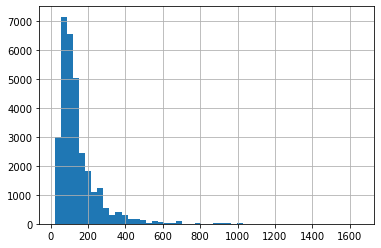

In [25]:
df['price'].hist(bins=50)

<AxesSubplot:>

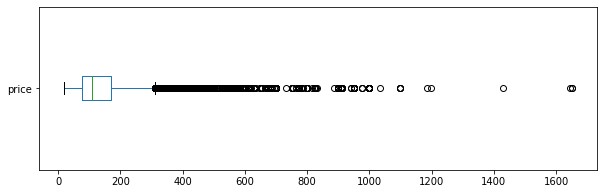

In [26]:
plt.figure(figsize=(10,3))
df['price'].plot(kind='box', vert=False)

### Columns of type object

In [27]:
print("type object:\n-------------")
for col in df.select_dtypes(include=object).columns:
    print(col)

type object:
-------------
last_scraped
host_since
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_has_profile_pic
host_identity_verified
neighbourhood_group_cleansed
is_location_exact
property_type
room_type
bed_type
amenities
first_review
last_review
instant_bookable
cancellation_policy
require_guest_profile_picture
require_guest_phone_verification


### datetime columns

Some columns are about dates but encoded as string. They will be re-encoded as datetime.

In [28]:
def is_datetime_col(series):
    """Detect columns that can be turned into datetime"""
    if series.dtype == object:
        answer = series.str.match('\d{4}-\d{2}-\d{2}').all()
    else:
        answer = False
    return answer

In [29]:
df = df.apply(lambda x: pd.to_datetime(x) if is_datetime_col(x) else x)

In [30]:
df.select_dtypes(exclude=[bool, float, int, object]).head(5)

last_scraped host_since first_review last_review
0   2016-01-04 2008-11-10          NaT         NaT
1   2016-01-04 2008-11-10          NaT         NaT
2   2016-01-04 2008-11-10          NaT         NaT
3   2016-01-04 2008-11-10          NaT         NaT
4   2016-01-04 2008-11-10          NaT         NaT

#### Feature engineering - 'host_duration' and 'no_review_days'

From pairs of datetime columns, I engineered possibly useful new columns.

'host_duration' is how many days the owner has been a host in Airbnb.

'no_review_days' is how many days the host has not received reviews.

In [31]:
df['host_duration'] = (df['last_scraped'] - df['host_since']).dt.days
df['no_review_days'] = (df['last_scraped'] - df['last_review']).dt.days

<AxesSubplot:>

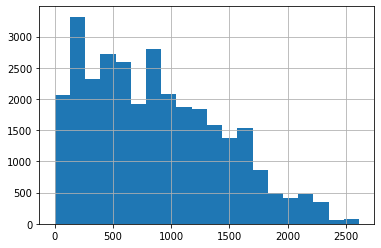

In [32]:
df['host_duration'].hist(bins=20)

<AxesSubplot:>

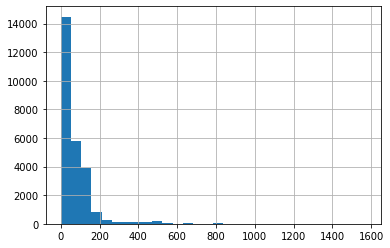

In [33]:
df['no_review_days'].hist(bins=30)

In [34]:
datetime_cols = ['last_scraped', 'host_since', 'first_review', 'last_review']
df = df.drop(columns=datetime_cols)

### Boolean columns

There are some columns which are potentially boolean but encoded as string ("t", "f").

In [35]:
def is_boolean_col(series):
    """Detect boolean columns"""
    if series.dtype == object:
        answer = series.isin(['t', 'f', np.nan]).all()
    else:
        answer = False
    return answer

In [36]:
df = df.apply(lambda x: x.replace('t', 1).replace('f', 0) if is_boolean_col(x) else x)

### Remaining object type columns

In [37]:
df.select_dtypes(include=object).head(3)

host_response_time host_response_rate host_acceptance_rate  \
0  within a few hours                88%                 100%   
1  within a few hours                88%                 100%   
2  within a few hours                88%                 100%   

  neighbourhood_group_cleansed property_type        room_type  bed_type  \
0               Rainier Valley           NaN  Entire home/apt  Real Bed   
1               Rainier Valley           NaN  Entire home/apt  Real Bed   
2               Rainier Valley           NaN  Entire home/apt  Real Bed   

                                           amenities cancellation_policy  
0  {"Wireless Internet",Kitchen,"Free Parking on ...              strict  
1  {"Wireless Internet",Kitchen,"Free Parking on ...              strict  
2  {"Wireless Internet",Kitchen,"Free Parking on ...              strict

### Columns of percentage data

In [38]:
df = df.apply(lambda x: x.str.strip('%').astype(float) if x.dtype == object and x.str.contains('%').all() else x)

### Categorical data columns

Other object type columns are genuinely categorical data.

#### Amenities

First turn 'amenities' column which is encoded as string, into lists of items.

In [39]:
df['amenities'] = df['amenities'].apply(lambda x: x.strip('{}').replace('"','').split(','))

To get to know all unique items that appear in the column, flatten out all rows.

In [40]:
flatten = itertools.chain.from_iterable
amenities_flatten = list(flatten(df['amenities'].to_list()))
amenities_flatten

['Wireless Internet',
 'Kitchen',
 'Free Parking on Premises',
 'Pets live on this property',
 'Dog(s)',
 'Other pet(s)',
 'Indoor Fireplace',
 'Heating',
 'Family/Kid Friendly',
 'Washer',
 'Dryer',
 'Smoke Detector',
 'First Aid Kit',
 'Wireless Internet',
 'Kitchen',
 'Free Parking on Premises',
 'Pets live on this property',
 'Dog(s)',
 'Other pet(s)',
 'Indoor Fireplace',
 'Heating',
 'Family/Kid Friendly',
 'Washer',
 'Dryer',
 'Smoke Detector',
 'First Aid Kit',
 'Wireless Internet',
 'Kitchen',
 'Free Parking on Premises',
 'Pets live on this property',
 'Dog(s)',
 'Other pet(s)',
 'Indoor Fireplace',
 'Heating',
 'Family/Kid Friendly',
 'Washer',
 'Dryer',
 'Smoke Detector',
 'First Aid Kit',
 'Wireless Internet',
 'Kitchen',
 'Free Parking on Premises',
 'Pets live on this property',
 'Dog(s)',
 'Other pet(s)',
 'Indoor Fireplace',
 'Heating',
 'Family/Kid Friendly',
 'Washer',
 'Dryer',
 'Smoke Detector',
 'First Aid Kit',
 'Wireless Internet',
 'Kitchen',
 'Free Parking on 

And then count all unique elements.

In [41]:
Counter(amenities_flatten)

Counter({'Wireless Internet': 29576,
         'Kitchen': 27276,
         'Free Parking on Premises': 18146,
         'Pets live on this property': 7303,
         'Dog(s)': 4333,
         'Other pet(s)': 418,
         'Indoor Fireplace': 7824,
         'Heating': 29237,
         'Family/Kid Friendly': 16241,
         'Washer': 24349,
         'Dryer': 24353,
         'Smoke Detector': 26296,
         'First Aid Kit': 14217,
         'TV': 20727,
         'Cable TV': 12394,
         'Internet': 22468,
         'Fire Extinguisher': 18213,
         'Essentials': 25628,
         'Shampoo': 21404,
         'Carbon Monoxide Detector': 19798,
         '24-Hour Check-in': 4664,
         'Hangers': 6395,
         'Hair Dryer': 5929,
         'Iron': 5642,
         'Laptop Friendly Workspace': 5588,
         'Hot Tub': 2618,
         'Elevator in Building': 5567,
         'Air Conditioning': 5458,
         'Doorman': 669,
         'Breakfast': 2535,
         'Buzzer/Wireless Intercom': 3958,
    

Evaluate how common each item is in amenities.

In [42]:
print("Frequency of amenities among listings (%)\n-------------------------------------")
(pd.Series(Counter(amenities_flatten)).sort_values(ascending=False)/df.shape[0])*100

Frequency of amenities among listings (%)
-------------------------------------


Wireless Internet             96.204014
Heating                       95.101324
Kitchen                       88.722636
Smoke Detector                85.534919
Essentials                    83.362066
Dryer                         79.214781
Washer                        79.201770
Internet                      73.083304
Shampoo                       69.622353
TV                            67.420226
Carbon Monoxide Detector      64.398400
Fire Extinguisher             59.242754
Free Parking on Premises      59.024819
Family/Kid Friendly           52.828286
First Aid Kit                 46.244674
Cable TV                      40.314868
Indoor Fireplace              25.449696
Pets live on this property    23.755001
Hangers                       20.801483
Hair Dryer                    19.285691
Safety Card                   18.771753
Iron                          18.352145
Laptop Friendly Workspace     18.176495
Elevator in Building          18.108187
Air Conditioning              17.753635


One-hot encode all amenity items. 

In [43]:
# 1 if the listings has the item, 0 otherwise.
for item in Counter(amenities_flatten).keys():
    if item != '':
        df[item] = df['amenities'].apply(lambda x: item in x)

#### num_amenities

There is a high chance number of amenities the listing offers for guests are correlated to price.

In [44]:
df['num_amenities'] = df['amenities'].apply(len)

In [45]:
df.drop('amenities', axis=1, inplace=True)

#### cancellation_policy

Other categorical columns can be simply one-hot encoded. Before doing that I visualized relations among columns to get some useful insights.

In [46]:
df['cancellation_policy'].value_counts()

strict      12037
moderate     9537
flexible     9169
Name: cancellation_policy, dtype: int64

<AxesSubplot:xlabel='cancellation_policy', ylabel='count'>

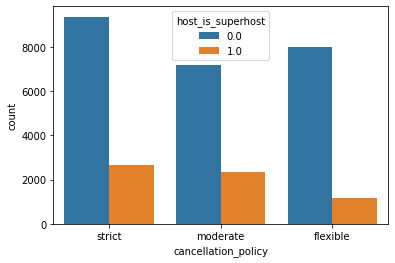

In [47]:
sns.countplot(data=df, x='cancellation_policy', hue='host_is_superhost')

I expected there would be some relation between if the host is superhost or not and if the host enforces strict cancellation plocy. However no remarkable tendency was found.

<AxesSubplot:xlabel='price', ylabel='cancellation_policy'>

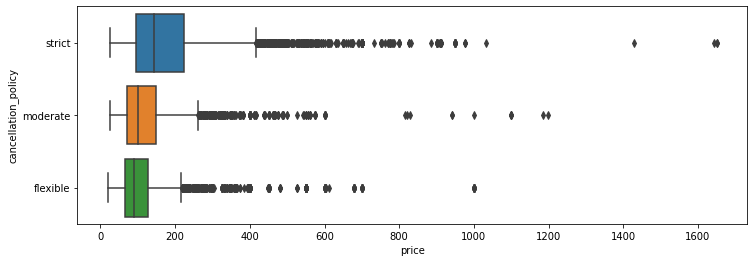

In [48]:
policy_order = df.groupby('cancellation_policy')['price'].median().sort_values(ascending=False).index
plt.figure(figsize=(12, 4))
sns.boxplot(data=df, y='cancellation_policy', x='price', orient='h', order=policy_order)

This is a very informative visualization. Hosts tend to enforce stricter cancellation policy for expensive listings. It totally makes sense.

#### host_response_time

In [49]:
df['host_response_time'].value_counts()

within an hour        13532
within a few hours     8231
within a day           4931
a few days or more      349
Name: host_response_time, dtype: int64

<AxesSubplot:xlabel='review_scores_rating', ylabel='host_response_time'>

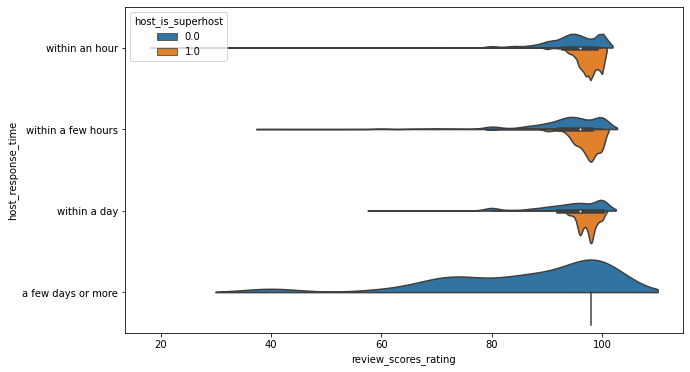

In [50]:
order = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']
plt.figure(figsize=(10,6))
sns.violinplot(data=df, y='host_response_time', x='review_scores_rating', hue='host_is_superhost', orient='h', split=True, order=order)

It can be seen that superhosts tend to respond quicker. I also expectd revew scores would be higher when hosts respond immediately, but surprisingly such tendency was not that distinct. 

<AxesSubplot:xlabel='host_response_time', ylabel='count'>

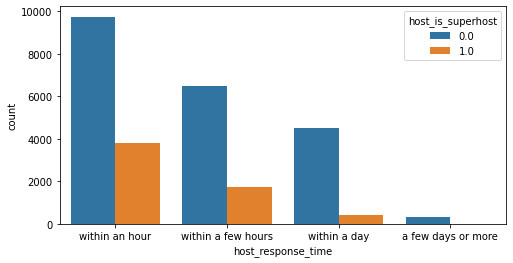

In [51]:
order = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='host_response_time', hue='host_is_superhost', order=order)

This bar plot shows that actually most hosts respond at latest within a day, regardless of whether they are superhost or not.

#### property_type & room_type & bed_type

In [52]:
df['property_type'].value_counts()

House              15248
Apartment          12577
Townhouse            979
Condominium          701
Bed & Breakfast      345
Loft                 254
Other                175
Cabin                161
Camper/RV             79
Boat                  78
Bungalow              41
Tent                  33
Chalet                23
Treehouse             21
Dorm                  16
Name: property_type, dtype: int64

In [53]:
df['room_type'].value_counts()

Entire home/apt    18678
Private room       10862
Shared room         1203
Name: room_type, dtype: int64

In [54]:
df['bed_type'].value_counts()

Real Bed         29481
Futon              611
Pull-out Sofa      334
Airbed             214
Couch              103
Name: bed_type, dtype: int64

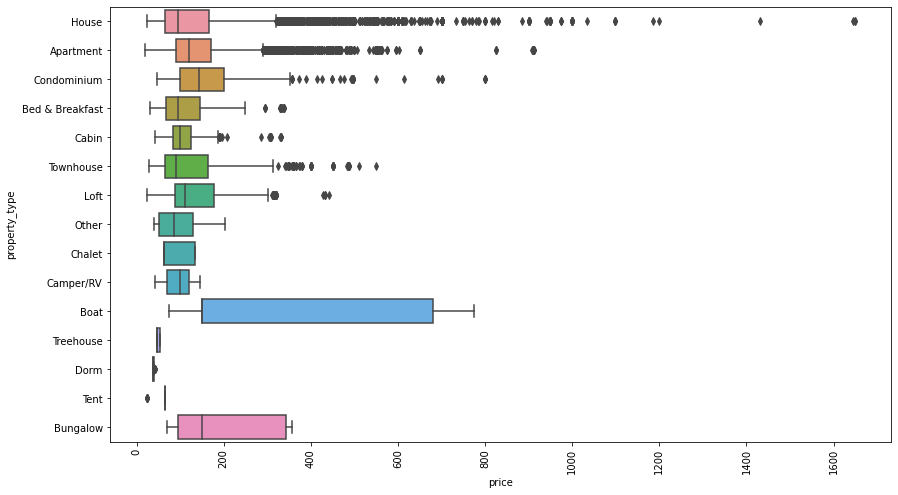

In [55]:
plt.figure(figsize=(14,8))
sns.boxplot(data=df, y='property_type', x='price', orient='h')
plt.xticks(rotation=90)
None

The above box plots show that at least the median of prices do not differ much by property_type. However 'House' type has the most extreme outliers.

<AxesSubplot:xlabel='price', ylabel='room_type'>

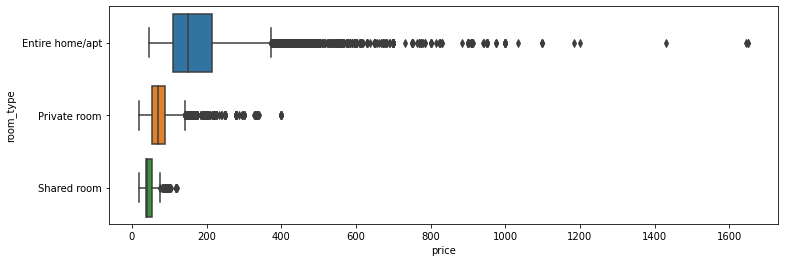

In [56]:
plt.figure(figsize=(12, 4))
sns.boxplot(data=df, y='room_type', x='price', orient='h')

This shows that room_type is a very important feature to speculate price range. It can be seen that price outliers are mostly from listings of Entire home/apt. 

Probably this is one of the biggest reasons why my machine learning model predict those outliers very well, as will be demonstrated later (Of course I employed models robust to outliers and that is also a big factor.)

<AxesSubplot:xlabel='price', ylabel='neighbourhood_group_cleansed'>

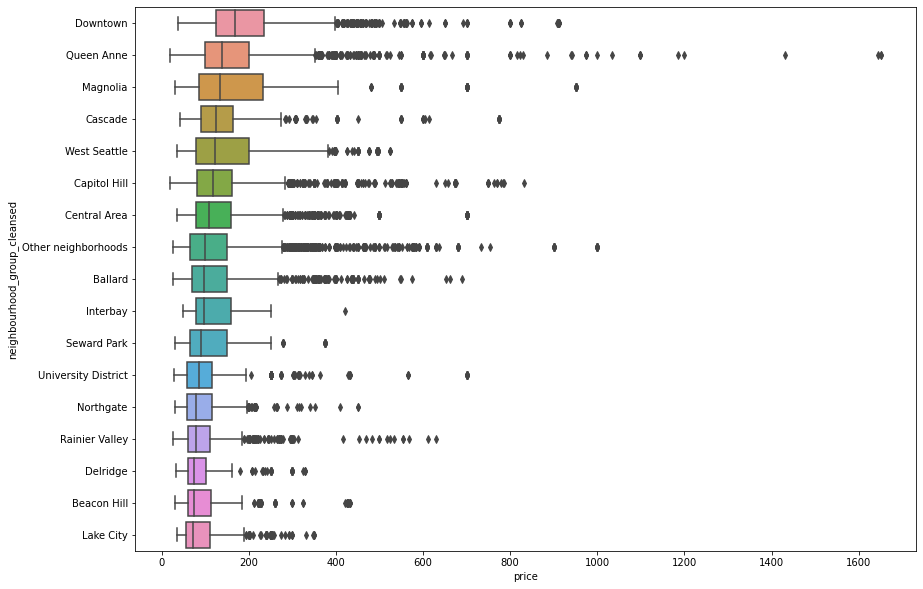

In [57]:
neighbourhood_order = df.groupby('neighbourhood_group_cleansed')['price'].median().sort_values(ascending=False).index
plt.figure(figsize=(14, 10))
sns.boxplot(data=df, y='neighbourhood_group_cleansed', x='price', orient='h', order=neighbourhood_order)

Area is obviously important factor but it alone does not change price of the majority of listings so much. However it is a big factor when it comes to outliers, that is, very expensive listings. As I stated at the plot of room type, these listings over around 400$ are all entire house offers. Hence this plot also shows that entire home offers cannot be found in some areas.

The most expensive area in terms of the mean value is Downtown. On the other hand the most expensive listings are found in Queen Anne.

## One-hot encoding of categorical features

In [58]:
cat_cols = ["neighbourhood_group_cleansed", "property_type", "host_response_time", "room_type", "bed_type", 
            "cancellation_policy"]
onehot_en = ce.OneHotEncoder(cols=cat_cols, use_cat_names=True)
df = onehot_en.fit_transform(df)

/usr/local/anaconda3/envs/airbnbenv/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## Missing values

Here I analyze and impute missing values.

In [59]:
# Percentage of missing values
(df.isnull().sum().sort_values(ascending=False).head(20)/len(df))*100

host_acceptance_rate           19.051491
review_scores_checkin          15.915818
review_scores_accuracy         15.889796
review_scores_value            15.841004
review_scores_location         15.824741
review_scores_cleanliness      15.795466
review_scores_communication    15.743421
review_scores_rating           15.626321
no_review_days                 15.079856
reviews_per_month              15.079856
host_response_rate             12.035260
beds                            0.039033
host_duration                   0.003253
host_identity_verified          0.003253
host_has_profile_pic            0.003253
host_total_listings_count       0.003253
host_listings_count             0.003253
host_is_superhost               0.003253
Kitchen                         0.000000
Washer                          0.000000
dtype: float64

It seems that many columns related to review are missing in about 15% of the time. Not surprisingly, they are missing almost always in the same listings. 

### Imputation according to another column

My approach to deal with missing values is to impute with median conditioned on another feature that is most correlated with the missing column.

For this method, first I need to know correlation among columns.

Although review_scores columns are highly correlated to one another, they can't be used to estimate median since they are missing at the same time. I decided to use other correlated features so investigated correlation with those columns as well. Then I picked up a few review_score columns that are most correlated to price and discard other review_score columns because they seem to be redundant.

NOTE - It is no wonder when the listing has received no reviews these columns are missing, and it might seem strange to impute those with fictitious values. However in order to utilize those information to build a machine learning model, they have to be imputed with reasonable values.

#### Correlation of price and review_scores columns

In [60]:
df[['price']+df.columns[df.columns.str.contains('review_scores')].to_list()].corr()

price  review_scores_rating  \
price                        1.000000              0.074847   
review_scores_rating         0.074847              1.000000   
review_scores_accuracy       0.020203              0.627044   
review_scores_cleanliness    0.079605              0.655434   
review_scores_checkin        0.002078              0.499058   
review_scores_communication  0.008057              0.518964   
review_scores_location       0.092758              0.351934   
review_scores_value         -0.035505              0.687466   

                             review_scores_accuracy  \
price                                      0.020203   
review_scores_rating                       0.627044   
review_scores_accuracy                     1.000000   
review_scores_cleanliness                  0.553868   
review_scores_checkin                      0.428024   
review_scores_communication                0.413610   
review_scores_location                     0.257987   
review_scores_value                        0.564207   

                             review_scores_cleanliness  review_scores_checkin  \
price                                         0.079605               0.002078   
review_scores_rating                          0.655434               0.499058   
review_scores_accuracy                        0.553868               0.428024   
review_scores_cleanliness                     1.000000               0.424132   
review_scores_checkin                         0.424132               1.000000   
review_scores_communication                   0.396158               0.679602   
review_scores_location                        0.277110               0.247916   
review_scores_value                           0.520625               0.392329   

                             review_scores_communication  \
price                                           0.008057   
review_scores_rating                            0.518964   
review_scores_accuracy                          0.413610   
review_scores_cleanliness                       0.396158   
review_scores_checkin                           0.679602   
review_scores_communication                     1.000000   
review_scores_location                          0.273296   
review_scores_value                             0.438262   

                             review_scores_location  review_scores_value  
price                                      0.092758            -0.035505  
review_scores_rating                       0.351934             0.687466  
review_scores_accuracy                     0.257987             0.564207  
review_scores_cleanliness                  0.277110             0.520625  
review_scores_checkin                      0.247916             0.392329  
review_scores_communication                0.273296             0.438262  
review_scores_location                     1.000000             0.340809  
review_scores_value                        0.340809             1.000000

In [61]:
df[['price', 'host_acceptance_rate', 'review_scores_rating', 'no_review_days', 'reviews_per_month', 'host_response_rate']].corr()

price  host_acceptance_rate  review_scores_rating  \
price                 1.000000              0.008869              0.074847   
host_acceptance_rate  0.008869              1.000000             -0.020599   
review_scores_rating  0.074847             -0.020599              1.000000   
no_review_days        0.071557             -0.015927             -0.087164   
reviews_per_month    -0.202736              0.022064              0.086004   
host_response_rate   -0.001855             -0.010078              0.168840   

                      no_review_days  reviews_per_month  host_response_rate  
price                       0.071557          -0.202736           -0.001855  
host_acceptance_rate       -0.015927           0.022064           -0.010078  
review_scores_rating       -0.087164           0.086004            0.168840  
no_review_days              1.000000          -0.386809           -0.109824  
reviews_per_month          -0.386809           1.000000            0.171758  
host_response_rate         -0.109824           0.171758            1.000000

'review_scores_rating', 'review_scores_cleanliness', 'review_scores_location' have relatively higher correlation with price, so I decided to keep these 3 for a moment.

Also the second correlation matrix shows that 'no_review_days' and 'reviews_per_month' have some correlation with price as well.

To impute missing rows of these columns, I examined which the most correlated (among not review_scores columns) columns.

In [62]:
abs(df.corr()['review_scores_rating']).sort_values(ascending=False).head(15)

review_scores_rating                                1.000000
review_scores_value                                 0.687466
review_scores_cleanliness                           0.655434
review_scores_accuracy                              0.627044
review_scores_communication                         0.518964
review_scores_checkin                               0.499058
review_scores_location                              0.351934
host_is_superhost                                   0.245214
calculated_host_listings_count                      0.217138
host_response_rate                                  0.168840
neighbourhood_group_cleansed_University District    0.162513
num_amenities                                       0.147670
Shampoo                                             0.135047
host_response_time_a few days or more               0.132135
First Aid Kit                                       0.114037
Name: review_scores_rating, dtype: float64

host_is_superhost is the most correlated column for review_scores_rating.

In [63]:
abs(df.corr()['review_scores_location']).sort_values(ascending=False).head(15)

review_scores_location                         1.000000
review_scores_rating                           0.351934
review_scores_value                            0.340809
review_scores_cleanliness                      0.277110
review_scores_communication                    0.273296
review_scores_accuracy                         0.257987
review_scores_checkin                          0.247916
longitude                                      0.203496
neighbourhood_group_cleansed_Rainier Valley    0.195093
neighbourhood_group_cleansed_Beacon Hill       0.158342
neighbourhood_group_cleansed_Capitol Hill      0.138027
host_is_superhost                              0.133310
Elevator in Building                           0.132021
Gym                                            0.126775
neighbourhood_group_cleansed_Delridge          0.118014
Name: review_scores_location, dtype: float64

longitude is the most correlated column for review_scores_location (makes sense) but it is a numerical feature. It is possible to build regression model to estimate the median from longitude but is not worth it. I instead used a binary column 'neighbourhood_group_cleansed_Rainier Valley' to estimate medians accordingly.

In [64]:
abs(df.corr()['review_scores_cleanliness']).sort_values(ascending=False).head(10)

review_scores_cleanliness         1.000000
review_scores_rating              0.655434
review_scores_accuracy            0.553868
review_scores_value               0.520625
review_scores_checkin             0.424132
review_scores_communication       0.396158
review_scores_location            0.277110
host_is_superhost                 0.235562
calculated_host_listings_count    0.206117
Shampoo                           0.188166
Name: review_scores_cleanliness, dtype: float64

review_scores_cleanliness is also most correlated to host_is_superhost

#### Visualization of the correlation between 'review_scores_rating' and 'host_is_superhost'

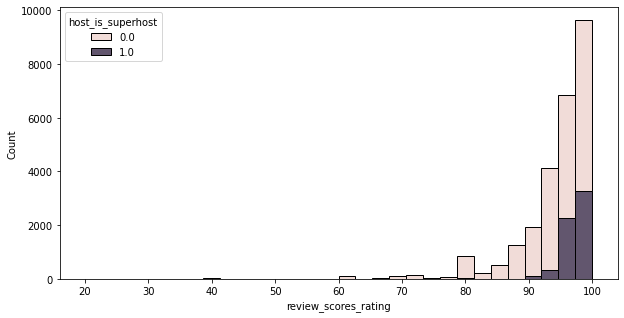

In [65]:
plt.figure(figsize=(10,5))
sns.histplot(data=df, x="review_scores_rating", bins=30, hue="host_is_superhost", multiple="stack")
None

This shows that low scores are only for non-superhosts.

#### Estimate the median according to 'host_is_superhost' and 'neighbourhood_group_cleansed_Rainier Valley'

In [66]:
median_by_superhost = df.groupby("host_is_superhost").median()
median_by_superhost["review_scores_rating"]

host_is_superhost
0.0    95.0
1.0    98.0
Name: review_scores_rating, dtype: float64

In [67]:
median_by_neighbourhood = df.groupby('neighbourhood_group_cleansed_Rainier Valley').median()
median_by_neighbourhood["review_scores_location"]

neighbourhood_group_cleansed_Rainier Valley
0    10.0
1     9.0
Name: review_scores_location, dtype: float64

#### Impute missing values with medians

In [68]:
df.loc[df['host_is_superhost']==0, 'review_scores_rating'] = df.loc[df['host_is_superhost']==0, 'review_scores_rating'].copy().fillna(median_by_superhost.loc[0, "review_scores_rating"])
df.loc[df['host_is_superhost']==1, 'review_scores_rating'] = df.loc[df['host_is_superhost']==1, 'review_scores_rating'].copy().fillna(median_by_superhost.loc[1, "review_scores_rating"])

In [69]:
df.loc[df['host_is_superhost']==0, 'review_scores_cleanliness'] = df.loc[df['host_is_superhost']==0, 'review_scores_cleanliness'].copy().fillna(median_by_superhost.loc[0, "review_scores_cleanliness"])
df.loc[df['host_is_superhost']==1, 'review_scores_cleanliness'] = df.loc[df['host_is_superhost']==1, 'review_scores_cleanliness'].copy().fillna(median_by_superhost.loc[1, "review_scores_cleanliness"])

In [70]:
df.loc[df['neighbourhood_group_cleansed_Rainier Valley']==0, 'review_scores_location'] = df.loc[df['neighbourhood_group_cleansed_Rainier Valley']==0, 'review_scores_location'].copy().fillna(median_by_neighbourhood.loc[0, "review_scores_location"])
df.loc[df['neighbourhood_group_cleansed_Rainier Valley']==1, 'review_scores_location'] = df.loc[df['neighbourhood_group_cleansed_Rainier Valley']==1, 'review_scores_location'].copy().fillna(median_by_neighbourhood.loc[1, "review_scores_location"])

#### Impute 'no_review_days'

It will be imputed in the same manner.

In [71]:
abs(df.corr()['no_review_days']).sort_values(ascending=False).head(10)

no_review_days                       1.000000
reviews_per_month                    0.386809
host_response_time_nan               0.277379
host_response_time_within an hour    0.207251
number_of_reviews                    0.197181
Essentials                           0.196419
Shampoo                              0.174429
review_scores_accuracy               0.163660
Smoke Detector                       0.159544
Carbon Monoxide Detector             0.158219
Name: no_review_days, dtype: float64

In [72]:
median_by_response_time_nan = df.groupby('host_response_time_nan').median()
median_by_response_time_nan['no_review_days']

host_response_time_nan
0     36.0
1    130.0
Name: no_review_days, dtype: float64

#### Impute 'reviews_per_month'

In [73]:
median_by_response_time_nan['reviews_per_month']

host_response_time_nan
0    1.63
1    0.56
Name: reviews_per_month, dtype: float64

In [74]:
df.loc[df['host_response_time_nan']==0, 'no_review_days'] = df.loc[df['host_response_time_nan']==0, 'no_review_days'].copy().fillna(median_by_response_time_nan.loc[0, 'no_review_days'])
df.loc[df['host_response_time_nan']==1, 'no_review_days'] = df.loc[df['host_response_time_nan']==1, 'no_review_days'].copy().fillna(median_by_response_time_nan.loc[1, 'no_review_days'])
df.loc[df['host_response_time_nan']==0, 'reviews_per_month'] = df.loc[df['host_response_time_nan']==0, 'reviews_per_month'].copy().fillna(median_by_response_time_nan.loc[0, 'reviews_per_month'])
df.loc[df['host_response_time_nan']==1, 'reviews_per_month'] = df.loc[df['host_response_time_nan']==1, 'reviews_per_month'].copy().fillna(median_by_response_time_nan.loc[1, 'reviews_per_month'])

#### Drop useless columns

In [75]:
drop_cols = ['host_acceptance_rate', 'review_scores_checkin', 'review_scores_accuracy', 'review_scores_value', 
             'review_scores_communication', 'host_response_rate']
df = df.drop(columns=drop_cols)

#### Impute other missing values with simple medians

Other columns have only small percentage of missing rows. I imputed them with simple medians.

In [76]:
df.fillna(df.median(), inplace=True)

Now no columns have missing values!

In [77]:
df.isnull().sum()

month                                    0
price                                    0
host_response_time_within a few hours    0
host_response_time_within a day          0
host_response_time_within an hour        0
                                        ..
Gym                                      0
Pool                                     0
Washer / Dryer                           0
Smoking Allowed                          0
num_amenities                            0
Length: 122, dtype: int64

### Correlation and redundant features

Let's check columns that are most correlated with price.

In [89]:
abs(df.corr()['price']).sort_values(ascending=False).head(20)

price                                      1.000000
bedrooms                                   0.692191
accommodates                               0.690786
beds                                       0.624552
room_type_Entire home/apt                  0.483442
guests_included                            0.391881
Cable TV                                   0.305965
num_amenities                              0.242211
reviews_per_month                          0.184794
neighbourhood_group_cleansed_Downtown      0.181904
host_listings_count                        0.175813
Pool                                       0.168118
Elevator in Building                       0.153361
number_of_reviews                          0.118901
longitude                                  0.110569
neighbourhood_group_cleansed_Queen Anne    0.102129
property_type_Boat                         0.088587
review_scores_location                     0.087184
host_duration                              0.078408
review_score

The top 3 columns are bedrooms, accommodates, and beds, and they are most probably highly correlated to one another.

In [79]:
df[['price', 'accommodates', 'bedrooms', 'beds']].corr()

price  accommodates  bedrooms      beds
price         1.000000      0.690786  0.692191  0.624552
accommodates  0.690786      1.000000  0.819812  0.862593
bedrooms      0.692191      0.819812  1.000000  0.795644
beds          0.624552      0.862593  0.795644  1.000000

Let's see these correlations in scatter plots of each pair.

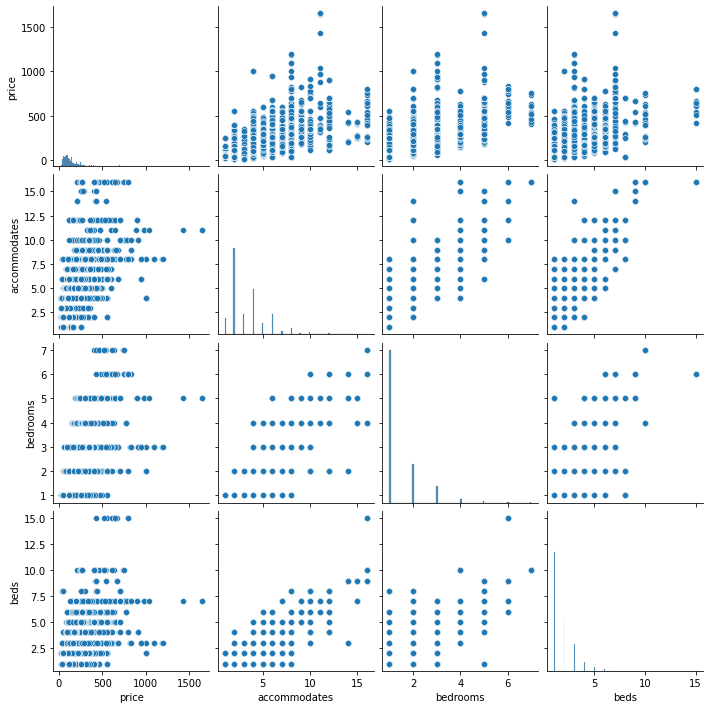

In [80]:
sns.pairplot(df[['price', 'accommodates', 'bedrooms', 'beds']])

It can be clearly seen that the 3 features are tightly correlated and price tends to be higher as these features get bigger.

In [81]:
df[['accommodates', 'bedrooms', 'beds']].describe()

accommodates      bedrooms          beds
count  30743.000000  30743.000000  30743.000000
mean       3.426536      1.426634      1.790521
std        2.066110      0.796973      1.199952
min        1.000000      1.000000      1.000000
25%        2.000000      1.000000      1.000000
50%        3.000000      1.000000      1.000000
75%        4.000000      2.000000      2.000000
max       16.000000      7.000000     15.000000

#### Cluster map to spot redundant columns

It can be seen there are other columns that seem redundant. Cluster map is a useful tool to find them out and do correlation analysis at a time.

In [82]:
listings_cols = df.columns[df.columns.str.contains('listings')]
availability_cols = df.columns[df.columns.str.contains('availability')]
cols = ['price', 'number_of_reviews', 'reviews_per_month'] + list(listings_cols) + list(availability_cols)

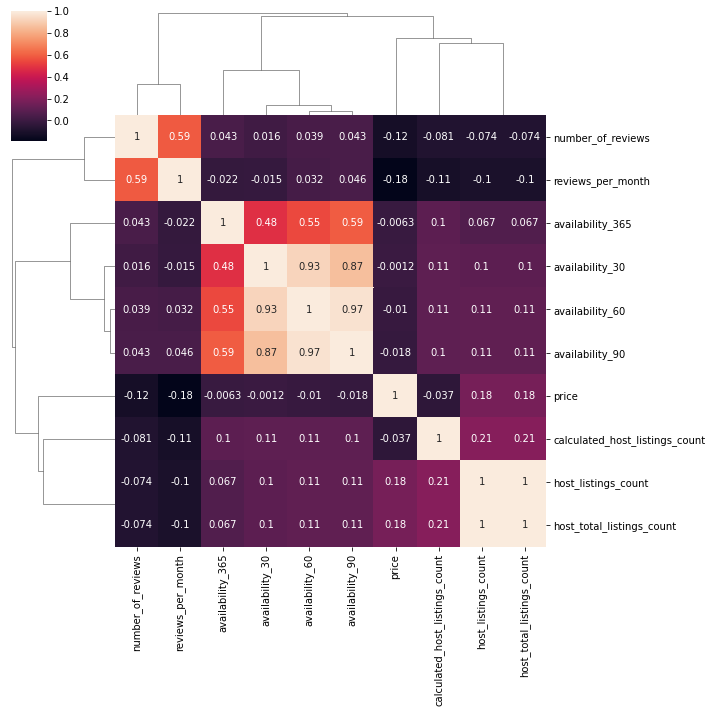

In [83]:
sns.clustermap(df[cols].corr(), annot=True)

It can be seen that only 'availability_365' has different behaviour from other availability columns. I picked this but maybe I should have chosen 'availability_90' since it is more correlated to price.

In [84]:
df = df.drop(columns=['availability_30', 'availability_60', 'availability_90', 'host_total_listings_count'])

Let's check if there are no other redundant columns.

In [85]:
print("Most correlated pairs:\n-------------------")
df.corr()[df.corr()!=1.0].idxmax().head(10)

Most correlated pairs:
-------------------


month                                                         availability_365
price                                                                 bedrooms
host_response_time_within a few hours                      property_type_Other
host_response_time_within a day                   cancellation_policy_flexible
host_response_time_within an hour                            reviews_per_month
host_response_time_nan                                          no_review_days
host_response_time_a few days or more     neighbourhood_group_cleansed_Cascade
host_is_superhost                                            reviews_per_month
host_listings_count                      neighbourhood_group_cleansed_Downtown
host_has_profile_pic                                    host_identity_verified
dtype: object

### 'price' and 'guest_included'

The more guests are included, the higher the price is.

<AxesSubplot:xlabel='guests_included', ylabel='price'>

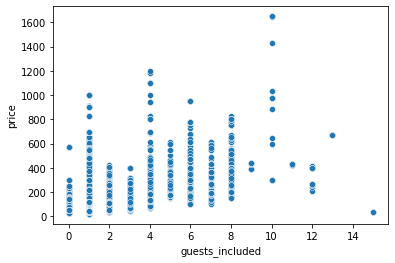

In [86]:
sns.scatterplot(data=df, x='guests_included', y='price')

### Seasonal change of price

Remember 'price' represents the monthly average. Here is the average of those prices on each month.

Points represent averages and bars represent uncertainty around them.

<AxesSubplot:xlabel='month', ylabel='price'>

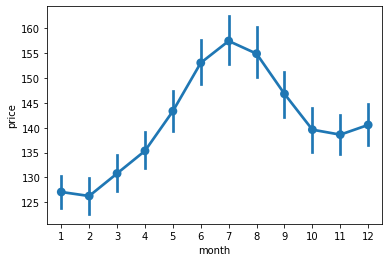

In [87]:
sns.pointplot(data=df, x='month', y='price')

As is expected, price tends to be higher during summer (6~8) when they have many tourists.

#### Save the cleaned data as csv

In [91]:
df.to_csv('seattle_preprocessed.csv', index=False)

### Outliers

Even though I'm aware that models I used were quite robust to outliers, I also tested to omit them and see how it affects models' performance. The result was it did not improve the performance at all. As I already mentioned earlier, I consider it is also partly because price outliers in the dataset are very easy for models to predict from some features.

In any case, I here leave my approach to eliminate outliers untouched for a reference.

<AxesSubplot:>

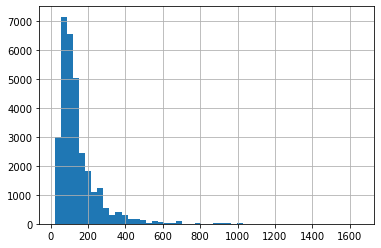

In [123]:
df['price'].hist(bins=50)

This is one of the most common approach to detect outliers. 

In [124]:
def detect_outliers(df, variable, k):
    # Return indices of outliers
    # Specify k to determine from which range we consider as outliers
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower = df[variable].quantile(0.25) - k*IQR
    upper = df[variable].quantile(0.75) + k*IQR
    outliers = df.index[(df[variable]>upper) | (df[variable]<lower)]
    print("Upper boundary:", upper)
    print("Lower boundary:", lower)
    return outliers

In [126]:
outlier_idx = df.index[detect_outliers(df, 'price', 1.5)]
outliers = df.iloc[outlier_idx]
df = df.drop(outlier_idx)

Upper boundary: 310.0
Lower boundary: -66.0


<AxesSubplot:xlabel='price', ylabel='Count'>

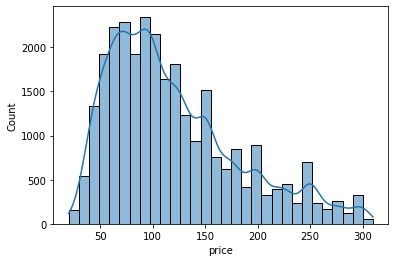

In [127]:
sns.histplot(data=df, x='price', bins=30, kde=True)

<AxesSubplot:>

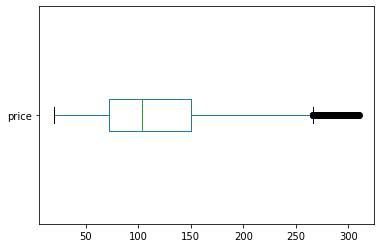

In [128]:
df['price'].plot(kind='box', vert=False)

## Machine Learning

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_tree, plot_importance
#from verstack.stratified_continuous_split import scsplit

Finally we can move on to machine learning model building.

In this project, I tested 3 models: Random forest regression, XGBoost regression, multilayered Linear Perceptron.

### Model evaluation

In this project, as model performance metrics I used mean absolute error, R-squared, and a little unusual one mean absolute percentage. Price distribution is highly skewed and the price scale varies. For this type of data popular root mean squared error is not necessarily a good metric any more since it penelizes errors in different scales in the same manner; in price prediction, we want to predict which price range the listing falls and not the exact number. Mean absolute percentage error estimates the ratio of error to actual price, and therefore it is a suitable metric for our purpose.

### Separate data into train and test set

In [3]:
df = pd.read_csv('seattle_preprocessed.csv')

In [4]:
df = df.astype(float)

In [7]:
X = df.drop("price", axis=1)
y = df["price"].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [95]:
#X_outliers = outliers.drop('price', axis=1).values
#y_outliers = outliers['price'].values.reshape(-1,1)

### Random Forest

I started with training random forest without tuning parameters and just figured out a good number of trees. Then used estimated feature importance to filter out useless columns. 

Note that models I adopted (tree-based models and neural network) perform feature selection by themselves and their predictive performance is not degraded by abundance of features. However filtering out useless features reduces time for model training.

In [8]:
forest = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=None, min_samples_leaf=1, 
                               max_features='auto', max_samples=None, random_state=42, n_jobs=-1, oob_score=True)

In [9]:
forest.fit(X_train, y_train.ravel())

RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True,
                      random_state=42)

In [10]:
y_pred_train = forest.predict(X_train).reshape((X_train.shape[0], 1))
y_pred_test = forest.predict(X_test).reshape((X_test.shape[0], 1))

In [11]:
mae_base = np.sqrt(mean_absolute_error(y, [np.mean(y)]*len(y)))
r2_base = r2_score(y, [np.mean(y)]*len(y))
mae_train = np.sqrt(mean_absolute_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)
mae_test = np.sqrt(mean_absolute_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)
print(f"baseline MAE: {mae_base: .2f}")
print("baseline R2:", r2_base)
print(f"MAE for train data: {mae_train: .2f}")
print(f"R2 for train data: {r2_train: .3f}")
print(f"MAE for test data: {mae_test: .2f}")
print(f"R2 for test data: {r2_test: .3f}")

baseline MAE:  8.47
baseline R2: 0.0
MAE for train data:  1.63
R2 for train data:  0.996
MAE for test data:  2.62
R2 for test data:  0.976


In [12]:
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
print(f"MAPE for train data: {mape_train: .2f}")
print(f"MAPE for test data: {mape_test: .2f}")

MAPE for train data:  0.02
MAPE for test data:  0.04


#### Residual plot

To visualize the model's performance, residuals (the difference of actual values and predictions) are plotted over predicted price.

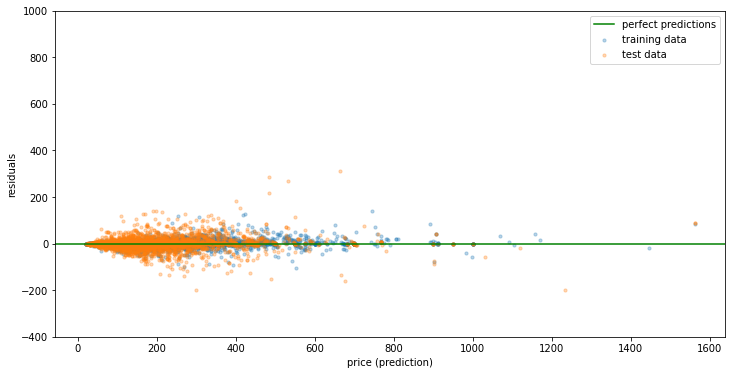

In [101]:
plt.figure(figsize=(12,6))
plt.scatter(y_pred_train, y_train.reshape((X_train.shape[0], 1))-y_pred_train, s=10, alpha=0.3, label='training data')
plt.scatter(y_pred_test, y_test.reshape((X_test.shape[0], 1))-y_pred_test, s=10, alpha=0.3, label='test data')
plt.axhline(c='g', label='perfect predictions')
plt.xlabel("price (prediction)")
plt.ylabel("residuals")
plt.ylim(-400, 1000)
plt.legend()

#### Ferature importances

In [13]:
importances = sorted(zip(X.columns, forest.feature_importances_), key=lambda x: x[1] * -1)
importances = pd.DataFrame(zip(X.columns, forest.feature_importances_), columns=['feature', 'score'])
importances.set_index('feature', inplace=True)
importances = importances.sort_values(by='score', ascending=False)
importances.head(15)

score
feature                                        
bedrooms                               0.424837
accommodates                           0.093194
room_type_Entire home/apt              0.047518
month                                  0.037373
latitude                               0.034943
reviews_per_month                      0.028160
longitude                              0.025781
no_review_days                         0.023915
neighbourhood_group_cleansed_Downtown  0.019677
Elevator in Building                   0.019105
availability_365                       0.015643
host_duration                          0.015375
minimum_nights                         0.012792
num_amenities                          0.012609
beds                                   0.010416

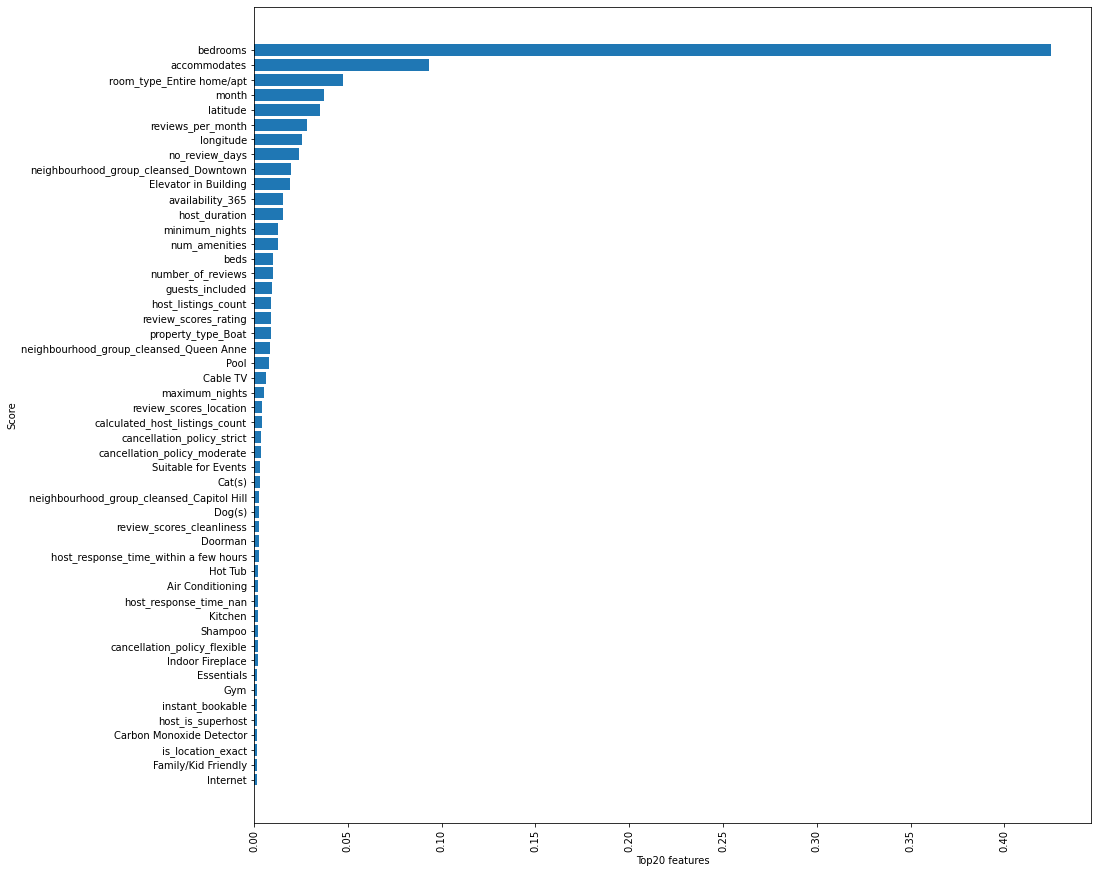

In [14]:
top = importances.head(50).sort_values(by='score')
plt.figure(figsize=(15,15))
plt.barh(top.index, top['score'])
plt.xticks(rotation='vertical')
plt.xlabel('Top20 features')
plt.ylabel('Score')
None

### Feature selection

I claculated the cumulative sum of feature importances and cut off features after it hits 90%. With this cutoff I did not observe significant performance reduction.

In [15]:
cum_importances = np.cumsum(importances)

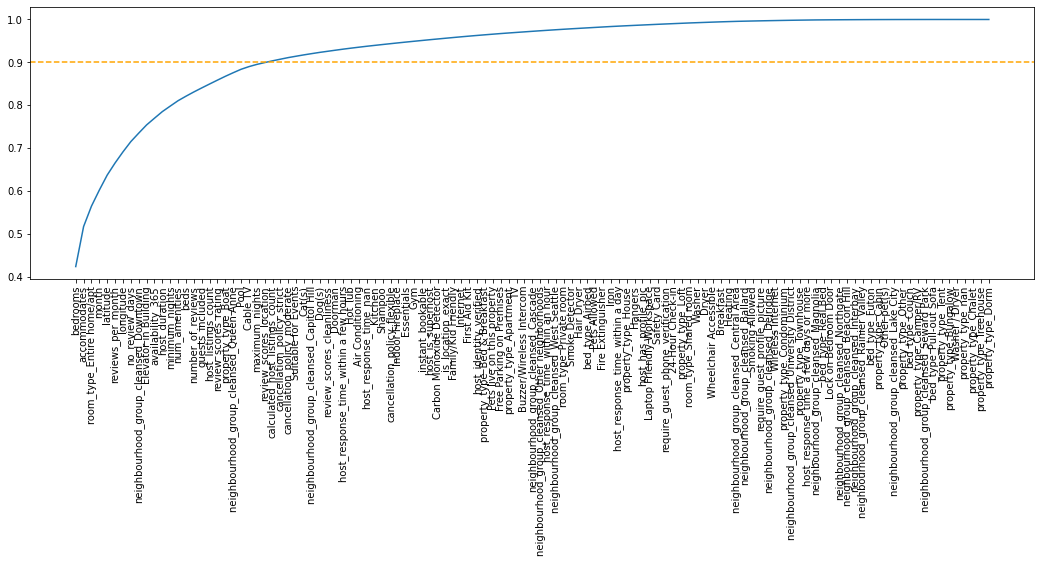

In [16]:
plt.figure(figsize=(18,5))
plt.plot(cum_importances.index, cum_importances['score'], label='cumulative sum of importances')
plt.axhline(y=.9, c='orange', ls='--')
plt.xticks(rotation=90)
None

In [17]:
selected_feat = importances[cum_importances['score']<.9].index
selected_feat

Index(['bedrooms', 'accommodates', 'room_type_Entire home/apt', 'month',
       'latitude', 'reviews_per_month', 'longitude', 'no_review_days',
       'neighbourhood_group_cleansed_Downtown', 'Elevator in Building',
       'availability_365', 'host_duration', 'minimum_nights', 'num_amenities',
       'beds', 'number_of_reviews', 'guests_included', 'host_listings_count',
       'review_scores_rating', 'property_type_Boat',
       'neighbourhood_group_cleansed_Queen Anne', 'Pool', 'Cable TV',
       'maximum_nights', 'review_scores_location'],
      dtype='object', name='feature')

In [18]:
df = df[list(selected_feat)+['price']]
df = df.astype(float)

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30743 entries, 0 to 30742
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   bedrooms                                 30743 non-null  float64
 1   accommodates                             30743 non-null  float64
 2   room_type_Entire home/apt                30743 non-null  float64
 3   month                                    30743 non-null  float64
 4   latitude                                 30743 non-null  float64
 5   reviews_per_month                        30743 non-null  float64
 6   longitude                                30743 non-null  float64
 7   no_review_days                           30743 non-null  float64
 8   neighbourhood_group_cleansed_Downtown    30743 non-null  float64
 9   Elevator in Building                     30743 non-null  float64
 10  availability_365                         30743

In [19]:
X = df.drop("price", axis=1)
y = df["price"].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Gridseach - Random Forest

Next with this new selected features I tried parameter tuning using grid search. However I found the default setting works best.

In [71]:
param_grid = {
    'max_depth': [15, 20, None], 
    'max_samples': [0.5, 0.75, None],
    'min_samples_leaf': [1, 2, 3]
}

rf_grid = RandomForestRegressor(n_estimators=50, criterion='mse', max_features='auto', random_state=42)
grid_search_rf = GridSearchCV(estimator = rf_grid, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [72]:
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/anaconda3/envs/airbnbenv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(n_estimators=50, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [15, 20, None],
                         'max_samples': [0.5, 0.75, None],
                         'min_samples_leaf': [1, 2, 3]},
             verbose=2)

In [73]:
grid_search_rf.best_params_

{'max_depth': None, 'max_samples': None, 'min_samples_leaf': 1}

In [74]:
best_rf = grid_search_rf.best_estimator_
best_rf.score(X_test, y_test)

0.9757135559774137

In [80]:
y_pred_train = best_rf.predict(X_train).reshape((X_train.shape[0], 1))
y_pred_test = best_rf.predict(X_test).reshape((X_test.shape[0], 1))

#### MAE, MAPE, R2

In [81]:
mae_train = np.sqrt(mean_absolute_error(y_train, y_pred_train))
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_test = np.sqrt(mean_absolute_error(y_test, y_pred_test))
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print("Performance\n--------------------------")
print("on training data:\n-------------------------")
print(f"MAE: {mae_train: .2f}")
print(f"MAPE: {mape_train: .3f}")
print(f"R2: {r2_train: .3f}")
print("--------------------------")
print("on test data:\n-------------------------")
print(f"MAE: {mae_test: .2f}")
print(f"MAPE: {mape_test: .3f}")
print(f"R2: {r2_test: .3f}")

Performance
--------------------------
on training data:
-------------------------
MAE:  1.64
MAPE:  0.017
R2:  0.996
--------------------------
on test data:
-------------------------
MAE:  2.63
MAPE:  0.044
R2:  0.976


These metrics can be interpreted that for unseen data, 

the difference of predictions of the model and the actual values are on average 2.63$ and 4.4\% of the actual values.

And 97.6\% of the variance is explained.

#### Residual plot

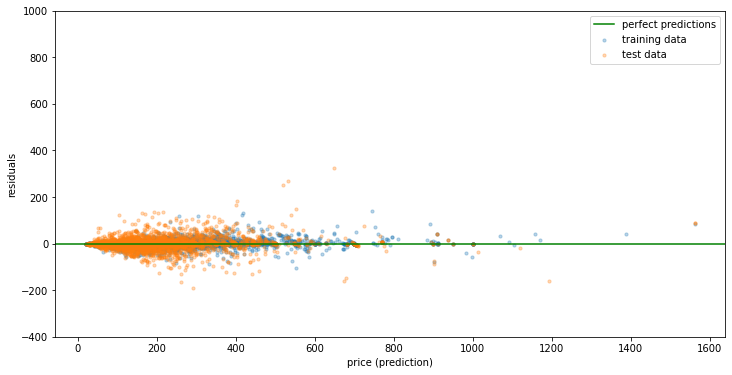

In [118]:
plt.figure(figsize=(12,6))
plt.scatter(y_pred_train, y_train.reshape((X_train.shape[0], 1))-y_pred_train, s=10, alpha=0.3, label='training data')
plt.scatter(y_pred_test, y_test.reshape((X_test.shape[0], 1))-y_pred_test, s=10, alpha=0.3, label='test data')
plt.axhline(c='g', label='perfect predictions')
plt.xlabel("price (prediction)")
plt.ylabel("residuals")
plt.ylim(-400, 1000)
plt.legend()

It shows that the random forest predicts price very well even in high price range. Instead it can be seen that the model is slightly overfitting in lower price range.

### XGBoost

I used popular XGBoost regression algorithm as well. I used several parameter settings but it worked best with no special regularization. 

XGBoost offers squared log error as loss function. It is mean squared error after log transforming the target variable, and hence it estimates error in higher price range smaller. As a result it is more robust to outliers compared to MSE.

#### Cross validation

In [ ]:
kfold = KFold(n_splits=3).split(X_train, y_train) 
best_iterations_list = []
mae = []
mape = []
r2 = []
for i, (train, valid) in enumerate(kfold):
    xgb = XGBRegressor(n_estimators=20000, max_depth=7, min_child_weight=0, subsample=1., colsample_bytree=1., 
                     learning_rate=.005, gamma=0, reg_lambda=0, verbosity=1, random_state=42, n_jobs=-1, 
                     objective='reg:squaredlogerror')
    eval_set = [(X_train.values[train], y_train[train]), (X_train.values[valid], y_train[valid])]
    xgb.fit(X_train.values[train], y_train[train], early_stopping_rounds=100, eval_set=eval_set)
    
    best_iteration = xgb.get_booster().best_ntree_limit
    best_iterations_list.append(best_iteration)
    
    y_pred_valid = xgb.predict(X_train.values[valid], ntree_limit=best_iteration)
    
    mae_valid = np.sqrt(mean_absolute_error(y_train[valid], y_pred_valid))
    mape_valid = mean_absolute_percentage_error(y_train[valid], y_pred_valid)
    r2_valid = r2_score(y_train[valid], y_pred_valid)
    
    mae.append(mae_valid)
    mape.append(mape_valid)
    r2.append(r2_valid)
    print(f"Fold {i} - MAPE: {mape_valid: .3f}")

[0]	validation_0-rmsle:4.38099	validation_1-rmsle:4.38189
[1]	validation_0-rmsle:4.37698	validation_1-rmsle:4.37787
[2]	validation_0-rmsle:4.37296	validation_1-rmsle:4.37386
[3]	validation_0-rmsle:4.36895	validation_1-rmsle:4.36984
[4]	validation_0-rmsle:4.36493	validation_1-rmsle:4.36583
[5]	validation_0-rmsle:4.36091	validation_1-rmsle:4.36181
[6]	validation_0-rmsle:4.35690	validation_1-rmsle:4.35780
[7]	validation_0-rmsle:4.35288	validation_1-rmsle:4.35379
[8]	validation_0-rmsle:4.34887	validation_1-rmsle:4.34977
[9]	validation_0-rmsle:4.34486	validation_1-rmsle:4.34576
[10]	validation_0-rmsle:4.34085	validation_1-rmsle:4.34175
[11]	validation_0-rmsle:4.33684	validation_1-rmsle:4.33774
[12]	validation_0-rmsle:4.33283	validation_1-rmsle:4.33373
[13]	validation_0-rmsle:4.32882	validation_1-rmsle:4.32972
[14]	validation_0-rmsle:4.32481	validation_1-rmsle:4.32572
[15]	validation_0-rmsle:4.32080	validation_1-rmsle:4.32171
[16]	validation_0-rmsle:4.31679	validation_1-rmsle:4.31770
[17]	va

[139]	validation_0-rmsle:3.83019	validation_1-rmsle:3.83120
[140]	validation_0-rmsle:3.82628	validation_1-rmsle:3.82730
[141]	validation_0-rmsle:3.82238	validation_1-rmsle:3.82340
[142]	validation_0-rmsle:3.81848	validation_1-rmsle:3.81950
[143]	validation_0-rmsle:3.81458	validation_1-rmsle:3.81560
[144]	validation_0-rmsle:3.81068	validation_1-rmsle:3.81170
[145]	validation_0-rmsle:3.80679	validation_1-rmsle:3.80781
[146]	validation_0-rmsle:3.80289	validation_1-rmsle:3.80391
[147]	validation_0-rmsle:3.79900	validation_1-rmsle:3.80002
[148]	validation_0-rmsle:3.79510	validation_1-rmsle:3.79612
[149]	validation_0-rmsle:3.79120	validation_1-rmsle:3.79223
[150]	validation_0-rmsle:3.78731	validation_1-rmsle:3.78834
[151]	validation_0-rmsle:3.78342	validation_1-rmsle:3.78444
[152]	validation_0-rmsle:3.77953	validation_1-rmsle:3.78056
[153]	validation_0-rmsle:3.77564	validation_1-rmsle:3.77666
[154]	validation_0-rmsle:3.77175	validation_1-rmsle:3.77278
[155]	validation_0-rmsle:3.76786	validat

[276]	validation_0-rmsle:3.30471	validation_1-rmsle:3.30588
[277]	validation_0-rmsle:3.30095	validation_1-rmsle:3.30212
[278]	validation_0-rmsle:3.29719	validation_1-rmsle:3.29835
[279]	validation_0-rmsle:3.29343	validation_1-rmsle:3.29460
[280]	validation_0-rmsle:3.28967	validation_1-rmsle:3.29084
[281]	validation_0-rmsle:3.28591	validation_1-rmsle:3.28708
[282]	validation_0-rmsle:3.28215	validation_1-rmsle:3.28333
[283]	validation_0-rmsle:3.27840	validation_1-rmsle:3.27957
[284]	validation_0-rmsle:3.27464	validation_1-rmsle:3.27582
[285]	validation_0-rmsle:3.27089	validation_1-rmsle:3.27206
[286]	validation_0-rmsle:3.26713	validation_1-rmsle:3.26831
[287]	validation_0-rmsle:3.26338	validation_1-rmsle:3.26456
[288]	validation_0-rmsle:3.25963	validation_1-rmsle:3.26081
[289]	validation_0-rmsle:3.25588	validation_1-rmsle:3.25706
[290]	validation_0-rmsle:3.25213	validation_1-rmsle:3.25332
[291]	validation_0-rmsle:3.24839	validation_1-rmsle:3.24957
[292]	validation_0-rmsle:3.24464	validat

[413]	validation_0-rmsle:2.80045	validation_1-rmsle:2.80181
[414]	validation_0-rmsle:2.79686	validation_1-rmsle:2.79822
[415]	validation_0-rmsle:2.79327	validation_1-rmsle:2.79463
[416]	validation_0-rmsle:2.78968	validation_1-rmsle:2.79104
[417]	validation_0-rmsle:2.78609	validation_1-rmsle:2.78746
[418]	validation_0-rmsle:2.78251	validation_1-rmsle:2.78388
[419]	validation_0-rmsle:2.77892	validation_1-rmsle:2.78029
[420]	validation_0-rmsle:2.77534	validation_1-rmsle:2.77671
[421]	validation_0-rmsle:2.77176	validation_1-rmsle:2.77313
[422]	validation_0-rmsle:2.76818	validation_1-rmsle:2.76955
[423]	validation_0-rmsle:2.76460	validation_1-rmsle:2.76598
[424]	validation_0-rmsle:2.76102	validation_1-rmsle:2.76240
[425]	validation_0-rmsle:2.75745	validation_1-rmsle:2.75883
[426]	validation_0-rmsle:2.75387	validation_1-rmsle:2.75526
[427]	validation_0-rmsle:2.75030	validation_1-rmsle:2.75169
[428]	validation_0-rmsle:2.74673	validation_1-rmsle:2.74811
[429]	validation_0-rmsle:2.74316	validat

[550]	validation_0-rmsle:2.32244	validation_1-rmsle:2.32406
[551]	validation_0-rmsle:2.31907	validation_1-rmsle:2.32069
[552]	validation_0-rmsle:2.31569	validation_1-rmsle:2.31731
[553]	validation_0-rmsle:2.31232	validation_1-rmsle:2.31394
[554]	validation_0-rmsle:2.30894	validation_1-rmsle:2.31057
[555]	validation_0-rmsle:2.30557	validation_1-rmsle:2.30720
[556]	validation_0-rmsle:2.30220	validation_1-rmsle:2.30383
[557]	validation_0-rmsle:2.29884	validation_1-rmsle:2.30047
[558]	validation_0-rmsle:2.29547	validation_1-rmsle:2.29710
[559]	validation_0-rmsle:2.29211	validation_1-rmsle:2.29374
[560]	validation_0-rmsle:2.28875	validation_1-rmsle:2.29039
[561]	validation_0-rmsle:2.28539	validation_1-rmsle:2.28703
[562]	validation_0-rmsle:2.28203	validation_1-rmsle:2.28367
[563]	validation_0-rmsle:2.27867	validation_1-rmsle:2.28032
[564]	validation_0-rmsle:2.27532	validation_1-rmsle:2.27696
[565]	validation_0-rmsle:2.27197	validation_1-rmsle:2.27361
[566]	validation_0-rmsle:2.26861	validat

[687]	validation_0-rmsle:1.87716	validation_1-rmsle:1.87916
[688]	validation_0-rmsle:1.87404	validation_1-rmsle:1.87605
[689]	validation_0-rmsle:1.87094	validation_1-rmsle:1.87294
[690]	validation_0-rmsle:1.86783	validation_1-rmsle:1.86984
[691]	validation_0-rmsle:1.86472	validation_1-rmsle:1.86674
[692]	validation_0-rmsle:1.86162	validation_1-rmsle:1.86364
[693]	validation_0-rmsle:1.85852	validation_1-rmsle:1.86054
[694]	validation_0-rmsle:1.85542	validation_1-rmsle:1.85745
[695]	validation_0-rmsle:1.85232	validation_1-rmsle:1.85435
[696]	validation_0-rmsle:1.84923	validation_1-rmsle:1.85126
[697]	validation_0-rmsle:1.84614	validation_1-rmsle:1.84818
[698]	validation_0-rmsle:1.84305	validation_1-rmsle:1.84509
[699]	validation_0-rmsle:1.83996	validation_1-rmsle:1.84201
[700]	validation_0-rmsle:1.83688	validation_1-rmsle:1.83892
[701]	validation_0-rmsle:1.83380	validation_1-rmsle:1.83584
[702]	validation_0-rmsle:1.83071	validation_1-rmsle:1.83277
[703]	validation_0-rmsle:1.82763	validat

[824]	validation_0-rmsle:1.47255	validation_1-rmsle:1.47512
[825]	validation_0-rmsle:1.46976	validation_1-rmsle:1.47235
[826]	validation_0-rmsle:1.46699	validation_1-rmsle:1.46957
[827]	validation_0-rmsle:1.46421	validation_1-rmsle:1.46680
[828]	validation_0-rmsle:1.46144	validation_1-rmsle:1.46403
[829]	validation_0-rmsle:1.45867	validation_1-rmsle:1.46127
[830]	validation_0-rmsle:1.45590	validation_1-rmsle:1.45850
[831]	validation_0-rmsle:1.45313	validation_1-rmsle:1.45574
[832]	validation_0-rmsle:1.45037	validation_1-rmsle:1.45299
[833]	validation_0-rmsle:1.44761	validation_1-rmsle:1.45023
[834]	validation_0-rmsle:1.44485	validation_1-rmsle:1.44748
[835]	validation_0-rmsle:1.44210	validation_1-rmsle:1.44473
[836]	validation_0-rmsle:1.43935	validation_1-rmsle:1.44198
[837]	validation_0-rmsle:1.43660	validation_1-rmsle:1.43924
[838]	validation_0-rmsle:1.43385	validation_1-rmsle:1.43650
[839]	validation_0-rmsle:1.43111	validation_1-rmsle:1.43376
[840]	validation_0-rmsle:1.42836	validat

[961]	validation_0-rmsle:1.11796	validation_1-rmsle:1.12137
[962]	validation_0-rmsle:1.11558	validation_1-rmsle:1.11900
[963]	validation_0-rmsle:1.11320	validation_1-rmsle:1.11663
[964]	validation_0-rmsle:1.11083	validation_1-rmsle:1.11426
[965]	validation_0-rmsle:1.10846	validation_1-rmsle:1.11190
[966]	validation_0-rmsle:1.10609	validation_1-rmsle:1.10954
[967]	validation_0-rmsle:1.10373	validation_1-rmsle:1.10718
[968]	validation_0-rmsle:1.10137	validation_1-rmsle:1.10483
[969]	validation_0-rmsle:1.09901	validation_1-rmsle:1.10248
[970]	validation_0-rmsle:1.09666	validation_1-rmsle:1.10013
[971]	validation_0-rmsle:1.09431	validation_1-rmsle:1.09779
[972]	validation_0-rmsle:1.09196	validation_1-rmsle:1.09545
[973]	validation_0-rmsle:1.08961	validation_1-rmsle:1.09311
[974]	validation_0-rmsle:1.08727	validation_1-rmsle:1.09077
[975]	validation_0-rmsle:1.08493	validation_1-rmsle:1.08844
[976]	validation_0-rmsle:1.08260	validation_1-rmsle:1.08612
[977]	validation_0-rmsle:1.08027	validat

[1096]	validation_0-rmsle:0.82702	validation_1-rmsle:0.83125
[1097]	validation_0-rmsle:0.82510	validation_1-rmsle:0.82933
[1098]	validation_0-rmsle:0.82319	validation_1-rmsle:0.82742
[1099]	validation_0-rmsle:0.82127	validation_1-rmsle:0.82552
[1100]	validation_0-rmsle:0.81937	validation_1-rmsle:0.82362
[1101]	validation_0-rmsle:0.81746	validation_1-rmsle:0.82172
[1102]	validation_0-rmsle:0.81556	validation_1-rmsle:0.81983
[1103]	validation_0-rmsle:0.81366	validation_1-rmsle:0.81794
[1104]	validation_0-rmsle:0.81177	validation_1-rmsle:0.81605
[1105]	validation_0-rmsle:0.80988	validation_1-rmsle:0.81417
[1106]	validation_0-rmsle:0.80800	validation_1-rmsle:0.81229
[1107]	validation_0-rmsle:0.80612	validation_1-rmsle:0.81041
[1108]	validation_0-rmsle:0.80424	validation_1-rmsle:0.80854
[1109]	validation_0-rmsle:0.80236	validation_1-rmsle:0.80667
[1110]	validation_0-rmsle:0.80049	validation_1-rmsle:0.80480
[1111]	validation_0-rmsle:0.79862	validation_1-rmsle:0.80294
[1112]	validation_0-rmsl

[1231]	validation_0-rmsle:0.60072	validation_1-rmsle:0.60591
[1232]	validation_0-rmsle:0.59930	validation_1-rmsle:0.60449
[1233]	validation_0-rmsle:0.59788	validation_1-rmsle:0.60307
[1234]	validation_0-rmsle:0.59646	validation_1-rmsle:0.60166
[1235]	validation_0-rmsle:0.59505	validation_1-rmsle:0.60025
[1236]	validation_0-rmsle:0.59364	validation_1-rmsle:0.59885
[1237]	validation_0-rmsle:0.59223	validation_1-rmsle:0.59745
[1238]	validation_0-rmsle:0.59083	validation_1-rmsle:0.59605
[1239]	validation_0-rmsle:0.58943	validation_1-rmsle:0.59466
[1240]	validation_0-rmsle:0.58803	validation_1-rmsle:0.59327
[1241]	validation_0-rmsle:0.58664	validation_1-rmsle:0.59189
[1242]	validation_0-rmsle:0.58525	validation_1-rmsle:0.59050
[1243]	validation_0-rmsle:0.58387	validation_1-rmsle:0.58913
[1244]	validation_0-rmsle:0.58249	validation_1-rmsle:0.58775
[1245]	validation_0-rmsle:0.58111	validation_1-rmsle:0.58638
[1246]	validation_0-rmsle:0.57974	validation_1-rmsle:0.58502
[1247]	validation_0-rmsl

[1366]	validation_0-rmsle:0.44048	validation_1-rmsle:0.44632
[1367]	validation_0-rmsle:0.43952	validation_1-rmsle:0.44538
[1368]	validation_0-rmsle:0.43857	validation_1-rmsle:0.44445
[1369]	validation_0-rmsle:0.43762	validation_1-rmsle:0.44351
[1370]	validation_0-rmsle:0.43667	validation_1-rmsle:0.44258
[1371]	validation_0-rmsle:0.43573	validation_1-rmsle:0.44165
[1372]	validation_0-rmsle:0.43479	validation_1-rmsle:0.44073
[1373]	validation_0-rmsle:0.43386	validation_1-rmsle:0.43981
[1374]	validation_0-rmsle:0.43293	validation_1-rmsle:0.43889
[1375]	validation_0-rmsle:0.43200	validation_1-rmsle:0.43798
[1376]	validation_0-rmsle:0.43108	validation_1-rmsle:0.43706
[1377]	validation_0-rmsle:0.43016	validation_1-rmsle:0.43616
[1378]	validation_0-rmsle:0.42923	validation_1-rmsle:0.43524
[1379]	validation_0-rmsle:0.42832	validation_1-rmsle:0.43434
[1380]	validation_0-rmsle:0.42740	validation_1-rmsle:0.43344
[1381]	validation_0-rmsle:0.42649	validation_1-rmsle:0.43254
[1382]	validation_0-rmsl

[1501]	validation_0-rmsle:0.33824	validation_1-rmsle:0.34606
[1502]	validation_0-rmsle:0.33766	validation_1-rmsle:0.34548
[1503]	validation_0-rmsle:0.33709	validation_1-rmsle:0.34493
[1504]	validation_0-rmsle:0.33651	validation_1-rmsle:0.34435
[1505]	validation_0-rmsle:0.33594	validation_1-rmsle:0.34379
[1506]	validation_0-rmsle:0.33537	validation_1-rmsle:0.34324
[1507]	validation_0-rmsle:0.33481	validation_1-rmsle:0.34269
[1508]	validation_0-rmsle:0.33425	validation_1-rmsle:0.34214
[1509]	validation_0-rmsle:0.33369	validation_1-rmsle:0.34160
[1510]	validation_0-rmsle:0.33312	validation_1-rmsle:0.34102
[1511]	validation_0-rmsle:0.33256	validation_1-rmsle:0.34048
[1512]	validation_0-rmsle:0.33202	validation_1-rmsle:0.33994
[1513]	validation_0-rmsle:0.33145	validation_1-rmsle:0.33938
[1514]	validation_0-rmsle:0.33090	validation_1-rmsle:0.33885
[1515]	validation_0-rmsle:0.33036	validation_1-rmsle:0.33831
[1516]	validation_0-rmsle:0.32981	validation_1-rmsle:0.33777
[1517]	validation_0-rmsl

[1636]	validation_0-rmsle:0.27808	validation_1-rmsle:0.28718
[1637]	validation_0-rmsle:0.27774	validation_1-rmsle:0.28685
[1638]	validation_0-rmsle:0.27739	validation_1-rmsle:0.28652
[1639]	validation_0-rmsle:0.27705	validation_1-rmsle:0.28619
[1640]	validation_0-rmsle:0.27670	validation_1-rmsle:0.28585
[1641]	validation_0-rmsle:0.27636	validation_1-rmsle:0.28552
[1642]	validation_0-rmsle:0.27604	validation_1-rmsle:0.28520
[1643]	validation_0-rmsle:0.27569	validation_1-rmsle:0.28487
[1644]	validation_0-rmsle:0.27537	validation_1-rmsle:0.28457
[1645]	validation_0-rmsle:0.27505	validation_1-rmsle:0.28426
[1646]	validation_0-rmsle:0.27471	validation_1-rmsle:0.28392
[1647]	validation_0-rmsle:0.27440	validation_1-rmsle:0.28363
[1648]	validation_0-rmsle:0.27406	validation_1-rmsle:0.28329
[1649]	validation_0-rmsle:0.27375	validation_1-rmsle:0.28298
[1650]	validation_0-rmsle:0.27344	validation_1-rmsle:0.28269
[1651]	validation_0-rmsle:0.27312	validation_1-rmsle:0.28237
[1652]	validation_0-rmsl

[1771]	validation_0-rmsle:0.24186	validation_1-rmsle:0.25310
[1772]	validation_0-rmsle:0.24165	validation_1-rmsle:0.25290
[1773]	validation_0-rmsle:0.24144	validation_1-rmsle:0.25271
[1774]	validation_0-rmsle:0.24121	validation_1-rmsle:0.25250
[1775]	validation_0-rmsle:0.24099	validation_1-rmsle:0.25229
[1776]	validation_0-rmsle:0.24080	validation_1-rmsle:0.25211
[1777]	validation_0-rmsle:0.24059	validation_1-rmsle:0.25192
[1778]	validation_0-rmsle:0.24041	validation_1-rmsle:0.25174
[1779]	validation_0-rmsle:0.24020	validation_1-rmsle:0.25156
[1780]	validation_0-rmsle:0.24000	validation_1-rmsle:0.25137
[1781]	validation_0-rmsle:0.23979	validation_1-rmsle:0.25116
[1782]	validation_0-rmsle:0.23959	validation_1-rmsle:0.25099
[1783]	validation_0-rmsle:0.23940	validation_1-rmsle:0.25080
[1784]	validation_0-rmsle:0.23919	validation_1-rmsle:0.25061
[1785]	validation_0-rmsle:0.23897	validation_1-rmsle:0.25041
[1786]	validation_0-rmsle:0.23875	validation_1-rmsle:0.25021
[1787]	validation_0-rmsl

[1906]	validation_0-rmsle:0.21953	validation_1-rmsle:0.23307
[1907]	validation_0-rmsle:0.21938	validation_1-rmsle:0.23295
[1908]	validation_0-rmsle:0.21927	validation_1-rmsle:0.23286
[1909]	validation_0-rmsle:0.21914	validation_1-rmsle:0.23275
[1910]	validation_0-rmsle:0.21900	validation_1-rmsle:0.23262
[1911]	validation_0-rmsle:0.21889	validation_1-rmsle:0.23254
[1912]	validation_0-rmsle:0.21877	validation_1-rmsle:0.23244
[1913]	validation_0-rmsle:0.21863	validation_1-rmsle:0.23232
[1914]	validation_0-rmsle:0.21852	validation_1-rmsle:0.23223
[1915]	validation_0-rmsle:0.21840	validation_1-rmsle:0.23212
[1916]	validation_0-rmsle:0.21828	validation_1-rmsle:0.23201
[1917]	validation_0-rmsle:0.21816	validation_1-rmsle:0.23190
[1918]	validation_0-rmsle:0.21804	validation_1-rmsle:0.23182
[1919]	validation_0-rmsle:0.21793	validation_1-rmsle:0.23171
[1920]	validation_0-rmsle:0.21782	validation_1-rmsle:0.23162
[1921]	validation_0-rmsle:0.21770	validation_1-rmsle:0.23151
[1922]	validation_0-rmsl

[2041]	validation_0-rmsle:0.20561	validation_1-rmsle:0.22128
[2042]	validation_0-rmsle:0.20551	validation_1-rmsle:0.22119
[2043]	validation_0-rmsle:0.20544	validation_1-rmsle:0.22113
[2044]	validation_0-rmsle:0.20534	validation_1-rmsle:0.22103
[2045]	validation_0-rmsle:0.20526	validation_1-rmsle:0.22097
[2046]	validation_0-rmsle:0.20519	validation_1-rmsle:0.22091
[2047]	validation_0-rmsle:0.20512	validation_1-rmsle:0.22086
[2048]	validation_0-rmsle:0.20502	validation_1-rmsle:0.22076
[2049]	validation_0-rmsle:0.20492	validation_1-rmsle:0.22068
[2050]	validation_0-rmsle:0.20482	validation_1-rmsle:0.22058
[2051]	validation_0-rmsle:0.20473	validation_1-rmsle:0.22051
[2052]	validation_0-rmsle:0.20466	validation_1-rmsle:0.22045
[2053]	validation_0-rmsle:0.20457	validation_1-rmsle:0.22035
[2054]	validation_0-rmsle:0.20447	validation_1-rmsle:0.22026
[2055]	validation_0-rmsle:0.20438	validation_1-rmsle:0.22018
[2056]	validation_0-rmsle:0.20431	validation_1-rmsle:0.22013
[2057]	validation_0-rmsl

[2176]	validation_0-rmsle:0.19567	validation_1-rmsle:0.21272
[2177]	validation_0-rmsle:0.19559	validation_1-rmsle:0.21264
[2178]	validation_0-rmsle:0.19556	validation_1-rmsle:0.21262
[2179]	validation_0-rmsle:0.19551	validation_1-rmsle:0.21258
[2180]	validation_0-rmsle:0.19546	validation_1-rmsle:0.21255
[2181]	validation_0-rmsle:0.19542	validation_1-rmsle:0.21252
[2182]	validation_0-rmsle:0.19537	validation_1-rmsle:0.21249
[2183]	validation_0-rmsle:0.19532	validation_1-rmsle:0.21245
[2184]	validation_0-rmsle:0.19525	validation_1-rmsle:0.21238
[2185]	validation_0-rmsle:0.19520	validation_1-rmsle:0.21236
[2186]	validation_0-rmsle:0.19517	validation_1-rmsle:0.21234
[2187]	validation_0-rmsle:0.19513	validation_1-rmsle:0.21231
[2188]	validation_0-rmsle:0.19509	validation_1-rmsle:0.21228
[2189]	validation_0-rmsle:0.19503	validation_1-rmsle:0.21222
[2190]	validation_0-rmsle:0.19499	validation_1-rmsle:0.21219
[2191]	validation_0-rmsle:0.19495	validation_1-rmsle:0.21216
[2192]	validation_0-rmsl

[2311]	validation_0-rmsle:0.18923	validation_1-rmsle:0.20744
[2312]	validation_0-rmsle:0.18918	validation_1-rmsle:0.20739
[2313]	validation_0-rmsle:0.18911	validation_1-rmsle:0.20733
[2314]	validation_0-rmsle:0.18906	validation_1-rmsle:0.20729
[2315]	validation_0-rmsle:0.18904	validation_1-rmsle:0.20727
[2316]	validation_0-rmsle:0.18897	validation_1-rmsle:0.20720
[2317]	validation_0-rmsle:0.18893	validation_1-rmsle:0.20714
[2318]	validation_0-rmsle:0.18887	validation_1-rmsle:0.20711
[2319]	validation_0-rmsle:0.18881	validation_1-rmsle:0.20705
[2320]	validation_0-rmsle:0.18874	validation_1-rmsle:0.20698
[2321]	validation_0-rmsle:0.18868	validation_1-rmsle:0.20695
[2322]	validation_0-rmsle:0.18865	validation_1-rmsle:0.20690
[2323]	validation_0-rmsle:0.18859	validation_1-rmsle:0.20685
[2324]	validation_0-rmsle:0.18853	validation_1-rmsle:0.20682
[2325]	validation_0-rmsle:0.18851	validation_1-rmsle:0.20680
[2326]	validation_0-rmsle:0.18848	validation_1-rmsle:0.20678
[2327]	validation_0-rmsl

[2446]	validation_0-rmsle:0.18365	validation_1-rmsle:0.20251
[2447]	validation_0-rmsle:0.18361	validation_1-rmsle:0.20247
[2448]	validation_0-rmsle:0.18359	validation_1-rmsle:0.20245
[2449]	validation_0-rmsle:0.18357	validation_1-rmsle:0.20242
[2450]	validation_0-rmsle:0.18352	validation_1-rmsle:0.20239
[2451]	validation_0-rmsle:0.18348	validation_1-rmsle:0.20235
[2452]	validation_0-rmsle:0.18346	validation_1-rmsle:0.20233
[2453]	validation_0-rmsle:0.18341	validation_1-rmsle:0.20228
[2454]	validation_0-rmsle:0.18338	validation_1-rmsle:0.20224
[2455]	validation_0-rmsle:0.18332	validation_1-rmsle:0.20220
[2456]	validation_0-rmsle:0.18330	validation_1-rmsle:0.20219
[2457]	validation_0-rmsle:0.18327	validation_1-rmsle:0.20218
[2458]	validation_0-rmsle:0.18325	validation_1-rmsle:0.20216
[2459]	validation_0-rmsle:0.18320	validation_1-rmsle:0.20211
[2460]	validation_0-rmsle:0.18316	validation_1-rmsle:0.20208
[2461]	validation_0-rmsle:0.18313	validation_1-rmsle:0.20204
[2462]	validation_0-rmsl

[2581]	validation_0-rmsle:0.17936	validation_1-rmsle:0.19879
[2582]	validation_0-rmsle:0.17933	validation_1-rmsle:0.19876
[2583]	validation_0-rmsle:0.17932	validation_1-rmsle:0.19875
[2584]	validation_0-rmsle:0.17929	validation_1-rmsle:0.19872
[2585]	validation_0-rmsle:0.17925	validation_1-rmsle:0.19869
[2586]	validation_0-rmsle:0.17924	validation_1-rmsle:0.19867
[2587]	validation_0-rmsle:0.17920	validation_1-rmsle:0.19865
[2588]	validation_0-rmsle:0.17916	validation_1-rmsle:0.19862
[2589]	validation_0-rmsle:0.17913	validation_1-rmsle:0.19858
[2590]	validation_0-rmsle:0.17910	validation_1-rmsle:0.19856
[2591]	validation_0-rmsle:0.17905	validation_1-rmsle:0.19852
[2592]	validation_0-rmsle:0.17898	validation_1-rmsle:0.19847
[2593]	validation_0-rmsle:0.17895	validation_1-rmsle:0.19843
[2594]	validation_0-rmsle:0.17894	validation_1-rmsle:0.19842
[2595]	validation_0-rmsle:0.17890	validation_1-rmsle:0.19838
[2596]	validation_0-rmsle:0.17886	validation_1-rmsle:0.19833
[2597]	validation_0-rmsl

[2716]	validation_0-rmsle:0.17508	validation_1-rmsle:0.19507
[2717]	validation_0-rmsle:0.17506	validation_1-rmsle:0.19506
[2718]	validation_0-rmsle:0.17501	validation_1-rmsle:0.19502
[2719]	validation_0-rmsle:0.17499	validation_1-rmsle:0.19499
[2720]	validation_0-rmsle:0.17495	validation_1-rmsle:0.19495
[2721]	validation_0-rmsle:0.17492	validation_1-rmsle:0.19492
[2722]	validation_0-rmsle:0.17490	validation_1-rmsle:0.19492
[2723]	validation_0-rmsle:0.17488	validation_1-rmsle:0.19490
[2724]	validation_0-rmsle:0.17482	validation_1-rmsle:0.19485
[2725]	validation_0-rmsle:0.17478	validation_1-rmsle:0.19482
[2726]	validation_0-rmsle:0.17478	validation_1-rmsle:0.19482
[2727]	validation_0-rmsle:0.17475	validation_1-rmsle:0.19480
[2728]	validation_0-rmsle:0.17471	validation_1-rmsle:0.19476
[2729]	validation_0-rmsle:0.17470	validation_1-rmsle:0.19475
[2730]	validation_0-rmsle:0.17467	validation_1-rmsle:0.19472
[2731]	validation_0-rmsle:0.17466	validation_1-rmsle:0.19471
[2732]	validation_0-rmsl

[2851]	validation_0-rmsle:0.17180	validation_1-rmsle:0.19225
[2852]	validation_0-rmsle:0.17175	validation_1-rmsle:0.19219
[2853]	validation_0-rmsle:0.17174	validation_1-rmsle:0.19219
[2854]	validation_0-rmsle:0.17168	validation_1-rmsle:0.19214
[2855]	validation_0-rmsle:0.17166	validation_1-rmsle:0.19212
[2856]	validation_0-rmsle:0.17166	validation_1-rmsle:0.19211
[2857]	validation_0-rmsle:0.17165	validation_1-rmsle:0.19211
[2858]	validation_0-rmsle:0.17162	validation_1-rmsle:0.19208
[2859]	validation_0-rmsle:0.17156	validation_1-rmsle:0.19203
[2860]	validation_0-rmsle:0.17150	validation_1-rmsle:0.19198
[2861]	validation_0-rmsle:0.17148	validation_1-rmsle:0.19196
[2862]	validation_0-rmsle:0.17147	validation_1-rmsle:0.19195
[2863]	validation_0-rmsle:0.17147	validation_1-rmsle:0.19195
[2864]	validation_0-rmsle:0.17141	validation_1-rmsle:0.19190
[2865]	validation_0-rmsle:0.17139	validation_1-rmsle:0.19189
[2866]	validation_0-rmsle:0.17138	validation_1-rmsle:0.19188
[2867]	validation_0-rmsl

[2986]	validation_0-rmsle:0.16811	validation_1-rmsle:0.18918
[2987]	validation_0-rmsle:0.16810	validation_1-rmsle:0.18919
[2988]	validation_0-rmsle:0.16809	validation_1-rmsle:0.18918
[2989]	validation_0-rmsle:0.16805	validation_1-rmsle:0.18915
[2990]	validation_0-rmsle:0.16802	validation_1-rmsle:0.18912
[2991]	validation_0-rmsle:0.16799	validation_1-rmsle:0.18910
[2992]	validation_0-rmsle:0.16794	validation_1-rmsle:0.18905
[2993]	validation_0-rmsle:0.16793	validation_1-rmsle:0.18904
[2994]	validation_0-rmsle:0.16792	validation_1-rmsle:0.18903
[2995]	validation_0-rmsle:0.16789	validation_1-rmsle:0.18900
[2996]	validation_0-rmsle:0.16788	validation_1-rmsle:0.18900
[2997]	validation_0-rmsle:0.16786	validation_1-rmsle:0.18898
[2998]	validation_0-rmsle:0.16784	validation_1-rmsle:0.18899
[2999]	validation_0-rmsle:0.16781	validation_1-rmsle:0.18897
[3000]	validation_0-rmsle:0.16776	validation_1-rmsle:0.18894
[3001]	validation_0-rmsle:0.16775	validation_1-rmsle:0.18893
[3002]	validation_0-rmsl

[3121]	validation_0-rmsle:0.16495	validation_1-rmsle:0.18649
[3122]	validation_0-rmsle:0.16491	validation_1-rmsle:0.18646
[3123]	validation_0-rmsle:0.16488	validation_1-rmsle:0.18643
[3124]	validation_0-rmsle:0.16486	validation_1-rmsle:0.18641
[3125]	validation_0-rmsle:0.16485	validation_1-rmsle:0.18640
[3126]	validation_0-rmsle:0.16484	validation_1-rmsle:0.18639
[3127]	validation_0-rmsle:0.16481	validation_1-rmsle:0.18637
[3128]	validation_0-rmsle:0.16476	validation_1-rmsle:0.18635
[3129]	validation_0-rmsle:0.16475	validation_1-rmsle:0.18632
[3130]	validation_0-rmsle:0.16473	validation_1-rmsle:0.18630
[3131]	validation_0-rmsle:0.16472	validation_1-rmsle:0.18630
[3132]	validation_0-rmsle:0.16469	validation_1-rmsle:0.18627
[3133]	validation_0-rmsle:0.16467	validation_1-rmsle:0.18625
[3134]	validation_0-rmsle:0.16466	validation_1-rmsle:0.18624
[3135]	validation_0-rmsle:0.16465	validation_1-rmsle:0.18624
[3136]	validation_0-rmsle:0.16464	validation_1-rmsle:0.18622
[3137]	validation_0-rmsl

[3256]	validation_0-rmsle:0.16205	validation_1-rmsle:0.18404
[3257]	validation_0-rmsle:0.16205	validation_1-rmsle:0.18403
[3258]	validation_0-rmsle:0.16201	validation_1-rmsle:0.18400
[3259]	validation_0-rmsle:0.16199	validation_1-rmsle:0.18399
[3260]	validation_0-rmsle:0.16198	validation_1-rmsle:0.18397
[3261]	validation_0-rmsle:0.16195	validation_1-rmsle:0.18395
[3262]	validation_0-rmsle:0.16195	validation_1-rmsle:0.18395
[3263]	validation_0-rmsle:0.16194	validation_1-rmsle:0.18394
[3264]	validation_0-rmsle:0.16192	validation_1-rmsle:0.18392
[3265]	validation_0-rmsle:0.16188	validation_1-rmsle:0.18389
[3266]	validation_0-rmsle:0.16186	validation_1-rmsle:0.18387
[3267]	validation_0-rmsle:0.16185	validation_1-rmsle:0.18386
[3268]	validation_0-rmsle:0.16183	validation_1-rmsle:0.18385
[3269]	validation_0-rmsle:0.16182	validation_1-rmsle:0.18384
[3270]	validation_0-rmsle:0.16181	validation_1-rmsle:0.18383
[3271]	validation_0-rmsle:0.16178	validation_1-rmsle:0.18381
[3272]	validation_0-rmsl

[3391]	validation_0-rmsle:0.15906	validation_1-rmsle:0.18132
[3392]	validation_0-rmsle:0.15901	validation_1-rmsle:0.18130
[3393]	validation_0-rmsle:0.15896	validation_1-rmsle:0.18125
[3394]	validation_0-rmsle:0.15893	validation_1-rmsle:0.18123
[3395]	validation_0-rmsle:0.15890	validation_1-rmsle:0.18120
[3396]	validation_0-rmsle:0.15887	validation_1-rmsle:0.18118
[3397]	validation_0-rmsle:0.15882	validation_1-rmsle:0.18114
[3398]	validation_0-rmsle:0.15879	validation_1-rmsle:0.18111
[3399]	validation_0-rmsle:0.15879	validation_1-rmsle:0.18110
[3400]	validation_0-rmsle:0.15877	validation_1-rmsle:0.18108
[3401]	validation_0-rmsle:0.15874	validation_1-rmsle:0.18105
[3402]	validation_0-rmsle:0.15871	validation_1-rmsle:0.18103
[3403]	validation_0-rmsle:0.15870	validation_1-rmsle:0.18101
[3404]	validation_0-rmsle:0.15869	validation_1-rmsle:0.18100
[3405]	validation_0-rmsle:0.15867	validation_1-rmsle:0.18099
[3406]	validation_0-rmsle:0.15864	validation_1-rmsle:0.18097
[3407]	validation_0-rmsl

[3526]	validation_0-rmsle:0.15559	validation_1-rmsle:0.17838
[3527]	validation_0-rmsle:0.15557	validation_1-rmsle:0.17835
[3528]	validation_0-rmsle:0.15554	validation_1-rmsle:0.17833
[3529]	validation_0-rmsle:0.15553	validation_1-rmsle:0.17832
[3530]	validation_0-rmsle:0.15550	validation_1-rmsle:0.17828
[3531]	validation_0-rmsle:0.15546	validation_1-rmsle:0.17826
[3532]	validation_0-rmsle:0.15543	validation_1-rmsle:0.17823
[3533]	validation_0-rmsle:0.15538	validation_1-rmsle:0.17819
[3534]	validation_0-rmsle:0.15534	validation_1-rmsle:0.17815
[3535]	validation_0-rmsle:0.15531	validation_1-rmsle:0.17813
[3536]	validation_0-rmsle:0.15530	validation_1-rmsle:0.17812
[3537]	validation_0-rmsle:0.15527	validation_1-rmsle:0.17809
[3538]	validation_0-rmsle:0.15523	validation_1-rmsle:0.17805
[3539]	validation_0-rmsle:0.15521	validation_1-rmsle:0.17804
[3540]	validation_0-rmsle:0.15521	validation_1-rmsle:0.17804
[3541]	validation_0-rmsle:0.15519	validation_1-rmsle:0.17803
[3542]	validation_0-rmsl

[3661]	validation_0-rmsle:0.15227	validation_1-rmsle:0.17555
[3662]	validation_0-rmsle:0.15225	validation_1-rmsle:0.17554
[3663]	validation_0-rmsle:0.15223	validation_1-rmsle:0.17553
[3664]	validation_0-rmsle:0.15222	validation_1-rmsle:0.17553
[3665]	validation_0-rmsle:0.15220	validation_1-rmsle:0.17551
[3666]	validation_0-rmsle:0.15219	validation_1-rmsle:0.17550
[3667]	validation_0-rmsle:0.15218	validation_1-rmsle:0.17549
[3668]	validation_0-rmsle:0.15214	validation_1-rmsle:0.17545
[3669]	validation_0-rmsle:0.15211	validation_1-rmsle:0.17543
[3670]	validation_0-rmsle:0.15206	validation_1-rmsle:0.17540
[3671]	validation_0-rmsle:0.15205	validation_1-rmsle:0.17540
[3672]	validation_0-rmsle:0.15205	validation_1-rmsle:0.17539
[3673]	validation_0-rmsle:0.15204	validation_1-rmsle:0.17538
[3674]	validation_0-rmsle:0.15201	validation_1-rmsle:0.17536
[3675]	validation_0-rmsle:0.15199	validation_1-rmsle:0.17534
[3676]	validation_0-rmsle:0.15197	validation_1-rmsle:0.17533
[3677]	validation_0-rmsl

[3796]	validation_0-rmsle:0.14918	validation_1-rmsle:0.17318
[3797]	validation_0-rmsle:0.14914	validation_1-rmsle:0.17314
[3798]	validation_0-rmsle:0.14913	validation_1-rmsle:0.17313
[3799]	validation_0-rmsle:0.14910	validation_1-rmsle:0.17312
[3800]	validation_0-rmsle:0.14906	validation_1-rmsle:0.17308
[3801]	validation_0-rmsle:0.14903	validation_1-rmsle:0.17306
[3802]	validation_0-rmsle:0.14899	validation_1-rmsle:0.17303
[3803]	validation_0-rmsle:0.14897	validation_1-rmsle:0.17301
[3804]	validation_0-rmsle:0.14894	validation_1-rmsle:0.17299
[3805]	validation_0-rmsle:0.14891	validation_1-rmsle:0.17297
[3806]	validation_0-rmsle:0.14890	validation_1-rmsle:0.17296
[3807]	validation_0-rmsle:0.14888	validation_1-rmsle:0.17295
[3808]	validation_0-rmsle:0.14885	validation_1-rmsle:0.17292
[3809]	validation_0-rmsle:0.14884	validation_1-rmsle:0.17291
[3810]	validation_0-rmsle:0.14883	validation_1-rmsle:0.17290
[3811]	validation_0-rmsle:0.14882	validation_1-rmsle:0.17289
[3812]	validation_0-rmsl

[3931]	validation_0-rmsle:0.14614	validation_1-rmsle:0.17055
[3932]	validation_0-rmsle:0.14613	validation_1-rmsle:0.17054
[3933]	validation_0-rmsle:0.14611	validation_1-rmsle:0.17052
[3934]	validation_0-rmsle:0.14608	validation_1-rmsle:0.17051
[3935]	validation_0-rmsle:0.14604	validation_1-rmsle:0.17047
[3936]	validation_0-rmsle:0.14603	validation_1-rmsle:0.17046
[3937]	validation_0-rmsle:0.14602	validation_1-rmsle:0.17045
[3938]	validation_0-rmsle:0.14600	validation_1-rmsle:0.17043
[3939]	validation_0-rmsle:0.14596	validation_1-rmsle:0.17041
[3940]	validation_0-rmsle:0.14593	validation_1-rmsle:0.17039
[3941]	validation_0-rmsle:0.14588	validation_1-rmsle:0.17034
[3942]	validation_0-rmsle:0.14588	validation_1-rmsle:0.17033
[3943]	validation_0-rmsle:0.14585	validation_1-rmsle:0.17030
[3944]	validation_0-rmsle:0.14580	validation_1-rmsle:0.17025
[3945]	validation_0-rmsle:0.14576	validation_1-rmsle:0.17023
[3946]	validation_0-rmsle:0.14573	validation_1-rmsle:0.17021
[3947]	validation_0-rmsl

[4066]	validation_0-rmsle:0.14289	validation_1-rmsle:0.16794
[4067]	validation_0-rmsle:0.14287	validation_1-rmsle:0.16793
[4068]	validation_0-rmsle:0.14284	validation_1-rmsle:0.16791
[4069]	validation_0-rmsle:0.14283	validation_1-rmsle:0.16789
[4070]	validation_0-rmsle:0.14281	validation_1-rmsle:0.16788
[4071]	validation_0-rmsle:0.14280	validation_1-rmsle:0.16787
[4072]	validation_0-rmsle:0.14276	validation_1-rmsle:0.16785
[4073]	validation_0-rmsle:0.14273	validation_1-rmsle:0.16783
[4074]	validation_0-rmsle:0.14270	validation_1-rmsle:0.16780
[4075]	validation_0-rmsle:0.14269	validation_1-rmsle:0.16779
[4076]	validation_0-rmsle:0.14267	validation_1-rmsle:0.16777
[4077]	validation_0-rmsle:0.14265	validation_1-rmsle:0.16776
[4078]	validation_0-rmsle:0.14264	validation_1-rmsle:0.16776
[4079]	validation_0-rmsle:0.14261	validation_1-rmsle:0.16773
[4080]	validation_0-rmsle:0.14258	validation_1-rmsle:0.16770
[4081]	validation_0-rmsle:0.14253	validation_1-rmsle:0.16767
[4082]	validation_0-rmsl

[4201]	validation_0-rmsle:0.14019	validation_1-rmsle:0.16584
[4202]	validation_0-rmsle:0.14016	validation_1-rmsle:0.16582
[4203]	validation_0-rmsle:0.14015	validation_1-rmsle:0.16581
[4204]	validation_0-rmsle:0.14014	validation_1-rmsle:0.16580
[4205]	validation_0-rmsle:0.14012	validation_1-rmsle:0.16578
[4206]	validation_0-rmsle:0.14011	validation_1-rmsle:0.16578
[4207]	validation_0-rmsle:0.14009	validation_1-rmsle:0.16576
[4208]	validation_0-rmsle:0.14008	validation_1-rmsle:0.16574
[4209]	validation_0-rmsle:0.14006	validation_1-rmsle:0.16573
[4210]	validation_0-rmsle:0.14002	validation_1-rmsle:0.16570
[4211]	validation_0-rmsle:0.14002	validation_1-rmsle:0.16569
[4212]	validation_0-rmsle:0.14001	validation_1-rmsle:0.16568
[4213]	validation_0-rmsle:0.14000	validation_1-rmsle:0.16568
[4214]	validation_0-rmsle:0.13997	validation_1-rmsle:0.16566
[4215]	validation_0-rmsle:0.13995	validation_1-rmsle:0.16564
[4216]	validation_0-rmsle:0.13993	validation_1-rmsle:0.16563
[4217]	validation_0-rmsl

[4336]	validation_0-rmsle:0.13773	validation_1-rmsle:0.16375
[4337]	validation_0-rmsle:0.13772	validation_1-rmsle:0.16374
[4338]	validation_0-rmsle:0.13770	validation_1-rmsle:0.16372
[4339]	validation_0-rmsle:0.13769	validation_1-rmsle:0.16371
[4340]	validation_0-rmsle:0.13766	validation_1-rmsle:0.16368
[4341]	validation_0-rmsle:0.13764	validation_1-rmsle:0.16367
[4342]	validation_0-rmsle:0.13763	validation_1-rmsle:0.16366
[4343]	validation_0-rmsle:0.13761	validation_1-rmsle:0.16364
[4344]	validation_0-rmsle:0.13760	validation_1-rmsle:0.16364
[4345]	validation_0-rmsle:0.13759	validation_1-rmsle:0.16362
[4346]	validation_0-rmsle:0.13757	validation_1-rmsle:0.16361
[4347]	validation_0-rmsle:0.13756	validation_1-rmsle:0.16360
[4348]	validation_0-rmsle:0.13755	validation_1-rmsle:0.16360
[4349]	validation_0-rmsle:0.13754	validation_1-rmsle:0.16359
[4350]	validation_0-rmsle:0.13751	validation_1-rmsle:0.16356
[4351]	validation_0-rmsle:0.13750	validation_1-rmsle:0.16356
[4352]	validation_0-rmsl

[4471]	validation_0-rmsle:0.13483	validation_1-rmsle:0.16132
[4472]	validation_0-rmsle:0.13480	validation_1-rmsle:0.16130
[4473]	validation_0-rmsle:0.13479	validation_1-rmsle:0.16129
[4474]	validation_0-rmsle:0.13479	validation_1-rmsle:0.16129
[4475]	validation_0-rmsle:0.13477	validation_1-rmsle:0.16128
[4476]	validation_0-rmsle:0.13476	validation_1-rmsle:0.16126
[4477]	validation_0-rmsle:0.13474	validation_1-rmsle:0.16125
[4478]	validation_0-rmsle:0.13471	validation_1-rmsle:0.16123
[4479]	validation_0-rmsle:0.13468	validation_1-rmsle:0.16121
[4480]	validation_0-rmsle:0.13468	validation_1-rmsle:0.16120
[4481]	validation_0-rmsle:0.13467	validation_1-rmsle:0.16120
[4482]	validation_0-rmsle:0.13466	validation_1-rmsle:0.16119
[4483]	validation_0-rmsle:0.13465	validation_1-rmsle:0.16118
[4484]	validation_0-rmsle:0.13463	validation_1-rmsle:0.16116
[4485]	validation_0-rmsle:0.13461	validation_1-rmsle:0.16115
[4486]	validation_0-rmsle:0.13459	validation_1-rmsle:0.16114
[4487]	validation_0-rmsl

[4606]	validation_0-rmsle:0.13257	validation_1-rmsle:0.15938
[4607]	validation_0-rmsle:0.13253	validation_1-rmsle:0.15935
[4608]	validation_0-rmsle:0.13251	validation_1-rmsle:0.15933
[4609]	validation_0-rmsle:0.13248	validation_1-rmsle:0.15931
[4610]	validation_0-rmsle:0.13248	validation_1-rmsle:0.15930
[4611]	validation_0-rmsle:0.13247	validation_1-rmsle:0.15929
[4612]	validation_0-rmsle:0.13245	validation_1-rmsle:0.15927
[4613]	validation_0-rmsle:0.13243	validation_1-rmsle:0.15925
[4614]	validation_0-rmsle:0.13242	validation_1-rmsle:0.15924
[4615]	validation_0-rmsle:0.13242	validation_1-rmsle:0.15924
[4616]	validation_0-rmsle:0.13239	validation_1-rmsle:0.15922
[4617]	validation_0-rmsle:0.13236	validation_1-rmsle:0.15918
[4618]	validation_0-rmsle:0.13233	validation_1-rmsle:0.15916
[4619]	validation_0-rmsle:0.13231	validation_1-rmsle:0.15915
[4620]	validation_0-rmsle:0.13231	validation_1-rmsle:0.15913
[4621]	validation_0-rmsle:0.13228	validation_1-rmsle:0.15911
[4622]	validation_0-rmsl

[4741]	validation_0-rmsle:0.12949	validation_1-rmsle:0.15678
[4742]	validation_0-rmsle:0.12949	validation_1-rmsle:0.15677
[4743]	validation_0-rmsle:0.12948	validation_1-rmsle:0.15677
[4744]	validation_0-rmsle:0.12947	validation_1-rmsle:0.15675
[4745]	validation_0-rmsle:0.12946	validation_1-rmsle:0.15674
[4746]	validation_0-rmsle:0.12944	validation_1-rmsle:0.15673
[4747]	validation_0-rmsle:0.12944	validation_1-rmsle:0.15672
[4748]	validation_0-rmsle:0.12941	validation_1-rmsle:0.15670
[4749]	validation_0-rmsle:0.12938	validation_1-rmsle:0.15668
[4750]	validation_0-rmsle:0.12935	validation_1-rmsle:0.15666
[4751]	validation_0-rmsle:0.12934	validation_1-rmsle:0.15665
[4752]	validation_0-rmsle:0.12931	validation_1-rmsle:0.15662
[4753]	validation_0-rmsle:0.12930	validation_1-rmsle:0.15661
[4754]	validation_0-rmsle:0.12928	validation_1-rmsle:0.15660
[4755]	validation_0-rmsle:0.12927	validation_1-rmsle:0.15659
[4756]	validation_0-rmsle:0.12926	validation_1-rmsle:0.15658
[4757]	validation_0-rmsl

[4876]	validation_0-rmsle:0.12709	validation_1-rmsle:0.15481
[4877]	validation_0-rmsle:0.12704	validation_1-rmsle:0.15477
[4878]	validation_0-rmsle:0.12701	validation_1-rmsle:0.15475
[4879]	validation_0-rmsle:0.12696	validation_1-rmsle:0.15471
[4880]	validation_0-rmsle:0.12694	validation_1-rmsle:0.15470
[4881]	validation_0-rmsle:0.12688	validation_1-rmsle:0.15466
[4882]	validation_0-rmsle:0.12688	validation_1-rmsle:0.15465
[4883]	validation_0-rmsle:0.12687	validation_1-rmsle:0.15464
[4884]	validation_0-rmsle:0.12687	validation_1-rmsle:0.15464
[4885]	validation_0-rmsle:0.12682	validation_1-rmsle:0.15460
[4886]	validation_0-rmsle:0.12680	validation_1-rmsle:0.15458
[4887]	validation_0-rmsle:0.12679	validation_1-rmsle:0.15457
[4888]	validation_0-rmsle:0.12678	validation_1-rmsle:0.15456
[4889]	validation_0-rmsle:0.12678	validation_1-rmsle:0.15456
[4890]	validation_0-rmsle:0.12676	validation_1-rmsle:0.15454
[4891]	validation_0-rmsle:0.12674	validation_1-rmsle:0.15453
[4892]	validation_0-rmsl

[5011]	validation_0-rmsle:0.12487	validation_1-rmsle:0.15297
[5012]	validation_0-rmsle:0.12486	validation_1-rmsle:0.15296
[5013]	validation_0-rmsle:0.12485	validation_1-rmsle:0.15296
[5014]	validation_0-rmsle:0.12482	validation_1-rmsle:0.15294
[5015]	validation_0-rmsle:0.12482	validation_1-rmsle:0.15293
[5016]	validation_0-rmsle:0.12480	validation_1-rmsle:0.15292
[5017]	validation_0-rmsle:0.12479	validation_1-rmsle:0.15291
[5018]	validation_0-rmsle:0.12477	validation_1-rmsle:0.15289
[5019]	validation_0-rmsle:0.12476	validation_1-rmsle:0.15288
[5020]	validation_0-rmsle:0.12475	validation_1-rmsle:0.15288
[5021]	validation_0-rmsle:0.12472	validation_1-rmsle:0.15285
[5022]	validation_0-rmsle:0.12470	validation_1-rmsle:0.15284
[5023]	validation_0-rmsle:0.12467	validation_1-rmsle:0.15281
[5024]	validation_0-rmsle:0.12466	validation_1-rmsle:0.15280
[5025]	validation_0-rmsle:0.12465	validation_1-rmsle:0.15279
[5026]	validation_0-rmsle:0.12464	validation_1-rmsle:0.15278
[5027]	validation_0-rmsl

[5146]	validation_0-rmsle:0.12252	validation_1-rmsle:0.15115
[5147]	validation_0-rmsle:0.12252	validation_1-rmsle:0.15115
[5148]	validation_0-rmsle:0.12248	validation_1-rmsle:0.15112
[5149]	validation_0-rmsle:0.12246	validation_1-rmsle:0.15110
[5150]	validation_0-rmsle:0.12242	validation_1-rmsle:0.15107
[5151]	validation_0-rmsle:0.12242	validation_1-rmsle:0.15107
[5152]	validation_0-rmsle:0.12240	validation_1-rmsle:0.15105
[5153]	validation_0-rmsle:0.12240	validation_1-rmsle:0.15105
[5154]	validation_0-rmsle:0.12237	validation_1-rmsle:0.15103
[5155]	validation_0-rmsle:0.12234	validation_1-rmsle:0.15101
[5156]	validation_0-rmsle:0.12232	validation_1-rmsle:0.15099
[5157]	validation_0-rmsle:0.12231	validation_1-rmsle:0.15099
[5158]	validation_0-rmsle:0.12229	validation_1-rmsle:0.15097
[5159]	validation_0-rmsle:0.12226	validation_1-rmsle:0.15095
[5160]	validation_0-rmsle:0.12225	validation_1-rmsle:0.15095
[5161]	validation_0-rmsle:0.12223	validation_1-rmsle:0.15093
[5162]	validation_0-rmsl

[5281]	validation_0-rmsle:0.12021	validation_1-rmsle:0.14945
[5282]	validation_0-rmsle:0.12019	validation_1-rmsle:0.14943
[5283]	validation_0-rmsle:0.12016	validation_1-rmsle:0.14941
[5284]	validation_0-rmsle:0.12015	validation_1-rmsle:0.14941
[5285]	validation_0-rmsle:0.12015	validation_1-rmsle:0.14940
[5286]	validation_0-rmsle:0.12014	validation_1-rmsle:0.14940
[5287]	validation_0-rmsle:0.12014	validation_1-rmsle:0.14939
[5288]	validation_0-rmsle:0.12011	validation_1-rmsle:0.14937
[5289]	validation_0-rmsle:0.12009	validation_1-rmsle:0.14936
[5290]	validation_0-rmsle:0.12009	validation_1-rmsle:0.14936
[5291]	validation_0-rmsle:0.12007	validation_1-rmsle:0.14935
[5292]	validation_0-rmsle:0.12005	validation_1-rmsle:0.14934
[5293]	validation_0-rmsle:0.12001	validation_1-rmsle:0.14930
[5294]	validation_0-rmsle:0.11998	validation_1-rmsle:0.14928
[5295]	validation_0-rmsle:0.11997	validation_1-rmsle:0.14927
[5296]	validation_0-rmsle:0.11993	validation_1-rmsle:0.14925
[5297]	validation_0-rmsl

[5416]	validation_0-rmsle:0.11745	validation_1-rmsle:0.14731
[5417]	validation_0-rmsle:0.11743	validation_1-rmsle:0.14729
[5418]	validation_0-rmsle:0.11742	validation_1-rmsle:0.14728
[5419]	validation_0-rmsle:0.11740	validation_1-rmsle:0.14727
[5420]	validation_0-rmsle:0.11739	validation_1-rmsle:0.14726
[5421]	validation_0-rmsle:0.11734	validation_1-rmsle:0.14723
[5422]	validation_0-rmsle:0.11733	validation_1-rmsle:0.14722
[5423]	validation_0-rmsle:0.11731	validation_1-rmsle:0.14720
[5424]	validation_0-rmsle:0.11730	validation_1-rmsle:0.14720
[5425]	validation_0-rmsle:0.11728	validation_1-rmsle:0.14719
[5426]	validation_0-rmsle:0.11727	validation_1-rmsle:0.14718
[5427]	validation_0-rmsle:0.11726	validation_1-rmsle:0.14717
[5428]	validation_0-rmsle:0.11726	validation_1-rmsle:0.14716
[5429]	validation_0-rmsle:0.11725	validation_1-rmsle:0.14716
[5430]	validation_0-rmsle:0.11724	validation_1-rmsle:0.14715
[5431]	validation_0-rmsle:0.11723	validation_1-rmsle:0.14713
[5432]	validation_0-rmsl

[5551]	validation_0-rmsle:0.11515	validation_1-rmsle:0.14556
[5552]	validation_0-rmsle:0.11513	validation_1-rmsle:0.14555
[5553]	validation_0-rmsle:0.11510	validation_1-rmsle:0.14553
[5554]	validation_0-rmsle:0.11509	validation_1-rmsle:0.14552
[5555]	validation_0-rmsle:0.11507	validation_1-rmsle:0.14550
[5556]	validation_0-rmsle:0.11505	validation_1-rmsle:0.14549
[5557]	validation_0-rmsle:0.11503	validation_1-rmsle:0.14548
[5558]	validation_0-rmsle:0.11500	validation_1-rmsle:0.14545
[5559]	validation_0-rmsle:0.11499	validation_1-rmsle:0.14544
[5560]	validation_0-rmsle:0.11496	validation_1-rmsle:0.14542
[5561]	validation_0-rmsle:0.11494	validation_1-rmsle:0.14542
[5562]	validation_0-rmsle:0.11493	validation_1-rmsle:0.14540
[5563]	validation_0-rmsle:0.11491	validation_1-rmsle:0.14539
[5564]	validation_0-rmsle:0.11487	validation_1-rmsle:0.14536
[5565]	validation_0-rmsle:0.11485	validation_1-rmsle:0.14534
[5566]	validation_0-rmsle:0.11483	validation_1-rmsle:0.14533
[5567]	validation_0-rmsl

[5686]	validation_0-rmsle:0.11287	validation_1-rmsle:0.14386
[5687]	validation_0-rmsle:0.11286	validation_1-rmsle:0.14386
[5688]	validation_0-rmsle:0.11285	validation_1-rmsle:0.14386
[5689]	validation_0-rmsle:0.11284	validation_1-rmsle:0.14385
[5690]	validation_0-rmsle:0.11283	validation_1-rmsle:0.14384
[5691]	validation_0-rmsle:0.11280	validation_1-rmsle:0.14381
[5692]	validation_0-rmsle:0.11278	validation_1-rmsle:0.14381
[5693]	validation_0-rmsle:0.11277	validation_1-rmsle:0.14380
[5694]	validation_0-rmsle:0.11277	validation_1-rmsle:0.14379
[5695]	validation_0-rmsle:0.11276	validation_1-rmsle:0.14379
[5696]	validation_0-rmsle:0.11273	validation_1-rmsle:0.14377
[5697]	validation_0-rmsle:0.11273	validation_1-rmsle:0.14376
[5698]	validation_0-rmsle:0.11270	validation_1-rmsle:0.14375
[5699]	validation_0-rmsle:0.11268	validation_1-rmsle:0.14374
[5700]	validation_0-rmsle:0.11267	validation_1-rmsle:0.14373
[5701]	validation_0-rmsle:0.11264	validation_1-rmsle:0.14371
[5702]	validation_0-rmsl

[5821]	validation_0-rmsle:0.11106	validation_1-rmsle:0.14259
[5822]	validation_0-rmsle:0.11104	validation_1-rmsle:0.14257
[5823]	validation_0-rmsle:0.11100	validation_1-rmsle:0.14254
[5824]	validation_0-rmsle:0.11099	validation_1-rmsle:0.14253
[5825]	validation_0-rmsle:0.11095	validation_1-rmsle:0.14249
[5826]	validation_0-rmsle:0.11092	validation_1-rmsle:0.14247
[5827]	validation_0-rmsle:0.11089	validation_1-rmsle:0.14245
[5828]	validation_0-rmsle:0.11088	validation_1-rmsle:0.14244
[5829]	validation_0-rmsle:0.11087	validation_1-rmsle:0.14243
[5830]	validation_0-rmsle:0.11086	validation_1-rmsle:0.14243
[5831]	validation_0-rmsle:0.11085	validation_1-rmsle:0.14242
[5832]	validation_0-rmsle:0.11083	validation_1-rmsle:0.14241
[5833]	validation_0-rmsle:0.11082	validation_1-rmsle:0.14240
[5834]	validation_0-rmsle:0.11079	validation_1-rmsle:0.14237
[5835]	validation_0-rmsle:0.11078	validation_1-rmsle:0.14236
[5836]	validation_0-rmsle:0.11077	validation_1-rmsle:0.14236
[5837]	validation_0-rmsl

[5956]	validation_0-rmsle:0.10886	validation_1-rmsle:0.14090
[5957]	validation_0-rmsle:0.10885	validation_1-rmsle:0.14090
[5958]	validation_0-rmsle:0.10884	validation_1-rmsle:0.14089
[5959]	validation_0-rmsle:0.10884	validation_1-rmsle:0.14088
[5960]	validation_0-rmsle:0.10883	validation_1-rmsle:0.14088
[5961]	validation_0-rmsle:0.10881	validation_1-rmsle:0.14086
[5962]	validation_0-rmsle:0.10880	validation_1-rmsle:0.14085
[5963]	validation_0-rmsle:0.10880	validation_1-rmsle:0.14084
[5964]	validation_0-rmsle:0.10877	validation_1-rmsle:0.14084
[5965]	validation_0-rmsle:0.10877	validation_1-rmsle:0.14083
[5966]	validation_0-rmsle:0.10873	validation_1-rmsle:0.14081
[5967]	validation_0-rmsle:0.10871	validation_1-rmsle:0.14079
[5968]	validation_0-rmsle:0.10868	validation_1-rmsle:0.14078
[5969]	validation_0-rmsle:0.10866	validation_1-rmsle:0.14076
[5970]	validation_0-rmsle:0.10865	validation_1-rmsle:0.14074
[5971]	validation_0-rmsle:0.10862	validation_1-rmsle:0.14073
[5972]	validation_0-rmsl

[6091]	validation_0-rmsle:0.10701	validation_1-rmsle:0.13954
[6092]	validation_0-rmsle:0.10700	validation_1-rmsle:0.13953
[6093]	validation_0-rmsle:0.10699	validation_1-rmsle:0.13953
[6094]	validation_0-rmsle:0.10697	validation_1-rmsle:0.13952
[6095]	validation_0-rmsle:0.10696	validation_1-rmsle:0.13951
[6096]	validation_0-rmsle:0.10694	validation_1-rmsle:0.13949
[6097]	validation_0-rmsle:0.10693	validation_1-rmsle:0.13947
[6098]	validation_0-rmsle:0.10691	validation_1-rmsle:0.13946
[6099]	validation_0-rmsle:0.10689	validation_1-rmsle:0.13944
[6100]	validation_0-rmsle:0.10688	validation_1-rmsle:0.13944
[6101]	validation_0-rmsle:0.10688	validation_1-rmsle:0.13943
[6102]	validation_0-rmsle:0.10687	validation_1-rmsle:0.13943
[6103]	validation_0-rmsle:0.10686	validation_1-rmsle:0.13942
[6104]	validation_0-rmsle:0.10684	validation_1-rmsle:0.13940
[6105]	validation_0-rmsle:0.10683	validation_1-rmsle:0.13939
[6106]	validation_0-rmsle:0.10682	validation_1-rmsle:0.13938
[6107]	validation_0-rmsl

[6226]	validation_0-rmsle:0.10506	validation_1-rmsle:0.13796
[6227]	validation_0-rmsle:0.10505	validation_1-rmsle:0.13794
[6228]	validation_0-rmsle:0.10504	validation_1-rmsle:0.13794
[6229]	validation_0-rmsle:0.10504	validation_1-rmsle:0.13794
[6230]	validation_0-rmsle:0.10501	validation_1-rmsle:0.13792
[6231]	validation_0-rmsle:0.10500	validation_1-rmsle:0.13791
[6232]	validation_0-rmsle:0.10498	validation_1-rmsle:0.13790
[6233]	validation_0-rmsle:0.10497	validation_1-rmsle:0.13788
[6234]	validation_0-rmsle:0.10495	validation_1-rmsle:0.13787
[6235]	validation_0-rmsle:0.10494	validation_1-rmsle:0.13786
[6236]	validation_0-rmsle:0.10492	validation_1-rmsle:0.13784
[6237]	validation_0-rmsle:0.10489	validation_1-rmsle:0.13782
[6238]	validation_0-rmsle:0.10487	validation_1-rmsle:0.13781
[6239]	validation_0-rmsle:0.10485	validation_1-rmsle:0.13779
[6240]	validation_0-rmsle:0.10483	validation_1-rmsle:0.13778
[6241]	validation_0-rmsle:0.10479	validation_1-rmsle:0.13775
[6242]	validation_0-rmsl

[6361]	validation_0-rmsle:0.10304	validation_1-rmsle:0.13645
[6362]	validation_0-rmsle:0.10301	validation_1-rmsle:0.13643
[6363]	validation_0-rmsle:0.10300	validation_1-rmsle:0.13642
[6364]	validation_0-rmsle:0.10299	validation_1-rmsle:0.13641
[6365]	validation_0-rmsle:0.10298	validation_1-rmsle:0.13640
[6366]	validation_0-rmsle:0.10296	validation_1-rmsle:0.13638
[6367]	validation_0-rmsle:0.10295	validation_1-rmsle:0.13638
[6368]	validation_0-rmsle:0.10292	validation_1-rmsle:0.13636
[6369]	validation_0-rmsle:0.10291	validation_1-rmsle:0.13636
[6370]	validation_0-rmsle:0.10289	validation_1-rmsle:0.13634
[6371]	validation_0-rmsle:0.10289	validation_1-rmsle:0.13634
[6372]	validation_0-rmsle:0.10286	validation_1-rmsle:0.13632
[6373]	validation_0-rmsle:0.10285	validation_1-rmsle:0.13631
[6374]	validation_0-rmsle:0.10284	validation_1-rmsle:0.13630
[6375]	validation_0-rmsle:0.10283	validation_1-rmsle:0.13629
[6376]	validation_0-rmsle:0.10281	validation_1-rmsle:0.13628
[6377]	validation_0-rmsl

[6496]	validation_0-rmsle:0.10119	validation_1-rmsle:0.13521
[6497]	validation_0-rmsle:0.10117	validation_1-rmsle:0.13519
[6498]	validation_0-rmsle:0.10114	validation_1-rmsle:0.13518
[6499]	validation_0-rmsle:0.10113	validation_1-rmsle:0.13517
[6500]	validation_0-rmsle:0.10111	validation_1-rmsle:0.13517
[6501]	validation_0-rmsle:0.10110	validation_1-rmsle:0.13516
[6502]	validation_0-rmsle:0.10107	validation_1-rmsle:0.13514
[6503]	validation_0-rmsle:0.10106	validation_1-rmsle:0.13514
[6504]	validation_0-rmsle:0.10104	validation_1-rmsle:0.13512
[6505]	validation_0-rmsle:0.10103	validation_1-rmsle:0.13511
[6506]	validation_0-rmsle:0.10100	validation_1-rmsle:0.13509
[6507]	validation_0-rmsle:0.10100	validation_1-rmsle:0.13508
[6508]	validation_0-rmsle:0.10099	validation_1-rmsle:0.13508
[6509]	validation_0-rmsle:0.10096	validation_1-rmsle:0.13507
[6510]	validation_0-rmsle:0.10093	validation_1-rmsle:0.13506
[6511]	validation_0-rmsle:0.10092	validation_1-rmsle:0.13505
[6512]	validation_0-rmsl

[6631]	validation_0-rmsle:0.09906	validation_1-rmsle:0.13381
[6632]	validation_0-rmsle:0.09906	validation_1-rmsle:0.13381
[6633]	validation_0-rmsle:0.09906	validation_1-rmsle:0.13381
[6634]	validation_0-rmsle:0.09904	validation_1-rmsle:0.13380
[6635]	validation_0-rmsle:0.09904	validation_1-rmsle:0.13379
[6636]	validation_0-rmsle:0.09901	validation_1-rmsle:0.13377
[6637]	validation_0-rmsle:0.09900	validation_1-rmsle:0.13376
[6638]	validation_0-rmsle:0.09899	validation_1-rmsle:0.13376
[6639]	validation_0-rmsle:0.09897	validation_1-rmsle:0.13375
[6640]	validation_0-rmsle:0.09896	validation_1-rmsle:0.13374
[6641]	validation_0-rmsle:0.09893	validation_1-rmsle:0.13372
[6642]	validation_0-rmsle:0.09891	validation_1-rmsle:0.13370
[6643]	validation_0-rmsle:0.09889	validation_1-rmsle:0.13369
[6644]	validation_0-rmsle:0.09888	validation_1-rmsle:0.13368
[6645]	validation_0-rmsle:0.09887	validation_1-rmsle:0.13367
[6646]	validation_0-rmsle:0.09886	validation_1-rmsle:0.13366
[6647]	validation_0-rmsl

[6766]	validation_0-rmsle:0.09724	validation_1-rmsle:0.13261
[6767]	validation_0-rmsle:0.09722	validation_1-rmsle:0.13259
[6768]	validation_0-rmsle:0.09721	validation_1-rmsle:0.13259
[6769]	validation_0-rmsle:0.09720	validation_1-rmsle:0.13258
[6770]	validation_0-rmsle:0.09718	validation_1-rmsle:0.13256
[6771]	validation_0-rmsle:0.09714	validation_1-rmsle:0.13254
[6772]	validation_0-rmsle:0.09714	validation_1-rmsle:0.13254
[6773]	validation_0-rmsle:0.09713	validation_1-rmsle:0.13253
[6774]	validation_0-rmsle:0.09712	validation_1-rmsle:0.13253
[6775]	validation_0-rmsle:0.09710	validation_1-rmsle:0.13252
[6776]	validation_0-rmsle:0.09707	validation_1-rmsle:0.13250
[6777]	validation_0-rmsle:0.09706	validation_1-rmsle:0.13250
[6778]	validation_0-rmsle:0.09705	validation_1-rmsle:0.13250
[6779]	validation_0-rmsle:0.09703	validation_1-rmsle:0.13248
[6780]	validation_0-rmsle:0.09702	validation_1-rmsle:0.13247
[6781]	validation_0-rmsle:0.09700	validation_1-rmsle:0.13246
[6782]	validation_0-rmsl

[6901]	validation_0-rmsle:0.09556	validation_1-rmsle:0.13144
[6902]	validation_0-rmsle:0.09555	validation_1-rmsle:0.13143
[6903]	validation_0-rmsle:0.09552	validation_1-rmsle:0.13141
[6904]	validation_0-rmsle:0.09550	validation_1-rmsle:0.13140
[6905]	validation_0-rmsle:0.09549	validation_1-rmsle:0.13139
[6906]	validation_0-rmsle:0.09549	validation_1-rmsle:0.13139
[6907]	validation_0-rmsle:0.09548	validation_1-rmsle:0.13138
[6908]	validation_0-rmsle:0.09547	validation_1-rmsle:0.13138
[6909]	validation_0-rmsle:0.09544	validation_1-rmsle:0.13136
[6910]	validation_0-rmsle:0.09544	validation_1-rmsle:0.13136
[6911]	validation_0-rmsle:0.09543	validation_1-rmsle:0.13135
[6912]	validation_0-rmsle:0.09542	validation_1-rmsle:0.13135
[6913]	validation_0-rmsle:0.09541	validation_1-rmsle:0.13133
[6914]	validation_0-rmsle:0.09538	validation_1-rmsle:0.13131
[6915]	validation_0-rmsle:0.09538	validation_1-rmsle:0.13131
[6916]	validation_0-rmsle:0.09536	validation_1-rmsle:0.13130
[6917]	validation_0-rmsl

[7036]	validation_0-rmsle:0.09376	validation_1-rmsle:0.13025
[7037]	validation_0-rmsle:0.09375	validation_1-rmsle:0.13024
[7038]	validation_0-rmsle:0.09374	validation_1-rmsle:0.13024
[7039]	validation_0-rmsle:0.09372	validation_1-rmsle:0.13023
[7040]	validation_0-rmsle:0.09370	validation_1-rmsle:0.13021
[7041]	validation_0-rmsle:0.09370	validation_1-rmsle:0.13021
[7042]	validation_0-rmsle:0.09369	validation_1-rmsle:0.13020
[7043]	validation_0-rmsle:0.09368	validation_1-rmsle:0.13019
[7044]	validation_0-rmsle:0.09367	validation_1-rmsle:0.13018
[7045]	validation_0-rmsle:0.09365	validation_1-rmsle:0.13017
[7046]	validation_0-rmsle:0.09365	validation_1-rmsle:0.13017
[7047]	validation_0-rmsle:0.09363	validation_1-rmsle:0.13016
[7048]	validation_0-rmsle:0.09363	validation_1-rmsle:0.13016
[7049]	validation_0-rmsle:0.09362	validation_1-rmsle:0.13016
[7050]	validation_0-rmsle:0.09362	validation_1-rmsle:0.13015
[7051]	validation_0-rmsle:0.09359	validation_1-rmsle:0.13013
[7052]	validation_0-rmsl

[7171]	validation_0-rmsle:0.09217	validation_1-rmsle:0.12921
[7172]	validation_0-rmsle:0.09216	validation_1-rmsle:0.12920
[7173]	validation_0-rmsle:0.09214	validation_1-rmsle:0.12920
[7174]	validation_0-rmsle:0.09212	validation_1-rmsle:0.12918
[7175]	validation_0-rmsle:0.09210	validation_1-rmsle:0.12918
[7176]	validation_0-rmsle:0.09209	validation_1-rmsle:0.12917
[7177]	validation_0-rmsle:0.09209	validation_1-rmsle:0.12917
[7178]	validation_0-rmsle:0.09206	validation_1-rmsle:0.12915
[7179]	validation_0-rmsle:0.09203	validation_1-rmsle:0.12913
[7180]	validation_0-rmsle:0.09202	validation_1-rmsle:0.12912
[7181]	validation_0-rmsle:0.09201	validation_1-rmsle:0.12912
[7182]	validation_0-rmsle:0.09200	validation_1-rmsle:0.12911
[7183]	validation_0-rmsle:0.09199	validation_1-rmsle:0.12910
[7184]	validation_0-rmsle:0.09197	validation_1-rmsle:0.12909
[7185]	validation_0-rmsle:0.09195	validation_1-rmsle:0.12908
[7186]	validation_0-rmsle:0.09194	validation_1-rmsle:0.12907
[7187]	validation_0-rmsl

[7306]	validation_0-rmsle:0.09058	validation_1-rmsle:0.12818
[7307]	validation_0-rmsle:0.09056	validation_1-rmsle:0.12816
[7308]	validation_0-rmsle:0.09055	validation_1-rmsle:0.12816
[7309]	validation_0-rmsle:0.09052	validation_1-rmsle:0.12814
[7310]	validation_0-rmsle:0.09051	validation_1-rmsle:0.12813
[7311]	validation_0-rmsle:0.09051	validation_1-rmsle:0.12813
[7312]	validation_0-rmsle:0.09049	validation_1-rmsle:0.12811
[7313]	validation_0-rmsle:0.09047	validation_1-rmsle:0.12810
[7314]	validation_0-rmsle:0.09046	validation_1-rmsle:0.12809
[7315]	validation_0-rmsle:0.09046	validation_1-rmsle:0.12809
[7316]	validation_0-rmsle:0.09043	validation_1-rmsle:0.12807
[7317]	validation_0-rmsle:0.09041	validation_1-rmsle:0.12806
[7318]	validation_0-rmsle:0.09040	validation_1-rmsle:0.12806
[7319]	validation_0-rmsle:0.09038	validation_1-rmsle:0.12804
[7320]	validation_0-rmsle:0.09037	validation_1-rmsle:0.12803
[7321]	validation_0-rmsle:0.09034	validation_1-rmsle:0.12801
[7322]	validation_0-rmsl

[7441]	validation_0-rmsle:0.08910	validation_1-rmsle:0.12718
[7442]	validation_0-rmsle:0.08908	validation_1-rmsle:0.12716
[7443]	validation_0-rmsle:0.08908	validation_1-rmsle:0.12716
[7444]	validation_0-rmsle:0.08907	validation_1-rmsle:0.12715
[7445]	validation_0-rmsle:0.08907	validation_1-rmsle:0.12715
[7446]	validation_0-rmsle:0.08906	validation_1-rmsle:0.12715
[7447]	validation_0-rmsle:0.08905	validation_1-rmsle:0.12715
[7448]	validation_0-rmsle:0.08904	validation_1-rmsle:0.12714
[7449]	validation_0-rmsle:0.08902	validation_1-rmsle:0.12713
[7450]	validation_0-rmsle:0.08901	validation_1-rmsle:0.12712
[7451]	validation_0-rmsle:0.08901	validation_1-rmsle:0.12712
[7452]	validation_0-rmsle:0.08901	validation_1-rmsle:0.12712
[7453]	validation_0-rmsle:0.08900	validation_1-rmsle:0.12711
[7454]	validation_0-rmsle:0.08899	validation_1-rmsle:0.12711
[7455]	validation_0-rmsle:0.08899	validation_1-rmsle:0.12711
[7456]	validation_0-rmsle:0.08897	validation_1-rmsle:0.12710
[7457]	validation_0-rmsl

[7576]	validation_0-rmsle:0.08773	validation_1-rmsle:0.12638
[7577]	validation_0-rmsle:0.08772	validation_1-rmsle:0.12638
[7578]	validation_0-rmsle:0.08772	validation_1-rmsle:0.12637
[7579]	validation_0-rmsle:0.08770	validation_1-rmsle:0.12637
[7580]	validation_0-rmsle:0.08768	validation_1-rmsle:0.12635
[7581]	validation_0-rmsle:0.08767	validation_1-rmsle:0.12635
[7582]	validation_0-rmsle:0.08767	validation_1-rmsle:0.12635
[7583]	validation_0-rmsle:0.08766	validation_1-rmsle:0.12635
[7584]	validation_0-rmsle:0.08766	validation_1-rmsle:0.12634
[7585]	validation_0-rmsle:0.08765	validation_1-rmsle:0.12634
[7586]	validation_0-rmsle:0.08765	validation_1-rmsle:0.12633
[7587]	validation_0-rmsle:0.08764	validation_1-rmsle:0.12632
[7588]	validation_0-rmsle:0.08763	validation_1-rmsle:0.12632
[7589]	validation_0-rmsle:0.08762	validation_1-rmsle:0.12631
[7590]	validation_0-rmsle:0.08761	validation_1-rmsle:0.12631
[7591]	validation_0-rmsle:0.08761	validation_1-rmsle:0.12631
[7592]	validation_0-rmsl

[7711]	validation_0-rmsle:0.08661	validation_1-rmsle:0.12573
[7712]	validation_0-rmsle:0.08660	validation_1-rmsle:0.12572
[7713]	validation_0-rmsle:0.08659	validation_1-rmsle:0.12572
[7714]	validation_0-rmsle:0.08658	validation_1-rmsle:0.12571
[7715]	validation_0-rmsle:0.08656	validation_1-rmsle:0.12571
[7716]	validation_0-rmsle:0.08656	validation_1-rmsle:0.12571
[7717]	validation_0-rmsle:0.08655	validation_1-rmsle:0.12570
[7718]	validation_0-rmsle:0.08655	validation_1-rmsle:0.12570
[7719]	validation_0-rmsle:0.08654	validation_1-rmsle:0.12570
[7720]	validation_0-rmsle:0.08654	validation_1-rmsle:0.12570
[7721]	validation_0-rmsle:0.08652	validation_1-rmsle:0.12569
[7722]	validation_0-rmsle:0.08651	validation_1-rmsle:0.12567
[7723]	validation_0-rmsle:0.08650	validation_1-rmsle:0.12567
[7724]	validation_0-rmsle:0.08649	validation_1-rmsle:0.12566
[7725]	validation_0-rmsle:0.08649	validation_1-rmsle:0.12566
[7726]	validation_0-rmsle:0.08647	validation_1-rmsle:0.12565
[7727]	validation_0-rmsl

[7846]	validation_0-rmsle:0.08546	validation_1-rmsle:0.12504
[7847]	validation_0-rmsle:0.08545	validation_1-rmsle:0.12504
[7848]	validation_0-rmsle:0.08544	validation_1-rmsle:0.12504
[7849]	validation_0-rmsle:0.08544	validation_1-rmsle:0.12504
[7850]	validation_0-rmsle:0.08544	validation_1-rmsle:0.12503
[7851]	validation_0-rmsle:0.08543	validation_1-rmsle:0.12503
[7852]	validation_0-rmsle:0.08542	validation_1-rmsle:0.12502
[7853]	validation_0-rmsle:0.08542	validation_1-rmsle:0.12502
[7854]	validation_0-rmsle:0.08541	validation_1-rmsle:0.12502
[7855]	validation_0-rmsle:0.08541	validation_1-rmsle:0.12502
[7856]	validation_0-rmsle:0.08539	validation_1-rmsle:0.12501
[7857]	validation_0-rmsle:0.08539	validation_1-rmsle:0.12501
[7858]	validation_0-rmsle:0.08539	validation_1-rmsle:0.12501
[7859]	validation_0-rmsle:0.08538	validation_1-rmsle:0.12500
[7860]	validation_0-rmsle:0.08536	validation_1-rmsle:0.12500
[7861]	validation_0-rmsle:0.08536	validation_1-rmsle:0.12500
[7862]	validation_0-rmsl

[7981]	validation_0-rmsle:0.08438	validation_1-rmsle:0.12443
[7982]	validation_0-rmsle:0.08437	validation_1-rmsle:0.12442
[7983]	validation_0-rmsle:0.08437	validation_1-rmsle:0.12442
[7984]	validation_0-rmsle:0.08437	validation_1-rmsle:0.12442
[7985]	validation_0-rmsle:0.08435	validation_1-rmsle:0.12441
[7986]	validation_0-rmsle:0.08434	validation_1-rmsle:0.12441
[7987]	validation_0-rmsle:0.08433	validation_1-rmsle:0.12441
[7988]	validation_0-rmsle:0.08433	validation_1-rmsle:0.12440
[7989]	validation_0-rmsle:0.08432	validation_1-rmsle:0.12439
[7990]	validation_0-rmsle:0.08432	validation_1-rmsle:0.12439
[7991]	validation_0-rmsle:0.08431	validation_1-rmsle:0.12439
[7992]	validation_0-rmsle:0.08431	validation_1-rmsle:0.12439
[7993]	validation_0-rmsle:0.08430	validation_1-rmsle:0.12438
[7994]	validation_0-rmsle:0.08430	validation_1-rmsle:0.12438
[7995]	validation_0-rmsle:0.08428	validation_1-rmsle:0.12437
[7996]	validation_0-rmsle:0.08428	validation_1-rmsle:0.12437
[7997]	validation_0-rmsl

[8116]	validation_0-rmsle:0.08307	validation_1-rmsle:0.12366
[8117]	validation_0-rmsle:0.08307	validation_1-rmsle:0.12365
[8118]	validation_0-rmsle:0.08305	validation_1-rmsle:0.12364
[8119]	validation_0-rmsle:0.08304	validation_1-rmsle:0.12363
[8120]	validation_0-rmsle:0.08302	validation_1-rmsle:0.12362
[8121]	validation_0-rmsle:0.08300	validation_1-rmsle:0.12361
[8122]	validation_0-rmsle:0.08299	validation_1-rmsle:0.12361
[8123]	validation_0-rmsle:0.08297	validation_1-rmsle:0.12360
[8124]	validation_0-rmsle:0.08295	validation_1-rmsle:0.12359
[8125]	validation_0-rmsle:0.08293	validation_1-rmsle:0.12357
[8126]	validation_0-rmsle:0.08290	validation_1-rmsle:0.12356
[8127]	validation_0-rmsle:0.08288	validation_1-rmsle:0.12355
[8128]	validation_0-rmsle:0.08287	validation_1-rmsle:0.12354
[8129]	validation_0-rmsle:0.08284	validation_1-rmsle:0.12352
[8130]	validation_0-rmsle:0.08282	validation_1-rmsle:0.12351
[8131]	validation_0-rmsle:0.08280	validation_1-rmsle:0.12350
[8132]	validation_0-rmsl

[8251]	validation_0-rmsle:0.08162	validation_1-rmsle:0.12286
[8252]	validation_0-rmsle:0.08161	validation_1-rmsle:0.12286
[8253]	validation_0-rmsle:0.08161	validation_1-rmsle:0.12286
[8254]	validation_0-rmsle:0.08161	validation_1-rmsle:0.12285
[8255]	validation_0-rmsle:0.08161	validation_1-rmsle:0.12285
[8256]	validation_0-rmsle:0.08160	validation_1-rmsle:0.12285
[8257]	validation_0-rmsle:0.08160	validation_1-rmsle:0.12285
[8258]	validation_0-rmsle:0.08160	validation_1-rmsle:0.12285
[8259]	validation_0-rmsle:0.08160	validation_1-rmsle:0.12284
[8260]	validation_0-rmsle:0.08159	validation_1-rmsle:0.12284
[8261]	validation_0-rmsle:0.08159	validation_1-rmsle:0.12284
[8262]	validation_0-rmsle:0.08159	validation_1-rmsle:0.12284
[8263]	validation_0-rmsle:0.08159	validation_1-rmsle:0.12284
[8264]	validation_0-rmsle:0.08158	validation_1-rmsle:0.12284
[8265]	validation_0-rmsle:0.08158	validation_1-rmsle:0.12284
[8266]	validation_0-rmsle:0.08157	validation_1-rmsle:0.12283
[8267]	validation_0-rmsl

[8386]	validation_0-rmsle:0.08087	validation_1-rmsle:0.12255
[8387]	validation_0-rmsle:0.08087	validation_1-rmsle:0.12255
[8388]	validation_0-rmsle:0.08085	validation_1-rmsle:0.12255
[8389]	validation_0-rmsle:0.08085	validation_1-rmsle:0.12255
[8390]	validation_0-rmsle:0.08085	validation_1-rmsle:0.12254
[8391]	validation_0-rmsle:0.08085	validation_1-rmsle:0.12254
[8392]	validation_0-rmsle:0.08085	validation_1-rmsle:0.12254
[8393]	validation_0-rmsle:0.08084	validation_1-rmsle:0.12254
[8394]	validation_0-rmsle:0.08084	validation_1-rmsle:0.12254
[8395]	validation_0-rmsle:0.08084	validation_1-rmsle:0.12254
[8396]	validation_0-rmsle:0.08081	validation_1-rmsle:0.12252
[8397]	validation_0-rmsle:0.08081	validation_1-rmsle:0.12252
[8398]	validation_0-rmsle:0.08081	validation_1-rmsle:0.12252
[8399]	validation_0-rmsle:0.08081	validation_1-rmsle:0.12252
[8400]	validation_0-rmsle:0.08081	validation_1-rmsle:0.12252
[8401]	validation_0-rmsle:0.08080	validation_1-rmsle:0.12252
[8402]	validation_0-rmsl

[8521]	validation_0-rmsle:0.07990	validation_1-rmsle:0.12204
[8522]	validation_0-rmsle:0.07988	validation_1-rmsle:0.12203
[8523]	validation_0-rmsle:0.07987	validation_1-rmsle:0.12202
[8524]	validation_0-rmsle:0.07986	validation_1-rmsle:0.12202
[8525]	validation_0-rmsle:0.07986	validation_1-rmsle:0.12202
[8526]	validation_0-rmsle:0.07985	validation_1-rmsle:0.12201
[8527]	validation_0-rmsle:0.07985	validation_1-rmsle:0.12201
[8528]	validation_0-rmsle:0.07984	validation_1-rmsle:0.12201
[8529]	validation_0-rmsle:0.07983	validation_1-rmsle:0.12200
[8530]	validation_0-rmsle:0.07983	validation_1-rmsle:0.12200
[8531]	validation_0-rmsle:0.07982	validation_1-rmsle:0.12200
[8532]	validation_0-rmsle:0.07982	validation_1-rmsle:0.12200
[8533]	validation_0-rmsle:0.07981	validation_1-rmsle:0.12199
[8534]	validation_0-rmsle:0.07981	validation_1-rmsle:0.12199
[8535]	validation_0-rmsle:0.07981	validation_1-rmsle:0.12198
[8536]	validation_0-rmsle:0.07980	validation_1-rmsle:0.12198
[8537]	validation_0-rmsl

[8656]	validation_0-rmsle:0.07900	validation_1-rmsle:0.12165
[8657]	validation_0-rmsle:0.07898	validation_1-rmsle:0.12165
[8658]	validation_0-rmsle:0.07898	validation_1-rmsle:0.12165
[8659]	validation_0-rmsle:0.07897	validation_1-rmsle:0.12165
[8660]	validation_0-rmsle:0.07897	validation_1-rmsle:0.12164
[8661]	validation_0-rmsle:0.07896	validation_1-rmsle:0.12164
[8662]	validation_0-rmsle:0.07895	validation_1-rmsle:0.12164
[8663]	validation_0-rmsle:0.07895	validation_1-rmsle:0.12163
[8664]	validation_0-rmsle:0.07895	validation_1-rmsle:0.12163
[8665]	validation_0-rmsle:0.07894	validation_1-rmsle:0.12163
[8666]	validation_0-rmsle:0.07894	validation_1-rmsle:0.12163
[8667]	validation_0-rmsle:0.07894	validation_1-rmsle:0.12163
[8668]	validation_0-rmsle:0.07894	validation_1-rmsle:0.12162
[8669]	validation_0-rmsle:0.07893	validation_1-rmsle:0.12162
[8670]	validation_0-rmsle:0.07892	validation_1-rmsle:0.12162
[8671]	validation_0-rmsle:0.07891	validation_1-rmsle:0.12162
[8672]	validation_0-rmsl

[8791]	validation_0-rmsle:0.07796	validation_1-rmsle:0.12111
[8792]	validation_0-rmsle:0.07795	validation_1-rmsle:0.12110
[8793]	validation_0-rmsle:0.07794	validation_1-rmsle:0.12110
[8794]	validation_0-rmsle:0.07792	validation_1-rmsle:0.12109
[8795]	validation_0-rmsle:0.07791	validation_1-rmsle:0.12108
[8796]	validation_0-rmsle:0.07788	validation_1-rmsle:0.12107
[8797]	validation_0-rmsle:0.07788	validation_1-rmsle:0.12106
[8798]	validation_0-rmsle:0.07786	validation_1-rmsle:0.12106
[8799]	validation_0-rmsle:0.07785	validation_1-rmsle:0.12105
[8800]	validation_0-rmsle:0.07783	validation_1-rmsle:0.12104
[8801]	validation_0-rmsle:0.07781	validation_1-rmsle:0.12103
[8802]	validation_0-rmsle:0.07780	validation_1-rmsle:0.12103
[8803]	validation_0-rmsle:0.07779	validation_1-rmsle:0.12102
[8804]	validation_0-rmsle:0.07778	validation_1-rmsle:0.12101
[8805]	validation_0-rmsle:0.07778	validation_1-rmsle:0.12101
[8806]	validation_0-rmsle:0.07777	validation_1-rmsle:0.12101
[8807]	validation_0-rmsl

[8926]	validation_0-rmsle:0.07663	validation_1-rmsle:0.12040
[8927]	validation_0-rmsle:0.07663	validation_1-rmsle:0.12039
[8928]	validation_0-rmsle:0.07660	validation_1-rmsle:0.12038
[8929]	validation_0-rmsle:0.07660	validation_1-rmsle:0.12037
[8930]	validation_0-rmsle:0.07659	validation_1-rmsle:0.12037
[8931]	validation_0-rmsle:0.07658	validation_1-rmsle:0.12036
[8932]	validation_0-rmsle:0.07658	validation_1-rmsle:0.12036
[8933]	validation_0-rmsle:0.07657	validation_1-rmsle:0.12036
[8934]	validation_0-rmsle:0.07656	validation_1-rmsle:0.12035
[8935]	validation_0-rmsle:0.07655	validation_1-rmsle:0.12035
[8936]	validation_0-rmsle:0.07655	validation_1-rmsle:0.12035
[8937]	validation_0-rmsle:0.07654	validation_1-rmsle:0.12034
[8938]	validation_0-rmsle:0.07651	validation_1-rmsle:0.12033
[8939]	validation_0-rmsle:0.07650	validation_1-rmsle:0.12033
[8940]	validation_0-rmsle:0.07650	validation_1-rmsle:0.12032
[8941]	validation_0-rmsle:0.07649	validation_1-rmsle:0.12031
[8942]	validation_0-rmsl

[9061]	validation_0-rmsle:0.07542	validation_1-rmsle:0.11971
[9062]	validation_0-rmsle:0.07541	validation_1-rmsle:0.11971
[9063]	validation_0-rmsle:0.07541	validation_1-rmsle:0.11971
[9064]	validation_0-rmsle:0.07540	validation_1-rmsle:0.11970
[9065]	validation_0-rmsle:0.07538	validation_1-rmsle:0.11969
[9066]	validation_0-rmsle:0.07537	validation_1-rmsle:0.11969
[9067]	validation_0-rmsle:0.07537	validation_1-rmsle:0.11969
[9068]	validation_0-rmsle:0.07537	validation_1-rmsle:0.11969
[9069]	validation_0-rmsle:0.07536	validation_1-rmsle:0.11968
[9070]	validation_0-rmsle:0.07535	validation_1-rmsle:0.11967
[9071]	validation_0-rmsle:0.07534	validation_1-rmsle:0.11966
[9072]	validation_0-rmsle:0.07533	validation_1-rmsle:0.11966
[9073]	validation_0-rmsle:0.07532	validation_1-rmsle:0.11965
[9074]	validation_0-rmsle:0.07531	validation_1-rmsle:0.11965
[9075]	validation_0-rmsle:0.07530	validation_1-rmsle:0.11964
[9076]	validation_0-rmsle:0.07530	validation_1-rmsle:0.11963
[9077]	validation_0-rmsl

[9196]	validation_0-rmsle:0.07416	validation_1-rmsle:0.11913
[9197]	validation_0-rmsle:0.07414	validation_1-rmsle:0.11912
[9198]	validation_0-rmsle:0.07413	validation_1-rmsle:0.11912
[9199]	validation_0-rmsle:0.07411	validation_1-rmsle:0.11911
[9200]	validation_0-rmsle:0.07410	validation_1-rmsle:0.11911
[9201]	validation_0-rmsle:0.07409	validation_1-rmsle:0.11911
[9202]	validation_0-rmsle:0.07409	validation_1-rmsle:0.11911
[9203]	validation_0-rmsle:0.07407	validation_1-rmsle:0.11911
[9204]	validation_0-rmsle:0.07406	validation_1-rmsle:0.11910
[9205]	validation_0-rmsle:0.07406	validation_1-rmsle:0.11910
[9206]	validation_0-rmsle:0.07404	validation_1-rmsle:0.11909
[9207]	validation_0-rmsle:0.07402	validation_1-rmsle:0.11908
[9208]	validation_0-rmsle:0.07401	validation_1-rmsle:0.11908
[9209]	validation_0-rmsle:0.07400	validation_1-rmsle:0.11908
[9210]	validation_0-rmsle:0.07400	validation_1-rmsle:0.11907
[9211]	validation_0-rmsle:0.07399	validation_1-rmsle:0.11907
[9212]	validation_0-rmsl

[9331]	validation_0-rmsle:0.07304	validation_1-rmsle:0.11865
[9332]	validation_0-rmsle:0.07303	validation_1-rmsle:0.11865
[9333]	validation_0-rmsle:0.07303	validation_1-rmsle:0.11864
[9334]	validation_0-rmsle:0.07302	validation_1-rmsle:0.11864
[9335]	validation_0-rmsle:0.07301	validation_1-rmsle:0.11863
[9336]	validation_0-rmsle:0.07301	validation_1-rmsle:0.11863
[9337]	validation_0-rmsle:0.07300	validation_1-rmsle:0.11862
[9338]	validation_0-rmsle:0.07299	validation_1-rmsle:0.11862
[9339]	validation_0-rmsle:0.07298	validation_1-rmsle:0.11861
[9340]	validation_0-rmsle:0.07298	validation_1-rmsle:0.11861
[9341]	validation_0-rmsle:0.07298	validation_1-rmsle:0.11861
[9342]	validation_0-rmsle:0.07297	validation_1-rmsle:0.11862
[9343]	validation_0-rmsle:0.07296	validation_1-rmsle:0.11862
[9344]	validation_0-rmsle:0.07294	validation_1-rmsle:0.11860
[9345]	validation_0-rmsle:0.07293	validation_1-rmsle:0.11860
[9346]	validation_0-rmsle:0.07291	validation_1-rmsle:0.11861
[9347]	validation_0-rmsl

[9466]	validation_0-rmsle:0.07193	validation_1-rmsle:0.11820
[9467]	validation_0-rmsle:0.07192	validation_1-rmsle:0.11819
[9468]	validation_0-rmsle:0.07192	validation_1-rmsle:0.11819
[9469]	validation_0-rmsle:0.07191	validation_1-rmsle:0.11820
[9470]	validation_0-rmsle:0.07190	validation_1-rmsle:0.11820
[9471]	validation_0-rmsle:0.07190	validation_1-rmsle:0.11820
[9472]	validation_0-rmsle:0.07189	validation_1-rmsle:0.11819
[9473]	validation_0-rmsle:0.07188	validation_1-rmsle:0.11821
[9474]	validation_0-rmsle:0.07187	validation_1-rmsle:0.11820
[9475]	validation_0-rmsle:0.07186	validation_1-rmsle:0.11819
[9476]	validation_0-rmsle:0.07186	validation_1-rmsle:0.11819
[9477]	validation_0-rmsle:0.07185	validation_1-rmsle:0.11818
[9478]	validation_0-rmsle:0.07184	validation_1-rmsle:0.11820
[9479]	validation_0-rmsle:0.07183	validation_1-rmsle:0.11819
[9480]	validation_0-rmsle:0.07182	validation_1-rmsle:0.11819
[9481]	validation_0-rmsle:0.07182	validation_1-rmsle:0.11818
[9482]	validation_0-rmsl

[9601]	validation_0-rmsle:0.07070	validation_1-rmsle:0.11782
[9602]	validation_0-rmsle:0.07069	validation_1-rmsle:0.11782
[9603]	validation_0-rmsle:0.07068	validation_1-rmsle:0.11782
[9604]	validation_0-rmsle:0.07068	validation_1-rmsle:0.11782
[9605]	validation_0-rmsle:0.07067	validation_1-rmsle:0.11781
[9606]	validation_0-rmsle:0.07066	validation_1-rmsle:0.11781
[9607]	validation_0-rmsle:0.07066	validation_1-rmsle:0.11780
[9608]	validation_0-rmsle:0.07065	validation_1-rmsle:0.11780
[9609]	validation_0-rmsle:0.07064	validation_1-rmsle:0.11779
[9610]	validation_0-rmsle:0.07063	validation_1-rmsle:0.11779
[9611]	validation_0-rmsle:0.07062	validation_1-rmsle:0.11779
[9612]	validation_0-rmsle:0.07062	validation_1-rmsle:0.11778
[9613]	validation_0-rmsle:0.07061	validation_1-rmsle:0.11778
[9614]	validation_0-rmsle:0.07059	validation_1-rmsle:0.11777
[9615]	validation_0-rmsle:0.07058	validation_1-rmsle:0.11777
[9616]	validation_0-rmsle:0.07056	validation_1-rmsle:0.11776
[9617]	validation_0-rmsl

[9736]	validation_0-rmsle:0.06974	validation_1-rmsle:0.11739
[9737]	validation_0-rmsle:0.06973	validation_1-rmsle:0.11738
[9738]	validation_0-rmsle:0.06972	validation_1-rmsle:0.11738
[9739]	validation_0-rmsle:0.06972	validation_1-rmsle:0.11737
[9740]	validation_0-rmsle:0.06971	validation_1-rmsle:0.11737
[9741]	validation_0-rmsle:0.06970	validation_1-rmsle:0.11737
[9742]	validation_0-rmsle:0.06969	validation_1-rmsle:0.11736
[9743]	validation_0-rmsle:0.06968	validation_1-rmsle:0.11736
[9744]	validation_0-rmsle:0.06967	validation_1-rmsle:0.11736
[9745]	validation_0-rmsle:0.06967	validation_1-rmsle:0.11735
[9746]	validation_0-rmsle:0.06966	validation_1-rmsle:0.11735
[9747]	validation_0-rmsle:0.06965	validation_1-rmsle:0.11734
[9748]	validation_0-rmsle:0.06964	validation_1-rmsle:0.11734
[9749]	validation_0-rmsle:0.06964	validation_1-rmsle:0.11733
[9750]	validation_0-rmsle:0.06963	validation_1-rmsle:0.11733
[9751]	validation_0-rmsle:0.06962	validation_1-rmsle:0.11733
[9752]	validation_0-rmsl

[9871]	validation_0-rmsle:0.06880	validation_1-rmsle:0.11694
[9872]	validation_0-rmsle:0.06879	validation_1-rmsle:0.11694
[9873]	validation_0-rmsle:0.06878	validation_1-rmsle:0.11694
[9874]	validation_0-rmsle:0.06878	validation_1-rmsle:0.11693
[9875]	validation_0-rmsle:0.06877	validation_1-rmsle:0.11693
[9876]	validation_0-rmsle:0.06876	validation_1-rmsle:0.11692
[9877]	validation_0-rmsle:0.06875	validation_1-rmsle:0.11692
[9878]	validation_0-rmsle:0.06875	validation_1-rmsle:0.11692
[9879]	validation_0-rmsle:0.06875	validation_1-rmsle:0.11692
[9880]	validation_0-rmsle:0.06874	validation_1-rmsle:0.11692
[9881]	validation_0-rmsle:0.06873	validation_1-rmsle:0.11691
[9882]	validation_0-rmsle:0.06872	validation_1-rmsle:0.11690
[9883]	validation_0-rmsle:0.06872	validation_1-rmsle:0.11690
[9884]	validation_0-rmsle:0.06872	validation_1-rmsle:0.11690
[9885]	validation_0-rmsle:0.06871	validation_1-rmsle:0.11690
[9886]	validation_0-rmsle:0.06869	validation_1-rmsle:0.11689
[9887]	validation_0-rmsl

[10006]	validation_0-rmsle:0.06786	validation_1-rmsle:0.11652
[10007]	validation_0-rmsle:0.06785	validation_1-rmsle:0.11651
[10008]	validation_0-rmsle:0.06785	validation_1-rmsle:0.11651
[10009]	validation_0-rmsle:0.06784	validation_1-rmsle:0.11651
[10010]	validation_0-rmsle:0.06784	validation_1-rmsle:0.11651
[10011]	validation_0-rmsle:0.06783	validation_1-rmsle:0.11651
[10012]	validation_0-rmsle:0.06783	validation_1-rmsle:0.11651
[10013]	validation_0-rmsle:0.06782	validation_1-rmsle:0.11650
[10014]	validation_0-rmsle:0.06782	validation_1-rmsle:0.11650
[10015]	validation_0-rmsle:0.06782	validation_1-rmsle:0.11650
[10016]	validation_0-rmsle:0.06781	validation_1-rmsle:0.11650
[10017]	validation_0-rmsle:0.06781	validation_1-rmsle:0.11650
[10018]	validation_0-rmsle:0.06780	validation_1-rmsle:0.11650
[10019]	validation_0-rmsle:0.06779	validation_1-rmsle:0.11649
[10020]	validation_0-rmsle:0.06779	validation_1-rmsle:0.11649
[10021]	validation_0-rmsle:0.06779	validation_1-rmsle:0.11649
[10022]	

[10139]	validation_0-rmsle:0.06691	validation_1-rmsle:0.11621
[10140]	validation_0-rmsle:0.06691	validation_1-rmsle:0.11620
[10141]	validation_0-rmsle:0.06691	validation_1-rmsle:0.11620
[10142]	validation_0-rmsle:0.06690	validation_1-rmsle:0.11620
[10143]	validation_0-rmsle:0.06690	validation_1-rmsle:0.11620
[10144]	validation_0-rmsle:0.06689	validation_1-rmsle:0.11620
[10145]	validation_0-rmsle:0.06688	validation_1-rmsle:0.11619
[10146]	validation_0-rmsle:0.06687	validation_1-rmsle:0.11619
[10147]	validation_0-rmsle:0.06687	validation_1-rmsle:0.11619
[10148]	validation_0-rmsle:0.06685	validation_1-rmsle:0.11618
[10149]	validation_0-rmsle:0.06685	validation_1-rmsle:0.11618
[10150]	validation_0-rmsle:0.06685	validation_1-rmsle:0.11618
[10151]	validation_0-rmsle:0.06683	validation_1-rmsle:0.11618
[10152]	validation_0-rmsle:0.06683	validation_1-rmsle:0.11618
[10153]	validation_0-rmsle:0.06683	validation_1-rmsle:0.11618
[10154]	validation_0-rmsle:0.06681	validation_1-rmsle:0.11617
[10155]	

[10272]	validation_0-rmsle:0.06613	validation_1-rmsle:0.11586
[10273]	validation_0-rmsle:0.06612	validation_1-rmsle:0.11585
[10274]	validation_0-rmsle:0.06611	validation_1-rmsle:0.11585
[10275]	validation_0-rmsle:0.06610	validation_1-rmsle:0.11584
[10276]	validation_0-rmsle:0.06610	validation_1-rmsle:0.11584
[10277]	validation_0-rmsle:0.06610	validation_1-rmsle:0.11584
[10278]	validation_0-rmsle:0.06610	validation_1-rmsle:0.11584
[10279]	validation_0-rmsle:0.06609	validation_1-rmsle:0.11584
[10280]	validation_0-rmsle:0.06608	validation_1-rmsle:0.11583
[10281]	validation_0-rmsle:0.06608	validation_1-rmsle:0.11583
[10282]	validation_0-rmsle:0.06608	validation_1-rmsle:0.11583
[10283]	validation_0-rmsle:0.06608	validation_1-rmsle:0.11583
[10284]	validation_0-rmsle:0.06607	validation_1-rmsle:0.11583
[10285]	validation_0-rmsle:0.06607	validation_1-rmsle:0.11583
[10286]	validation_0-rmsle:0.06607	validation_1-rmsle:0.11583
[10287]	validation_0-rmsle:0.06606	validation_1-rmsle:0.11583
[10288]	

[10405]	validation_0-rmsle:0.06540	validation_1-rmsle:0.11550
[10406]	validation_0-rmsle:0.06539	validation_1-rmsle:0.11550
[10407]	validation_0-rmsle:0.06538	validation_1-rmsle:0.11549
[10408]	validation_0-rmsle:0.06537	validation_1-rmsle:0.11548
[10409]	validation_0-rmsle:0.06536	validation_1-rmsle:0.11548
[10410]	validation_0-rmsle:0.06535	validation_1-rmsle:0.11547
[10411]	validation_0-rmsle:0.06535	validation_1-rmsle:0.11547
[10412]	validation_0-rmsle:0.06534	validation_1-rmsle:0.11547
[10413]	validation_0-rmsle:0.06534	validation_1-rmsle:0.11547
[10414]	validation_0-rmsle:0.06534	validation_1-rmsle:0.11547
[10415]	validation_0-rmsle:0.06533	validation_1-rmsle:0.11546
[10416]	validation_0-rmsle:0.06533	validation_1-rmsle:0.11546
[10417]	validation_0-rmsle:0.06532	validation_1-rmsle:0.11546
[10418]	validation_0-rmsle:0.06532	validation_1-rmsle:0.11546
[10419]	validation_0-rmsle:0.06531	validation_1-rmsle:0.11546
[10420]	validation_0-rmsle:0.06531	validation_1-rmsle:0.11546
[10421]	

[10538]	validation_0-rmsle:0.06455	validation_1-rmsle:0.11515
[10539]	validation_0-rmsle:0.06455	validation_1-rmsle:0.11515
[10540]	validation_0-rmsle:0.06454	validation_1-rmsle:0.11515
[10541]	validation_0-rmsle:0.06454	validation_1-rmsle:0.11515
[10542]	validation_0-rmsle:0.06454	validation_1-rmsle:0.11515
[10543]	validation_0-rmsle:0.06453	validation_1-rmsle:0.11515
[10544]	validation_0-rmsle:0.06452	validation_1-rmsle:0.11514
[10545]	validation_0-rmsle:0.06452	validation_1-rmsle:0.11514
[10546]	validation_0-rmsle:0.06450	validation_1-rmsle:0.11513
[10547]	validation_0-rmsle:0.06450	validation_1-rmsle:0.11513
[10548]	validation_0-rmsle:0.06450	validation_1-rmsle:0.11513
[10549]	validation_0-rmsle:0.06449	validation_1-rmsle:0.11512
[10550]	validation_0-rmsle:0.06448	validation_1-rmsle:0.11512
[10551]	validation_0-rmsle:0.06447	validation_1-rmsle:0.11511
[10552]	validation_0-rmsle:0.06447	validation_1-rmsle:0.11511
[10553]	validation_0-rmsle:0.06446	validation_1-rmsle:0.11511
[10554]	

[10671]	validation_0-rmsle:0.06359	validation_1-rmsle:0.11470
[10672]	validation_0-rmsle:0.06358	validation_1-rmsle:0.11469
[10673]	validation_0-rmsle:0.06357	validation_1-rmsle:0.11469
[10674]	validation_0-rmsle:0.06357	validation_1-rmsle:0.11468
[10675]	validation_0-rmsle:0.06356	validation_1-rmsle:0.11468
[10676]	validation_0-rmsle:0.06354	validation_1-rmsle:0.11467
[10677]	validation_0-rmsle:0.06354	validation_1-rmsle:0.11467
[10678]	validation_0-rmsle:0.06354	validation_1-rmsle:0.11466
[10679]	validation_0-rmsle:0.06352	validation_1-rmsle:0.11466
[10680]	validation_0-rmsle:0.06350	validation_1-rmsle:0.11465
[10681]	validation_0-rmsle:0.06350	validation_1-rmsle:0.11465
[10682]	validation_0-rmsle:0.06350	validation_1-rmsle:0.11464
[10683]	validation_0-rmsle:0.06349	validation_1-rmsle:0.11464
[10684]	validation_0-rmsle:0.06349	validation_1-rmsle:0.11464
[10685]	validation_0-rmsle:0.06347	validation_1-rmsle:0.11463
[10686]	validation_0-rmsle:0.06347	validation_1-rmsle:0.11463
[10687]	

[10804]	validation_0-rmsle:0.06277	validation_1-rmsle:0.11429
[10805]	validation_0-rmsle:0.06277	validation_1-rmsle:0.11428
[10806]	validation_0-rmsle:0.06276	validation_1-rmsle:0.11428
[10807]	validation_0-rmsle:0.06275	validation_1-rmsle:0.11428
[10808]	validation_0-rmsle:0.06274	validation_1-rmsle:0.11427
[10809]	validation_0-rmsle:0.06273	validation_1-rmsle:0.11427
[10810]	validation_0-rmsle:0.06273	validation_1-rmsle:0.11427
[10811]	validation_0-rmsle:0.06273	validation_1-rmsle:0.11426
[10812]	validation_0-rmsle:0.06272	validation_1-rmsle:0.11426
[10813]	validation_0-rmsle:0.06271	validation_1-rmsle:0.11426
[10814]	validation_0-rmsle:0.06271	validation_1-rmsle:0.11425
[10815]	validation_0-rmsle:0.06269	validation_1-rmsle:0.11425
[10816]	validation_0-rmsle:0.06268	validation_1-rmsle:0.11424
[10817]	validation_0-rmsle:0.06267	validation_1-rmsle:0.11424
[10818]	validation_0-rmsle:0.06267	validation_1-rmsle:0.11424
[10819]	validation_0-rmsle:0.06265	validation_1-rmsle:0.11423
[10820]	

[10937]	validation_0-rmsle:0.06200	validation_1-rmsle:0.11395
[10938]	validation_0-rmsle:0.06200	validation_1-rmsle:0.11394
[10939]	validation_0-rmsle:0.06199	validation_1-rmsle:0.11394
[10940]	validation_0-rmsle:0.06199	validation_1-rmsle:0.11394
[10941]	validation_0-rmsle:0.06198	validation_1-rmsle:0.11394
[10942]	validation_0-rmsle:0.06197	validation_1-rmsle:0.11393
[10943]	validation_0-rmsle:0.06196	validation_1-rmsle:0.11393
[10944]	validation_0-rmsle:0.06196	validation_1-rmsle:0.11393
[10945]	validation_0-rmsle:0.06195	validation_1-rmsle:0.11393
[10946]	validation_0-rmsle:0.06195	validation_1-rmsle:0.11392
[10947]	validation_0-rmsle:0.06194	validation_1-rmsle:0.11392
[10948]	validation_0-rmsle:0.06194	validation_1-rmsle:0.11392
[10949]	validation_0-rmsle:0.06194	validation_1-rmsle:0.11392
[10950]	validation_0-rmsle:0.06193	validation_1-rmsle:0.11392
[10951]	validation_0-rmsle:0.06193	validation_1-rmsle:0.11392
[10952]	validation_0-rmsle:0.06192	validation_1-rmsle:0.11392
[10953]	

[11070]	validation_0-rmsle:0.06144	validation_1-rmsle:0.11375
[11071]	validation_0-rmsle:0.06144	validation_1-rmsle:0.11375
[11072]	validation_0-rmsle:0.06144	validation_1-rmsle:0.11375
[11073]	validation_0-rmsle:0.06144	validation_1-rmsle:0.11375
[11074]	validation_0-rmsle:0.06143	validation_1-rmsle:0.11375
[11075]	validation_0-rmsle:0.06143	validation_1-rmsle:0.11375
[11076]	validation_0-rmsle:0.06143	validation_1-rmsle:0.11375
[11077]	validation_0-rmsle:0.06142	validation_1-rmsle:0.11374
[11078]	validation_0-rmsle:0.06142	validation_1-rmsle:0.11374
[11079]	validation_0-rmsle:0.06141	validation_1-rmsle:0.11374
[11080]	validation_0-rmsle:0.06141	validation_1-rmsle:0.11374
[11081]	validation_0-rmsle:0.06140	validation_1-rmsle:0.11373
[11082]	validation_0-rmsle:0.06139	validation_1-rmsle:0.11373
[11083]	validation_0-rmsle:0.06139	validation_1-rmsle:0.11373
[11084]	validation_0-rmsle:0.06138	validation_1-rmsle:0.11373
[11085]	validation_0-rmsle:0.06138	validation_1-rmsle:0.11373
[11086]	

[11203]	validation_0-rmsle:0.06073	validation_1-rmsle:0.11358
[11204]	validation_0-rmsle:0.06073	validation_1-rmsle:0.11357
[11205]	validation_0-rmsle:0.06072	validation_1-rmsle:0.11358
[11206]	validation_0-rmsle:0.06071	validation_1-rmsle:0.11358
[11207]	validation_0-rmsle:0.06071	validation_1-rmsle:0.11358
[11208]	validation_0-rmsle:0.06070	validation_1-rmsle:0.11357
[11209]	validation_0-rmsle:0.06070	validation_1-rmsle:0.11357
[11210]	validation_0-rmsle:0.06070	validation_1-rmsle:0.11357
[11211]	validation_0-rmsle:0.06070	validation_1-rmsle:0.11357
[11212]	validation_0-rmsle:0.06069	validation_1-rmsle:0.11358
[11213]	validation_0-rmsle:0.06068	validation_1-rmsle:0.11358
[11214]	validation_0-rmsle:0.06068	validation_1-rmsle:0.11358
[11215]	validation_0-rmsle:0.06067	validation_1-rmsle:0.11357
[11216]	validation_0-rmsle:0.06067	validation_1-rmsle:0.11357
[11217]	validation_0-rmsle:0.06067	validation_1-rmsle:0.11357
[11218]	validation_0-rmsle:0.06066	validation_1-rmsle:0.11357
[11219]	

[11336]	validation_0-rmsle:0.06011	validation_1-rmsle:0.11333
[11337]	validation_0-rmsle:0.06011	validation_1-rmsle:0.11333
[11338]	validation_0-rmsle:0.06010	validation_1-rmsle:0.11332
[11339]	validation_0-rmsle:0.06009	validation_1-rmsle:0.11332
[11340]	validation_0-rmsle:0.06009	validation_1-rmsle:0.11332
[11341]	validation_0-rmsle:0.06008	validation_1-rmsle:0.11331
[11342]	validation_0-rmsle:0.06008	validation_1-rmsle:0.11331
[11343]	validation_0-rmsle:0.06008	validation_1-rmsle:0.11331
[11344]	validation_0-rmsle:0.06007	validation_1-rmsle:0.11331
[11345]	validation_0-rmsle:0.06006	validation_1-rmsle:0.11330
[11346]	validation_0-rmsle:0.06005	validation_1-rmsle:0.11330
[11347]	validation_0-rmsle:0.06005	validation_1-rmsle:0.11330
[11348]	validation_0-rmsle:0.06004	validation_1-rmsle:0.11330
[11349]	validation_0-rmsle:0.06004	validation_1-rmsle:0.11329
[11350]	validation_0-rmsle:0.06003	validation_1-rmsle:0.11329
[11351]	validation_0-rmsle:0.06003	validation_1-rmsle:0.11329
[11352]	

[11469]	validation_0-rmsle:0.05935	validation_1-rmsle:0.11298
[11470]	validation_0-rmsle:0.05935	validation_1-rmsle:0.11298
[11471]	validation_0-rmsle:0.05935	validation_1-rmsle:0.11298
[11472]	validation_0-rmsle:0.05934	validation_1-rmsle:0.11298
[11473]	validation_0-rmsle:0.05934	validation_1-rmsle:0.11297
[11474]	validation_0-rmsle:0.05933	validation_1-rmsle:0.11297
[11475]	validation_0-rmsle:0.05933	validation_1-rmsle:0.11297
[11476]	validation_0-rmsle:0.05933	validation_1-rmsle:0.11297
[11477]	validation_0-rmsle:0.05932	validation_1-rmsle:0.11297
[11478]	validation_0-rmsle:0.05932	validation_1-rmsle:0.11296
[11479]	validation_0-rmsle:0.05931	validation_1-rmsle:0.11296
[11480]	validation_0-rmsle:0.05931	validation_1-rmsle:0.11296
[11481]	validation_0-rmsle:0.05931	validation_1-rmsle:0.11296
[11482]	validation_0-rmsle:0.05930	validation_1-rmsle:0.11296
[11483]	validation_0-rmsle:0.05930	validation_1-rmsle:0.11296
[11484]	validation_0-rmsle:0.05930	validation_1-rmsle:0.11295
[11485]	

[11602]	validation_0-rmsle:0.05872	validation_1-rmsle:0.11274
[11603]	validation_0-rmsle:0.05871	validation_1-rmsle:0.11274
[11604]	validation_0-rmsle:0.05871	validation_1-rmsle:0.11273
[11605]	validation_0-rmsle:0.05870	validation_1-rmsle:0.11273
[11606]	validation_0-rmsle:0.05869	validation_1-rmsle:0.11273
[11607]	validation_0-rmsle:0.05869	validation_1-rmsle:0.11273
[11608]	validation_0-rmsle:0.05869	validation_1-rmsle:0.11273
[11609]	validation_0-rmsle:0.05868	validation_1-rmsle:0.11272
[11610]	validation_0-rmsle:0.05867	validation_1-rmsle:0.11272
[11611]	validation_0-rmsle:0.05866	validation_1-rmsle:0.11272
[11612]	validation_0-rmsle:0.05865	validation_1-rmsle:0.11272
[11613]	validation_0-rmsle:0.05865	validation_1-rmsle:0.11272
[11614]	validation_0-rmsle:0.05865	validation_1-rmsle:0.11272
[11615]	validation_0-rmsle:0.05865	validation_1-rmsle:0.11272
[11616]	validation_0-rmsle:0.05864	validation_1-rmsle:0.11271
[11617]	validation_0-rmsle:0.05863	validation_1-rmsle:0.11271
[11618]	

[11735]	validation_0-rmsle:0.05794	validation_1-rmsle:0.11247
[11736]	validation_0-rmsle:0.05794	validation_1-rmsle:0.11247
[11737]	validation_0-rmsle:0.05793	validation_1-rmsle:0.11247
[11738]	validation_0-rmsle:0.05792	validation_1-rmsle:0.11247
[11739]	validation_0-rmsle:0.05792	validation_1-rmsle:0.11246
[11740]	validation_0-rmsle:0.05791	validation_1-rmsle:0.11246
[11741]	validation_0-rmsle:0.05791	validation_1-rmsle:0.11246
[11742]	validation_0-rmsle:0.05790	validation_1-rmsle:0.11246
[11743]	validation_0-rmsle:0.05790	validation_1-rmsle:0.11246
[11744]	validation_0-rmsle:0.05789	validation_1-rmsle:0.11245
[11745]	validation_0-rmsle:0.05789	validation_1-rmsle:0.11245
[11746]	validation_0-rmsle:0.05789	validation_1-rmsle:0.11245
[11747]	validation_0-rmsle:0.05789	validation_1-rmsle:0.11245
[11748]	validation_0-rmsle:0.05788	validation_1-rmsle:0.11245
[11749]	validation_0-rmsle:0.05788	validation_1-rmsle:0.11245
[11750]	validation_0-rmsle:0.05787	validation_1-rmsle:0.11245
[11751]	

[11868]	validation_0-rmsle:0.05726	validation_1-rmsle:0.11221
[11869]	validation_0-rmsle:0.05726	validation_1-rmsle:0.11221
[11870]	validation_0-rmsle:0.05726	validation_1-rmsle:0.11221
[11871]	validation_0-rmsle:0.05725	validation_1-rmsle:0.11221
[11872]	validation_0-rmsle:0.05725	validation_1-rmsle:0.11221
[11873]	validation_0-rmsle:0.05724	validation_1-rmsle:0.11221
[11874]	validation_0-rmsle:0.05723	validation_1-rmsle:0.11220
[11875]	validation_0-rmsle:0.05723	validation_1-rmsle:0.11220
[11876]	validation_0-rmsle:0.05722	validation_1-rmsle:0.11220
[11877]	validation_0-rmsle:0.05721	validation_1-rmsle:0.11219
[11878]	validation_0-rmsle:0.05721	validation_1-rmsle:0.11219
[11879]	validation_0-rmsle:0.05720	validation_1-rmsle:0.11219
[11880]	validation_0-rmsle:0.05719	validation_1-rmsle:0.11219
[11881]	validation_0-rmsle:0.05719	validation_1-rmsle:0.11219
[11882]	validation_0-rmsle:0.05719	validation_1-rmsle:0.11218
[11883]	validation_0-rmsle:0.05719	validation_1-rmsle:0.11218
[11884]	

[12001]	validation_0-rmsle:0.05659	validation_1-rmsle:0.11194
[12002]	validation_0-rmsle:0.05659	validation_1-rmsle:0.11193
[12003]	validation_0-rmsle:0.05658	validation_1-rmsle:0.11193
[12004]	validation_0-rmsle:0.05658	validation_1-rmsle:0.11194
[12005]	validation_0-rmsle:0.05657	validation_1-rmsle:0.11193
[12006]	validation_0-rmsle:0.05657	validation_1-rmsle:0.11193
[12007]	validation_0-rmsle:0.05656	validation_1-rmsle:0.11193
[12008]	validation_0-rmsle:0.05656	validation_1-rmsle:0.11193
[12009]	validation_0-rmsle:0.05655	validation_1-rmsle:0.11192
[12010]	validation_0-rmsle:0.05654	validation_1-rmsle:0.11192
[12011]	validation_0-rmsle:0.05653	validation_1-rmsle:0.11192
[12012]	validation_0-rmsle:0.05652	validation_1-rmsle:0.11192
[12013]	validation_0-rmsle:0.05651	validation_1-rmsle:0.11191
[12014]	validation_0-rmsle:0.05650	validation_1-rmsle:0.11191
[12015]	validation_0-rmsle:0.05649	validation_1-rmsle:0.11191
[12016]	validation_0-rmsle:0.05648	validation_1-rmsle:0.11190
[12017]	

[12134]	validation_0-rmsle:0.05575	validation_1-rmsle:0.11165
[12135]	validation_0-rmsle:0.05575	validation_1-rmsle:0.11165
[12136]	validation_0-rmsle:0.05575	validation_1-rmsle:0.11165
[12137]	validation_0-rmsle:0.05574	validation_1-rmsle:0.11165
[12138]	validation_0-rmsle:0.05573	validation_1-rmsle:0.11165
[12139]	validation_0-rmsle:0.05573	validation_1-rmsle:0.11165
[12140]	validation_0-rmsle:0.05573	validation_1-rmsle:0.11165
[12141]	validation_0-rmsle:0.05572	validation_1-rmsle:0.11165
[12142]	validation_0-rmsle:0.05572	validation_1-rmsle:0.11165
[12143]	validation_0-rmsle:0.05572	validation_1-rmsle:0.11165
[12144]	validation_0-rmsle:0.05572	validation_1-rmsle:0.11165
[12145]	validation_0-rmsle:0.05571	validation_1-rmsle:0.11165
[12146]	validation_0-rmsle:0.05570	validation_1-rmsle:0.11165
[12147]	validation_0-rmsle:0.05570	validation_1-rmsle:0.11165
[12148]	validation_0-rmsle:0.05570	validation_1-rmsle:0.11164
[12149]	validation_0-rmsle:0.05570	validation_1-rmsle:0.11164
[12150]	

[12267]	validation_0-rmsle:0.05522	validation_1-rmsle:0.11146
[12268]	validation_0-rmsle:0.05521	validation_1-rmsle:0.11146
[12269]	validation_0-rmsle:0.05521	validation_1-rmsle:0.11146
[12270]	validation_0-rmsle:0.05521	validation_1-rmsle:0.11146
[12271]	validation_0-rmsle:0.05520	validation_1-rmsle:0.11146
[12272]	validation_0-rmsle:0.05520	validation_1-rmsle:0.11145
[12273]	validation_0-rmsle:0.05520	validation_1-rmsle:0.11145
[12274]	validation_0-rmsle:0.05519	validation_1-rmsle:0.11145
[12275]	validation_0-rmsle:0.05518	validation_1-rmsle:0.11145
[12276]	validation_0-rmsle:0.05518	validation_1-rmsle:0.11145
[12277]	validation_0-rmsle:0.05518	validation_1-rmsle:0.11144
[12278]	validation_0-rmsle:0.05517	validation_1-rmsle:0.11144
[12279]	validation_0-rmsle:0.05516	validation_1-rmsle:0.11144
[12280]	validation_0-rmsle:0.05516	validation_1-rmsle:0.11143
[12281]	validation_0-rmsle:0.05516	validation_1-rmsle:0.11143
[12282]	validation_0-rmsle:0.05516	validation_1-rmsle:0.11143
[12283]	

[12400]	validation_0-rmsle:0.05471	validation_1-rmsle:0.11128
[12401]	validation_0-rmsle:0.05471	validation_1-rmsle:0.11128
[12402]	validation_0-rmsle:0.05471	validation_1-rmsle:0.11128
[12403]	validation_0-rmsle:0.05470	validation_1-rmsle:0.11128
[12404]	validation_0-rmsle:0.05470	validation_1-rmsle:0.11128
[12405]	validation_0-rmsle:0.05470	validation_1-rmsle:0.11128
[12406]	validation_0-rmsle:0.05470	validation_1-rmsle:0.11127
[12407]	validation_0-rmsle:0.05469	validation_1-rmsle:0.11127
[12408]	validation_0-rmsle:0.05469	validation_1-rmsle:0.11127
[12409]	validation_0-rmsle:0.05468	validation_1-rmsle:0.11127
[12410]	validation_0-rmsle:0.05468	validation_1-rmsle:0.11127
[12411]	validation_0-rmsle:0.05468	validation_1-rmsle:0.11126
[12412]	validation_0-rmsle:0.05467	validation_1-rmsle:0.11126
[12413]	validation_0-rmsle:0.05467	validation_1-rmsle:0.11126
[12414]	validation_0-rmsle:0.05466	validation_1-rmsle:0.11126
[12415]	validation_0-rmsle:0.05466	validation_1-rmsle:0.11126
[12416]	

[12533]	validation_0-rmsle:0.05420	validation_1-rmsle:0.11109
[12534]	validation_0-rmsle:0.05420	validation_1-rmsle:0.11109
[12535]	validation_0-rmsle:0.05420	validation_1-rmsle:0.11109
[12536]	validation_0-rmsle:0.05419	validation_1-rmsle:0.11108
[12537]	validation_0-rmsle:0.05418	validation_1-rmsle:0.11107
[12538]	validation_0-rmsle:0.05418	validation_1-rmsle:0.11107
[12539]	validation_0-rmsle:0.05416	validation_1-rmsle:0.11107
[12540]	validation_0-rmsle:0.05416	validation_1-rmsle:0.11107
[12541]	validation_0-rmsle:0.05415	validation_1-rmsle:0.11106
[12542]	validation_0-rmsle:0.05415	validation_1-rmsle:0.11106
[12543]	validation_0-rmsle:0.05415	validation_1-rmsle:0.11106
[12544]	validation_0-rmsle:0.05414	validation_1-rmsle:0.11106
[12545]	validation_0-rmsle:0.05414	validation_1-rmsle:0.11106
[12546]	validation_0-rmsle:0.05413	validation_1-rmsle:0.11105
[12547]	validation_0-rmsle:0.05412	validation_1-rmsle:0.11105
[12548]	validation_0-rmsle:0.05412	validation_1-rmsle:0.11105
[12549]	

[12666]	validation_0-rmsle:0.05355	validation_1-rmsle:0.11080
[12667]	validation_0-rmsle:0.05355	validation_1-rmsle:0.11080
[12668]	validation_0-rmsle:0.05354	validation_1-rmsle:0.11080
[12669]	validation_0-rmsle:0.05354	validation_1-rmsle:0.11080
[12670]	validation_0-rmsle:0.05353	validation_1-rmsle:0.11079
[12671]	validation_0-rmsle:0.05353	validation_1-rmsle:0.11079
[12672]	validation_0-rmsle:0.05353	validation_1-rmsle:0.11079
[12673]	validation_0-rmsle:0.05353	validation_1-rmsle:0.11079
[12674]	validation_0-rmsle:0.05352	validation_1-rmsle:0.11079
[12675]	validation_0-rmsle:0.05352	validation_1-rmsle:0.11079
[12676]	validation_0-rmsle:0.05352	validation_1-rmsle:0.11079
[12677]	validation_0-rmsle:0.05352	validation_1-rmsle:0.11079
[12678]	validation_0-rmsle:0.05352	validation_1-rmsle:0.11079
[12679]	validation_0-rmsle:0.05351	validation_1-rmsle:0.11078
[12680]	validation_0-rmsle:0.05350	validation_1-rmsle:0.11078
[12681]	validation_0-rmsle:0.05350	validation_1-rmsle:0.11078
[12682]	

[12799]	validation_0-rmsle:0.05310	validation_1-rmsle:0.11061
[12800]	validation_0-rmsle:0.05310	validation_1-rmsle:0.11061
[12801]	validation_0-rmsle:0.05309	validation_1-rmsle:0.11061
[12802]	validation_0-rmsle:0.05309	validation_1-rmsle:0.11060
[12803]	validation_0-rmsle:0.05308	validation_1-rmsle:0.11060
[12804]	validation_0-rmsle:0.05308	validation_1-rmsle:0.11060
[12805]	validation_0-rmsle:0.05306	validation_1-rmsle:0.11059
[12806]	validation_0-rmsle:0.05306	validation_1-rmsle:0.11060
[12807]	validation_0-rmsle:0.05305	validation_1-rmsle:0.11059
[12808]	validation_0-rmsle:0.05305	validation_1-rmsle:0.11059
[12809]	validation_0-rmsle:0.05305	validation_1-rmsle:0.11059
[12810]	validation_0-rmsle:0.05304	validation_1-rmsle:0.11059
[12811]	validation_0-rmsle:0.05303	validation_1-rmsle:0.11059
[12812]	validation_0-rmsle:0.05303	validation_1-rmsle:0.11058
[12813]	validation_0-rmsle:0.05303	validation_1-rmsle:0.11058
[12814]	validation_0-rmsle:0.05302	validation_1-rmsle:0.11058
[12815]	

[12932]	validation_0-rmsle:0.05252	validation_1-rmsle:0.11042
[12933]	validation_0-rmsle:0.05251	validation_1-rmsle:0.11042
[12934]	validation_0-rmsle:0.05251	validation_1-rmsle:0.11042
[12935]	validation_0-rmsle:0.05251	validation_1-rmsle:0.11042
[12936]	validation_0-rmsle:0.05251	validation_1-rmsle:0.11042
[12937]	validation_0-rmsle:0.05250	validation_1-rmsle:0.11041
[12938]	validation_0-rmsle:0.05249	validation_1-rmsle:0.11041
[12939]	validation_0-rmsle:0.05249	validation_1-rmsle:0.11041
[12940]	validation_0-rmsle:0.05249	validation_1-rmsle:0.11041
[12941]	validation_0-rmsle:0.05248	validation_1-rmsle:0.11041
[12942]	validation_0-rmsle:0.05247	validation_1-rmsle:0.11041
[12943]	validation_0-rmsle:0.05246	validation_1-rmsle:0.11041
[12944]	validation_0-rmsle:0.05246	validation_1-rmsle:0.11040
[12945]	validation_0-rmsle:0.05245	validation_1-rmsle:0.11040
[12946]	validation_0-rmsle:0.05245	validation_1-rmsle:0.11040
[12947]	validation_0-rmsle:0.05245	validation_1-rmsle:0.11039
[12948]	

[13065]	validation_0-rmsle:0.05186	validation_1-rmsle:0.11031
[13066]	validation_0-rmsle:0.05185	validation_1-rmsle:0.11031
[13067]	validation_0-rmsle:0.05185	validation_1-rmsle:0.11031
[13068]	validation_0-rmsle:0.05184	validation_1-rmsle:0.11031
[13069]	validation_0-rmsle:0.05184	validation_1-rmsle:0.11032
[13070]	validation_0-rmsle:0.05184	validation_1-rmsle:0.11032
[13071]	validation_0-rmsle:0.05183	validation_1-rmsle:0.11032
[13072]	validation_0-rmsle:0.05183	validation_1-rmsle:0.11031
[13073]	validation_0-rmsle:0.05183	validation_1-rmsle:0.11033
[13074]	validation_0-rmsle:0.05183	validation_1-rmsle:0.11033
[13075]	validation_0-rmsle:0.05182	validation_1-rmsle:0.11032
[13076]	validation_0-rmsle:0.05182	validation_1-rmsle:0.11032
[13077]	validation_0-rmsle:0.05181	validation_1-rmsle:0.11033
[13078]	validation_0-rmsle:0.05181	validation_1-rmsle:0.11033
[13079]	validation_0-rmsle:0.05180	validation_1-rmsle:0.11033
[13080]	validation_0-rmsle:0.05180	validation_1-rmsle:0.11033
[13081]	

[73]	validation_0-rmsle:4.08854	validation_1-rmsle:4.09312
[74]	validation_0-rmsle:4.08458	validation_1-rmsle:4.08916
[75]	validation_0-rmsle:4.08062	validation_1-rmsle:4.08520
[76]	validation_0-rmsle:4.07666	validation_1-rmsle:4.08124
[77]	validation_0-rmsle:4.07270	validation_1-rmsle:4.07729
[78]	validation_0-rmsle:4.06875	validation_1-rmsle:4.07333
[79]	validation_0-rmsle:4.06480	validation_1-rmsle:4.06937
[80]	validation_0-rmsle:4.06084	validation_1-rmsle:4.06542
[81]	validation_0-rmsle:4.05689	validation_1-rmsle:4.06147
[82]	validation_0-rmsle:4.05293	validation_1-rmsle:4.05751
[83]	validation_0-rmsle:4.04898	validation_1-rmsle:4.05356
[84]	validation_0-rmsle:4.04503	validation_1-rmsle:4.04961
[85]	validation_0-rmsle:4.04108	validation_1-rmsle:4.04566
[86]	validation_0-rmsle:4.03713	validation_1-rmsle:4.04171
[87]	validation_0-rmsle:4.03318	validation_1-rmsle:4.03776
[88]	validation_0-rmsle:4.02923	validation_1-rmsle:4.03381
[89]	validation_0-rmsle:4.02529	validation_1-rmsle:4.029

[210]	validation_0-rmsle:3.55443	validation_1-rmsle:3.55898
[211]	validation_0-rmsle:3.55060	validation_1-rmsle:3.55514
[212]	validation_0-rmsle:3.54677	validation_1-rmsle:3.55131
[213]	validation_0-rmsle:3.54294	validation_1-rmsle:3.54748
[214]	validation_0-rmsle:3.53911	validation_1-rmsle:3.54365
[215]	validation_0-rmsle:3.53528	validation_1-rmsle:3.53982
[216]	validation_0-rmsle:3.53145	validation_1-rmsle:3.53599
[217]	validation_0-rmsle:3.52763	validation_1-rmsle:3.53217
[218]	validation_0-rmsle:3.52380	validation_1-rmsle:3.52834
[219]	validation_0-rmsle:3.51998	validation_1-rmsle:3.52452
[220]	validation_0-rmsle:3.51615	validation_1-rmsle:3.52069
[221]	validation_0-rmsle:3.51233	validation_1-rmsle:3.51687
[222]	validation_0-rmsle:3.50851	validation_1-rmsle:3.51305
[223]	validation_0-rmsle:3.50469	validation_1-rmsle:3.50923
[224]	validation_0-rmsle:3.50087	validation_1-rmsle:3.50541
[225]	validation_0-rmsle:3.49705	validation_1-rmsle:3.50159
[226]	validation_0-rmsle:3.49323	validat

[347]	validation_0-rmsle:3.03956	validation_1-rmsle:3.04407
[348]	validation_0-rmsle:3.03588	validation_1-rmsle:3.04039
[349]	validation_0-rmsle:3.03221	validation_1-rmsle:3.03672
[350]	validation_0-rmsle:3.02854	validation_1-rmsle:3.03304
[351]	validation_0-rmsle:3.02486	validation_1-rmsle:3.02937
[352]	validation_0-rmsle:3.02119	validation_1-rmsle:3.02570
[353]	validation_0-rmsle:3.01752	validation_1-rmsle:3.02203
[354]	validation_0-rmsle:3.01385	validation_1-rmsle:3.01836
[355]	validation_0-rmsle:3.01018	validation_1-rmsle:3.01469
[356]	validation_0-rmsle:3.00651	validation_1-rmsle:3.01102
[357]	validation_0-rmsle:3.00285	validation_1-rmsle:3.00736
[358]	validation_0-rmsle:2.99918	validation_1-rmsle:3.00369
[359]	validation_0-rmsle:2.99552	validation_1-rmsle:3.00003
[360]	validation_0-rmsle:2.99186	validation_1-rmsle:2.99636
[361]	validation_0-rmsle:2.98820	validation_1-rmsle:2.99270
[362]	validation_0-rmsle:2.98454	validation_1-rmsle:2.98904
[363]	validation_0-rmsle:2.98088	validat

[484]	validation_0-rmsle:2.54840	validation_1-rmsle:2.55289
[485]	validation_0-rmsle:2.54492	validation_1-rmsle:2.54941
[486]	validation_0-rmsle:2.54143	validation_1-rmsle:2.54593
[487]	validation_0-rmsle:2.53795	validation_1-rmsle:2.54244
[488]	validation_0-rmsle:2.53447	validation_1-rmsle:2.53897
[489]	validation_0-rmsle:2.53099	validation_1-rmsle:2.53549
[490]	validation_0-rmsle:2.52752	validation_1-rmsle:2.53201
[491]	validation_0-rmsle:2.52404	validation_1-rmsle:2.52853
[492]	validation_0-rmsle:2.52057	validation_1-rmsle:2.52506
[493]	validation_0-rmsle:2.51709	validation_1-rmsle:2.52159
[494]	validation_0-rmsle:2.51363	validation_1-rmsle:2.51812
[495]	validation_0-rmsle:2.51016	validation_1-rmsle:2.51465
[496]	validation_0-rmsle:2.50669	validation_1-rmsle:2.51118
[497]	validation_0-rmsle:2.50323	validation_1-rmsle:2.50772
[498]	validation_0-rmsle:2.49976	validation_1-rmsle:2.50425
[499]	validation_0-rmsle:2.49630	validation_1-rmsle:2.50079
[500]	validation_0-rmsle:2.49283	validat

[621]	validation_0-rmsle:2.08669	validation_1-rmsle:2.09121
[622]	validation_0-rmsle:2.08345	validation_1-rmsle:2.08796
[623]	validation_0-rmsle:2.08021	validation_1-rmsle:2.08472
[624]	validation_0-rmsle:2.07696	validation_1-rmsle:2.08148
[625]	validation_0-rmsle:2.07373	validation_1-rmsle:2.07824
[626]	validation_0-rmsle:2.07049	validation_1-rmsle:2.07501
[627]	validation_0-rmsle:2.06725	validation_1-rmsle:2.07177
[628]	validation_0-rmsle:2.06402	validation_1-rmsle:2.06854
[629]	validation_0-rmsle:2.06079	validation_1-rmsle:2.06531
[630]	validation_0-rmsle:2.05756	validation_1-rmsle:2.06208
[631]	validation_0-rmsle:2.05433	validation_1-rmsle:2.05885
[632]	validation_0-rmsle:2.05111	validation_1-rmsle:2.05563
[633]	validation_0-rmsle:2.04788	validation_1-rmsle:2.05240
[634]	validation_0-rmsle:2.04466	validation_1-rmsle:2.04918
[635]	validation_0-rmsle:2.04144	validation_1-rmsle:2.04596
[636]	validation_0-rmsle:2.03822	validation_1-rmsle:2.04275
[637]	validation_0-rmsle:2.03501	validat

[758]	validation_0-rmsle:1.66170	validation_1-rmsle:1.66632
[759]	validation_0-rmsle:1.65875	validation_1-rmsle:1.66337
[760]	validation_0-rmsle:1.65581	validation_1-rmsle:1.66043
[761]	validation_0-rmsle:1.65287	validation_1-rmsle:1.65749
[762]	validation_0-rmsle:1.64993	validation_1-rmsle:1.65455
[763]	validation_0-rmsle:1.64699	validation_1-rmsle:1.65162
[764]	validation_0-rmsle:1.64406	validation_1-rmsle:1.64868
[765]	validation_0-rmsle:1.64113	validation_1-rmsle:1.64575
[766]	validation_0-rmsle:1.63820	validation_1-rmsle:1.64283
[767]	validation_0-rmsle:1.63527	validation_1-rmsle:1.63990
[768]	validation_0-rmsle:1.63234	validation_1-rmsle:1.63698
[769]	validation_0-rmsle:1.62942	validation_1-rmsle:1.63406
[770]	validation_0-rmsle:1.62650	validation_1-rmsle:1.63114
[771]	validation_0-rmsle:1.62359	validation_1-rmsle:1.62822
[772]	validation_0-rmsle:1.62067	validation_1-rmsle:1.62531
[773]	validation_0-rmsle:1.61776	validation_1-rmsle:1.62240
[774]	validation_0-rmsle:1.61485	validat

[895]	validation_0-rmsle:1.28222	validation_1-rmsle:1.28712
[896]	validation_0-rmsle:1.27964	validation_1-rmsle:1.28455
[897]	validation_0-rmsle:1.27706	validation_1-rmsle:1.28197
[898]	validation_0-rmsle:1.27449	validation_1-rmsle:1.27940
[899]	validation_0-rmsle:1.27192	validation_1-rmsle:1.27684
[900]	validation_0-rmsle:1.26936	validation_1-rmsle:1.27427
[901]	validation_0-rmsle:1.26679	validation_1-rmsle:1.27171
[902]	validation_0-rmsle:1.26423	validation_1-rmsle:1.26915
[903]	validation_0-rmsle:1.26167	validation_1-rmsle:1.26660
[904]	validation_0-rmsle:1.25912	validation_1-rmsle:1.26405
[905]	validation_0-rmsle:1.25657	validation_1-rmsle:1.26150
[906]	validation_0-rmsle:1.25402	validation_1-rmsle:1.25895
[907]	validation_0-rmsle:1.25147	validation_1-rmsle:1.25641
[908]	validation_0-rmsle:1.24893	validation_1-rmsle:1.25387
[909]	validation_0-rmsle:1.24639	validation_1-rmsle:1.25134
[910]	validation_0-rmsle:1.24385	validation_1-rmsle:1.24880
[911]	validation_0-rmsle:1.24132	validat

[1032]	validation_0-rmsle:0.95804	validation_1-rmsle:0.96347
[1033]	validation_0-rmsle:0.95590	validation_1-rmsle:0.96133
[1034]	validation_0-rmsle:0.95376	validation_1-rmsle:0.95920
[1035]	validation_0-rmsle:0.95163	validation_1-rmsle:0.95707
[1036]	validation_0-rmsle:0.94950	validation_1-rmsle:0.95495
[1037]	validation_0-rmsle:0.94737	validation_1-rmsle:0.95283
[1038]	validation_0-rmsle:0.94525	validation_1-rmsle:0.95071
[1039]	validation_0-rmsle:0.94313	validation_1-rmsle:0.94859
[1040]	validation_0-rmsle:0.94101	validation_1-rmsle:0.94648
[1041]	validation_0-rmsle:0.93890	validation_1-rmsle:0.94437
[1042]	validation_0-rmsle:0.93678	validation_1-rmsle:0.94227
[1043]	validation_0-rmsle:0.93468	validation_1-rmsle:0.94016
[1044]	validation_0-rmsle:0.93258	validation_1-rmsle:0.93807
[1045]	validation_0-rmsle:0.93048	validation_1-rmsle:0.93597
[1046]	validation_0-rmsle:0.92838	validation_1-rmsle:0.93388
[1047]	validation_0-rmsle:0.92629	validation_1-rmsle:0.93179
[1048]	validation_0-rmsl

[1167]	validation_0-rmsle:0.70101	validation_1-rmsle:0.70757
[1168]	validation_0-rmsle:0.69935	validation_1-rmsle:0.70592
[1169]	validation_0-rmsle:0.69770	validation_1-rmsle:0.70428
[1170]	validation_0-rmsle:0.69605	validation_1-rmsle:0.70264
[1171]	validation_0-rmsle:0.69440	validation_1-rmsle:0.70100
[1172]	validation_0-rmsle:0.69276	validation_1-rmsle:0.69937
[1173]	validation_0-rmsle:0.69112	validation_1-rmsle:0.69775
[1174]	validation_0-rmsle:0.68949	validation_1-rmsle:0.69612
[1175]	validation_0-rmsle:0.68785	validation_1-rmsle:0.69450
[1176]	validation_0-rmsle:0.68622	validation_1-rmsle:0.69289
[1177]	validation_0-rmsle:0.68460	validation_1-rmsle:0.69127
[1178]	validation_0-rmsle:0.68298	validation_1-rmsle:0.68966
[1179]	validation_0-rmsle:0.68137	validation_1-rmsle:0.68806
[1180]	validation_0-rmsle:0.67975	validation_1-rmsle:0.68646
[1181]	validation_0-rmsle:0.67815	validation_1-rmsle:0.68486
[1182]	validation_0-rmsle:0.67654	validation_1-rmsle:0.68326
[1183]	validation_0-rmsl

[1302]	validation_0-rmsle:0.51054	validation_1-rmsle:0.51789
[1303]	validation_0-rmsle:0.50937	validation_1-rmsle:0.51673
[1304]	validation_0-rmsle:0.50821	validation_1-rmsle:0.51558
[1305]	validation_0-rmsle:0.50706	validation_1-rmsle:0.51443
[1306]	validation_0-rmsle:0.50590	validation_1-rmsle:0.51328
[1307]	validation_0-rmsle:0.50475	validation_1-rmsle:0.51213
[1308]	validation_0-rmsle:0.50360	validation_1-rmsle:0.51099
[1309]	validation_0-rmsle:0.50246	validation_1-rmsle:0.50986
[1310]	validation_0-rmsle:0.50133	validation_1-rmsle:0.50872
[1311]	validation_0-rmsle:0.50018	validation_1-rmsle:0.50760
[1312]	validation_0-rmsle:0.49905	validation_1-rmsle:0.50647
[1313]	validation_0-rmsle:0.49793	validation_1-rmsle:0.50535
[1314]	validation_0-rmsle:0.49680	validation_1-rmsle:0.50423
[1315]	validation_0-rmsle:0.49567	validation_1-rmsle:0.50312
[1316]	validation_0-rmsle:0.49455	validation_1-rmsle:0.50200
[1317]	validation_0-rmsle:0.49343	validation_1-rmsle:0.50089
[1318]	validation_0-rmsl

[1437]	validation_0-rmsle:0.38576	validation_1-rmsle:0.39799
[1438]	validation_0-rmsle:0.38503	validation_1-rmsle:0.39726
[1439]	validation_0-rmsle:0.38431	validation_1-rmsle:0.39655
[1440]	validation_0-rmsle:0.38358	validation_1-rmsle:0.39584
[1441]	validation_0-rmsle:0.38286	validation_1-rmsle:0.39513
[1442]	validation_0-rmsle:0.38214	validation_1-rmsle:0.39442
[1443]	validation_0-rmsle:0.38142	validation_1-rmsle:0.39372
[1444]	validation_0-rmsle:0.38071	validation_1-rmsle:0.39301
[1445]	validation_0-rmsle:0.37999	validation_1-rmsle:0.39231
[1446]	validation_0-rmsle:0.37928	validation_1-rmsle:0.39161
[1447]	validation_0-rmsle:0.37858	validation_1-rmsle:0.39091
[1448]	validation_0-rmsle:0.37788	validation_1-rmsle:0.39023
[1449]	validation_0-rmsle:0.37717	validation_1-rmsle:0.38954
[1450]	validation_0-rmsle:0.37648	validation_1-rmsle:0.38886
[1451]	validation_0-rmsle:0.37579	validation_1-rmsle:0.38817
[1452]	validation_0-rmsle:0.37509	validation_1-rmsle:0.38750
[1453]	validation_0-rmsl

[1572]	validation_0-rmsle:0.30797	validation_1-rmsle:0.32177
[1573]	validation_0-rmsle:0.30754	validation_1-rmsle:0.32135
[1574]	validation_0-rmsle:0.30710	validation_1-rmsle:0.32092
[1575]	validation_0-rmsle:0.30667	validation_1-rmsle:0.32049
[1576]	validation_0-rmsle:0.30624	validation_1-rmsle:0.32006
[1577]	validation_0-rmsle:0.30580	validation_1-rmsle:0.31963
[1578]	validation_0-rmsle:0.30539	validation_1-rmsle:0.31922
[1579]	validation_0-rmsle:0.30495	validation_1-rmsle:0.31878
[1580]	validation_0-rmsle:0.30452	validation_1-rmsle:0.31837
[1581]	validation_0-rmsle:0.30409	validation_1-rmsle:0.31795
[1582]	validation_0-rmsle:0.30368	validation_1-rmsle:0.31755
[1583]	validation_0-rmsle:0.30327	validation_1-rmsle:0.31715
[1584]	validation_0-rmsle:0.30284	validation_1-rmsle:0.31672
[1585]	validation_0-rmsle:0.30241	validation_1-rmsle:0.31631
[1586]	validation_0-rmsle:0.30199	validation_1-rmsle:0.31590
[1587]	validation_0-rmsle:0.30158	validation_1-rmsle:0.31550
[1588]	validation_0-rmsl

[1707]	validation_0-rmsle:0.26156	validation_1-rmsle:0.27718
[1708]	validation_0-rmsle:0.26130	validation_1-rmsle:0.27692
[1709]	validation_0-rmsle:0.26106	validation_1-rmsle:0.27669
[1710]	validation_0-rmsle:0.26077	validation_1-rmsle:0.27642
[1711]	validation_0-rmsle:0.26051	validation_1-rmsle:0.27618
[1712]	validation_0-rmsle:0.26024	validation_1-rmsle:0.27592
[1713]	validation_0-rmsle:0.25997	validation_1-rmsle:0.27567
[1714]	validation_0-rmsle:0.25969	validation_1-rmsle:0.27541
[1715]	validation_0-rmsle:0.25942	validation_1-rmsle:0.27517
[1716]	validation_0-rmsle:0.25914	validation_1-rmsle:0.27492
[1717]	validation_0-rmsle:0.25888	validation_1-rmsle:0.27468
[1718]	validation_0-rmsle:0.25861	validation_1-rmsle:0.27443
[1719]	validation_0-rmsle:0.25835	validation_1-rmsle:0.27420
[1720]	validation_0-rmsle:0.25809	validation_1-rmsle:0.27396
[1721]	validation_0-rmsle:0.25784	validation_1-rmsle:0.27371
[1722]	validation_0-rmsle:0.25757	validation_1-rmsle:0.27348
[1723]	validation_0-rmsl

[1842]	validation_0-rmsle:0.23201	validation_1-rmsle:0.24910
[1843]	validation_0-rmsle:0.23186	validation_1-rmsle:0.24895
[1844]	validation_0-rmsle:0.23170	validation_1-rmsle:0.24880
[1845]	validation_0-rmsle:0.23152	validation_1-rmsle:0.24862
[1846]	validation_0-rmsle:0.23135	validation_1-rmsle:0.24846
[1847]	validation_0-rmsle:0.23120	validation_1-rmsle:0.24832
[1848]	validation_0-rmsle:0.23101	validation_1-rmsle:0.24814
[1849]	validation_0-rmsle:0.23086	validation_1-rmsle:0.24799
[1850]	validation_0-rmsle:0.23070	validation_1-rmsle:0.24783
[1851]	validation_0-rmsle:0.23052	validation_1-rmsle:0.24766
[1852]	validation_0-rmsle:0.23037	validation_1-rmsle:0.24751
[1853]	validation_0-rmsle:0.23022	validation_1-rmsle:0.24736
[1854]	validation_0-rmsle:0.23006	validation_1-rmsle:0.24721
[1855]	validation_0-rmsle:0.22991	validation_1-rmsle:0.24706
[1856]	validation_0-rmsle:0.22975	validation_1-rmsle:0.24691
[1857]	validation_0-rmsle:0.22958	validation_1-rmsle:0.24675
[1858]	validation_0-rmsl

[1977]	validation_0-rmsle:0.21367	validation_1-rmsle:0.23170
[1978]	validation_0-rmsle:0.21357	validation_1-rmsle:0.23161
[1979]	validation_0-rmsle:0.21346	validation_1-rmsle:0.23151
[1980]	validation_0-rmsle:0.21334	validation_1-rmsle:0.23140
[1981]	validation_0-rmsle:0.21325	validation_1-rmsle:0.23131
[1982]	validation_0-rmsle:0.21313	validation_1-rmsle:0.23120
[1983]	validation_0-rmsle:0.21305	validation_1-rmsle:0.23111
[1984]	validation_0-rmsle:0.21292	validation_1-rmsle:0.23100
[1985]	validation_0-rmsle:0.21281	validation_1-rmsle:0.23090
[1986]	validation_0-rmsle:0.21269	validation_1-rmsle:0.23078
[1987]	validation_0-rmsle:0.21260	validation_1-rmsle:0.23070
[1988]	validation_0-rmsle:0.21247	validation_1-rmsle:0.23058
[1989]	validation_0-rmsle:0.21238	validation_1-rmsle:0.23050
[1990]	validation_0-rmsle:0.21225	validation_1-rmsle:0.23038
[1991]	validation_0-rmsle:0.21216	validation_1-rmsle:0.23030
[1992]	validation_0-rmsle:0.21205	validation_1-rmsle:0.23021
[1993]	validation_0-rmsl

[2112]	validation_0-rmsle:0.20015	validation_1-rmsle:0.21953
[2113]	validation_0-rmsle:0.20002	validation_1-rmsle:0.21942
[2114]	validation_0-rmsle:0.19992	validation_1-rmsle:0.21934
[2115]	validation_0-rmsle:0.19983	validation_1-rmsle:0.21926
[2116]	validation_0-rmsle:0.19974	validation_1-rmsle:0.21917
[2117]	validation_0-rmsle:0.19963	validation_1-rmsle:0.21908
[2118]	validation_0-rmsle:0.19954	validation_1-rmsle:0.21900
[2119]	validation_0-rmsle:0.19944	validation_1-rmsle:0.21892
[2120]	validation_0-rmsle:0.19935	validation_1-rmsle:0.21885
[2121]	validation_0-rmsle:0.19924	validation_1-rmsle:0.21875
[2122]	validation_0-rmsle:0.19916	validation_1-rmsle:0.21868
[2123]	validation_0-rmsle:0.19906	validation_1-rmsle:0.21860
[2124]	validation_0-rmsle:0.19897	validation_1-rmsle:0.21852
[2125]	validation_0-rmsle:0.19888	validation_1-rmsle:0.21845
[2126]	validation_0-rmsle:0.19879	validation_1-rmsle:0.21838
[2127]	validation_0-rmsle:0.19871	validation_1-rmsle:0.21830
[2128]	validation_0-rmsl

[2247]	validation_0-rmsle:0.18808	validation_1-rmsle:0.20909
[2248]	validation_0-rmsle:0.18802	validation_1-rmsle:0.20905
[2249]	validation_0-rmsle:0.18791	validation_1-rmsle:0.20895
[2250]	validation_0-rmsle:0.18786	validation_1-rmsle:0.20891
[2251]	validation_0-rmsle:0.18775	validation_1-rmsle:0.20881
[2252]	validation_0-rmsle:0.18769	validation_1-rmsle:0.20877
[2253]	validation_0-rmsle:0.18759	validation_1-rmsle:0.20868
[2254]	validation_0-rmsle:0.18749	validation_1-rmsle:0.20858
[2255]	validation_0-rmsle:0.18744	validation_1-rmsle:0.20855
[2256]	validation_0-rmsle:0.18734	validation_1-rmsle:0.20846
[2257]	validation_0-rmsle:0.18728	validation_1-rmsle:0.20841
[2258]	validation_0-rmsle:0.18718	validation_1-rmsle:0.20832
[2259]	validation_0-rmsle:0.18713	validation_1-rmsle:0.20829
[2260]	validation_0-rmsle:0.18704	validation_1-rmsle:0.20821
[2261]	validation_0-rmsle:0.18696	validation_1-rmsle:0.20816
[2262]	validation_0-rmsle:0.18686	validation_1-rmsle:0.20807
[2263]	validation_0-rmsl

[2382]	validation_0-rmsle:0.18008	validation_1-rmsle:0.20239
[2383]	validation_0-rmsle:0.18005	validation_1-rmsle:0.20235
[2384]	validation_0-rmsle:0.18000	validation_1-rmsle:0.20231
[2385]	validation_0-rmsle:0.17995	validation_1-rmsle:0.20226
[2386]	validation_0-rmsle:0.17992	validation_1-rmsle:0.20224
[2387]	validation_0-rmsle:0.17985	validation_1-rmsle:0.20216
[2388]	validation_0-rmsle:0.17980	validation_1-rmsle:0.20212
[2389]	validation_0-rmsle:0.17978	validation_1-rmsle:0.20211
[2390]	validation_0-rmsle:0.17974	validation_1-rmsle:0.20208
[2391]	validation_0-rmsle:0.17971	validation_1-rmsle:0.20203
[2392]	validation_0-rmsle:0.17963	validation_1-rmsle:0.20198
[2393]	validation_0-rmsle:0.17959	validation_1-rmsle:0.20194
[2394]	validation_0-rmsle:0.17954	validation_1-rmsle:0.20189
[2395]	validation_0-rmsle:0.17952	validation_1-rmsle:0.20187
[2396]	validation_0-rmsle:0.17946	validation_1-rmsle:0.20182
[2397]	validation_0-rmsle:0.17943	validation_1-rmsle:0.20179
[2398]	validation_0-rmsl

[2517]	validation_0-rmsle:0.17459	validation_1-rmsle:0.19739
[2518]	validation_0-rmsle:0.17454	validation_1-rmsle:0.19734
[2519]	validation_0-rmsle:0.17449	validation_1-rmsle:0.19730
[2520]	validation_0-rmsle:0.17446	validation_1-rmsle:0.19727
[2521]	validation_0-rmsle:0.17444	validation_1-rmsle:0.19725
[2522]	validation_0-rmsle:0.17439	validation_1-rmsle:0.19721
[2523]	validation_0-rmsle:0.17436	validation_1-rmsle:0.19718
[2524]	validation_0-rmsle:0.17430	validation_1-rmsle:0.19712
[2525]	validation_0-rmsle:0.17427	validation_1-rmsle:0.19710
[2526]	validation_0-rmsle:0.17426	validation_1-rmsle:0.19709
[2527]	validation_0-rmsle:0.17419	validation_1-rmsle:0.19705
[2528]	validation_0-rmsle:0.17414	validation_1-rmsle:0.19700
[2529]	validation_0-rmsle:0.17409	validation_1-rmsle:0.19696
[2530]	validation_0-rmsle:0.17406	validation_1-rmsle:0.19693
[2531]	validation_0-rmsle:0.17404	validation_1-rmsle:0.19692
[2532]	validation_0-rmsle:0.17402	validation_1-rmsle:0.19689
[2533]	validation_0-rmsl

[2652]	validation_0-rmsle:0.17015	validation_1-rmsle:0.19368
[2653]	validation_0-rmsle:0.17011	validation_1-rmsle:0.19365
[2654]	validation_0-rmsle:0.17010	validation_1-rmsle:0.19365
[2655]	validation_0-rmsle:0.17006	validation_1-rmsle:0.19362
[2656]	validation_0-rmsle:0.17001	validation_1-rmsle:0.19358
[2657]	validation_0-rmsle:0.16998	validation_1-rmsle:0.19356
[2658]	validation_0-rmsle:0.16995	validation_1-rmsle:0.19353
[2659]	validation_0-rmsle:0.16992	validation_1-rmsle:0.19350
[2660]	validation_0-rmsle:0.16989	validation_1-rmsle:0.19347
[2661]	validation_0-rmsle:0.16986	validation_1-rmsle:0.19344
[2662]	validation_0-rmsle:0.16984	validation_1-rmsle:0.19342
[2663]	validation_0-rmsle:0.16982	validation_1-rmsle:0.19341
[2664]	validation_0-rmsle:0.16981	validation_1-rmsle:0.19340
[2665]	validation_0-rmsle:0.16979	validation_1-rmsle:0.19338
[2666]	validation_0-rmsle:0.16975	validation_1-rmsle:0.19335
[2667]	validation_0-rmsle:0.16974	validation_1-rmsle:0.19334
[2668]	validation_0-rmsl

[2787]	validation_0-rmsle:0.16651	validation_1-rmsle:0.19069
[2788]	validation_0-rmsle:0.16648	validation_1-rmsle:0.19066
[2789]	validation_0-rmsle:0.16644	validation_1-rmsle:0.19062
[2790]	validation_0-rmsle:0.16637	validation_1-rmsle:0.19056
[2791]	validation_0-rmsle:0.16636	validation_1-rmsle:0.19054
[2792]	validation_0-rmsle:0.16635	validation_1-rmsle:0.19054
[2793]	validation_0-rmsle:0.16630	validation_1-rmsle:0.19050
[2794]	validation_0-rmsle:0.16629	validation_1-rmsle:0.19049
[2795]	validation_0-rmsle:0.16622	validation_1-rmsle:0.19042
[2796]	validation_0-rmsle:0.16619	validation_1-rmsle:0.19039
[2797]	validation_0-rmsle:0.16617	validation_1-rmsle:0.19038
[2798]	validation_0-rmsle:0.16616	validation_1-rmsle:0.19037
[2799]	validation_0-rmsle:0.16613	validation_1-rmsle:0.19036
[2800]	validation_0-rmsle:0.16612	validation_1-rmsle:0.19034
[2801]	validation_0-rmsle:0.16611	validation_1-rmsle:0.19033
[2802]	validation_0-rmsle:0.16609	validation_1-rmsle:0.19031
[2803]	validation_0-rmsl

[2922]	validation_0-rmsle:0.16259	validation_1-rmsle:0.18756
[2923]	validation_0-rmsle:0.16256	validation_1-rmsle:0.18753
[2924]	validation_0-rmsle:0.16255	validation_1-rmsle:0.18752
[2925]	validation_0-rmsle:0.16252	validation_1-rmsle:0.18750
[2926]	validation_0-rmsle:0.16250	validation_1-rmsle:0.18749
[2927]	validation_0-rmsle:0.16247	validation_1-rmsle:0.18746
[2928]	validation_0-rmsle:0.16246	validation_1-rmsle:0.18746
[2929]	validation_0-rmsle:0.16243	validation_1-rmsle:0.18743
[2930]	validation_0-rmsle:0.16242	validation_1-rmsle:0.18742
[2931]	validation_0-rmsle:0.16239	validation_1-rmsle:0.18739
[2932]	validation_0-rmsle:0.16235	validation_1-rmsle:0.18736
[2933]	validation_0-rmsle:0.16232	validation_1-rmsle:0.18733
[2934]	validation_0-rmsle:0.16227	validation_1-rmsle:0.18730
[2935]	validation_0-rmsle:0.16225	validation_1-rmsle:0.18728
[2936]	validation_0-rmsle:0.16224	validation_1-rmsle:0.18727
[2937]	validation_0-rmsle:0.16221	validation_1-rmsle:0.18724
[2938]	validation_0-rmsl

[3057]	validation_0-rmsle:0.15938	validation_1-rmsle:0.18503
[3058]	validation_0-rmsle:0.15935	validation_1-rmsle:0.18500
[3059]	validation_0-rmsle:0.15932	validation_1-rmsle:0.18498
[3060]	validation_0-rmsle:0.15931	validation_1-rmsle:0.18497
[3061]	validation_0-rmsle:0.15927	validation_1-rmsle:0.18494
[3062]	validation_0-rmsle:0.15926	validation_1-rmsle:0.18493
[3063]	validation_0-rmsle:0.15925	validation_1-rmsle:0.18492
[3064]	validation_0-rmsle:0.15923	validation_1-rmsle:0.18490
[3065]	validation_0-rmsle:0.15922	validation_1-rmsle:0.18489
[3066]	validation_0-rmsle:0.15920	validation_1-rmsle:0.18487
[3067]	validation_0-rmsle:0.15918	validation_1-rmsle:0.18485
[3068]	validation_0-rmsle:0.15914	validation_1-rmsle:0.18483
[3069]	validation_0-rmsle:0.15912	validation_1-rmsle:0.18481
[3070]	validation_0-rmsle:0.15911	validation_1-rmsle:0.18480
[3071]	validation_0-rmsle:0.15909	validation_1-rmsle:0.18478
[3072]	validation_0-rmsle:0.15906	validation_1-rmsle:0.18475
[3073]	validation_0-rmsl

[3192]	validation_0-rmsle:0.15613	validation_1-rmsle:0.18231
[3193]	validation_0-rmsle:0.15612	validation_1-rmsle:0.18230
[3194]	validation_0-rmsle:0.15610	validation_1-rmsle:0.18229
[3195]	validation_0-rmsle:0.15610	validation_1-rmsle:0.18229
[3196]	validation_0-rmsle:0.15607	validation_1-rmsle:0.18226
[3197]	validation_0-rmsle:0.15605	validation_1-rmsle:0.18225
[3198]	validation_0-rmsle:0.15602	validation_1-rmsle:0.18222
[3199]	validation_0-rmsle:0.15595	validation_1-rmsle:0.18215
[3200]	validation_0-rmsle:0.15593	validation_1-rmsle:0.18214
[3201]	validation_0-rmsle:0.15592	validation_1-rmsle:0.18213
[3202]	validation_0-rmsle:0.15588	validation_1-rmsle:0.18211
[3203]	validation_0-rmsle:0.15583	validation_1-rmsle:0.18208
[3204]	validation_0-rmsle:0.15583	validation_1-rmsle:0.18207
[3205]	validation_0-rmsle:0.15581	validation_1-rmsle:0.18206
[3206]	validation_0-rmsle:0.15577	validation_1-rmsle:0.18203
[3207]	validation_0-rmsle:0.15577	validation_1-rmsle:0.18202
[3208]	validation_0-rmsl

[3327]	validation_0-rmsle:0.15329	validation_1-rmsle:0.18006
[3328]	validation_0-rmsle:0.15327	validation_1-rmsle:0.18005
[3329]	validation_0-rmsle:0.15324	validation_1-rmsle:0.18003
[3330]	validation_0-rmsle:0.15319	validation_1-rmsle:0.17998
[3331]	validation_0-rmsle:0.15317	validation_1-rmsle:0.17997
[3332]	validation_0-rmsle:0.15317	validation_1-rmsle:0.17996
[3333]	validation_0-rmsle:0.15312	validation_1-rmsle:0.17993
[3334]	validation_0-rmsle:0.15311	validation_1-rmsle:0.17992
[3335]	validation_0-rmsle:0.15310	validation_1-rmsle:0.17991
[3336]	validation_0-rmsle:0.15306	validation_1-rmsle:0.17987
[3337]	validation_0-rmsle:0.15305	validation_1-rmsle:0.17987
[3338]	validation_0-rmsle:0.15303	validation_1-rmsle:0.17985
[3339]	validation_0-rmsle:0.15302	validation_1-rmsle:0.17984
[3340]	validation_0-rmsle:0.15298	validation_1-rmsle:0.17980
[3341]	validation_0-rmsle:0.15297	validation_1-rmsle:0.17980
[3342]	validation_0-rmsle:0.15295	validation_1-rmsle:0.17978
[3343]	validation_0-rmsl

[3462]	validation_0-rmsle:0.15017	validation_1-rmsle:0.17755
[3463]	validation_0-rmsle:0.15017	validation_1-rmsle:0.17754
[3464]	validation_0-rmsle:0.15013	validation_1-rmsle:0.17752
[3465]	validation_0-rmsle:0.15009	validation_1-rmsle:0.17748
[3466]	validation_0-rmsle:0.15006	validation_1-rmsle:0.17746
[3467]	validation_0-rmsle:0.15002	validation_1-rmsle:0.17742
[3468]	validation_0-rmsle:0.14998	validation_1-rmsle:0.17738
[3469]	validation_0-rmsle:0.14996	validation_1-rmsle:0.17737
[3470]	validation_0-rmsle:0.14995	validation_1-rmsle:0.17736
[3471]	validation_0-rmsle:0.14994	validation_1-rmsle:0.17735
[3472]	validation_0-rmsle:0.14990	validation_1-rmsle:0.17732
[3473]	validation_0-rmsle:0.14988	validation_1-rmsle:0.17730
[3474]	validation_0-rmsle:0.14985	validation_1-rmsle:0.17728
[3475]	validation_0-rmsle:0.14984	validation_1-rmsle:0.17727
[3476]	validation_0-rmsle:0.14980	validation_1-rmsle:0.17723
[3477]	validation_0-rmsle:0.14978	validation_1-rmsle:0.17721
[3478]	validation_0-rmsl

[3597]	validation_0-rmsle:0.14679	validation_1-rmsle:0.17474
[3598]	validation_0-rmsle:0.14678	validation_1-rmsle:0.17474
[3599]	validation_0-rmsle:0.14675	validation_1-rmsle:0.17471
[3600]	validation_0-rmsle:0.14669	validation_1-rmsle:0.17465
[3601]	validation_0-rmsle:0.14667	validation_1-rmsle:0.17463
[3602]	validation_0-rmsle:0.14664	validation_1-rmsle:0.17461
[3603]	validation_0-rmsle:0.14663	validation_1-rmsle:0.17460
[3604]	validation_0-rmsle:0.14660	validation_1-rmsle:0.17458
[3605]	validation_0-rmsle:0.14659	validation_1-rmsle:0.17457
[3606]	validation_0-rmsle:0.14658	validation_1-rmsle:0.17457
[3607]	validation_0-rmsle:0.14655	validation_1-rmsle:0.17454
[3608]	validation_0-rmsle:0.14651	validation_1-rmsle:0.17450
[3609]	validation_0-rmsle:0.14648	validation_1-rmsle:0.17447
[3610]	validation_0-rmsle:0.14647	validation_1-rmsle:0.17446
[3611]	validation_0-rmsle:0.14644	validation_1-rmsle:0.17443
[3612]	validation_0-rmsle:0.14643	validation_1-rmsle:0.17443
[3613]	validation_0-rmsl

[3732]	validation_0-rmsle:0.14369	validation_1-rmsle:0.17210
[3733]	validation_0-rmsle:0.14367	validation_1-rmsle:0.17208
[3734]	validation_0-rmsle:0.14363	validation_1-rmsle:0.17205
[3735]	validation_0-rmsle:0.14363	validation_1-rmsle:0.17205
[3736]	validation_0-rmsle:0.14361	validation_1-rmsle:0.17203
[3737]	validation_0-rmsle:0.14358	validation_1-rmsle:0.17200
[3738]	validation_0-rmsle:0.14356	validation_1-rmsle:0.17199
[3739]	validation_0-rmsle:0.14353	validation_1-rmsle:0.17196
[3740]	validation_0-rmsle:0.14353	validation_1-rmsle:0.17196
[3741]	validation_0-rmsle:0.14350	validation_1-rmsle:0.17194
[3742]	validation_0-rmsle:0.14347	validation_1-rmsle:0.17192
[3743]	validation_0-rmsle:0.14347	validation_1-rmsle:0.17192
[3744]	validation_0-rmsle:0.14345	validation_1-rmsle:0.17190
[3745]	validation_0-rmsle:0.14343	validation_1-rmsle:0.17188
[3746]	validation_0-rmsle:0.14342	validation_1-rmsle:0.17188
[3747]	validation_0-rmsle:0.14339	validation_1-rmsle:0.17185
[3748]	validation_0-rmsl

[3867]	validation_0-rmsle:0.14107	validation_1-rmsle:0.16988
[3868]	validation_0-rmsle:0.14105	validation_1-rmsle:0.16986
[3869]	validation_0-rmsle:0.14103	validation_1-rmsle:0.16985
[3870]	validation_0-rmsle:0.14103	validation_1-rmsle:0.16984
[3871]	validation_0-rmsle:0.14099	validation_1-rmsle:0.16981
[3872]	validation_0-rmsle:0.14096	validation_1-rmsle:0.16978
[3873]	validation_0-rmsle:0.14093	validation_1-rmsle:0.16976
[3874]	validation_0-rmsle:0.14092	validation_1-rmsle:0.16976
[3875]	validation_0-rmsle:0.14091	validation_1-rmsle:0.16975
[3876]	validation_0-rmsle:0.14090	validation_1-rmsle:0.16974
[3877]	validation_0-rmsle:0.14089	validation_1-rmsle:0.16973
[3878]	validation_0-rmsle:0.14087	validation_1-rmsle:0.16972
[3879]	validation_0-rmsle:0.14086	validation_1-rmsle:0.16971
[3880]	validation_0-rmsle:0.14084	validation_1-rmsle:0.16968
[3881]	validation_0-rmsle:0.14081	validation_1-rmsle:0.16967
[3882]	validation_0-rmsle:0.14079	validation_1-rmsle:0.16966
[3883]	validation_0-rmsl

[4002]	validation_0-rmsle:0.13869	validation_1-rmsle:0.16801
[4003]	validation_0-rmsle:0.13868	validation_1-rmsle:0.16801
[4004]	validation_0-rmsle:0.13866	validation_1-rmsle:0.16799
[4005]	validation_0-rmsle:0.13865	validation_1-rmsle:0.16798
[4006]	validation_0-rmsle:0.13864	validation_1-rmsle:0.16797
[4007]	validation_0-rmsle:0.13861	validation_1-rmsle:0.16795
[4008]	validation_0-rmsle:0.13860	validation_1-rmsle:0.16794
[4009]	validation_0-rmsle:0.13859	validation_1-rmsle:0.16793
[4010]	validation_0-rmsle:0.13858	validation_1-rmsle:0.16793
[4011]	validation_0-rmsle:0.13857	validation_1-rmsle:0.16792
[4012]	validation_0-rmsle:0.13855	validation_1-rmsle:0.16790
[4013]	validation_0-rmsle:0.13853	validation_1-rmsle:0.16789
[4014]	validation_0-rmsle:0.13852	validation_1-rmsle:0.16787
[4015]	validation_0-rmsle:0.13850	validation_1-rmsle:0.16786
[4016]	validation_0-rmsle:0.13846	validation_1-rmsle:0.16783
[4017]	validation_0-rmsle:0.13843	validation_1-rmsle:0.16781
[4018]	validation_0-rmsl

[4137]	validation_0-rmsle:0.13617	validation_1-rmsle:0.16607
[4138]	validation_0-rmsle:0.13614	validation_1-rmsle:0.16604
[4139]	validation_0-rmsle:0.13613	validation_1-rmsle:0.16603
[4140]	validation_0-rmsle:0.13610	validation_1-rmsle:0.16601
[4141]	validation_0-rmsle:0.13608	validation_1-rmsle:0.16599
[4142]	validation_0-rmsle:0.13606	validation_1-rmsle:0.16598
[4143]	validation_0-rmsle:0.13602	validation_1-rmsle:0.16595
[4144]	validation_0-rmsle:0.13599	validation_1-rmsle:0.16592
[4145]	validation_0-rmsle:0.13598	validation_1-rmsle:0.16592
[4146]	validation_0-rmsle:0.13597	validation_1-rmsle:0.16591
[4147]	validation_0-rmsle:0.13596	validation_1-rmsle:0.16591
[4148]	validation_0-rmsle:0.13595	validation_1-rmsle:0.16590
[4149]	validation_0-rmsle:0.13593	validation_1-rmsle:0.16588
[4150]	validation_0-rmsle:0.13591	validation_1-rmsle:0.16587
[4151]	validation_0-rmsle:0.13589	validation_1-rmsle:0.16585
[4152]	validation_0-rmsle:0.13587	validation_1-rmsle:0.16584
[4153]	validation_0-rmsl

[4272]	validation_0-rmsle:0.13364	validation_1-rmsle:0.16411
[4273]	validation_0-rmsle:0.13363	validation_1-rmsle:0.16411
[4274]	validation_0-rmsle:0.13362	validation_1-rmsle:0.16410
[4275]	validation_0-rmsle:0.13359	validation_1-rmsle:0.16407
[4276]	validation_0-rmsle:0.13358	validation_1-rmsle:0.16406
[4277]	validation_0-rmsle:0.13357	validation_1-rmsle:0.16406
[4278]	validation_0-rmsle:0.13357	validation_1-rmsle:0.16406
[4279]	validation_0-rmsle:0.13354	validation_1-rmsle:0.16403
[4280]	validation_0-rmsle:0.13353	validation_1-rmsle:0.16403
[4281]	validation_0-rmsle:0.13352	validation_1-rmsle:0.16402
[4282]	validation_0-rmsle:0.13350	validation_1-rmsle:0.16401
[4283]	validation_0-rmsle:0.13347	validation_1-rmsle:0.16398
[4284]	validation_0-rmsle:0.13346	validation_1-rmsle:0.16397
[4285]	validation_0-rmsle:0.13342	validation_1-rmsle:0.16394
[4286]	validation_0-rmsle:0.13341	validation_1-rmsle:0.16393
[4287]	validation_0-rmsle:0.13339	validation_1-rmsle:0.16391
[4288]	validation_0-rmsl

[4407]	validation_0-rmsle:0.13160	validation_1-rmsle:0.16245
[4408]	validation_0-rmsle:0.13158	validation_1-rmsle:0.16243
[4409]	validation_0-rmsle:0.13155	validation_1-rmsle:0.16240
[4410]	validation_0-rmsle:0.13154	validation_1-rmsle:0.16240
[4411]	validation_0-rmsle:0.13152	validation_1-rmsle:0.16237
[4412]	validation_0-rmsle:0.13149	validation_1-rmsle:0.16235
[4413]	validation_0-rmsle:0.13147	validation_1-rmsle:0.16232
[4414]	validation_0-rmsle:0.13145	validation_1-rmsle:0.16231
[4415]	validation_0-rmsle:0.13144	validation_1-rmsle:0.16231
[4416]	validation_0-rmsle:0.13143	validation_1-rmsle:0.16230
[4417]	validation_0-rmsle:0.13141	validation_1-rmsle:0.16228
[4418]	validation_0-rmsle:0.13137	validation_1-rmsle:0.16225
[4419]	validation_0-rmsle:0.13135	validation_1-rmsle:0.16223
[4420]	validation_0-rmsle:0.13133	validation_1-rmsle:0.16221
[4421]	validation_0-rmsle:0.13130	validation_1-rmsle:0.16218
[4422]	validation_0-rmsle:0.13129	validation_1-rmsle:0.16218
[4423]	validation_0-rmsl

[4542]	validation_0-rmsle:0.12939	validation_1-rmsle:0.16056
[4543]	validation_0-rmsle:0.12938	validation_1-rmsle:0.16055
[4544]	validation_0-rmsle:0.12936	validation_1-rmsle:0.16053
[4545]	validation_0-rmsle:0.12935	validation_1-rmsle:0.16053
[4546]	validation_0-rmsle:0.12933	validation_1-rmsle:0.16051
[4547]	validation_0-rmsle:0.12932	validation_1-rmsle:0.16050
[4548]	validation_0-rmsle:0.12931	validation_1-rmsle:0.16049
[4549]	validation_0-rmsle:0.12930	validation_1-rmsle:0.16048
[4550]	validation_0-rmsle:0.12928	validation_1-rmsle:0.16046
[4551]	validation_0-rmsle:0.12928	validation_1-rmsle:0.16046
[4552]	validation_0-rmsle:0.12926	validation_1-rmsle:0.16044
[4553]	validation_0-rmsle:0.12925	validation_1-rmsle:0.16044
[4554]	validation_0-rmsle:0.12924	validation_1-rmsle:0.16043
[4555]	validation_0-rmsle:0.12921	validation_1-rmsle:0.16040
[4556]	validation_0-rmsle:0.12919	validation_1-rmsle:0.16038
[4557]	validation_0-rmsle:0.12917	validation_1-rmsle:0.16037
[4558]	validation_0-rmsl

[4677]	validation_0-rmsle:0.12730	validation_1-rmsle:0.15882
[4678]	validation_0-rmsle:0.12726	validation_1-rmsle:0.15878
[4679]	validation_0-rmsle:0.12722	validation_1-rmsle:0.15876
[4680]	validation_0-rmsle:0.12722	validation_1-rmsle:0.15875
[4681]	validation_0-rmsle:0.12721	validation_1-rmsle:0.15875
[4682]	validation_0-rmsle:0.12719	validation_1-rmsle:0.15873
[4683]	validation_0-rmsle:0.12718	validation_1-rmsle:0.15873
[4684]	validation_0-rmsle:0.12715	validation_1-rmsle:0.15870
[4685]	validation_0-rmsle:0.12713	validation_1-rmsle:0.15868
[4686]	validation_0-rmsle:0.12710	validation_1-rmsle:0.15864
[4687]	validation_0-rmsle:0.12707	validation_1-rmsle:0.15862
[4688]	validation_0-rmsle:0.12703	validation_1-rmsle:0.15860
[4689]	validation_0-rmsle:0.12702	validation_1-rmsle:0.15859
[4690]	validation_0-rmsle:0.12702	validation_1-rmsle:0.15859
[4691]	validation_0-rmsle:0.12701	validation_1-rmsle:0.15859
[4692]	validation_0-rmsle:0.12697	validation_1-rmsle:0.15854
[4693]	validation_0-rmsl

[4812]	validation_0-rmsle:0.12406	validation_1-rmsle:0.15623
[4813]	validation_0-rmsle:0.12404	validation_1-rmsle:0.15622
[4814]	validation_0-rmsle:0.12400	validation_1-rmsle:0.15619
[4815]	validation_0-rmsle:0.12396	validation_1-rmsle:0.15616
[4816]	validation_0-rmsle:0.12392	validation_1-rmsle:0.15613
[4817]	validation_0-rmsle:0.12391	validation_1-rmsle:0.15612
[4818]	validation_0-rmsle:0.12389	validation_1-rmsle:0.15610
[4819]	validation_0-rmsle:0.12385	validation_1-rmsle:0.15607
[4820]	validation_0-rmsle:0.12383	validation_1-rmsle:0.15605
[4821]	validation_0-rmsle:0.12379	validation_1-rmsle:0.15602
[4822]	validation_0-rmsle:0.12378	validation_1-rmsle:0.15601
[4823]	validation_0-rmsle:0.12373	validation_1-rmsle:0.15597
[4824]	validation_0-rmsle:0.12372	validation_1-rmsle:0.15596
[4825]	validation_0-rmsle:0.12370	validation_1-rmsle:0.15594
[4826]	validation_0-rmsle:0.12368	validation_1-rmsle:0.15593
[4827]	validation_0-rmsle:0.12366	validation_1-rmsle:0.15591
[4828]	validation_0-rmsl

[4947]	validation_0-rmsle:0.12150	validation_1-rmsle:0.15419
[4948]	validation_0-rmsle:0.12149	validation_1-rmsle:0.15418
[4949]	validation_0-rmsle:0.12148	validation_1-rmsle:0.15417
[4950]	validation_0-rmsle:0.12147	validation_1-rmsle:0.15416
[4951]	validation_0-rmsle:0.12145	validation_1-rmsle:0.15416
[4952]	validation_0-rmsle:0.12141	validation_1-rmsle:0.15413
[4953]	validation_0-rmsle:0.12141	validation_1-rmsle:0.15413
[4954]	validation_0-rmsle:0.12138	validation_1-rmsle:0.15410
[4955]	validation_0-rmsle:0.12135	validation_1-rmsle:0.15408
[4956]	validation_0-rmsle:0.12132	validation_1-rmsle:0.15406
[4957]	validation_0-rmsle:0.12130	validation_1-rmsle:0.15405
[4958]	validation_0-rmsle:0.12130	validation_1-rmsle:0.15404
[4959]	validation_0-rmsle:0.12126	validation_1-rmsle:0.15402
[4960]	validation_0-rmsle:0.12124	validation_1-rmsle:0.15400
[4961]	validation_0-rmsle:0.12123	validation_1-rmsle:0.15399
[4962]	validation_0-rmsle:0.12122	validation_1-rmsle:0.15398
[4963]	validation_0-rmsl

[5082]	validation_0-rmsle:0.11958	validation_1-rmsle:0.15279
[5083]	validation_0-rmsle:0.11957	validation_1-rmsle:0.15278
[5084]	validation_0-rmsle:0.11955	validation_1-rmsle:0.15277
[5085]	validation_0-rmsle:0.11955	validation_1-rmsle:0.15276
[5086]	validation_0-rmsle:0.11954	validation_1-rmsle:0.15276
[5087]	validation_0-rmsle:0.11952	validation_1-rmsle:0.15274
[5088]	validation_0-rmsle:0.11951	validation_1-rmsle:0.15274
[5089]	validation_0-rmsle:0.11951	validation_1-rmsle:0.15273
[5090]	validation_0-rmsle:0.11949	validation_1-rmsle:0.15272
[5091]	validation_0-rmsle:0.11947	validation_1-rmsle:0.15271
[5092]	validation_0-rmsle:0.11946	validation_1-rmsle:0.15271
[5093]	validation_0-rmsle:0.11946	validation_1-rmsle:0.15270
[5094]	validation_0-rmsle:0.11943	validation_1-rmsle:0.15268
[5095]	validation_0-rmsle:0.11941	validation_1-rmsle:0.15266
[5096]	validation_0-rmsle:0.11940	validation_1-rmsle:0.15265
[5097]	validation_0-rmsle:0.11938	validation_1-rmsle:0.15264
[5098]	validation_0-rmsl

[5217]	validation_0-rmsle:0.11718	validation_1-rmsle:0.15102
[5218]	validation_0-rmsle:0.11717	validation_1-rmsle:0.15101
[5219]	validation_0-rmsle:0.11716	validation_1-rmsle:0.15101
[5220]	validation_0-rmsle:0.11713	validation_1-rmsle:0.15100
[5221]	validation_0-rmsle:0.11712	validation_1-rmsle:0.15098
[5222]	validation_0-rmsle:0.11710	validation_1-rmsle:0.15097
[5223]	validation_0-rmsle:0.11707	validation_1-rmsle:0.15095
[5224]	validation_0-rmsle:0.11705	validation_1-rmsle:0.15093
[5225]	validation_0-rmsle:0.11702	validation_1-rmsle:0.15091
[5226]	validation_0-rmsle:0.11702	validation_1-rmsle:0.15091
[5227]	validation_0-rmsle:0.11700	validation_1-rmsle:0.15090
[5228]	validation_0-rmsle:0.11699	validation_1-rmsle:0.15089
[5229]	validation_0-rmsle:0.11698	validation_1-rmsle:0.15089
[5230]	validation_0-rmsle:0.11698	validation_1-rmsle:0.15088
[5231]	validation_0-rmsle:0.11696	validation_1-rmsle:0.15087
[5232]	validation_0-rmsle:0.11694	validation_1-rmsle:0.15085
[5233]	validation_0-rmsl

[5352]	validation_0-rmsle:0.11489	validation_1-rmsle:0.14932
[5353]	validation_0-rmsle:0.11487	validation_1-rmsle:0.14931
[5354]	validation_0-rmsle:0.11485	validation_1-rmsle:0.14929
[5355]	validation_0-rmsle:0.11482	validation_1-rmsle:0.14928
[5356]	validation_0-rmsle:0.11481	validation_1-rmsle:0.14927
[5357]	validation_0-rmsle:0.11479	validation_1-rmsle:0.14925
[5358]	validation_0-rmsle:0.11478	validation_1-rmsle:0.14925
[5359]	validation_0-rmsle:0.11476	validation_1-rmsle:0.14923
[5360]	validation_0-rmsle:0.11474	validation_1-rmsle:0.14922
[5361]	validation_0-rmsle:0.11472	validation_1-rmsle:0.14920
[5362]	validation_0-rmsle:0.11471	validation_1-rmsle:0.14919
[5363]	validation_0-rmsle:0.11469	validation_1-rmsle:0.14918
[5364]	validation_0-rmsle:0.11467	validation_1-rmsle:0.14916
[5365]	validation_0-rmsle:0.11464	validation_1-rmsle:0.14914
[5366]	validation_0-rmsle:0.11463	validation_1-rmsle:0.14913
[5367]	validation_0-rmsle:0.11462	validation_1-rmsle:0.14913
[5368]	validation_0-rmsl

[5487]	validation_0-rmsle:0.11258	validation_1-rmsle:0.14759
[5488]	validation_0-rmsle:0.11256	validation_1-rmsle:0.14758
[5489]	validation_0-rmsle:0.11254	validation_1-rmsle:0.14757
[5490]	validation_0-rmsle:0.11253	validation_1-rmsle:0.14756
[5491]	validation_0-rmsle:0.11251	validation_1-rmsle:0.14755
[5492]	validation_0-rmsle:0.11251	validation_1-rmsle:0.14754
[5493]	validation_0-rmsle:0.11249	validation_1-rmsle:0.14752
[5494]	validation_0-rmsle:0.11247	validation_1-rmsle:0.14751
[5495]	validation_0-rmsle:0.11245	validation_1-rmsle:0.14750
[5496]	validation_0-rmsle:0.11244	validation_1-rmsle:0.14749
[5497]	validation_0-rmsle:0.11244	validation_1-rmsle:0.14748
[5498]	validation_0-rmsle:0.11242	validation_1-rmsle:0.14747
[5499]	validation_0-rmsle:0.11240	validation_1-rmsle:0.14745
[5500]	validation_0-rmsle:0.11239	validation_1-rmsle:0.14744
[5501]	validation_0-rmsle:0.11238	validation_1-rmsle:0.14744
[5502]	validation_0-rmsle:0.11237	validation_1-rmsle:0.14743
[5503]	validation_0-rmsl

[5622]	validation_0-rmsle:0.11053	validation_1-rmsle:0.14600
[5623]	validation_0-rmsle:0.11052	validation_1-rmsle:0.14599
[5624]	validation_0-rmsle:0.11051	validation_1-rmsle:0.14599
[5625]	validation_0-rmsle:0.11049	validation_1-rmsle:0.14598
[5626]	validation_0-rmsle:0.11049	validation_1-rmsle:0.14597
[5627]	validation_0-rmsle:0.11047	validation_1-rmsle:0.14596
[5628]	validation_0-rmsle:0.11046	validation_1-rmsle:0.14595
[5629]	validation_0-rmsle:0.11043	validation_1-rmsle:0.14594
[5630]	validation_0-rmsle:0.11042	validation_1-rmsle:0.14593
[5631]	validation_0-rmsle:0.11039	validation_1-rmsle:0.14590
[5632]	validation_0-rmsle:0.11037	validation_1-rmsle:0.14589
[5633]	validation_0-rmsle:0.11037	validation_1-rmsle:0.14588
[5634]	validation_0-rmsle:0.11036	validation_1-rmsle:0.14588
[5635]	validation_0-rmsle:0.11035	validation_1-rmsle:0.14586
[5636]	validation_0-rmsle:0.11035	validation_1-rmsle:0.14586
[5637]	validation_0-rmsle:0.11034	validation_1-rmsle:0.14585
[5638]	validation_0-rmsl

[5757]	validation_0-rmsle:0.10875	validation_1-rmsle:0.14457
[5758]	validation_0-rmsle:0.10872	validation_1-rmsle:0.14455
[5759]	validation_0-rmsle:0.10870	validation_1-rmsle:0.14453
[5760]	validation_0-rmsle:0.10865	validation_1-rmsle:0.14449
[5761]	validation_0-rmsle:0.10865	validation_1-rmsle:0.14448
[5762]	validation_0-rmsle:0.10862	validation_1-rmsle:0.14446
[5763]	validation_0-rmsle:0.10858	validation_1-rmsle:0.14442
[5764]	validation_0-rmsle:0.10857	validation_1-rmsle:0.14442
[5765]	validation_0-rmsle:0.10853	validation_1-rmsle:0.14438
[5766]	validation_0-rmsle:0.10852	validation_1-rmsle:0.14438
[5767]	validation_0-rmsle:0.10850	validation_1-rmsle:0.14436
[5768]	validation_0-rmsle:0.10845	validation_1-rmsle:0.14432
[5769]	validation_0-rmsle:0.10844	validation_1-rmsle:0.14430
[5770]	validation_0-rmsle:0.10839	validation_1-rmsle:0.14426
[5771]	validation_0-rmsle:0.10837	validation_1-rmsle:0.14424
[5772]	validation_0-rmsle:0.10834	validation_1-rmsle:0.14422
[5773]	validation_0-rmsl

[5892]	validation_0-rmsle:0.10591	validation_1-rmsle:0.14237
[5893]	validation_0-rmsle:0.10589	validation_1-rmsle:0.14235
[5894]	validation_0-rmsle:0.10587	validation_1-rmsle:0.14234
[5895]	validation_0-rmsle:0.10585	validation_1-rmsle:0.14233
[5896]	validation_0-rmsle:0.10584	validation_1-rmsle:0.14232
[5897]	validation_0-rmsle:0.10582	validation_1-rmsle:0.14230
[5898]	validation_0-rmsle:0.10580	validation_1-rmsle:0.14229
[5899]	validation_0-rmsle:0.10577	validation_1-rmsle:0.14227
[5900]	validation_0-rmsle:0.10576	validation_1-rmsle:0.14225
[5901]	validation_0-rmsle:0.10575	validation_1-rmsle:0.14225
[5902]	validation_0-rmsle:0.10571	validation_1-rmsle:0.14221
[5903]	validation_0-rmsle:0.10569	validation_1-rmsle:0.14220
[5904]	validation_0-rmsle:0.10568	validation_1-rmsle:0.14220
[5905]	validation_0-rmsle:0.10566	validation_1-rmsle:0.14219
[5906]	validation_0-rmsle:0.10564	validation_1-rmsle:0.14218
[5907]	validation_0-rmsle:0.10560	validation_1-rmsle:0.14215
[5908]	validation_0-rmsl

[6027]	validation_0-rmsle:0.10358	validation_1-rmsle:0.14060
[6028]	validation_0-rmsle:0.10357	validation_1-rmsle:0.14060
[6029]	validation_0-rmsle:0.10355	validation_1-rmsle:0.14058
[6030]	validation_0-rmsle:0.10353	validation_1-rmsle:0.14057
[6031]	validation_0-rmsle:0.10351	validation_1-rmsle:0.14055
[6032]	validation_0-rmsle:0.10349	validation_1-rmsle:0.14054
[6033]	validation_0-rmsle:0.10348	validation_1-rmsle:0.14053
[6034]	validation_0-rmsle:0.10347	validation_1-rmsle:0.14053
[6035]	validation_0-rmsle:0.10347	validation_1-rmsle:0.14052
[6036]	validation_0-rmsle:0.10346	validation_1-rmsle:0.14052
[6037]	validation_0-rmsle:0.10343	validation_1-rmsle:0.14051
[6038]	validation_0-rmsle:0.10343	validation_1-rmsle:0.14050
[6039]	validation_0-rmsle:0.10341	validation_1-rmsle:0.14048
[6040]	validation_0-rmsle:0.10340	validation_1-rmsle:0.14048
[6041]	validation_0-rmsle:0.10339	validation_1-rmsle:0.14047
[6042]	validation_0-rmsle:0.10339	validation_1-rmsle:0.14046
[6043]	validation_0-rmsl

[6162]	validation_0-rmsle:0.10222	validation_1-rmsle:0.13963
[6163]	validation_0-rmsle:0.10222	validation_1-rmsle:0.13963
[6164]	validation_0-rmsle:0.10222	validation_1-rmsle:0.13963
[6165]	validation_0-rmsle:0.10221	validation_1-rmsle:0.13962
[6166]	validation_0-rmsle:0.10219	validation_1-rmsle:0.13961
[6167]	validation_0-rmsle:0.10219	validation_1-rmsle:0.13960
[6168]	validation_0-rmsle:0.10217	validation_1-rmsle:0.13959
[6169]	validation_0-rmsle:0.10216	validation_1-rmsle:0.13958
[6170]	validation_0-rmsle:0.10215	validation_1-rmsle:0.13957
[6171]	validation_0-rmsle:0.10213	validation_1-rmsle:0.13955
[6172]	validation_0-rmsle:0.10212	validation_1-rmsle:0.13954
[6173]	validation_0-rmsle:0.10212	validation_1-rmsle:0.13954
[6174]	validation_0-rmsle:0.10211	validation_1-rmsle:0.13953
[6175]	validation_0-rmsle:0.10211	validation_1-rmsle:0.13953
[6176]	validation_0-rmsle:0.10210	validation_1-rmsle:0.13953
[6177]	validation_0-rmsle:0.10209	validation_1-rmsle:0.13952
[6178]	validation_0-rmsl

[6297]	validation_0-rmsle:0.10057	validation_1-rmsle:0.13847
[6298]	validation_0-rmsle:0.10056	validation_1-rmsle:0.13846
[6299]	validation_0-rmsle:0.10054	validation_1-rmsle:0.13845
[6300]	validation_0-rmsle:0.10053	validation_1-rmsle:0.13844
[6301]	validation_0-rmsle:0.10051	validation_1-rmsle:0.13842
[6302]	validation_0-rmsle:0.10049	validation_1-rmsle:0.13840
[6303]	validation_0-rmsle:0.10046	validation_1-rmsle:0.13837
[6304]	validation_0-rmsle:0.10044	validation_1-rmsle:0.13835
[6305]	validation_0-rmsle:0.10040	validation_1-rmsle:0.13833
[6306]	validation_0-rmsle:0.10038	validation_1-rmsle:0.13831
[6307]	validation_0-rmsle:0.10035	validation_1-rmsle:0.13829
[6308]	validation_0-rmsle:0.10033	validation_1-rmsle:0.13827
[6309]	validation_0-rmsle:0.10032	validation_1-rmsle:0.13826
[6310]	validation_0-rmsle:0.10030	validation_1-rmsle:0.13825
[6311]	validation_0-rmsle:0.10028	validation_1-rmsle:0.13823
[6312]	validation_0-rmsle:0.10025	validation_1-rmsle:0.13820
[6313]	validation_0-rmsl

[6432]	validation_0-rmsle:0.09846	validation_1-rmsle:0.13698
[6433]	validation_0-rmsle:0.09846	validation_1-rmsle:0.13697
[6434]	validation_0-rmsle:0.09845	validation_1-rmsle:0.13697
[6435]	validation_0-rmsle:0.09844	validation_1-rmsle:0.13696
[6436]	validation_0-rmsle:0.09843	validation_1-rmsle:0.13696
[6437]	validation_0-rmsle:0.09841	validation_1-rmsle:0.13694
[6438]	validation_0-rmsle:0.09840	validation_1-rmsle:0.13693
[6439]	validation_0-rmsle:0.09839	validation_1-rmsle:0.13693
[6440]	validation_0-rmsle:0.09838	validation_1-rmsle:0.13691
[6441]	validation_0-rmsle:0.09837	validation_1-rmsle:0.13691
[6442]	validation_0-rmsle:0.09836	validation_1-rmsle:0.13690
[6443]	validation_0-rmsle:0.09835	validation_1-rmsle:0.13690
[6444]	validation_0-rmsle:0.09834	validation_1-rmsle:0.13689
[6445]	validation_0-rmsle:0.09834	validation_1-rmsle:0.13689
[6446]	validation_0-rmsle:0.09833	validation_1-rmsle:0.13689
[6447]	validation_0-rmsle:0.09832	validation_1-rmsle:0.13689
[6448]	validation_0-rmsl

[6567]	validation_0-rmsle:0.09681	validation_1-rmsle:0.13590
[6568]	validation_0-rmsle:0.09680	validation_1-rmsle:0.13589
[6569]	validation_0-rmsle:0.09679	validation_1-rmsle:0.13589
[6570]	validation_0-rmsle:0.09677	validation_1-rmsle:0.13588
[6571]	validation_0-rmsle:0.09677	validation_1-rmsle:0.13588
[6572]	validation_0-rmsle:0.09675	validation_1-rmsle:0.13587
[6573]	validation_0-rmsle:0.09674	validation_1-rmsle:0.13587
[6574]	validation_0-rmsle:0.09672	validation_1-rmsle:0.13585
[6575]	validation_0-rmsle:0.09670	validation_1-rmsle:0.13583
[6576]	validation_0-rmsle:0.09668	validation_1-rmsle:0.13582
[6577]	validation_0-rmsle:0.09667	validation_1-rmsle:0.13582
[6578]	validation_0-rmsle:0.09666	validation_1-rmsle:0.13581
[6579]	validation_0-rmsle:0.09665	validation_1-rmsle:0.13581
[6580]	validation_0-rmsle:0.09665	validation_1-rmsle:0.13581
[6581]	validation_0-rmsle:0.09664	validation_1-rmsle:0.13580
[6582]	validation_0-rmsle:0.09663	validation_1-rmsle:0.13580
[6583]	validation_0-rmsl

[6702]	validation_0-rmsle:0.09531	validation_1-rmsle:0.13486
[6703]	validation_0-rmsle:0.09531	validation_1-rmsle:0.13486
[6704]	validation_0-rmsle:0.09531	validation_1-rmsle:0.13486
[6705]	validation_0-rmsle:0.09530	validation_1-rmsle:0.13485
[6706]	validation_0-rmsle:0.09530	validation_1-rmsle:0.13485
[6707]	validation_0-rmsle:0.09528	validation_1-rmsle:0.13484
[6708]	validation_0-rmsle:0.09528	validation_1-rmsle:0.13484
[6709]	validation_0-rmsle:0.09528	validation_1-rmsle:0.13484
[6710]	validation_0-rmsle:0.09526	validation_1-rmsle:0.13483
[6711]	validation_0-rmsle:0.09523	validation_1-rmsle:0.13480
[6712]	validation_0-rmsle:0.09521	validation_1-rmsle:0.13479
[6713]	validation_0-rmsle:0.09521	validation_1-rmsle:0.13479
[6714]	validation_0-rmsle:0.09519	validation_1-rmsle:0.13478
[6715]	validation_0-rmsle:0.09518	validation_1-rmsle:0.13478
[6716]	validation_0-rmsle:0.09517	validation_1-rmsle:0.13477
[6717]	validation_0-rmsle:0.09516	validation_1-rmsle:0.13476
[6718]	validation_0-rmsl

[6837]	validation_0-rmsle:0.09393	validation_1-rmsle:0.13398
[6838]	validation_0-rmsle:0.09392	validation_1-rmsle:0.13397
[6839]	validation_0-rmsle:0.09390	validation_1-rmsle:0.13396
[6840]	validation_0-rmsle:0.09390	validation_1-rmsle:0.13396
[6841]	validation_0-rmsle:0.09389	validation_1-rmsle:0.13396
[6842]	validation_0-rmsle:0.09388	validation_1-rmsle:0.13395
[6843]	validation_0-rmsle:0.09385	validation_1-rmsle:0.13393
[6844]	validation_0-rmsle:0.09384	validation_1-rmsle:0.13392
[6845]	validation_0-rmsle:0.09384	validation_1-rmsle:0.13392
[6846]	validation_0-rmsle:0.09383	validation_1-rmsle:0.13392
[6847]	validation_0-rmsle:0.09383	validation_1-rmsle:0.13392
[6848]	validation_0-rmsle:0.09380	validation_1-rmsle:0.13390
[6849]	validation_0-rmsle:0.09380	validation_1-rmsle:0.13389
[6850]	validation_0-rmsle:0.09378	validation_1-rmsle:0.13388
[6851]	validation_0-rmsle:0.09377	validation_1-rmsle:0.13388
[6852]	validation_0-rmsle:0.09377	validation_1-rmsle:0.13388
[6853]	validation_0-rmsl

[6972]	validation_0-rmsle:0.09234	validation_1-rmsle:0.13280
[6973]	validation_0-rmsle:0.09233	validation_1-rmsle:0.13279
[6974]	validation_0-rmsle:0.09233	validation_1-rmsle:0.13279
[6975]	validation_0-rmsle:0.09232	validation_1-rmsle:0.13279
[6976]	validation_0-rmsle:0.09232	validation_1-rmsle:0.13279
[6977]	validation_0-rmsle:0.09229	validation_1-rmsle:0.13277
[6978]	validation_0-rmsle:0.09229	validation_1-rmsle:0.13277
[6979]	validation_0-rmsle:0.09229	validation_1-rmsle:0.13276
[6980]	validation_0-rmsle:0.09228	validation_1-rmsle:0.13276
[6981]	validation_0-rmsle:0.09228	validation_1-rmsle:0.13276
[6982]	validation_0-rmsle:0.09225	validation_1-rmsle:0.13274
[6983]	validation_0-rmsle:0.09225	validation_1-rmsle:0.13274
[6984]	validation_0-rmsle:0.09224	validation_1-rmsle:0.13274
[6985]	validation_0-rmsle:0.09224	validation_1-rmsle:0.13274
[6986]	validation_0-rmsle:0.09222	validation_1-rmsle:0.13272
[6987]	validation_0-rmsle:0.09221	validation_1-rmsle:0.13271
[6988]	validation_0-rmsl

[7107]	validation_0-rmsle:0.09048	validation_1-rmsle:0.13152
[7108]	validation_0-rmsle:0.09048	validation_1-rmsle:0.13152
[7109]	validation_0-rmsle:0.09047	validation_1-rmsle:0.13151
[7110]	validation_0-rmsle:0.09045	validation_1-rmsle:0.13150
[7111]	validation_0-rmsle:0.09043	validation_1-rmsle:0.13149
[7112]	validation_0-rmsle:0.09043	validation_1-rmsle:0.13149
[7113]	validation_0-rmsle:0.09043	validation_1-rmsle:0.13149
[7114]	validation_0-rmsle:0.09041	validation_1-rmsle:0.13148
[7115]	validation_0-rmsle:0.09041	validation_1-rmsle:0.13147
[7116]	validation_0-rmsle:0.09038	validation_1-rmsle:0.13145
[7117]	validation_0-rmsle:0.09037	validation_1-rmsle:0.13145
[7118]	validation_0-rmsle:0.09036	validation_1-rmsle:0.13144
[7119]	validation_0-rmsle:0.09034	validation_1-rmsle:0.13143
[7120]	validation_0-rmsle:0.09033	validation_1-rmsle:0.13143
[7121]	validation_0-rmsle:0.09033	validation_1-rmsle:0.13142
[7122]	validation_0-rmsle:0.09030	validation_1-rmsle:0.13140
[7123]	validation_0-rmsl

[7242]	validation_0-rmsle:0.08907	validation_1-rmsle:0.13063
[7243]	validation_0-rmsle:0.08906	validation_1-rmsle:0.13062
[7244]	validation_0-rmsle:0.08905	validation_1-rmsle:0.13061
[7245]	validation_0-rmsle:0.08904	validation_1-rmsle:0.13061
[7246]	validation_0-rmsle:0.08904	validation_1-rmsle:0.13060
[7247]	validation_0-rmsle:0.08902	validation_1-rmsle:0.13059
[7248]	validation_0-rmsle:0.08901	validation_1-rmsle:0.13059
[7249]	validation_0-rmsle:0.08900	validation_1-rmsle:0.13058
[7250]	validation_0-rmsle:0.08899	validation_1-rmsle:0.13057
[7251]	validation_0-rmsle:0.08897	validation_1-rmsle:0.13056
[7252]	validation_0-rmsle:0.08896	validation_1-rmsle:0.13056
[7253]	validation_0-rmsle:0.08895	validation_1-rmsle:0.13055
[7254]	validation_0-rmsle:0.08892	validation_1-rmsle:0.13053
[7255]	validation_0-rmsle:0.08891	validation_1-rmsle:0.13052
[7256]	validation_0-rmsle:0.08890	validation_1-rmsle:0.13051
[7257]	validation_0-rmsle:0.08889	validation_1-rmsle:0.13050
[7258]	validation_0-rmsl

[7377]	validation_0-rmsle:0.08755	validation_1-rmsle:0.12962
[7378]	validation_0-rmsle:0.08753	validation_1-rmsle:0.12961
[7379]	validation_0-rmsle:0.08753	validation_1-rmsle:0.12961
[7380]	validation_0-rmsle:0.08752	validation_1-rmsle:0.12960
[7381]	validation_0-rmsle:0.08751	validation_1-rmsle:0.12960
[7382]	validation_0-rmsle:0.08750	validation_1-rmsle:0.12960
[7383]	validation_0-rmsle:0.08749	validation_1-rmsle:0.12959
[7384]	validation_0-rmsle:0.08747	validation_1-rmsle:0.12958
[7385]	validation_0-rmsle:0.08747	validation_1-rmsle:0.12957
[7386]	validation_0-rmsle:0.08746	validation_1-rmsle:0.12957
[7387]	validation_0-rmsle:0.08743	validation_1-rmsle:0.12955
[7388]	validation_0-rmsle:0.08742	validation_1-rmsle:0.12954
[7389]	validation_0-rmsle:0.08742	validation_1-rmsle:0.12954
[7390]	validation_0-rmsle:0.08741	validation_1-rmsle:0.12954
[7391]	validation_0-rmsle:0.08739	validation_1-rmsle:0.12952
[7392]	validation_0-rmsle:0.08738	validation_1-rmsle:0.12952
[7393]	validation_0-rmsl

[7512]	validation_0-rmsle:0.08626	validation_1-rmsle:0.12881
[7513]	validation_0-rmsle:0.08626	validation_1-rmsle:0.12880
[7514]	validation_0-rmsle:0.08624	validation_1-rmsle:0.12880
[7515]	validation_0-rmsle:0.08624	validation_1-rmsle:0.12879
[7516]	validation_0-rmsle:0.08624	validation_1-rmsle:0.12879
[7517]	validation_0-rmsle:0.08623	validation_1-rmsle:0.12879
[7518]	validation_0-rmsle:0.08622	validation_1-rmsle:0.12878
[7519]	validation_0-rmsle:0.08622	validation_1-rmsle:0.12878
[7520]	validation_0-rmsle:0.08621	validation_1-rmsle:0.12878
[7521]	validation_0-rmsle:0.08621	validation_1-rmsle:0.12877
[7522]	validation_0-rmsle:0.08620	validation_1-rmsle:0.12877
[7523]	validation_0-rmsle:0.08620	validation_1-rmsle:0.12877
[7524]	validation_0-rmsle:0.08619	validation_1-rmsle:0.12876
[7525]	validation_0-rmsle:0.08619	validation_1-rmsle:0.12875
[7526]	validation_0-rmsle:0.08618	validation_1-rmsle:0.12876
[7527]	validation_0-rmsle:0.08617	validation_1-rmsle:0.12875
[7528]	validation_0-rmsl

[7647]	validation_0-rmsle:0.08510	validation_1-rmsle:0.12802
[7648]	validation_0-rmsle:0.08509	validation_1-rmsle:0.12802
[7649]	validation_0-rmsle:0.08509	validation_1-rmsle:0.12801
[7650]	validation_0-rmsle:0.08508	validation_1-rmsle:0.12801
[7651]	validation_0-rmsle:0.08507	validation_1-rmsle:0.12801
[7652]	validation_0-rmsle:0.08506	validation_1-rmsle:0.12800
[7653]	validation_0-rmsle:0.08506	validation_1-rmsle:0.12800
[7654]	validation_0-rmsle:0.08505	validation_1-rmsle:0.12799
[7655]	validation_0-rmsle:0.08504	validation_1-rmsle:0.12798
[7656]	validation_0-rmsle:0.08504	validation_1-rmsle:0.12798
[7657]	validation_0-rmsle:0.08504	validation_1-rmsle:0.12798
[7658]	validation_0-rmsle:0.08503	validation_1-rmsle:0.12798
[7659]	validation_0-rmsle:0.08501	validation_1-rmsle:0.12796
[7660]	validation_0-rmsle:0.08500	validation_1-rmsle:0.12796
[7661]	validation_0-rmsle:0.08499	validation_1-rmsle:0.12795
[7662]	validation_0-rmsle:0.08498	validation_1-rmsle:0.12795
[7663]	validation_0-rmsl

[7782]	validation_0-rmsle:0.08378	validation_1-rmsle:0.12704
[7783]	validation_0-rmsle:0.08378	validation_1-rmsle:0.12703
[7784]	validation_0-rmsle:0.08377	validation_1-rmsle:0.12703
[7785]	validation_0-rmsle:0.08376	validation_1-rmsle:0.12703
[7786]	validation_0-rmsle:0.08375	validation_1-rmsle:0.12703
[7787]	validation_0-rmsle:0.08374	validation_1-rmsle:0.12702
[7788]	validation_0-rmsle:0.08374	validation_1-rmsle:0.12701
[7789]	validation_0-rmsle:0.08373	validation_1-rmsle:0.12701
[7790]	validation_0-rmsle:0.08372	validation_1-rmsle:0.12700
[7791]	validation_0-rmsle:0.08371	validation_1-rmsle:0.12700
[7792]	validation_0-rmsle:0.08371	validation_1-rmsle:0.12699
[7793]	validation_0-rmsle:0.08370	validation_1-rmsle:0.12699
[7794]	validation_0-rmsle:0.08369	validation_1-rmsle:0.12699
[7795]	validation_0-rmsle:0.08369	validation_1-rmsle:0.12699
[7796]	validation_0-rmsle:0.08368	validation_1-rmsle:0.12698
[7797]	validation_0-rmsle:0.08367	validation_1-rmsle:0.12698
[7798]	validation_0-rmsl

[7917]	validation_0-rmsle:0.08276	validation_1-rmsle:0.12637
[7918]	validation_0-rmsle:0.08274	validation_1-rmsle:0.12635
[7919]	validation_0-rmsle:0.08274	validation_1-rmsle:0.12635
[7920]	validation_0-rmsle:0.08274	validation_1-rmsle:0.12635
[7921]	validation_0-rmsle:0.08273	validation_1-rmsle:0.12635
[7922]	validation_0-rmsle:0.08272	validation_1-rmsle:0.12634
[7923]	validation_0-rmsle:0.08271	validation_1-rmsle:0.12633
[7924]	validation_0-rmsle:0.08270	validation_1-rmsle:0.12632
[7925]	validation_0-rmsle:0.08269	validation_1-rmsle:0.12631
[7926]	validation_0-rmsle:0.08268	validation_1-rmsle:0.12631
[7927]	validation_0-rmsle:0.08268	validation_1-rmsle:0.12631
[7928]	validation_0-rmsle:0.08267	validation_1-rmsle:0.12630
[7929]	validation_0-rmsle:0.08265	validation_1-rmsle:0.12629
[7930]	validation_0-rmsle:0.08264	validation_1-rmsle:0.12628
[7931]	validation_0-rmsle:0.08264	validation_1-rmsle:0.12627
[7932]	validation_0-rmsle:0.08263	validation_1-rmsle:0.12626
[7933]	validation_0-rmsl

[8052]	validation_0-rmsle:0.08157	validation_1-rmsle:0.12554
[8053]	validation_0-rmsle:0.08155	validation_1-rmsle:0.12552
[8054]	validation_0-rmsle:0.08154	validation_1-rmsle:0.12552
[8055]	validation_0-rmsle:0.08153	validation_1-rmsle:0.12551
[8056]	validation_0-rmsle:0.08152	validation_1-rmsle:0.12550
[8057]	validation_0-rmsle:0.08150	validation_1-rmsle:0.12549
[8058]	validation_0-rmsle:0.08150	validation_1-rmsle:0.12549
[8059]	validation_0-rmsle:0.08149	validation_1-rmsle:0.12549
[8060]	validation_0-rmsle:0.08148	validation_1-rmsle:0.12548
[8061]	validation_0-rmsle:0.08147	validation_1-rmsle:0.12547
[8062]	validation_0-rmsle:0.08146	validation_1-rmsle:0.12546
[8063]	validation_0-rmsle:0.08145	validation_1-rmsle:0.12546
[8064]	validation_0-rmsle:0.08144	validation_1-rmsle:0.12545
[8065]	validation_0-rmsle:0.08143	validation_1-rmsle:0.12545
[8066]	validation_0-rmsle:0.08143	validation_1-rmsle:0.12545
[8067]	validation_0-rmsle:0.08141	validation_1-rmsle:0.12544
[8068]	validation_0-rmsl

[8187]	validation_0-rmsle:0.08034	validation_1-rmsle:0.12474
[8188]	validation_0-rmsle:0.08034	validation_1-rmsle:0.12474
[8189]	validation_0-rmsle:0.08034	validation_1-rmsle:0.12474
[8190]	validation_0-rmsle:0.08033	validation_1-rmsle:0.12473
[8191]	validation_0-rmsle:0.08032	validation_1-rmsle:0.12472
[8192]	validation_0-rmsle:0.08030	validation_1-rmsle:0.12471
[8193]	validation_0-rmsle:0.08030	validation_1-rmsle:0.12470
[8194]	validation_0-rmsle:0.08030	validation_1-rmsle:0.12470
[8195]	validation_0-rmsle:0.08029	validation_1-rmsle:0.12470
[8196]	validation_0-rmsle:0.08029	validation_1-rmsle:0.12469
[8197]	validation_0-rmsle:0.08028	validation_1-rmsle:0.12469
[8198]	validation_0-rmsle:0.08027	validation_1-rmsle:0.12467
[8199]	validation_0-rmsle:0.08026	validation_1-rmsle:0.12467
[8200]	validation_0-rmsle:0.08026	validation_1-rmsle:0.12467
[8201]	validation_0-rmsle:0.08025	validation_1-rmsle:0.12467
[8202]	validation_0-rmsle:0.08024	validation_1-rmsle:0.12466
[8203]	validation_0-rmsl

[8322]	validation_0-rmsle:0.07940	validation_1-rmsle:0.12420
[8323]	validation_0-rmsle:0.07939	validation_1-rmsle:0.12419
[8324]	validation_0-rmsle:0.07938	validation_1-rmsle:0.12419
[8325]	validation_0-rmsle:0.07938	validation_1-rmsle:0.12419
[8326]	validation_0-rmsle:0.07937	validation_1-rmsle:0.12419
[8327]	validation_0-rmsle:0.07937	validation_1-rmsle:0.12419
[8328]	validation_0-rmsle:0.07937	validation_1-rmsle:0.12419
[8329]	validation_0-rmsle:0.07935	validation_1-rmsle:0.12417
[8330]	validation_0-rmsle:0.07935	validation_1-rmsle:0.12417
[8331]	validation_0-rmsle:0.07934	validation_1-rmsle:0.12418
[8332]	validation_0-rmsle:0.07933	validation_1-rmsle:0.12417
[8333]	validation_0-rmsle:0.07933	validation_1-rmsle:0.12417
[8334]	validation_0-rmsle:0.07932	validation_1-rmsle:0.12417
[8335]	validation_0-rmsle:0.07932	validation_1-rmsle:0.12417
[8336]	validation_0-rmsle:0.07931	validation_1-rmsle:0.12416
[8337]	validation_0-rmsle:0.07930	validation_1-rmsle:0.12416
[8338]	validation_0-rmsl

[8457]	validation_0-rmsle:0.07853	validation_1-rmsle:0.12371
[8458]	validation_0-rmsle:0.07852	validation_1-rmsle:0.12370
[8459]	validation_0-rmsle:0.07852	validation_1-rmsle:0.12370
[8460]	validation_0-rmsle:0.07850	validation_1-rmsle:0.12370
[8461]	validation_0-rmsle:0.07850	validation_1-rmsle:0.12369
[8462]	validation_0-rmsle:0.07849	validation_1-rmsle:0.12369
[8463]	validation_0-rmsle:0.07848	validation_1-rmsle:0.12368
[8464]	validation_0-rmsle:0.07848	validation_1-rmsle:0.12368
[8465]	validation_0-rmsle:0.07847	validation_1-rmsle:0.12367
[8466]	validation_0-rmsle:0.07846	validation_1-rmsle:0.12367
[8467]	validation_0-rmsle:0.07845	validation_1-rmsle:0.12366
[8468]	validation_0-rmsle:0.07843	validation_1-rmsle:0.12365
[8469]	validation_0-rmsle:0.07843	validation_1-rmsle:0.12364
[8470]	validation_0-rmsle:0.07842	validation_1-rmsle:0.12364
[8471]	validation_0-rmsle:0.07842	validation_1-rmsle:0.12363
[8472]	validation_0-rmsle:0.07841	validation_1-rmsle:0.12363
[8473]	validation_0-rmsl

[8592]	validation_0-rmsle:0.07750	validation_1-rmsle:0.12306
[8593]	validation_0-rmsle:0.07750	validation_1-rmsle:0.12305
[8594]	validation_0-rmsle:0.07749	validation_1-rmsle:0.12305
[8595]	validation_0-rmsle:0.07748	validation_1-rmsle:0.12305
[8596]	validation_0-rmsle:0.07748	validation_1-rmsle:0.12305
[8597]	validation_0-rmsle:0.07748	validation_1-rmsle:0.12305
[8598]	validation_0-rmsle:0.07747	validation_1-rmsle:0.12304
[8599]	validation_0-rmsle:0.07747	validation_1-rmsle:0.12304
[8600]	validation_0-rmsle:0.07746	validation_1-rmsle:0.12304
[8601]	validation_0-rmsle:0.07745	validation_1-rmsle:0.12303
[8602]	validation_0-rmsle:0.07745	validation_1-rmsle:0.12303
[8603]	validation_0-rmsle:0.07745	validation_1-rmsle:0.12303
[8604]	validation_0-rmsle:0.07744	validation_1-rmsle:0.12302
[8605]	validation_0-rmsle:0.07744	validation_1-rmsle:0.12302
[8606]	validation_0-rmsle:0.07743	validation_1-rmsle:0.12301
[8607]	validation_0-rmsle:0.07742	validation_1-rmsle:0.12301
[8608]	validation_0-rmsl

[8727]	validation_0-rmsle:0.07641	validation_1-rmsle:0.12237
[8728]	validation_0-rmsle:0.07641	validation_1-rmsle:0.12237
[8729]	validation_0-rmsle:0.07641	validation_1-rmsle:0.12236
[8730]	validation_0-rmsle:0.07640	validation_1-rmsle:0.12236
[8731]	validation_0-rmsle:0.07640	validation_1-rmsle:0.12236
[8732]	validation_0-rmsle:0.07639	validation_1-rmsle:0.12236
[8733]	validation_0-rmsle:0.07639	validation_1-rmsle:0.12235
[8734]	validation_0-rmsle:0.07638	validation_1-rmsle:0.12235
[8735]	validation_0-rmsle:0.07638	validation_1-rmsle:0.12234
[8736]	validation_0-rmsle:0.07637	validation_1-rmsle:0.12234
[8737]	validation_0-rmsle:0.07637	validation_1-rmsle:0.12234
[8738]	validation_0-rmsle:0.07637	validation_1-rmsle:0.12234
[8739]	validation_0-rmsle:0.07636	validation_1-rmsle:0.12233
[8740]	validation_0-rmsle:0.07635	validation_1-rmsle:0.12233
[8741]	validation_0-rmsle:0.07635	validation_1-rmsle:0.12233
[8742]	validation_0-rmsle:0.07635	validation_1-rmsle:0.12233
[8743]	validation_0-rmsl

[8862]	validation_0-rmsle:0.07536	validation_1-rmsle:0.12180
[8863]	validation_0-rmsle:0.07534	validation_1-rmsle:0.12179
[8864]	validation_0-rmsle:0.07534	validation_1-rmsle:0.12179
[8865]	validation_0-rmsle:0.07533	validation_1-rmsle:0.12179
[8866]	validation_0-rmsle:0.07533	validation_1-rmsle:0.12178
[8867]	validation_0-rmsle:0.07532	validation_1-rmsle:0.12178
[8868]	validation_0-rmsle:0.07531	validation_1-rmsle:0.12177
[8869]	validation_0-rmsle:0.07531	validation_1-rmsle:0.12177
[8870]	validation_0-rmsle:0.07530	validation_1-rmsle:0.12176
[8871]	validation_0-rmsle:0.07529	validation_1-rmsle:0.12176
[8872]	validation_0-rmsle:0.07528	validation_1-rmsle:0.12176
[8873]	validation_0-rmsle:0.07527	validation_1-rmsle:0.12175
[8874]	validation_0-rmsle:0.07526	validation_1-rmsle:0.12175
[8875]	validation_0-rmsle:0.07525	validation_1-rmsle:0.12174
[8876]	validation_0-rmsle:0.07524	validation_1-rmsle:0.12173
[8877]	validation_0-rmsle:0.07524	validation_1-rmsle:0.12173
[8878]	validation_0-rmsl

[8997]	validation_0-rmsle:0.07426	validation_1-rmsle:0.12112
[8998]	validation_0-rmsle:0.07425	validation_1-rmsle:0.12112
[8999]	validation_0-rmsle:0.07424	validation_1-rmsle:0.12111
[9000]	validation_0-rmsle:0.07423	validation_1-rmsle:0.12111
[9001]	validation_0-rmsle:0.07423	validation_1-rmsle:0.12110
[9002]	validation_0-rmsle:0.07422	validation_1-rmsle:0.12109
[9003]	validation_0-rmsle:0.07420	validation_1-rmsle:0.12109
[9004]	validation_0-rmsle:0.07420	validation_1-rmsle:0.12109
[9005]	validation_0-rmsle:0.07420	validation_1-rmsle:0.12109
[9006]	validation_0-rmsle:0.07419	validation_1-rmsle:0.12109
[9007]	validation_0-rmsle:0.07418	validation_1-rmsle:0.12108
[9008]	validation_0-rmsle:0.07418	validation_1-rmsle:0.12107
[9009]	validation_0-rmsle:0.07418	validation_1-rmsle:0.12107
[9010]	validation_0-rmsle:0.07417	validation_1-rmsle:0.12107
[9011]	validation_0-rmsle:0.07417	validation_1-rmsle:0.12107
[9012]	validation_0-rmsle:0.07416	validation_1-rmsle:0.12106
[9013]	validation_0-rmsl

[9132]	validation_0-rmsle:0.07320	validation_1-rmsle:0.12048
[9133]	validation_0-rmsle:0.07320	validation_1-rmsle:0.12048
[9134]	validation_0-rmsle:0.07319	validation_1-rmsle:0.12047
[9135]	validation_0-rmsle:0.07318	validation_1-rmsle:0.12047
[9136]	validation_0-rmsle:0.07316	validation_1-rmsle:0.12045
[9137]	validation_0-rmsle:0.07315	validation_1-rmsle:0.12044
[9138]	validation_0-rmsle:0.07314	validation_1-rmsle:0.12044
[9139]	validation_0-rmsle:0.07313	validation_1-rmsle:0.12044
[9140]	validation_0-rmsle:0.07312	validation_1-rmsle:0.12043
[9141]	validation_0-rmsle:0.07312	validation_1-rmsle:0.12043
[9142]	validation_0-rmsle:0.07311	validation_1-rmsle:0.12042
[9143]	validation_0-rmsle:0.07309	validation_1-rmsle:0.12041
[9144]	validation_0-rmsle:0.07307	validation_1-rmsle:0.12040
[9145]	validation_0-rmsle:0.07307	validation_1-rmsle:0.12040
[9146]	validation_0-rmsle:0.07306	validation_1-rmsle:0.12039
[9147]	validation_0-rmsle:0.07304	validation_1-rmsle:0.12039
[9148]	validation_0-rmsl

[9267]	validation_0-rmsle:0.07198	validation_1-rmsle:0.11975
[9268]	validation_0-rmsle:0.07197	validation_1-rmsle:0.11974
[9269]	validation_0-rmsle:0.07197	validation_1-rmsle:0.11974
[9270]	validation_0-rmsle:0.07196	validation_1-rmsle:0.11973
[9271]	validation_0-rmsle:0.07195	validation_1-rmsle:0.11973
[9272]	validation_0-rmsle:0.07195	validation_1-rmsle:0.11972
[9273]	validation_0-rmsle:0.07193	validation_1-rmsle:0.11971
[9274]	validation_0-rmsle:0.07193	validation_1-rmsle:0.11971
[9275]	validation_0-rmsle:0.07193	validation_1-rmsle:0.11971
[9276]	validation_0-rmsle:0.07192	validation_1-rmsle:0.11970
[9277]	validation_0-rmsle:0.07191	validation_1-rmsle:0.11970
[9278]	validation_0-rmsle:0.07190	validation_1-rmsle:0.11969
[9279]	validation_0-rmsle:0.07189	validation_1-rmsle:0.11969
[9280]	validation_0-rmsle:0.07188	validation_1-rmsle:0.11968
[9281]	validation_0-rmsle:0.07187	validation_1-rmsle:0.11967
[9282]	validation_0-rmsle:0.07187	validation_1-rmsle:0.11967
[9283]	validation_0-rmsl

[9402]	validation_0-rmsle:0.07077	validation_1-rmsle:0.11895
[9403]	validation_0-rmsle:0.07077	validation_1-rmsle:0.11895
[9404]	validation_0-rmsle:0.07077	validation_1-rmsle:0.11895
[9405]	validation_0-rmsle:0.07075	validation_1-rmsle:0.11894
[9406]	validation_0-rmsle:0.07074	validation_1-rmsle:0.11893
[9407]	validation_0-rmsle:0.07073	validation_1-rmsle:0.11893
[9408]	validation_0-rmsle:0.07073	validation_1-rmsle:0.11893
[9409]	validation_0-rmsle:0.07072	validation_1-rmsle:0.11892
[9410]	validation_0-rmsle:0.07071	validation_1-rmsle:0.11892
[9411]	validation_0-rmsle:0.07070	validation_1-rmsle:0.11891
[9412]	validation_0-rmsle:0.07069	validation_1-rmsle:0.11890
[9413]	validation_0-rmsle:0.07068	validation_1-rmsle:0.11890
[9414]	validation_0-rmsle:0.07067	validation_1-rmsle:0.11890
[9415]	validation_0-rmsle:0.07067	validation_1-rmsle:0.11889
[9416]	validation_0-rmsle:0.07066	validation_1-rmsle:0.11889
[9417]	validation_0-rmsle:0.07065	validation_1-rmsle:0.11888
[9418]	validation_0-rmsl

[9537]	validation_0-rmsle:0.06984	validation_1-rmsle:0.11844
[9538]	validation_0-rmsle:0.06984	validation_1-rmsle:0.11844
[9539]	validation_0-rmsle:0.06982	validation_1-rmsle:0.11843
[9540]	validation_0-rmsle:0.06981	validation_1-rmsle:0.11843
[9541]	validation_0-rmsle:0.06980	validation_1-rmsle:0.11842
[9542]	validation_0-rmsle:0.06980	validation_1-rmsle:0.11842
[9543]	validation_0-rmsle:0.06980	validation_1-rmsle:0.11842
[9544]	validation_0-rmsle:0.06978	validation_1-rmsle:0.11841
[9545]	validation_0-rmsle:0.06978	validation_1-rmsle:0.11840
[9546]	validation_0-rmsle:0.06978	validation_1-rmsle:0.11840
[9547]	validation_0-rmsle:0.06977	validation_1-rmsle:0.11840
[9548]	validation_0-rmsle:0.06977	validation_1-rmsle:0.11840
[9549]	validation_0-rmsle:0.06977	validation_1-rmsle:0.11840
[9550]	validation_0-rmsle:0.06976	validation_1-rmsle:0.11840
[9551]	validation_0-rmsle:0.06975	validation_1-rmsle:0.11840
[9552]	validation_0-rmsle:0.06975	validation_1-rmsle:0.11839
[9553]	validation_0-rmsl

[9672]	validation_0-rmsle:0.06892	validation_1-rmsle:0.11796
[9673]	validation_0-rmsle:0.06891	validation_1-rmsle:0.11796
[9674]	validation_0-rmsle:0.06891	validation_1-rmsle:0.11796
[9675]	validation_0-rmsle:0.06891	validation_1-rmsle:0.11795
[9676]	validation_0-rmsle:0.06890	validation_1-rmsle:0.11795
[9677]	validation_0-rmsle:0.06890	validation_1-rmsle:0.11795
[9678]	validation_0-rmsle:0.06888	validation_1-rmsle:0.11794
[9679]	validation_0-rmsle:0.06887	validation_1-rmsle:0.11794
[9680]	validation_0-rmsle:0.06887	validation_1-rmsle:0.11794
[9681]	validation_0-rmsle:0.06887	validation_1-rmsle:0.11794
[9682]	validation_0-rmsle:0.06887	validation_1-rmsle:0.11794
[9683]	validation_0-rmsle:0.06887	validation_1-rmsle:0.11794
[9684]	validation_0-rmsle:0.06886	validation_1-rmsle:0.11793
[9685]	validation_0-rmsle:0.06886	validation_1-rmsle:0.11793
[9686]	validation_0-rmsle:0.06885	validation_1-rmsle:0.11793
[9687]	validation_0-rmsle:0.06884	validation_1-rmsle:0.11792
[9688]	validation_0-rmsl

[9807]	validation_0-rmsle:0.06806	validation_1-rmsle:0.11746
[9808]	validation_0-rmsle:0.06805	validation_1-rmsle:0.11745
[9809]	validation_0-rmsle:0.06805	validation_1-rmsle:0.11745
[9810]	validation_0-rmsle:0.06804	validation_1-rmsle:0.11745
[9811]	validation_0-rmsle:0.06804	validation_1-rmsle:0.11745
[9812]	validation_0-rmsle:0.06804	validation_1-rmsle:0.11745
[9813]	validation_0-rmsle:0.06803	validation_1-rmsle:0.11744
[9814]	validation_0-rmsle:0.06802	validation_1-rmsle:0.11744
[9815]	validation_0-rmsle:0.06802	validation_1-rmsle:0.11743
[9816]	validation_0-rmsle:0.06801	validation_1-rmsle:0.11743
[9817]	validation_0-rmsle:0.06800	validation_1-rmsle:0.11743
[9818]	validation_0-rmsle:0.06800	validation_1-rmsle:0.11743
[9819]	validation_0-rmsle:0.06799	validation_1-rmsle:0.11742
[9820]	validation_0-rmsle:0.06798	validation_1-rmsle:0.11742
[9821]	validation_0-rmsle:0.06798	validation_1-rmsle:0.11742
[9822]	validation_0-rmsle:0.06797	validation_1-rmsle:0.11741
[9823]	validation_0-rmsl

[9942]	validation_0-rmsle:0.06722	validation_1-rmsle:0.11699
[9943]	validation_0-rmsle:0.06721	validation_1-rmsle:0.11698
[9944]	validation_0-rmsle:0.06721	validation_1-rmsle:0.11698
[9945]	validation_0-rmsle:0.06720	validation_1-rmsle:0.11698
[9946]	validation_0-rmsle:0.06720	validation_1-rmsle:0.11698
[9947]	validation_0-rmsle:0.06719	validation_1-rmsle:0.11697
[9948]	validation_0-rmsle:0.06719	validation_1-rmsle:0.11697
[9949]	validation_0-rmsle:0.06718	validation_1-rmsle:0.11697
[9950]	validation_0-rmsle:0.06718	validation_1-rmsle:0.11696
[9951]	validation_0-rmsle:0.06718	validation_1-rmsle:0.11697
[9952]	validation_0-rmsle:0.06717	validation_1-rmsle:0.11696
[9953]	validation_0-rmsle:0.06717	validation_1-rmsle:0.11696
[9954]	validation_0-rmsle:0.06716	validation_1-rmsle:0.11696
[9955]	validation_0-rmsle:0.06715	validation_1-rmsle:0.11696
[9956]	validation_0-rmsle:0.06715	validation_1-rmsle:0.11696
[9957]	validation_0-rmsle:0.06715	validation_1-rmsle:0.11695
[9958]	validation_0-rmsl

[10076]	validation_0-rmsle:0.06628	validation_1-rmsle:0.11646
[10077]	validation_0-rmsle:0.06628	validation_1-rmsle:0.11645
[10078]	validation_0-rmsle:0.06627	validation_1-rmsle:0.11645
[10079]	validation_0-rmsle:0.06625	validation_1-rmsle:0.11643
[10080]	validation_0-rmsle:0.06624	validation_1-rmsle:0.11643
[10081]	validation_0-rmsle:0.06624	validation_1-rmsle:0.11643
[10082]	validation_0-rmsle:0.06624	validation_1-rmsle:0.11643
[10083]	validation_0-rmsle:0.06624	validation_1-rmsle:0.11643
[10084]	validation_0-rmsle:0.06623	validation_1-rmsle:0.11642
[10085]	validation_0-rmsle:0.06622	validation_1-rmsle:0.11642
[10086]	validation_0-rmsle:0.06620	validation_1-rmsle:0.11641
[10087]	validation_0-rmsle:0.06619	validation_1-rmsle:0.11640
[10088]	validation_0-rmsle:0.06618	validation_1-rmsle:0.11640
[10089]	validation_0-rmsle:0.06618	validation_1-rmsle:0.11639
[10090]	validation_0-rmsle:0.06618	validation_1-rmsle:0.11639
[10091]	validation_0-rmsle:0.06617	validation_1-rmsle:0.11639
[10092]	

[10209]	validation_0-rmsle:0.06535	validation_1-rmsle:0.11595
[10210]	validation_0-rmsle:0.06533	validation_1-rmsle:0.11595
[10211]	validation_0-rmsle:0.06533	validation_1-rmsle:0.11594
[10212]	validation_0-rmsle:0.06532	validation_1-rmsle:0.11594
[10213]	validation_0-rmsle:0.06531	validation_1-rmsle:0.11594
[10214]	validation_0-rmsle:0.06531	validation_1-rmsle:0.11593
[10215]	validation_0-rmsle:0.06530	validation_1-rmsle:0.11593
[10216]	validation_0-rmsle:0.06529	validation_1-rmsle:0.11593
[10217]	validation_0-rmsle:0.06529	validation_1-rmsle:0.11592
[10218]	validation_0-rmsle:0.06528	validation_1-rmsle:0.11592
[10219]	validation_0-rmsle:0.06528	validation_1-rmsle:0.11592
[10220]	validation_0-rmsle:0.06527	validation_1-rmsle:0.11591
[10221]	validation_0-rmsle:0.06526	validation_1-rmsle:0.11591
[10222]	validation_0-rmsle:0.06525	validation_1-rmsle:0.11590
[10223]	validation_0-rmsle:0.06525	validation_1-rmsle:0.11590
[10224]	validation_0-rmsle:0.06524	validation_1-rmsle:0.11590
[10225]	

[10342]	validation_0-rmsle:0.06430	validation_1-rmsle:0.11545
[10343]	validation_0-rmsle:0.06429	validation_1-rmsle:0.11545
[10344]	validation_0-rmsle:0.06428	validation_1-rmsle:0.11544
[10345]	validation_0-rmsle:0.06428	validation_1-rmsle:0.11544
[10346]	validation_0-rmsle:0.06427	validation_1-rmsle:0.11543
[10347]	validation_0-rmsle:0.06427	validation_1-rmsle:0.11543
[10348]	validation_0-rmsle:0.06426	validation_1-rmsle:0.11543
[10349]	validation_0-rmsle:0.06425	validation_1-rmsle:0.11543
[10350]	validation_0-rmsle:0.06425	validation_1-rmsle:0.11542
[10351]	validation_0-rmsle:0.06424	validation_1-rmsle:0.11542
[10352]	validation_0-rmsle:0.06423	validation_1-rmsle:0.11542
[10353]	validation_0-rmsle:0.06423	validation_1-rmsle:0.11542
[10354]	validation_0-rmsle:0.06422	validation_1-rmsle:0.11541
[10355]	validation_0-rmsle:0.06421	validation_1-rmsle:0.11541
[10356]	validation_0-rmsle:0.06421	validation_1-rmsle:0.11541
[10357]	validation_0-rmsle:0.06420	validation_1-rmsle:0.11540
[10358]	

[10475]	validation_0-rmsle:0.06342	validation_1-rmsle:0.11501
[10476]	validation_0-rmsle:0.06342	validation_1-rmsle:0.11500
[10477]	validation_0-rmsle:0.06341	validation_1-rmsle:0.11500
[10478]	validation_0-rmsle:0.06341	validation_1-rmsle:0.11500
[10479]	validation_0-rmsle:0.06339	validation_1-rmsle:0.11499
[10480]	validation_0-rmsle:0.06339	validation_1-rmsle:0.11499
[10481]	validation_0-rmsle:0.06338	validation_1-rmsle:0.11499
[10482]	validation_0-rmsle:0.06338	validation_1-rmsle:0.11498
[10483]	validation_0-rmsle:0.06337	validation_1-rmsle:0.11498
[10484]	validation_0-rmsle:0.06337	validation_1-rmsle:0.11498
[10485]	validation_0-rmsle:0.06336	validation_1-rmsle:0.11498
[10486]	validation_0-rmsle:0.06335	validation_1-rmsle:0.11497
[10487]	validation_0-rmsle:0.06333	validation_1-rmsle:0.11497
[10488]	validation_0-rmsle:0.06333	validation_1-rmsle:0.11496
[10489]	validation_0-rmsle:0.06332	validation_1-rmsle:0.11496
[10490]	validation_0-rmsle:0.06331	validation_1-rmsle:0.11495
[10491]	

[10608]	validation_0-rmsle:0.06268	validation_1-rmsle:0.11467
[10609]	validation_0-rmsle:0.06268	validation_1-rmsle:0.11467
[10610]	validation_0-rmsle:0.06268	validation_1-rmsle:0.11466
[10611]	validation_0-rmsle:0.06267	validation_1-rmsle:0.11466
[10612]	validation_0-rmsle:0.06266	validation_1-rmsle:0.11465
[10613]	validation_0-rmsle:0.06265	validation_1-rmsle:0.11465
[10614]	validation_0-rmsle:0.06264	validation_1-rmsle:0.11464
[10615]	validation_0-rmsle:0.06263	validation_1-rmsle:0.11464
[10616]	validation_0-rmsle:0.06263	validation_1-rmsle:0.11464
[10617]	validation_0-rmsle:0.06262	validation_1-rmsle:0.11463
[10618]	validation_0-rmsle:0.06262	validation_1-rmsle:0.11463
[10619]	validation_0-rmsle:0.06262	validation_1-rmsle:0.11463
[10620]	validation_0-rmsle:0.06261	validation_1-rmsle:0.11463
[10621]	validation_0-rmsle:0.06261	validation_1-rmsle:0.11462
[10622]	validation_0-rmsle:0.06260	validation_1-rmsle:0.11461
[10623]	validation_0-rmsle:0.06259	validation_1-rmsle:0.11461
[10624]	

[10741]	validation_0-rmsle:0.06204	validation_1-rmsle:0.11433
[10742]	validation_0-rmsle:0.06204	validation_1-rmsle:0.11433
[10743]	validation_0-rmsle:0.06203	validation_1-rmsle:0.11432
[10744]	validation_0-rmsle:0.06202	validation_1-rmsle:0.11432
[10745]	validation_0-rmsle:0.06202	validation_1-rmsle:0.11432
[10746]	validation_0-rmsle:0.06201	validation_1-rmsle:0.11432
[10747]	validation_0-rmsle:0.06200	validation_1-rmsle:0.11431
[10748]	validation_0-rmsle:0.06200	validation_1-rmsle:0.11431
[10749]	validation_0-rmsle:0.06200	validation_1-rmsle:0.11431
[10750]	validation_0-rmsle:0.06200	validation_1-rmsle:0.11431
[10751]	validation_0-rmsle:0.06199	validation_1-rmsle:0.11430
[10752]	validation_0-rmsle:0.06198	validation_1-rmsle:0.11430
[10753]	validation_0-rmsle:0.06197	validation_1-rmsle:0.11429
[10754]	validation_0-rmsle:0.06197	validation_1-rmsle:0.11429
[10755]	validation_0-rmsle:0.06197	validation_1-rmsle:0.11429
[10756]	validation_0-rmsle:0.06197	validation_1-rmsle:0.11429
[10757]	

[10874]	validation_0-rmsle:0.06146	validation_1-rmsle:0.11394
[10875]	validation_0-rmsle:0.06146	validation_1-rmsle:0.11393
[10876]	validation_0-rmsle:0.06145	validation_1-rmsle:0.11393
[10877]	validation_0-rmsle:0.06144	validation_1-rmsle:0.11393
[10878]	validation_0-rmsle:0.06144	validation_1-rmsle:0.11393
[10879]	validation_0-rmsle:0.06144	validation_1-rmsle:0.11392
[10880]	validation_0-rmsle:0.06143	validation_1-rmsle:0.11392
[10881]	validation_0-rmsle:0.06143	validation_1-rmsle:0.11392
[10882]	validation_0-rmsle:0.06142	validation_1-rmsle:0.11391
[10883]	validation_0-rmsle:0.06141	validation_1-rmsle:0.11391
[10884]	validation_0-rmsle:0.06141	validation_1-rmsle:0.11391
[10885]	validation_0-rmsle:0.06141	validation_1-rmsle:0.11391
[10886]	validation_0-rmsle:0.06140	validation_1-rmsle:0.11391
[10887]	validation_0-rmsle:0.06139	validation_1-rmsle:0.11390
[10888]	validation_0-rmsle:0.06139	validation_1-rmsle:0.11390
[10889]	validation_0-rmsle:0.06139	validation_1-rmsle:0.11390
[10890]	

[11007]	validation_0-rmsle:0.06087	validation_1-rmsle:0.11358
[11008]	validation_0-rmsle:0.06087	validation_1-rmsle:0.11358
[11009]	validation_0-rmsle:0.06087	validation_1-rmsle:0.11358
[11010]	validation_0-rmsle:0.06087	validation_1-rmsle:0.11358
[11011]	validation_0-rmsle:0.06087	validation_1-rmsle:0.11358
[11012]	validation_0-rmsle:0.06086	validation_1-rmsle:0.11358
[11013]	validation_0-rmsle:0.06086	validation_1-rmsle:0.11358
[11014]	validation_0-rmsle:0.06086	validation_1-rmsle:0.11358
[11015]	validation_0-rmsle:0.06086	validation_1-rmsle:0.11357
[11016]	validation_0-rmsle:0.06085	validation_1-rmsle:0.11357
[11017]	validation_0-rmsle:0.06084	validation_1-rmsle:0.11356
[11018]	validation_0-rmsle:0.06084	validation_1-rmsle:0.11356
[11019]	validation_0-rmsle:0.06082	validation_1-rmsle:0.11356
[11020]	validation_0-rmsle:0.06082	validation_1-rmsle:0.11356
[11021]	validation_0-rmsle:0.06082	validation_1-rmsle:0.11356
[11022]	validation_0-rmsle:0.06082	validation_1-rmsle:0.11356
[11023]	

[11140]	validation_0-rmsle:0.06017	validation_1-rmsle:0.11325
[11141]	validation_0-rmsle:0.06016	validation_1-rmsle:0.11325
[11142]	validation_0-rmsle:0.06016	validation_1-rmsle:0.11325
[11143]	validation_0-rmsle:0.06016	validation_1-rmsle:0.11325
[11144]	validation_0-rmsle:0.06015	validation_1-rmsle:0.11325
[11145]	validation_0-rmsle:0.06015	validation_1-rmsle:0.11324
[11146]	validation_0-rmsle:0.06014	validation_1-rmsle:0.11324
[11147]	validation_0-rmsle:0.06014	validation_1-rmsle:0.11324
[11148]	validation_0-rmsle:0.06014	validation_1-rmsle:0.11324
[11149]	validation_0-rmsle:0.06014	validation_1-rmsle:0.11324
[11150]	validation_0-rmsle:0.06013	validation_1-rmsle:0.11324
[11151]	validation_0-rmsle:0.06013	validation_1-rmsle:0.11324
[11152]	validation_0-rmsle:0.06013	validation_1-rmsle:0.11324
[11153]	validation_0-rmsle:0.06012	validation_1-rmsle:0.11324
[11154]	validation_0-rmsle:0.06012	validation_1-rmsle:0.11324
[11155]	validation_0-rmsle:0.06012	validation_1-rmsle:0.11324
[11156]	

[11273]	validation_0-rmsle:0.05961	validation_1-rmsle:0.11297
[11274]	validation_0-rmsle:0.05960	validation_1-rmsle:0.11297
[11275]	validation_0-rmsle:0.05960	validation_1-rmsle:0.11297
[11276]	validation_0-rmsle:0.05960	validation_1-rmsle:0.11296
[11277]	validation_0-rmsle:0.05959	validation_1-rmsle:0.11296
[11278]	validation_0-rmsle:0.05959	validation_1-rmsle:0.11296
[11279]	validation_0-rmsle:0.05959	validation_1-rmsle:0.11296
[11280]	validation_0-rmsle:0.05959	validation_1-rmsle:0.11296
[11281]	validation_0-rmsle:0.05958	validation_1-rmsle:0.11295
[11282]	validation_0-rmsle:0.05957	validation_1-rmsle:0.11295
[11283]	validation_0-rmsle:0.05956	validation_1-rmsle:0.11295
[11284]	validation_0-rmsle:0.05956	validation_1-rmsle:0.11295
[11285]	validation_0-rmsle:0.05955	validation_1-rmsle:0.11294
[11286]	validation_0-rmsle:0.05955	validation_1-rmsle:0.11294
[11287]	validation_0-rmsle:0.05955	validation_1-rmsle:0.11294
[11288]	validation_0-rmsle:0.05954	validation_1-rmsle:0.11294
[11289]	

[11406]	validation_0-rmsle:0.05913	validation_1-rmsle:0.11273
[11407]	validation_0-rmsle:0.05913	validation_1-rmsle:0.11273
[11408]	validation_0-rmsle:0.05912	validation_1-rmsle:0.11272
[11409]	validation_0-rmsle:0.05912	validation_1-rmsle:0.11272
[11410]	validation_0-rmsle:0.05911	validation_1-rmsle:0.11272
[11411]	validation_0-rmsle:0.05911	validation_1-rmsle:0.11272
[11412]	validation_0-rmsle:0.05910	validation_1-rmsle:0.11271
[11413]	validation_0-rmsle:0.05910	validation_1-rmsle:0.11271
[11414]	validation_0-rmsle:0.05909	validation_1-rmsle:0.11271
[11415]	validation_0-rmsle:0.05909	validation_1-rmsle:0.11270
[11416]	validation_0-rmsle:0.05908	validation_1-rmsle:0.11270
[11417]	validation_0-rmsle:0.05908	validation_1-rmsle:0.11270
[11418]	validation_0-rmsle:0.05907	validation_1-rmsle:0.11270
[11419]	validation_0-rmsle:0.05907	validation_1-rmsle:0.11269
[11420]	validation_0-rmsle:0.05906	validation_1-rmsle:0.11269
[11421]	validation_0-rmsle:0.05906	validation_1-rmsle:0.11268
[11422]	

[11539]	validation_0-rmsle:0.05849	validation_1-rmsle:0.11240
[11540]	validation_0-rmsle:0.05849	validation_1-rmsle:0.11239
[11541]	validation_0-rmsle:0.05849	validation_1-rmsle:0.11239
[11542]	validation_0-rmsle:0.05849	validation_1-rmsle:0.11239
[11543]	validation_0-rmsle:0.05848	validation_1-rmsle:0.11239
[11544]	validation_0-rmsle:0.05848	validation_1-rmsle:0.11239
[11545]	validation_0-rmsle:0.05848	validation_1-rmsle:0.11239
[11546]	validation_0-rmsle:0.05848	validation_1-rmsle:0.11239
[11547]	validation_0-rmsle:0.05847	validation_1-rmsle:0.11238
[11548]	validation_0-rmsle:0.05847	validation_1-rmsle:0.11238
[11549]	validation_0-rmsle:0.05847	validation_1-rmsle:0.11238
[11550]	validation_0-rmsle:0.05846	validation_1-rmsle:0.11238
[11551]	validation_0-rmsle:0.05846	validation_1-rmsle:0.11238
[11552]	validation_0-rmsle:0.05845	validation_1-rmsle:0.11238
[11553]	validation_0-rmsle:0.05845	validation_1-rmsle:0.11238
[11554]	validation_0-rmsle:0.05845	validation_1-rmsle:0.11238
[11555]	

[11672]	validation_0-rmsle:0.05797	validation_1-rmsle:0.11216
[11673]	validation_0-rmsle:0.05797	validation_1-rmsle:0.11216
[11674]	validation_0-rmsle:0.05797	validation_1-rmsle:0.11216
[11675]	validation_0-rmsle:0.05796	validation_1-rmsle:0.11216
[11676]	validation_0-rmsle:0.05796	validation_1-rmsle:0.11216
[11677]	validation_0-rmsle:0.05796	validation_1-rmsle:0.11215
[11678]	validation_0-rmsle:0.05796	validation_1-rmsle:0.11215
[11679]	validation_0-rmsle:0.05795	validation_1-rmsle:0.11215
[11680]	validation_0-rmsle:0.05794	validation_1-rmsle:0.11215
[11681]	validation_0-rmsle:0.05794	validation_1-rmsle:0.11214
[11682]	validation_0-rmsle:0.05794	validation_1-rmsle:0.11214
[11683]	validation_0-rmsle:0.05793	validation_1-rmsle:0.11214
[11684]	validation_0-rmsle:0.05792	validation_1-rmsle:0.11214
[11685]	validation_0-rmsle:0.05792	validation_1-rmsle:0.11214
[11686]	validation_0-rmsle:0.05792	validation_1-rmsle:0.11213
[11687]	validation_0-rmsle:0.05792	validation_1-rmsle:0.11213
[11688]	

[11805]	validation_0-rmsle:0.05740	validation_1-rmsle:0.11192
[11806]	validation_0-rmsle:0.05740	validation_1-rmsle:0.11192
[11807]	validation_0-rmsle:0.05739	validation_1-rmsle:0.11192
[11808]	validation_0-rmsle:0.05738	validation_1-rmsle:0.11192
[11809]	validation_0-rmsle:0.05738	validation_1-rmsle:0.11191
[11810]	validation_0-rmsle:0.05738	validation_1-rmsle:0.11191
[11811]	validation_0-rmsle:0.05737	validation_1-rmsle:0.11191
[11812]	validation_0-rmsle:0.05736	validation_1-rmsle:0.11191
[11813]	validation_0-rmsle:0.05736	validation_1-rmsle:0.11191
[11814]	validation_0-rmsle:0.05735	validation_1-rmsle:0.11190
[11815]	validation_0-rmsle:0.05735	validation_1-rmsle:0.11190
[11816]	validation_0-rmsle:0.05734	validation_1-rmsle:0.11190
[11817]	validation_0-rmsle:0.05734	validation_1-rmsle:0.11190
[11818]	validation_0-rmsle:0.05733	validation_1-rmsle:0.11189
[11819]	validation_0-rmsle:0.05732	validation_1-rmsle:0.11189
[11820]	validation_0-rmsle:0.05732	validation_1-rmsle:0.11188
[11821]	

[11938]	validation_0-rmsle:0.05669	validation_1-rmsle:0.11156
[11939]	validation_0-rmsle:0.05668	validation_1-rmsle:0.11156
[11940]	validation_0-rmsle:0.05668	validation_1-rmsle:0.11156
[11941]	validation_0-rmsle:0.05668	validation_1-rmsle:0.11156
[11942]	validation_0-rmsle:0.05668	validation_1-rmsle:0.11156
[11943]	validation_0-rmsle:0.05667	validation_1-rmsle:0.11156
[11944]	validation_0-rmsle:0.05667	validation_1-rmsle:0.11156
[11945]	validation_0-rmsle:0.05666	validation_1-rmsle:0.11155
[11946]	validation_0-rmsle:0.05665	validation_1-rmsle:0.11155
[11947]	validation_0-rmsle:0.05665	validation_1-rmsle:0.11155
[11948]	validation_0-rmsle:0.05665	validation_1-rmsle:0.11154
[11949]	validation_0-rmsle:0.05665	validation_1-rmsle:0.11154
[11950]	validation_0-rmsle:0.05664	validation_1-rmsle:0.11154
[11951]	validation_0-rmsle:0.05664	validation_1-rmsle:0.11154
[11952]	validation_0-rmsle:0.05663	validation_1-rmsle:0.11154
[11953]	validation_0-rmsle:0.05663	validation_1-rmsle:0.11153
[11954]	

[12071]	validation_0-rmsle:0.05616	validation_1-rmsle:0.11139
[12072]	validation_0-rmsle:0.05615	validation_1-rmsle:0.11139
[12073]	validation_0-rmsle:0.05615	validation_1-rmsle:0.11139
[12074]	validation_0-rmsle:0.05614	validation_1-rmsle:0.11139
[12075]	validation_0-rmsle:0.05614	validation_1-rmsle:0.11138
[12076]	validation_0-rmsle:0.05613	validation_1-rmsle:0.11138
[12077]	validation_0-rmsle:0.05613	validation_1-rmsle:0.11138
[12078]	validation_0-rmsle:0.05612	validation_1-rmsle:0.11138
[12079]	validation_0-rmsle:0.05612	validation_1-rmsle:0.11138
[12080]	validation_0-rmsle:0.05611	validation_1-rmsle:0.11138
[12081]	validation_0-rmsle:0.05611	validation_1-rmsle:0.11138
[12082]	validation_0-rmsle:0.05610	validation_1-rmsle:0.11137
[12083]	validation_0-rmsle:0.05610	validation_1-rmsle:0.11137
[12084]	validation_0-rmsle:0.05609	validation_1-rmsle:0.11137
[12085]	validation_0-rmsle:0.05609	validation_1-rmsle:0.11137
[12086]	validation_0-rmsle:0.05609	validation_1-rmsle:0.11137
[12087]	

[12204]	validation_0-rmsle:0.05553	validation_1-rmsle:0.11113
[12205]	validation_0-rmsle:0.05552	validation_1-rmsle:0.11113
[12206]	validation_0-rmsle:0.05552	validation_1-rmsle:0.11113
[12207]	validation_0-rmsle:0.05552	validation_1-rmsle:0.11113
[12208]	validation_0-rmsle:0.05551	validation_1-rmsle:0.11113
[12209]	validation_0-rmsle:0.05551	validation_1-rmsle:0.11112
[12210]	validation_0-rmsle:0.05550	validation_1-rmsle:0.11112
[12211]	validation_0-rmsle:0.05550	validation_1-rmsle:0.11112
[12212]	validation_0-rmsle:0.05549	validation_1-rmsle:0.11112
[12213]	validation_0-rmsle:0.05549	validation_1-rmsle:0.11111
[12214]	validation_0-rmsle:0.05548	validation_1-rmsle:0.11111
[12215]	validation_0-rmsle:0.05548	validation_1-rmsle:0.11110
[12216]	validation_0-rmsle:0.05547	validation_1-rmsle:0.11110
[12217]	validation_0-rmsle:0.05547	validation_1-rmsle:0.11110
[12218]	validation_0-rmsle:0.05546	validation_1-rmsle:0.11109
[12219]	validation_0-rmsle:0.05545	validation_1-rmsle:0.11109
[12220]	

[12337]	validation_0-rmsle:0.05501	validation_1-rmsle:0.11087
[12338]	validation_0-rmsle:0.05500	validation_1-rmsle:0.11087
[12339]	validation_0-rmsle:0.05500	validation_1-rmsle:0.11087
[12340]	validation_0-rmsle:0.05500	validation_1-rmsle:0.11087
[12341]	validation_0-rmsle:0.05499	validation_1-rmsle:0.11087
[12342]	validation_0-rmsle:0.05499	validation_1-rmsle:0.11087
[12343]	validation_0-rmsle:0.05499	validation_1-rmsle:0.11087
[12344]	validation_0-rmsle:0.05498	validation_1-rmsle:0.11086
[12345]	validation_0-rmsle:0.05498	validation_1-rmsle:0.11086
[12346]	validation_0-rmsle:0.05498	validation_1-rmsle:0.11086
[12347]	validation_0-rmsle:0.05498	validation_1-rmsle:0.11086
[12348]	validation_0-rmsle:0.05497	validation_1-rmsle:0.11086
[12349]	validation_0-rmsle:0.05497	validation_1-rmsle:0.11086
[12350]	validation_0-rmsle:0.05497	validation_1-rmsle:0.11086
[12351]	validation_0-rmsle:0.05496	validation_1-rmsle:0.11086
[12352]	validation_0-rmsle:0.05496	validation_1-rmsle:0.11085
[12353]	

[12470]	validation_0-rmsle:0.05454	validation_1-rmsle:0.11064
[12471]	validation_0-rmsle:0.05453	validation_1-rmsle:0.11064
[12472]	validation_0-rmsle:0.05453	validation_1-rmsle:0.11064
[12473]	validation_0-rmsle:0.05453	validation_1-rmsle:0.11064
[12474]	validation_0-rmsle:0.05452	validation_1-rmsle:0.11064
[12475]	validation_0-rmsle:0.05451	validation_1-rmsle:0.11063
[12476]	validation_0-rmsle:0.05450	validation_1-rmsle:0.11063
[12477]	validation_0-rmsle:0.05450	validation_1-rmsle:0.11063
[12478]	validation_0-rmsle:0.05450	validation_1-rmsle:0.11063
[12479]	validation_0-rmsle:0.05450	validation_1-rmsle:0.11063
[12480]	validation_0-rmsle:0.05449	validation_1-rmsle:0.11063
[12481]	validation_0-rmsle:0.05449	validation_1-rmsle:0.11062
[12482]	validation_0-rmsle:0.05449	validation_1-rmsle:0.11062
[12483]	validation_0-rmsle:0.05448	validation_1-rmsle:0.11062
[12484]	validation_0-rmsle:0.05447	validation_1-rmsle:0.11061
[12485]	validation_0-rmsle:0.05446	validation_1-rmsle:0.11060
[12486]	

[12603]	validation_0-rmsle:0.05373	validation_1-rmsle:0.11023
[12604]	validation_0-rmsle:0.05372	validation_1-rmsle:0.11023
[12605]	validation_0-rmsle:0.05371	validation_1-rmsle:0.11022
[12606]	validation_0-rmsle:0.05370	validation_1-rmsle:0.11022
[12607]	validation_0-rmsle:0.05370	validation_1-rmsle:0.11022
[12608]	validation_0-rmsle:0.05369	validation_1-rmsle:0.11021
[12609]	validation_0-rmsle:0.05369	validation_1-rmsle:0.11021
[12610]	validation_0-rmsle:0.05368	validation_1-rmsle:0.11021
[12611]	validation_0-rmsle:0.05367	validation_1-rmsle:0.11021
[12612]	validation_0-rmsle:0.05367	validation_1-rmsle:0.11021
[12613]	validation_0-rmsle:0.05366	validation_1-rmsle:0.11020
[12614]	validation_0-rmsle:0.05366	validation_1-rmsle:0.11020
[12615]	validation_0-rmsle:0.05366	validation_1-rmsle:0.11020
[12616]	validation_0-rmsle:0.05365	validation_1-rmsle:0.11020
[12617]	validation_0-rmsle:0.05364	validation_1-rmsle:0.11019
[12618]	validation_0-rmsle:0.05363	validation_1-rmsle:0.11019
[12619]	

[12736]	validation_0-rmsle:0.05307	validation_1-rmsle:0.10992
[12737]	validation_0-rmsle:0.05307	validation_1-rmsle:0.10992
[12738]	validation_0-rmsle:0.05306	validation_1-rmsle:0.10991
[12739]	validation_0-rmsle:0.05306	validation_1-rmsle:0.10991
[12740]	validation_0-rmsle:0.05305	validation_1-rmsle:0.10991
[12741]	validation_0-rmsle:0.05305	validation_1-rmsle:0.10990
[12742]	validation_0-rmsle:0.05304	validation_1-rmsle:0.10990
[12743]	validation_0-rmsle:0.05304	validation_1-rmsle:0.10990
[12744]	validation_0-rmsle:0.05303	validation_1-rmsle:0.10990
[12745]	validation_0-rmsle:0.05303	validation_1-rmsle:0.10990
[12746]	validation_0-rmsle:0.05303	validation_1-rmsle:0.10990
[12747]	validation_0-rmsle:0.05303	validation_1-rmsle:0.10990
[12748]	validation_0-rmsle:0.05302	validation_1-rmsle:0.10989
[12749]	validation_0-rmsle:0.05302	validation_1-rmsle:0.10989
[12750]	validation_0-rmsle:0.05301	validation_1-rmsle:0.10989
[12751]	validation_0-rmsle:0.05301	validation_1-rmsle:0.10989
[12752]	

[12869]	validation_0-rmsle:0.05261	validation_1-rmsle:0.10969
[12870]	validation_0-rmsle:0.05260	validation_1-rmsle:0.10969
[12871]	validation_0-rmsle:0.05260	validation_1-rmsle:0.10969
[12872]	validation_0-rmsle:0.05259	validation_1-rmsle:0.10969
[12873]	validation_0-rmsle:0.05259	validation_1-rmsle:0.10969
[12874]	validation_0-rmsle:0.05259	validation_1-rmsle:0.10969
[12875]	validation_0-rmsle:0.05258	validation_1-rmsle:0.10969
[12876]	validation_0-rmsle:0.05258	validation_1-rmsle:0.10969
[12877]	validation_0-rmsle:0.05258	validation_1-rmsle:0.10969
[12878]	validation_0-rmsle:0.05257	validation_1-rmsle:0.10969
[12879]	validation_0-rmsle:0.05257	validation_1-rmsle:0.10969
[12880]	validation_0-rmsle:0.05257	validation_1-rmsle:0.10968
[12881]	validation_0-rmsle:0.05256	validation_1-rmsle:0.10968
[12882]	validation_0-rmsle:0.05255	validation_1-rmsle:0.10968
[12883]	validation_0-rmsle:0.05255	validation_1-rmsle:0.10968
[12884]	validation_0-rmsle:0.05255	validation_1-rmsle:0.10967
[12885]	

[13002]	validation_0-rmsle:0.05208	validation_1-rmsle:0.10949
[13003]	validation_0-rmsle:0.05208	validation_1-rmsle:0.10949
[13004]	validation_0-rmsle:0.05208	validation_1-rmsle:0.10949
[13005]	validation_0-rmsle:0.05207	validation_1-rmsle:0.10949
[13006]	validation_0-rmsle:0.05207	validation_1-rmsle:0.10949
[13007]	validation_0-rmsle:0.05207	validation_1-rmsle:0.10949
[13008]	validation_0-rmsle:0.05206	validation_1-rmsle:0.10949
[13009]	validation_0-rmsle:0.05206	validation_1-rmsle:0.10948
[13010]	validation_0-rmsle:0.05205	validation_1-rmsle:0.10948
[13011]	validation_0-rmsle:0.05205	validation_1-rmsle:0.10948
[13012]	validation_0-rmsle:0.05205	validation_1-rmsle:0.10948
[13013]	validation_0-rmsle:0.05205	validation_1-rmsle:0.10948
[13014]	validation_0-rmsle:0.05204	validation_1-rmsle:0.10947
[13015]	validation_0-rmsle:0.05204	validation_1-rmsle:0.10947
[13016]	validation_0-rmsle:0.05204	validation_1-rmsle:0.10947
[13017]	validation_0-rmsle:0.05203	validation_1-rmsle:0.10947
[13018]	

[13135]	validation_0-rmsle:0.05163	validation_1-rmsle:0.10931
[13136]	validation_0-rmsle:0.05163	validation_1-rmsle:0.10931
[13137]	validation_0-rmsle:0.05162	validation_1-rmsle:0.10931
[13138]	validation_0-rmsle:0.05162	validation_1-rmsle:0.10931
[13139]	validation_0-rmsle:0.05162	validation_1-rmsle:0.10931
[13140]	validation_0-rmsle:0.05162	validation_1-rmsle:0.10930
[13141]	validation_0-rmsle:0.05161	validation_1-rmsle:0.10930
[13142]	validation_0-rmsle:0.05161	validation_1-rmsle:0.10930
[13143]	validation_0-rmsle:0.05161	validation_1-rmsle:0.10930
[13144]	validation_0-rmsle:0.05160	validation_1-rmsle:0.10930
[13145]	validation_0-rmsle:0.05160	validation_1-rmsle:0.10930
[13146]	validation_0-rmsle:0.05160	validation_1-rmsle:0.10930
[13147]	validation_0-rmsle:0.05160	validation_1-rmsle:0.10930
[13148]	validation_0-rmsle:0.05160	validation_1-rmsle:0.10929
[13149]	validation_0-rmsle:0.05159	validation_1-rmsle:0.10929
[13150]	validation_0-rmsle:0.05159	validation_1-rmsle:0.10929
[13151]	

[13268]	validation_0-rmsle:0.05120	validation_1-rmsle:0.10916
[13269]	validation_0-rmsle:0.05120	validation_1-rmsle:0.10916
[13270]	validation_0-rmsle:0.05120	validation_1-rmsle:0.10915
[13271]	validation_0-rmsle:0.05119	validation_1-rmsle:0.10915
[13272]	validation_0-rmsle:0.05119	validation_1-rmsle:0.10915
[13273]	validation_0-rmsle:0.05119	validation_1-rmsle:0.10915
[13274]	validation_0-rmsle:0.05119	validation_1-rmsle:0.10915
[13275]	validation_0-rmsle:0.05118	validation_1-rmsle:0.10915
[13276]	validation_0-rmsle:0.05117	validation_1-rmsle:0.10915
[13277]	validation_0-rmsle:0.05117	validation_1-rmsle:0.10915
[13278]	validation_0-rmsle:0.05117	validation_1-rmsle:0.10915
[13279]	validation_0-rmsle:0.05117	validation_1-rmsle:0.10914
[13280]	validation_0-rmsle:0.05115	validation_1-rmsle:0.10914
[13281]	validation_0-rmsle:0.05115	validation_1-rmsle:0.10914
[13282]	validation_0-rmsle:0.05115	validation_1-rmsle:0.10914
[13283]	validation_0-rmsle:0.05114	validation_1-rmsle:0.10914
[13284]	

[13401]	validation_0-rmsle:0.05060	validation_1-rmsle:0.10888
[13402]	validation_0-rmsle:0.05060	validation_1-rmsle:0.10887
[13403]	validation_0-rmsle:0.05059	validation_1-rmsle:0.10887
[13404]	validation_0-rmsle:0.05059	validation_1-rmsle:0.10887
[13405]	validation_0-rmsle:0.05059	validation_1-rmsle:0.10887
[13406]	validation_0-rmsle:0.05059	validation_1-rmsle:0.10887
[13407]	validation_0-rmsle:0.05059	validation_1-rmsle:0.10887
[13408]	validation_0-rmsle:0.05059	validation_1-rmsle:0.10887
[13409]	validation_0-rmsle:0.05058	validation_1-rmsle:0.10887
[13410]	validation_0-rmsle:0.05058	validation_1-rmsle:0.10887
[13411]	validation_0-rmsle:0.05058	validation_1-rmsle:0.10887
[13412]	validation_0-rmsle:0.05058	validation_1-rmsle:0.10887
[13413]	validation_0-rmsle:0.05057	validation_1-rmsle:0.10886
[13414]	validation_0-rmsle:0.05057	validation_1-rmsle:0.10886
[13415]	validation_0-rmsle:0.05057	validation_1-rmsle:0.10886
[13416]	validation_0-rmsle:0.05057	validation_1-rmsle:0.10886
[13417]	

[13534]	validation_0-rmsle:0.05010	validation_1-rmsle:0.10870
[13535]	validation_0-rmsle:0.05010	validation_1-rmsle:0.10869
[13536]	validation_0-rmsle:0.05010	validation_1-rmsle:0.10869
[13537]	validation_0-rmsle:0.05010	validation_1-rmsle:0.10869
[13538]	validation_0-rmsle:0.05009	validation_1-rmsle:0.10869
[13539]	validation_0-rmsle:0.05008	validation_1-rmsle:0.10869
[13540]	validation_0-rmsle:0.05008	validation_1-rmsle:0.10869
[13541]	validation_0-rmsle:0.05008	validation_1-rmsle:0.10869
[13542]	validation_0-rmsle:0.05007	validation_1-rmsle:0.10869
[13543]	validation_0-rmsle:0.05007	validation_1-rmsle:0.10869
[13544]	validation_0-rmsle:0.05006	validation_1-rmsle:0.10868
[13545]	validation_0-rmsle:0.05006	validation_1-rmsle:0.10868
[13546]	validation_0-rmsle:0.05005	validation_1-rmsle:0.10868
[13547]	validation_0-rmsle:0.05004	validation_1-rmsle:0.10868
[13548]	validation_0-rmsle:0.05004	validation_1-rmsle:0.10867
[13549]	validation_0-rmsle:0.05004	validation_1-rmsle:0.10867
[13550]	

[13667]	validation_0-rmsle:0.04949	validation_1-rmsle:0.10845
[13668]	validation_0-rmsle:0.04949	validation_1-rmsle:0.10845
[13669]	validation_0-rmsle:0.04949	validation_1-rmsle:0.10844
[13670]	validation_0-rmsle:0.04949	validation_1-rmsle:0.10844
[13671]	validation_0-rmsle:0.04949	validation_1-rmsle:0.10844
[13672]	validation_0-rmsle:0.04948	validation_1-rmsle:0.10844
[13673]	validation_0-rmsle:0.04947	validation_1-rmsle:0.10844
[13674]	validation_0-rmsle:0.04947	validation_1-rmsle:0.10844
[13675]	validation_0-rmsle:0.04947	validation_1-rmsle:0.10844
[13676]	validation_0-rmsle:0.04947	validation_1-rmsle:0.10844
[13677]	validation_0-rmsle:0.04946	validation_1-rmsle:0.10844
[13678]	validation_0-rmsle:0.04946	validation_1-rmsle:0.10844
[13679]	validation_0-rmsle:0.04945	validation_1-rmsle:0.10843
[13680]	validation_0-rmsle:0.04945	validation_1-rmsle:0.10843
[13681]	validation_0-rmsle:0.04945	validation_1-rmsle:0.10843
[13682]	validation_0-rmsle:0.04944	validation_1-rmsle:0.10843
[13683]	

[13800]	validation_0-rmsle:0.04895	validation_1-rmsle:0.10824
[13801]	validation_0-rmsle:0.04895	validation_1-rmsle:0.10824
[13802]	validation_0-rmsle:0.04894	validation_1-rmsle:0.10824
[13803]	validation_0-rmsle:0.04894	validation_1-rmsle:0.10824
[13804]	validation_0-rmsle:0.04893	validation_1-rmsle:0.10824
[13805]	validation_0-rmsle:0.04893	validation_1-rmsle:0.10824
[13806]	validation_0-rmsle:0.04893	validation_1-rmsle:0.10823
[13807]	validation_0-rmsle:0.04892	validation_1-rmsle:0.10823
[13808]	validation_0-rmsle:0.04892	validation_1-rmsle:0.10823
[13809]	validation_0-rmsle:0.04892	validation_1-rmsle:0.10823
[13810]	validation_0-rmsle:0.04891	validation_1-rmsle:0.10823
[13811]	validation_0-rmsle:0.04891	validation_1-rmsle:0.10823
[13812]	validation_0-rmsle:0.04891	validation_1-rmsle:0.10823
[13813]	validation_0-rmsle:0.04890	validation_1-rmsle:0.10823
[13814]	validation_0-rmsle:0.04890	validation_1-rmsle:0.10823
[13815]	validation_0-rmsle:0.04890	validation_1-rmsle:0.10823
[13816]	

[13933]	validation_0-rmsle:0.04857	validation_1-rmsle:0.10809
[13934]	validation_0-rmsle:0.04857	validation_1-rmsle:0.10809
[13935]	validation_0-rmsle:0.04856	validation_1-rmsle:0.10809
[13936]	validation_0-rmsle:0.04856	validation_1-rmsle:0.10809
[13937]	validation_0-rmsle:0.04855	validation_1-rmsle:0.10809
[13938]	validation_0-rmsle:0.04855	validation_1-rmsle:0.10809
[13939]	validation_0-rmsle:0.04855	validation_1-rmsle:0.10809
[13940]	validation_0-rmsle:0.04855	validation_1-rmsle:0.10809
[13941]	validation_0-rmsle:0.04855	validation_1-rmsle:0.10809
[13942]	validation_0-rmsle:0.04855	validation_1-rmsle:0.10809
[13943]	validation_0-rmsle:0.04854	validation_1-rmsle:0.10809
[13944]	validation_0-rmsle:0.04854	validation_1-rmsle:0.10809
[13945]	validation_0-rmsle:0.04854	validation_1-rmsle:0.10809
[13946]	validation_0-rmsle:0.04854	validation_1-rmsle:0.10809
[13947]	validation_0-rmsle:0.04853	validation_1-rmsle:0.10808
[13948]	validation_0-rmsle:0.04853	validation_1-rmsle:0.10808
[13949]	

[14066]	validation_0-rmsle:0.04809	validation_1-rmsle:0.10787
[14067]	validation_0-rmsle:0.04808	validation_1-rmsle:0.10787
[14068]	validation_0-rmsle:0.04807	validation_1-rmsle:0.10787
[14069]	validation_0-rmsle:0.04807	validation_1-rmsle:0.10786
[14070]	validation_0-rmsle:0.04806	validation_1-rmsle:0.10786
[14071]	validation_0-rmsle:0.04806	validation_1-rmsle:0.10786
[14072]	validation_0-rmsle:0.04806	validation_1-rmsle:0.10785
[14073]	validation_0-rmsle:0.04806	validation_1-rmsle:0.10786
[14074]	validation_0-rmsle:0.04805	validation_1-rmsle:0.10786
[14075]	validation_0-rmsle:0.04805	validation_1-rmsle:0.10785
[14076]	validation_0-rmsle:0.04804	validation_1-rmsle:0.10785
[14077]	validation_0-rmsle:0.04804	validation_1-rmsle:0.10785
[14078]	validation_0-rmsle:0.04803	validation_1-rmsle:0.10785
[14079]	validation_0-rmsle:0.04802	validation_1-rmsle:0.10784
[14080]	validation_0-rmsle:0.04802	validation_1-rmsle:0.10784
[14081]	validation_0-rmsle:0.04801	validation_1-rmsle:0.10784
[14082]	

[14199]	validation_0-rmsle:0.04719	validation_1-rmsle:0.10757
[14200]	validation_0-rmsle:0.04718	validation_1-rmsle:0.10757
[14201]	validation_0-rmsle:0.04718	validation_1-rmsle:0.10756
[14202]	validation_0-rmsle:0.04718	validation_1-rmsle:0.10756
[14203]	validation_0-rmsle:0.04718	validation_1-rmsle:0.10756
[14204]	validation_0-rmsle:0.04717	validation_1-rmsle:0.10756
[14205]	validation_0-rmsle:0.04717	validation_1-rmsle:0.10756
[14206]	validation_0-rmsle:0.04717	validation_1-rmsle:0.10756
[14207]	validation_0-rmsle:0.04716	validation_1-rmsle:0.10756
[14208]	validation_0-rmsle:0.04716	validation_1-rmsle:0.10756
[14209]	validation_0-rmsle:0.04716	validation_1-rmsle:0.10756
[14210]	validation_0-rmsle:0.04715	validation_1-rmsle:0.10756
[14211]	validation_0-rmsle:0.04715	validation_1-rmsle:0.10756
[14212]	validation_0-rmsle:0.04715	validation_1-rmsle:0.10755
[14213]	validation_0-rmsle:0.04714	validation_1-rmsle:0.10755
[14214]	validation_0-rmsle:0.04714	validation_1-rmsle:0.10755
[14215]	

[14332]	validation_0-rmsle:0.04671	validation_1-rmsle:0.10743
[14333]	validation_0-rmsle:0.04670	validation_1-rmsle:0.10743
[14334]	validation_0-rmsle:0.04670	validation_1-rmsle:0.10743
[14335]	validation_0-rmsle:0.04670	validation_1-rmsle:0.10742
[14336]	validation_0-rmsle:0.04669	validation_1-rmsle:0.10742
[14337]	validation_0-rmsle:0.04669	validation_1-rmsle:0.10742
[14338]	validation_0-rmsle:0.04669	validation_1-rmsle:0.10742
[14339]	validation_0-rmsle:0.04669	validation_1-rmsle:0.10742
[14340]	validation_0-rmsle:0.04668	validation_1-rmsle:0.10742
[14341]	validation_0-rmsle:0.04668	validation_1-rmsle:0.10742
[14342]	validation_0-rmsle:0.04668	validation_1-rmsle:0.10741
[14343]	validation_0-rmsle:0.04667	validation_1-rmsle:0.10741
[14344]	validation_0-rmsle:0.04666	validation_1-rmsle:0.10741
[14345]	validation_0-rmsle:0.04666	validation_1-rmsle:0.10741
[14346]	validation_0-rmsle:0.04666	validation_1-rmsle:0.10741
[14347]	validation_0-rmsle:0.04665	validation_1-rmsle:0.10741
[14348]	

[14465]	validation_0-rmsle:0.04629	validation_1-rmsle:0.10726
[14466]	validation_0-rmsle:0.04629	validation_1-rmsle:0.10726
[14467]	validation_0-rmsle:0.04628	validation_1-rmsle:0.10725
[14468]	validation_0-rmsle:0.04628	validation_1-rmsle:0.10725
[14469]	validation_0-rmsle:0.04628	validation_1-rmsle:0.10725
[14470]	validation_0-rmsle:0.04627	validation_1-rmsle:0.10725
[14471]	validation_0-rmsle:0.04627	validation_1-rmsle:0.10725
[14472]	validation_0-rmsle:0.04626	validation_1-rmsle:0.10725
[14473]	validation_0-rmsle:0.04626	validation_1-rmsle:0.10725
[14474]	validation_0-rmsle:0.04625	validation_1-rmsle:0.10724
[14475]	validation_0-rmsle:0.04625	validation_1-rmsle:0.10724
[14476]	validation_0-rmsle:0.04625	validation_1-rmsle:0.10724
[14477]	validation_0-rmsle:0.04624	validation_1-rmsle:0.10724
[14478]	validation_0-rmsle:0.04624	validation_1-rmsle:0.10724
[14479]	validation_0-rmsle:0.04624	validation_1-rmsle:0.10724
[14480]	validation_0-rmsle:0.04624	validation_1-rmsle:0.10724
[14481]	

[14598]	validation_0-rmsle:0.04566	validation_1-rmsle:0.10704
[14599]	validation_0-rmsle:0.04565	validation_1-rmsle:0.10704
[14600]	validation_0-rmsle:0.04565	validation_1-rmsle:0.10704
[14601]	validation_0-rmsle:0.04565	validation_1-rmsle:0.10704
[14602]	validation_0-rmsle:0.04565	validation_1-rmsle:0.10704
[14603]	validation_0-rmsle:0.04564	validation_1-rmsle:0.10704
[14604]	validation_0-rmsle:0.04564	validation_1-rmsle:0.10703
[14605]	validation_0-rmsle:0.04563	validation_1-rmsle:0.10703
[14606]	validation_0-rmsle:0.04563	validation_1-rmsle:0.10703
[14607]	validation_0-rmsle:0.04563	validation_1-rmsle:0.10703
[14608]	validation_0-rmsle:0.04562	validation_1-rmsle:0.10703
[14609]	validation_0-rmsle:0.04562	validation_1-rmsle:0.10703
[14610]	validation_0-rmsle:0.04562	validation_1-rmsle:0.10703
[14611]	validation_0-rmsle:0.04561	validation_1-rmsle:0.10702
[14612]	validation_0-rmsle:0.04561	validation_1-rmsle:0.10702
[14613]	validation_0-rmsle:0.04561	validation_1-rmsle:0.10702
[14614]	

[14731]	validation_0-rmsle:0.04524	validation_1-rmsle:0.10689
[14732]	validation_0-rmsle:0.04523	validation_1-rmsle:0.10689
[14733]	validation_0-rmsle:0.04523	validation_1-rmsle:0.10689
[14734]	validation_0-rmsle:0.04522	validation_1-rmsle:0.10689
[14735]	validation_0-rmsle:0.04522	validation_1-rmsle:0.10689
[14736]	validation_0-rmsle:0.04522	validation_1-rmsle:0.10689
[14737]	validation_0-rmsle:0.04521	validation_1-rmsle:0.10688
[14738]	validation_0-rmsle:0.04521	validation_1-rmsle:0.10688
[14739]	validation_0-rmsle:0.04521	validation_1-rmsle:0.10688
[14740]	validation_0-rmsle:0.04520	validation_1-rmsle:0.10688
[14741]	validation_0-rmsle:0.04520	validation_1-rmsle:0.10688
[14742]	validation_0-rmsle:0.04519	validation_1-rmsle:0.10688
[14743]	validation_0-rmsle:0.04519	validation_1-rmsle:0.10688
[14744]	validation_0-rmsle:0.04519	validation_1-rmsle:0.10687
[14745]	validation_0-rmsle:0.04518	validation_1-rmsle:0.10687
[14746]	validation_0-rmsle:0.04518	validation_1-rmsle:0.10687
[14747]	

[14864]	validation_0-rmsle:0.04489	validation_1-rmsle:0.10677
[14865]	validation_0-rmsle:0.04489	validation_1-rmsle:0.10676
[14866]	validation_0-rmsle:0.04488	validation_1-rmsle:0.10676
[14867]	validation_0-rmsle:0.04488	validation_1-rmsle:0.10676
[14868]	validation_0-rmsle:0.04488	validation_1-rmsle:0.10676
[14869]	validation_0-rmsle:0.04488	validation_1-rmsle:0.10676
[14870]	validation_0-rmsle:0.04488	validation_1-rmsle:0.10676
[14871]	validation_0-rmsle:0.04488	validation_1-rmsle:0.10676
[14872]	validation_0-rmsle:0.04488	validation_1-rmsle:0.10676
[14873]	validation_0-rmsle:0.04487	validation_1-rmsle:0.10676
[14874]	validation_0-rmsle:0.04487	validation_1-rmsle:0.10676
[14875]	validation_0-rmsle:0.04487	validation_1-rmsle:0.10676
[14876]	validation_0-rmsle:0.04487	validation_1-rmsle:0.10676
[14877]	validation_0-rmsle:0.04487	validation_1-rmsle:0.10676
[14878]	validation_0-rmsle:0.04486	validation_1-rmsle:0.10676
[14879]	validation_0-rmsle:0.04486	validation_1-rmsle:0.10676
[14880]	

[14997]	validation_0-rmsle:0.04448	validation_1-rmsle:0.10663
[14998]	validation_0-rmsle:0.04448	validation_1-rmsle:0.10663
[14999]	validation_0-rmsle:0.04448	validation_1-rmsle:0.10663
[15000]	validation_0-rmsle:0.04448	validation_1-rmsle:0.10662
[15001]	validation_0-rmsle:0.04447	validation_1-rmsle:0.10662
[15002]	validation_0-rmsle:0.04447	validation_1-rmsle:0.10662
[15003]	validation_0-rmsle:0.04446	validation_1-rmsle:0.10662
[15004]	validation_0-rmsle:0.04446	validation_1-rmsle:0.10662
[15005]	validation_0-rmsle:0.04446	validation_1-rmsle:0.10662
[15006]	validation_0-rmsle:0.04445	validation_1-rmsle:0.10661
[15007]	validation_0-rmsle:0.04445	validation_1-rmsle:0.10661
[15008]	validation_0-rmsle:0.04444	validation_1-rmsle:0.10661
[15009]	validation_0-rmsle:0.04444	validation_1-rmsle:0.10661
[15010]	validation_0-rmsle:0.04444	validation_1-rmsle:0.10661
[15011]	validation_0-rmsle:0.04444	validation_1-rmsle:0.10661
[15012]	validation_0-rmsle:0.04443	validation_1-rmsle:0.10661
[15013]	

[15130]	validation_0-rmsle:0.04407	validation_1-rmsle:0.10647
[15131]	validation_0-rmsle:0.04407	validation_1-rmsle:0.10646
[15132]	validation_0-rmsle:0.04407	validation_1-rmsle:0.10646
[15133]	validation_0-rmsle:0.04407	validation_1-rmsle:0.10646
[15134]	validation_0-rmsle:0.04406	validation_1-rmsle:0.10646
[15135]	validation_0-rmsle:0.04405	validation_1-rmsle:0.10646
[15136]	validation_0-rmsle:0.04405	validation_1-rmsle:0.10646
[15137]	validation_0-rmsle:0.04405	validation_1-rmsle:0.10646
[15138]	validation_0-rmsle:0.04405	validation_1-rmsle:0.10645
[15139]	validation_0-rmsle:0.04404	validation_1-rmsle:0.10645
[15140]	validation_0-rmsle:0.04403	validation_1-rmsle:0.10645
[15141]	validation_0-rmsle:0.04403	validation_1-rmsle:0.10645
[15142]	validation_0-rmsle:0.04403	validation_1-rmsle:0.10645
[15143]	validation_0-rmsle:0.04403	validation_1-rmsle:0.10645
[15144]	validation_0-rmsle:0.04403	validation_1-rmsle:0.10645
[15145]	validation_0-rmsle:0.04402	validation_1-rmsle:0.10645
[15146]	

[15263]	validation_0-rmsle:0.04372	validation_1-rmsle:0.10635
[15264]	validation_0-rmsle:0.04371	validation_1-rmsle:0.10635
[15265]	validation_0-rmsle:0.04371	validation_1-rmsle:0.10635
[15266]	validation_0-rmsle:0.04371	validation_1-rmsle:0.10635
[15267]	validation_0-rmsle:0.04371	validation_1-rmsle:0.10635
[15268]	validation_0-rmsle:0.04371	validation_1-rmsle:0.10635
[15269]	validation_0-rmsle:0.04369	validation_1-rmsle:0.10634
[15270]	validation_0-rmsle:0.04369	validation_1-rmsle:0.10634
[15271]	validation_0-rmsle:0.04368	validation_1-rmsle:0.10634
[15272]	validation_0-rmsle:0.04367	validation_1-rmsle:0.10634
[15273]	validation_0-rmsle:0.04366	validation_1-rmsle:0.10633
[15274]	validation_0-rmsle:0.04366	validation_1-rmsle:0.10633
[15275]	validation_0-rmsle:0.04365	validation_1-rmsle:0.10633
[15276]	validation_0-rmsle:0.04364	validation_1-rmsle:0.10633
[15277]	validation_0-rmsle:0.04364	validation_1-rmsle:0.10633
[15278]	validation_0-rmsle:0.04364	validation_1-rmsle:0.10633
[15279]	

[15396]	validation_0-rmsle:0.04304	validation_1-rmsle:0.10615
[15397]	validation_0-rmsle:0.04304	validation_1-rmsle:0.10615
[15398]	validation_0-rmsle:0.04304	validation_1-rmsle:0.10615
[15399]	validation_0-rmsle:0.04304	validation_1-rmsle:0.10615
[15400]	validation_0-rmsle:0.04303	validation_1-rmsle:0.10614
[15401]	validation_0-rmsle:0.04302	validation_1-rmsle:0.10614
[15402]	validation_0-rmsle:0.04302	validation_1-rmsle:0.10614
[15403]	validation_0-rmsle:0.04301	validation_1-rmsle:0.10614
[15404]	validation_0-rmsle:0.04301	validation_1-rmsle:0.10614
[15405]	validation_0-rmsle:0.04300	validation_1-rmsle:0.10614
[15406]	validation_0-rmsle:0.04300	validation_1-rmsle:0.10614
[15407]	validation_0-rmsle:0.04299	validation_1-rmsle:0.10613
[15408]	validation_0-rmsle:0.04299	validation_1-rmsle:0.10613
[15409]	validation_0-rmsle:0.04298	validation_1-rmsle:0.10613
[15410]	validation_0-rmsle:0.04298	validation_1-rmsle:0.10613
[15411]	validation_0-rmsle:0.04297	validation_1-rmsle:0.10613
[15412]	

[15529]	validation_0-rmsle:0.04255	validation_1-rmsle:0.10602
[15530]	validation_0-rmsle:0.04255	validation_1-rmsle:0.10602
[15531]	validation_0-rmsle:0.04254	validation_1-rmsle:0.10602
[15532]	validation_0-rmsle:0.04253	validation_1-rmsle:0.10602
[15533]	validation_0-rmsle:0.04253	validation_1-rmsle:0.10602
[15534]	validation_0-rmsle:0.04252	validation_1-rmsle:0.10602
[15535]	validation_0-rmsle:0.04252	validation_1-rmsle:0.10601
[15536]	validation_0-rmsle:0.04250	validation_1-rmsle:0.10601
[15537]	validation_0-rmsle:0.04250	validation_1-rmsle:0.10601
[15538]	validation_0-rmsle:0.04250	validation_1-rmsle:0.10601
[15539]	validation_0-rmsle:0.04250	validation_1-rmsle:0.10601
[15540]	validation_0-rmsle:0.04250	validation_1-rmsle:0.10601
[15541]	validation_0-rmsle:0.04250	validation_1-rmsle:0.10601
[15542]	validation_0-rmsle:0.04249	validation_1-rmsle:0.10601
[15543]	validation_0-rmsle:0.04249	validation_1-rmsle:0.10600
[15544]	validation_0-rmsle:0.04248	validation_1-rmsle:0.10600
[15545]	

[15662]	validation_0-rmsle:0.04211	validation_1-rmsle:0.10591
[15663]	validation_0-rmsle:0.04211	validation_1-rmsle:0.10591
[15664]	validation_0-rmsle:0.04211	validation_1-rmsle:0.10591
[15665]	validation_0-rmsle:0.04210	validation_1-rmsle:0.10591
[15666]	validation_0-rmsle:0.04210	validation_1-rmsle:0.10591
[15667]	validation_0-rmsle:0.04210	validation_1-rmsle:0.10590
[15668]	validation_0-rmsle:0.04210	validation_1-rmsle:0.10590
[15669]	validation_0-rmsle:0.04210	validation_1-rmsle:0.10591
[15670]	validation_0-rmsle:0.04209	validation_1-rmsle:0.10590
[15671]	validation_0-rmsle:0.04208	validation_1-rmsle:0.10590
[15672]	validation_0-rmsle:0.04208	validation_1-rmsle:0.10590
[15673]	validation_0-rmsle:0.04207	validation_1-rmsle:0.10590
[15674]	validation_0-rmsle:0.04207	validation_1-rmsle:0.10590
[15675]	validation_0-rmsle:0.04207	validation_1-rmsle:0.10590
[15676]	validation_0-rmsle:0.04206	validation_1-rmsle:0.10590
[15677]	validation_0-rmsle:0.04206	validation_1-rmsle:0.10590
[15678]	

[15795]	validation_0-rmsle:0.04166	validation_1-rmsle:0.10580
[15796]	validation_0-rmsle:0.04166	validation_1-rmsle:0.10580
[15797]	validation_0-rmsle:0.04165	validation_1-rmsle:0.10579
[15798]	validation_0-rmsle:0.04165	validation_1-rmsle:0.10579
[15799]	validation_0-rmsle:0.04165	validation_1-rmsle:0.10579
[15800]	validation_0-rmsle:0.04164	validation_1-rmsle:0.10579
[15801]	validation_0-rmsle:0.04164	validation_1-rmsle:0.10579
[15802]	validation_0-rmsle:0.04163	validation_1-rmsle:0.10579
[15803]	validation_0-rmsle:0.04163	validation_1-rmsle:0.10579
[15804]	validation_0-rmsle:0.04163	validation_1-rmsle:0.10579
[15805]	validation_0-rmsle:0.04162	validation_1-rmsle:0.10579
[15806]	validation_0-rmsle:0.04162	validation_1-rmsle:0.10579
[15807]	validation_0-rmsle:0.04162	validation_1-rmsle:0.10579
[15808]	validation_0-rmsle:0.04162	validation_1-rmsle:0.10579
[15809]	validation_0-rmsle:0.04161	validation_1-rmsle:0.10579
[15810]	validation_0-rmsle:0.04161	validation_1-rmsle:0.10579
[15811]	

[15928]	validation_0-rmsle:0.04127	validation_1-rmsle:0.10570
[15929]	validation_0-rmsle:0.04127	validation_1-rmsle:0.10569
[15930]	validation_0-rmsle:0.04126	validation_1-rmsle:0.10569
[15931]	validation_0-rmsle:0.04126	validation_1-rmsle:0.10569
[15932]	validation_0-rmsle:0.04126	validation_1-rmsle:0.10569
[15933]	validation_0-rmsle:0.04125	validation_1-rmsle:0.10569
[15934]	validation_0-rmsle:0.04125	validation_1-rmsle:0.10569
[15935]	validation_0-rmsle:0.04124	validation_1-rmsle:0.10569
[15936]	validation_0-rmsle:0.04124	validation_1-rmsle:0.10569
[15937]	validation_0-rmsle:0.04124	validation_1-rmsle:0.10569
[15938]	validation_0-rmsle:0.04124	validation_1-rmsle:0.10569
[15939]	validation_0-rmsle:0.04124	validation_1-rmsle:0.10569
[15940]	validation_0-rmsle:0.04123	validation_1-rmsle:0.10569
[15941]	validation_0-rmsle:0.04123	validation_1-rmsle:0.10569
[15942]	validation_0-rmsle:0.04123	validation_1-rmsle:0.10569
[15943]	validation_0-rmsle:0.04123	validation_1-rmsle:0.10569
[15944]	

[16061]	validation_0-rmsle:0.04082	validation_1-rmsle:0.10555
[16062]	validation_0-rmsle:0.04082	validation_1-rmsle:0.10555
[16063]	validation_0-rmsle:0.04082	validation_1-rmsle:0.10555
[16064]	validation_0-rmsle:0.04082	validation_1-rmsle:0.10555
[16065]	validation_0-rmsle:0.04081	validation_1-rmsle:0.10555
[16066]	validation_0-rmsle:0.04081	validation_1-rmsle:0.10555
[16067]	validation_0-rmsle:0.04081	validation_1-rmsle:0.10554
[16068]	validation_0-rmsle:0.04080	validation_1-rmsle:0.10554
[16069]	validation_0-rmsle:0.04080	validation_1-rmsle:0.10554
[16070]	validation_0-rmsle:0.04079	validation_1-rmsle:0.10554
[16071]	validation_0-rmsle:0.04079	validation_1-rmsle:0.10554
[16072]	validation_0-rmsle:0.04079	validation_1-rmsle:0.10554
[16073]	validation_0-rmsle:0.04078	validation_1-rmsle:0.10554
[16074]	validation_0-rmsle:0.04078	validation_1-rmsle:0.10553
[16075]	validation_0-rmsle:0.04078	validation_1-rmsle:0.10553
[16076]	validation_0-rmsle:0.04078	validation_1-rmsle:0.10553
[16077]	

[16194]	validation_0-rmsle:0.04041	validation_1-rmsle:0.10544
[16195]	validation_0-rmsle:0.04041	validation_1-rmsle:0.10544
[16196]	validation_0-rmsle:0.04041	validation_1-rmsle:0.10544
[16197]	validation_0-rmsle:0.04041	validation_1-rmsle:0.10544
[16198]	validation_0-rmsle:0.04040	validation_1-rmsle:0.10544
[16199]	validation_0-rmsle:0.04040	validation_1-rmsle:0.10543
[16200]	validation_0-rmsle:0.04040	validation_1-rmsle:0.10543
[16201]	validation_0-rmsle:0.04040	validation_1-rmsle:0.10543
[16202]	validation_0-rmsle:0.04039	validation_1-rmsle:0.10543
[16203]	validation_0-rmsle:0.04038	validation_1-rmsle:0.10543
[16204]	validation_0-rmsle:0.04038	validation_1-rmsle:0.10543
[16205]	validation_0-rmsle:0.04038	validation_1-rmsle:0.10543
[16206]	validation_0-rmsle:0.04038	validation_1-rmsle:0.10543
[16207]	validation_0-rmsle:0.04038	validation_1-rmsle:0.10543
[16208]	validation_0-rmsle:0.04038	validation_1-rmsle:0.10543
[16209]	validation_0-rmsle:0.04037	validation_1-rmsle:0.10543
[16210]	

[16327]	validation_0-rmsle:0.04012	validation_1-rmsle:0.10537
[16328]	validation_0-rmsle:0.04012	validation_1-rmsle:0.10537
[16329]	validation_0-rmsle:0.04012	validation_1-rmsle:0.10537
[16330]	validation_0-rmsle:0.04011	validation_1-rmsle:0.10537
[16331]	validation_0-rmsle:0.04011	validation_1-rmsle:0.10537
[16332]	validation_0-rmsle:0.04011	validation_1-rmsle:0.10537
[16333]	validation_0-rmsle:0.04011	validation_1-rmsle:0.10537
[16334]	validation_0-rmsle:0.04011	validation_1-rmsle:0.10537
[16335]	validation_0-rmsle:0.04010	validation_1-rmsle:0.10537
[16336]	validation_0-rmsle:0.04010	validation_1-rmsle:0.10537
[16337]	validation_0-rmsle:0.04010	validation_1-rmsle:0.10537
[16338]	validation_0-rmsle:0.04010	validation_1-rmsle:0.10537
[16339]	validation_0-rmsle:0.04010	validation_1-rmsle:0.10537
[16340]	validation_0-rmsle:0.04010	validation_1-rmsle:0.10537
[16341]	validation_0-rmsle:0.04010	validation_1-rmsle:0.10536
[16342]	validation_0-rmsle:0.04009	validation_1-rmsle:0.10536
[16343]	

[16460]	validation_0-rmsle:0.03975	validation_1-rmsle:0.10529
[16461]	validation_0-rmsle:0.03975	validation_1-rmsle:0.10529
[16462]	validation_0-rmsle:0.03974	validation_1-rmsle:0.10529
[16463]	validation_0-rmsle:0.03974	validation_1-rmsle:0.10529
[16464]	validation_0-rmsle:0.03973	validation_1-rmsle:0.10529
[16465]	validation_0-rmsle:0.03973	validation_1-rmsle:0.10529
[16466]	validation_0-rmsle:0.03973	validation_1-rmsle:0.10529
[16467]	validation_0-rmsle:0.03973	validation_1-rmsle:0.10529
[16468]	validation_0-rmsle:0.03972	validation_1-rmsle:0.10529
[16469]	validation_0-rmsle:0.03972	validation_1-rmsle:0.10529
[16470]	validation_0-rmsle:0.03972	validation_1-rmsle:0.10529
[16471]	validation_0-rmsle:0.03972	validation_1-rmsle:0.10529
[16472]	validation_0-rmsle:0.03971	validation_1-rmsle:0.10528
[16473]	validation_0-rmsle:0.03971	validation_1-rmsle:0.10528
[16474]	validation_0-rmsle:0.03970	validation_1-rmsle:0.10528
[16475]	validation_0-rmsle:0.03970	validation_1-rmsle:0.10528
[16476]	

[16593]	validation_0-rmsle:0.03927	validation_1-rmsle:0.10520
[16594]	validation_0-rmsle:0.03927	validation_1-rmsle:0.10520
[16595]	validation_0-rmsle:0.03927	validation_1-rmsle:0.10520
[16596]	validation_0-rmsle:0.03926	validation_1-rmsle:0.10520
[16597]	validation_0-rmsle:0.03925	validation_1-rmsle:0.10520
[16598]	validation_0-rmsle:0.03925	validation_1-rmsle:0.10520
[16599]	validation_0-rmsle:0.03924	validation_1-rmsle:0.10520
[16600]	validation_0-rmsle:0.03924	validation_1-rmsle:0.10519
[16601]	validation_0-rmsle:0.03923	validation_1-rmsle:0.10519
[16602]	validation_0-rmsle:0.03923	validation_1-rmsle:0.10519
[16603]	validation_0-rmsle:0.03922	validation_1-rmsle:0.10519
[16604]	validation_0-rmsle:0.03922	validation_1-rmsle:0.10519
[16605]	validation_0-rmsle:0.03921	validation_1-rmsle:0.10519
[16606]	validation_0-rmsle:0.03921	validation_1-rmsle:0.10519
[16607]	validation_0-rmsle:0.03921	validation_1-rmsle:0.10519
[16608]	validation_0-rmsle:0.03920	validation_1-rmsle:0.10519
[16609]	

[16726]	validation_0-rmsle:0.03886	validation_1-rmsle:0.10511
[16727]	validation_0-rmsle:0.03886	validation_1-rmsle:0.10511
[16728]	validation_0-rmsle:0.03886	validation_1-rmsle:0.10511
[16729]	validation_0-rmsle:0.03886	validation_1-rmsle:0.10511
[16730]	validation_0-rmsle:0.03885	validation_1-rmsle:0.10511
[16731]	validation_0-rmsle:0.03885	validation_1-rmsle:0.10510
[16732]	validation_0-rmsle:0.03885	validation_1-rmsle:0.10510
[16733]	validation_0-rmsle:0.03885	validation_1-rmsle:0.10510
[16734]	validation_0-rmsle:0.03885	validation_1-rmsle:0.10510
[16735]	validation_0-rmsle:0.03885	validation_1-rmsle:0.10510
[16736]	validation_0-rmsle:0.03884	validation_1-rmsle:0.10510
[16737]	validation_0-rmsle:0.03884	validation_1-rmsle:0.10510
[16738]	validation_0-rmsle:0.03884	validation_1-rmsle:0.10510
[16739]	validation_0-rmsle:0.03884	validation_1-rmsle:0.10510
[16740]	validation_0-rmsle:0.03883	validation_1-rmsle:0.10510
[16741]	validation_0-rmsle:0.03883	validation_1-rmsle:0.10510
[16742]	

[16859]	validation_0-rmsle:0.03848	validation_1-rmsle:0.10502
[16860]	validation_0-rmsle:0.03848	validation_1-rmsle:0.10502
[16861]	validation_0-rmsle:0.03848	validation_1-rmsle:0.10502
[16862]	validation_0-rmsle:0.03848	validation_1-rmsle:0.10502
[16863]	validation_0-rmsle:0.03847	validation_1-rmsle:0.10502
[16864]	validation_0-rmsle:0.03847	validation_1-rmsle:0.10501
[16865]	validation_0-rmsle:0.03846	validation_1-rmsle:0.10501
[16866]	validation_0-rmsle:0.03846	validation_1-rmsle:0.10501
[16867]	validation_0-rmsle:0.03846	validation_1-rmsle:0.10501
[16868]	validation_0-rmsle:0.03846	validation_1-rmsle:0.10501
[16869]	validation_0-rmsle:0.03846	validation_1-rmsle:0.10501
[16870]	validation_0-rmsle:0.03845	validation_1-rmsle:0.10501
[16871]	validation_0-rmsle:0.03845	validation_1-rmsle:0.10501
[16872]	validation_0-rmsle:0.03844	validation_1-rmsle:0.10501
[16873]	validation_0-rmsle:0.03844	validation_1-rmsle:0.10501
[16874]	validation_0-rmsle:0.03844	validation_1-rmsle:0.10501
[16875]	

[16992]	validation_0-rmsle:0.03814	validation_1-rmsle:0.10494
[16993]	validation_0-rmsle:0.03813	validation_1-rmsle:0.10494
[16994]	validation_0-rmsle:0.03813	validation_1-rmsle:0.10494
[16995]	validation_0-rmsle:0.03813	validation_1-rmsle:0.10494
[16996]	validation_0-rmsle:0.03813	validation_1-rmsle:0.10494
[16997]	validation_0-rmsle:0.03812	validation_1-rmsle:0.10494
[16998]	validation_0-rmsle:0.03812	validation_1-rmsle:0.10494
[16999]	validation_0-rmsle:0.03812	validation_1-rmsle:0.10493
[17000]	validation_0-rmsle:0.03811	validation_1-rmsle:0.10493
[17001]	validation_0-rmsle:0.03811	validation_1-rmsle:0.10493
[17002]	validation_0-rmsle:0.03811	validation_1-rmsle:0.10493
[17003]	validation_0-rmsle:0.03811	validation_1-rmsle:0.10493
[17004]	validation_0-rmsle:0.03810	validation_1-rmsle:0.10493
[17005]	validation_0-rmsle:0.03810	validation_1-rmsle:0.10493
[17006]	validation_0-rmsle:0.03809	validation_1-rmsle:0.10492
[17007]	validation_0-rmsle:0.03809	validation_1-rmsle:0.10492
[17008]	

[17125]	validation_0-rmsle:0.03777	validation_1-rmsle:0.10483
[17126]	validation_0-rmsle:0.03777	validation_1-rmsle:0.10483
[17127]	validation_0-rmsle:0.03777	validation_1-rmsle:0.10483
[17128]	validation_0-rmsle:0.03776	validation_1-rmsle:0.10483
[17129]	validation_0-rmsle:0.03775	validation_1-rmsle:0.10483
[17130]	validation_0-rmsle:0.03775	validation_1-rmsle:0.10483
[17131]	validation_0-rmsle:0.03775	validation_1-rmsle:0.10483
[17132]	validation_0-rmsle:0.03774	validation_1-rmsle:0.10483
[17133]	validation_0-rmsle:0.03774	validation_1-rmsle:0.10483
[17134]	validation_0-rmsle:0.03774	validation_1-rmsle:0.10483
[17135]	validation_0-rmsle:0.03774	validation_1-rmsle:0.10483
[17136]	validation_0-rmsle:0.03774	validation_1-rmsle:0.10483
[17137]	validation_0-rmsle:0.03773	validation_1-rmsle:0.10482
[17138]	validation_0-rmsle:0.03773	validation_1-rmsle:0.10482
[17139]	validation_0-rmsle:0.03773	validation_1-rmsle:0.10482
[17140]	validation_0-rmsle:0.03772	validation_1-rmsle:0.10482
[17141]	

[17258]	validation_0-rmsle:0.03731	validation_1-rmsle:0.10470
[17259]	validation_0-rmsle:0.03730	validation_1-rmsle:0.10470
[17260]	validation_0-rmsle:0.03730	validation_1-rmsle:0.10470
[17261]	validation_0-rmsle:0.03730	validation_1-rmsle:0.10470
[17262]	validation_0-rmsle:0.03730	validation_1-rmsle:0.10470
[17263]	validation_0-rmsle:0.03729	validation_1-rmsle:0.10469
[17264]	validation_0-rmsle:0.03728	validation_1-rmsle:0.10469
[17265]	validation_0-rmsle:0.03728	validation_1-rmsle:0.10469
[17266]	validation_0-rmsle:0.03728	validation_1-rmsle:0.10469
[17267]	validation_0-rmsle:0.03728	validation_1-rmsle:0.10469
[17268]	validation_0-rmsle:0.03728	validation_1-rmsle:0.10469
[17269]	validation_0-rmsle:0.03728	validation_1-rmsle:0.10469
[17270]	validation_0-rmsle:0.03727	validation_1-rmsle:0.10469
[17271]	validation_0-rmsle:0.03727	validation_1-rmsle:0.10469
[17272]	validation_0-rmsle:0.03727	validation_1-rmsle:0.10469
[17273]	validation_0-rmsle:0.03726	validation_1-rmsle:0.10469
[17274]	

[17391]	validation_0-rmsle:0.03690	validation_1-rmsle:0.10460
[17392]	validation_0-rmsle:0.03689	validation_1-rmsle:0.10460
[17393]	validation_0-rmsle:0.03689	validation_1-rmsle:0.10460
[17394]	validation_0-rmsle:0.03689	validation_1-rmsle:0.10460
[17395]	validation_0-rmsle:0.03689	validation_1-rmsle:0.10460
[17396]	validation_0-rmsle:0.03688	validation_1-rmsle:0.10460
[17397]	validation_0-rmsle:0.03688	validation_1-rmsle:0.10460
[17398]	validation_0-rmsle:0.03687	validation_1-rmsle:0.10460
[17399]	validation_0-rmsle:0.03687	validation_1-rmsle:0.10460
[17400]	validation_0-rmsle:0.03687	validation_1-rmsle:0.10460
[17401]	validation_0-rmsle:0.03687	validation_1-rmsle:0.10460
[17402]	validation_0-rmsle:0.03686	validation_1-rmsle:0.10459
[17403]	validation_0-rmsle:0.03686	validation_1-rmsle:0.10459
[17404]	validation_0-rmsle:0.03685	validation_1-rmsle:0.10459
[17405]	validation_0-rmsle:0.03685	validation_1-rmsle:0.10459
[17406]	validation_0-rmsle:0.03685	validation_1-rmsle:0.10459
[17407]	

[17524]	validation_0-rmsle:0.03658	validation_1-rmsle:0.10454
[17525]	validation_0-rmsle:0.03657	validation_1-rmsle:0.10454
[17526]	validation_0-rmsle:0.03657	validation_1-rmsle:0.10454
[17527]	validation_0-rmsle:0.03656	validation_1-rmsle:0.10454
[17528]	validation_0-rmsle:0.03656	validation_1-rmsle:0.10454
[17529]	validation_0-rmsle:0.03655	validation_1-rmsle:0.10454
[17530]	validation_0-rmsle:0.03655	validation_1-rmsle:0.10454
[17531]	validation_0-rmsle:0.03655	validation_1-rmsle:0.10454
[17532]	validation_0-rmsle:0.03654	validation_1-rmsle:0.10453
[17533]	validation_0-rmsle:0.03654	validation_1-rmsle:0.10453
[17534]	validation_0-rmsle:0.03653	validation_1-rmsle:0.10453
[17535]	validation_0-rmsle:0.03653	validation_1-rmsle:0.10453
[17536]	validation_0-rmsle:0.03652	validation_1-rmsle:0.10452
[17537]	validation_0-rmsle:0.03652	validation_1-rmsle:0.10452
[17538]	validation_0-rmsle:0.03652	validation_1-rmsle:0.10452
[17539]	validation_0-rmsle:0.03651	validation_1-rmsle:0.10452
[17540]	

[17657]	validation_0-rmsle:0.03617	validation_1-rmsle:0.10442
[17658]	validation_0-rmsle:0.03617	validation_1-rmsle:0.10442
[17659]	validation_0-rmsle:0.03616	validation_1-rmsle:0.10442
[17660]	validation_0-rmsle:0.03616	validation_1-rmsle:0.10442
[17661]	validation_0-rmsle:0.03616	validation_1-rmsle:0.10442
[17662]	validation_0-rmsle:0.03616	validation_1-rmsle:0.10442
[17663]	validation_0-rmsle:0.03615	validation_1-rmsle:0.10442
[17664]	validation_0-rmsle:0.03615	validation_1-rmsle:0.10442
[17665]	validation_0-rmsle:0.03615	validation_1-rmsle:0.10442
[17666]	validation_0-rmsle:0.03615	validation_1-rmsle:0.10442
[17667]	validation_0-rmsle:0.03614	validation_1-rmsle:0.10442
[17668]	validation_0-rmsle:0.03614	validation_1-rmsle:0.10442
[17669]	validation_0-rmsle:0.03614	validation_1-rmsle:0.10442
[17670]	validation_0-rmsle:0.03614	validation_1-rmsle:0.10442
[17671]	validation_0-rmsle:0.03613	validation_1-rmsle:0.10442
[17672]	validation_0-rmsle:0.03613	validation_1-rmsle:0.10441
[17673]	

[17790]	validation_0-rmsle:0.03587	validation_1-rmsle:0.10434
[17791]	validation_0-rmsle:0.03587	validation_1-rmsle:0.10434
[17792]	validation_0-rmsle:0.03587	validation_1-rmsle:0.10434
[17793]	validation_0-rmsle:0.03586	validation_1-rmsle:0.10434
[17794]	validation_0-rmsle:0.03586	validation_1-rmsle:0.10434
[17795]	validation_0-rmsle:0.03585	validation_1-rmsle:0.10434
[17796]	validation_0-rmsle:0.03585	validation_1-rmsle:0.10433
[17797]	validation_0-rmsle:0.03585	validation_1-rmsle:0.10433
[17798]	validation_0-rmsle:0.03585	validation_1-rmsle:0.10433
[17799]	validation_0-rmsle:0.03584	validation_1-rmsle:0.10433
[17800]	validation_0-rmsle:0.03584	validation_1-rmsle:0.10433
[17801]	validation_0-rmsle:0.03584	validation_1-rmsle:0.10433
[17802]	validation_0-rmsle:0.03584	validation_1-rmsle:0.10433
[17803]	validation_0-rmsle:0.03583	validation_1-rmsle:0.10433
[17804]	validation_0-rmsle:0.03583	validation_1-rmsle:0.10433
[17805]	validation_0-rmsle:0.03582	validation_1-rmsle:0.10433
[17806]	

[17923]	validation_0-rmsle:0.03552	validation_1-rmsle:0.10425
[17924]	validation_0-rmsle:0.03552	validation_1-rmsle:0.10425
[17925]	validation_0-rmsle:0.03551	validation_1-rmsle:0.10425
[17926]	validation_0-rmsle:0.03551	validation_1-rmsle:0.10425
[17927]	validation_0-rmsle:0.03551	validation_1-rmsle:0.10425
[17928]	validation_0-rmsle:0.03550	validation_1-rmsle:0.10425
[17929]	validation_0-rmsle:0.03550	validation_1-rmsle:0.10425
[17930]	validation_0-rmsle:0.03550	validation_1-rmsle:0.10425
[17931]	validation_0-rmsle:0.03549	validation_1-rmsle:0.10425
[17932]	validation_0-rmsle:0.03549	validation_1-rmsle:0.10425
[17933]	validation_0-rmsle:0.03549	validation_1-rmsle:0.10425
[17934]	validation_0-rmsle:0.03549	validation_1-rmsle:0.10425
[17935]	validation_0-rmsle:0.03549	validation_1-rmsle:0.10425
[17936]	validation_0-rmsle:0.03548	validation_1-rmsle:0.10425
[17937]	validation_0-rmsle:0.03548	validation_1-rmsle:0.10425
[17938]	validation_0-rmsle:0.03548	validation_1-rmsle:0.10425
[17939]	

[18056]	validation_0-rmsle:0.03516	validation_1-rmsle:0.10414
[18057]	validation_0-rmsle:0.03515	validation_1-rmsle:0.10414
[18058]	validation_0-rmsle:0.03515	validation_1-rmsle:0.10414
[18059]	validation_0-rmsle:0.03515	validation_1-rmsle:0.10414
[18060]	validation_0-rmsle:0.03515	validation_1-rmsle:0.10414
[18061]	validation_0-rmsle:0.03515	validation_1-rmsle:0.10414
[18062]	validation_0-rmsle:0.03515	validation_1-rmsle:0.10414
[18063]	validation_0-rmsle:0.03515	validation_1-rmsle:0.10414
[18064]	validation_0-rmsle:0.03514	validation_1-rmsle:0.10414
[18065]	validation_0-rmsle:0.03514	validation_1-rmsle:0.10414
[18066]	validation_0-rmsle:0.03514	validation_1-rmsle:0.10414
[18067]	validation_0-rmsle:0.03514	validation_1-rmsle:0.10414
[18068]	validation_0-rmsle:0.03514	validation_1-rmsle:0.10414
[18069]	validation_0-rmsle:0.03514	validation_1-rmsle:0.10414
[18070]	validation_0-rmsle:0.03513	validation_1-rmsle:0.10414
[18071]	validation_0-rmsle:0.03513	validation_1-rmsle:0.10414
[18072]	

[18189]	validation_0-rmsle:0.03492	validation_1-rmsle:0.10406
[18190]	validation_0-rmsle:0.03491	validation_1-rmsle:0.10406
[18191]	validation_0-rmsle:0.03491	validation_1-rmsle:0.10406
[18192]	validation_0-rmsle:0.03491	validation_1-rmsle:0.10406
[18193]	validation_0-rmsle:0.03491	validation_1-rmsle:0.10406
[18194]	validation_0-rmsle:0.03491	validation_1-rmsle:0.10406
[18195]	validation_0-rmsle:0.03490	validation_1-rmsle:0.10406
[18196]	validation_0-rmsle:0.03490	validation_1-rmsle:0.10406
[18197]	validation_0-rmsle:0.03489	validation_1-rmsle:0.10405
[18198]	validation_0-rmsle:0.03489	validation_1-rmsle:0.10405
[18199]	validation_0-rmsle:0.03489	validation_1-rmsle:0.10405
[18200]	validation_0-rmsle:0.03489	validation_1-rmsle:0.10405
[18201]	validation_0-rmsle:0.03489	validation_1-rmsle:0.10405
[18202]	validation_0-rmsle:0.03488	validation_1-rmsle:0.10405
[18203]	validation_0-rmsle:0.03488	validation_1-rmsle:0.10405
[18204]	validation_0-rmsle:0.03488	validation_1-rmsle:0.10405
[18205]	

[18322]	validation_0-rmsle:0.03462	validation_1-rmsle:0.10397
[18323]	validation_0-rmsle:0.03461	validation_1-rmsle:0.10397
[18324]	validation_0-rmsle:0.03461	validation_1-rmsle:0.10397
[18325]	validation_0-rmsle:0.03461	validation_1-rmsle:0.10397
[18326]	validation_0-rmsle:0.03461	validation_1-rmsle:0.10397
[18327]	validation_0-rmsle:0.03460	validation_1-rmsle:0.10397
[18328]	validation_0-rmsle:0.03460	validation_1-rmsle:0.10397
[18329]	validation_0-rmsle:0.03460	validation_1-rmsle:0.10397
[18330]	validation_0-rmsle:0.03460	validation_1-rmsle:0.10397
[18331]	validation_0-rmsle:0.03460	validation_1-rmsle:0.10397
[18332]	validation_0-rmsle:0.03459	validation_1-rmsle:0.10397
[18333]	validation_0-rmsle:0.03459	validation_1-rmsle:0.10397
[18334]	validation_0-rmsle:0.03459	validation_1-rmsle:0.10396
[18335]	validation_0-rmsle:0.03458	validation_1-rmsle:0.10396
[18336]	validation_0-rmsle:0.03458	validation_1-rmsle:0.10397
[18337]	validation_0-rmsle:0.03458	validation_1-rmsle:0.10396
[18338]	

[18455]	validation_0-rmsle:0.03426	validation_1-rmsle:0.10391
[18456]	validation_0-rmsle:0.03426	validation_1-rmsle:0.10391
[18457]	validation_0-rmsle:0.03426	validation_1-rmsle:0.10391
[18458]	validation_0-rmsle:0.03425	validation_1-rmsle:0.10391
[18459]	validation_0-rmsle:0.03425	validation_1-rmsle:0.10391
[18460]	validation_0-rmsle:0.03425	validation_1-rmsle:0.10391
[18461]	validation_0-rmsle:0.03424	validation_1-rmsle:0.10391
[18462]	validation_0-rmsle:0.03424	validation_1-rmsle:0.10391
[18463]	validation_0-rmsle:0.03424	validation_1-rmsle:0.10391
[18464]	validation_0-rmsle:0.03424	validation_1-rmsle:0.10391
[18465]	validation_0-rmsle:0.03423	validation_1-rmsle:0.10391
[18466]	validation_0-rmsle:0.03423	validation_1-rmsle:0.10391
[18467]	validation_0-rmsle:0.03422	validation_1-rmsle:0.10391
[18468]	validation_0-rmsle:0.03422	validation_1-rmsle:0.10391
[18469]	validation_0-rmsle:0.03422	validation_1-rmsle:0.10391
[18470]	validation_0-rmsle:0.03421	validation_1-rmsle:0.10391
[18471]	

[18588]	validation_0-rmsle:0.03395	validation_1-rmsle:0.10385
[18589]	validation_0-rmsle:0.03394	validation_1-rmsle:0.10385
[18590]	validation_0-rmsle:0.03394	validation_1-rmsle:0.10385
[18591]	validation_0-rmsle:0.03394	validation_1-rmsle:0.10385
[18592]	validation_0-rmsle:0.03394	validation_1-rmsle:0.10385
[18593]	validation_0-rmsle:0.03393	validation_1-rmsle:0.10385
[18594]	validation_0-rmsle:0.03393	validation_1-rmsle:0.10385
[18595]	validation_0-rmsle:0.03393	validation_1-rmsle:0.10385
[18596]	validation_0-rmsle:0.03393	validation_1-rmsle:0.10385
[18597]	validation_0-rmsle:0.03393	validation_1-rmsle:0.10385
[18598]	validation_0-rmsle:0.03393	validation_1-rmsle:0.10385
[18599]	validation_0-rmsle:0.03392	validation_1-rmsle:0.10385
[18600]	validation_0-rmsle:0.03392	validation_1-rmsle:0.10385
[18601]	validation_0-rmsle:0.03392	validation_1-rmsle:0.10385
[18602]	validation_0-rmsle:0.03392	validation_1-rmsle:0.10385
[18603]	validation_0-rmsle:0.03391	validation_1-rmsle:0.10384
[18604]	

[18721]	validation_0-rmsle:0.03365	validation_1-rmsle:0.10379
[18722]	validation_0-rmsle:0.03365	validation_1-rmsle:0.10379
[18723]	validation_0-rmsle:0.03365	validation_1-rmsle:0.10379
[18724]	validation_0-rmsle:0.03365	validation_1-rmsle:0.10379
[18725]	validation_0-rmsle:0.03365	validation_1-rmsle:0.10379
[18726]	validation_0-rmsle:0.03365	validation_1-rmsle:0.10379
[18727]	validation_0-rmsle:0.03365	validation_1-rmsle:0.10379
[18728]	validation_0-rmsle:0.03365	validation_1-rmsle:0.10379
[18729]	validation_0-rmsle:0.03365	validation_1-rmsle:0.10379
[18730]	validation_0-rmsle:0.03365	validation_1-rmsle:0.10379
[18731]	validation_0-rmsle:0.03365	validation_1-rmsle:0.10379
[18732]	validation_0-rmsle:0.03365	validation_1-rmsle:0.10379
[18733]	validation_0-rmsle:0.03364	validation_1-rmsle:0.10379
[18734]	validation_0-rmsle:0.03364	validation_1-rmsle:0.10379
[18735]	validation_0-rmsle:0.03364	validation_1-rmsle:0.10379
[18736]	validation_0-rmsle:0.03364	validation_1-rmsle:0.10379
[18737]	

[18854]	validation_0-rmsle:0.03350	validation_1-rmsle:0.10375
[18855]	validation_0-rmsle:0.03349	validation_1-rmsle:0.10375
[18856]	validation_0-rmsle:0.03349	validation_1-rmsle:0.10375
[18857]	validation_0-rmsle:0.03349	validation_1-rmsle:0.10375
[18858]	validation_0-rmsle:0.03349	validation_1-rmsle:0.10375
[18859]	validation_0-rmsle:0.03349	validation_1-rmsle:0.10375
[18860]	validation_0-rmsle:0.03348	validation_1-rmsle:0.10374
[18861]	validation_0-rmsle:0.03348	validation_1-rmsle:0.10374
[18862]	validation_0-rmsle:0.03347	validation_1-rmsle:0.10374
[18863]	validation_0-rmsle:0.03347	validation_1-rmsle:0.10374
[18864]	validation_0-rmsle:0.03347	validation_1-rmsle:0.10374
[18865]	validation_0-rmsle:0.03347	validation_1-rmsle:0.10374
[18866]	validation_0-rmsle:0.03347	validation_1-rmsle:0.10374
[18867]	validation_0-rmsle:0.03346	validation_1-rmsle:0.10374
[18868]	validation_0-rmsle:0.03346	validation_1-rmsle:0.10374
[18869]	validation_0-rmsle:0.03346	validation_1-rmsle:0.10374
[18870]	

[18987]	validation_0-rmsle:0.03305	validation_1-rmsle:0.10364
[18988]	validation_0-rmsle:0.03305	validation_1-rmsle:0.10364
[18989]	validation_0-rmsle:0.03305	validation_1-rmsle:0.10364
[18990]	validation_0-rmsle:0.03304	validation_1-rmsle:0.10363
[18991]	validation_0-rmsle:0.03304	validation_1-rmsle:0.10363
[18992]	validation_0-rmsle:0.03304	validation_1-rmsle:0.10363
[18993]	validation_0-rmsle:0.03303	validation_1-rmsle:0.10363
[18994]	validation_0-rmsle:0.03303	validation_1-rmsle:0.10363
[18995]	validation_0-rmsle:0.03303	validation_1-rmsle:0.10363
[18996]	validation_0-rmsle:0.03302	validation_1-rmsle:0.10363
[18997]	validation_0-rmsle:0.03302	validation_1-rmsle:0.10363
[18998]	validation_0-rmsle:0.03302	validation_1-rmsle:0.10363
[18999]	validation_0-rmsle:0.03302	validation_1-rmsle:0.10363
[19000]	validation_0-rmsle:0.03302	validation_1-rmsle:0.10363
[19001]	validation_0-rmsle:0.03301	validation_1-rmsle:0.10363
[19002]	validation_0-rmsle:0.03301	validation_1-rmsle:0.10363
[19003]	

[19120]	validation_0-rmsle:0.03267	validation_1-rmsle:0.10352
[19121]	validation_0-rmsle:0.03267	validation_1-rmsle:0.10352
[19122]	validation_0-rmsle:0.03267	validation_1-rmsle:0.10352
[19123]	validation_0-rmsle:0.03267	validation_1-rmsle:0.10352
[19124]	validation_0-rmsle:0.03266	validation_1-rmsle:0.10352
[19125]	validation_0-rmsle:0.03266	validation_1-rmsle:0.10352
[19126]	validation_0-rmsle:0.03266	validation_1-rmsle:0.10352
[19127]	validation_0-rmsle:0.03266	validation_1-rmsle:0.10352
[19128]	validation_0-rmsle:0.03265	validation_1-rmsle:0.10352
[19129]	validation_0-rmsle:0.03265	validation_1-rmsle:0.10352
[19130]	validation_0-rmsle:0.03265	validation_1-rmsle:0.10352
[19131]	validation_0-rmsle:0.03264	validation_1-rmsle:0.10352
[19132]	validation_0-rmsle:0.03264	validation_1-rmsle:0.10352
[19133]	validation_0-rmsle:0.03264	validation_1-rmsle:0.10352
[19134]	validation_0-rmsle:0.03264	validation_1-rmsle:0.10352
[19135]	validation_0-rmsle:0.03263	validation_1-rmsle:0.10351
[19136]	

[19253]	validation_0-rmsle:0.03232	validation_1-rmsle:0.10347
[19254]	validation_0-rmsle:0.03231	validation_1-rmsle:0.10347
[19255]	validation_0-rmsle:0.03231	validation_1-rmsle:0.10347
[19256]	validation_0-rmsle:0.03231	validation_1-rmsle:0.10347
[19257]	validation_0-rmsle:0.03231	validation_1-rmsle:0.10347
[19258]	validation_0-rmsle:0.03230	validation_1-rmsle:0.10347
[19259]	validation_0-rmsle:0.03230	validation_1-rmsle:0.10347
[19260]	validation_0-rmsle:0.03230	validation_1-rmsle:0.10347
[19261]	validation_0-rmsle:0.03230	validation_1-rmsle:0.10347
[19262]	validation_0-rmsle:0.03230	validation_1-rmsle:0.10347
[19263]	validation_0-rmsle:0.03229	validation_1-rmsle:0.10347
[19264]	validation_0-rmsle:0.03229	validation_1-rmsle:0.10347
[19265]	validation_0-rmsle:0.03229	validation_1-rmsle:0.10347
[19266]	validation_0-rmsle:0.03229	validation_1-rmsle:0.10347
[19267]	validation_0-rmsle:0.03228	validation_1-rmsle:0.10347
[19268]	validation_0-rmsle:0.03228	validation_1-rmsle:0.10347
[19269]	

[19386]	validation_0-rmsle:0.03200	validation_1-rmsle:0.10345
[19387]	validation_0-rmsle:0.03199	validation_1-rmsle:0.10345
[19388]	validation_0-rmsle:0.03199	validation_1-rmsle:0.10345
[19389]	validation_0-rmsle:0.03199	validation_1-rmsle:0.10345
[19390]	validation_0-rmsle:0.03198	validation_1-rmsle:0.10345
[19391]	validation_0-rmsle:0.03198	validation_1-rmsle:0.10345
[19392]	validation_0-rmsle:0.03198	validation_1-rmsle:0.10345
[19393]	validation_0-rmsle:0.03197	validation_1-rmsle:0.10345
[19394]	validation_0-rmsle:0.03197	validation_1-rmsle:0.10345
[19395]	validation_0-rmsle:0.03197	validation_1-rmsle:0.10345
[19396]	validation_0-rmsle:0.03196	validation_1-rmsle:0.10345
[19397]	validation_0-rmsle:0.03196	validation_1-rmsle:0.10345
[19398]	validation_0-rmsle:0.03195	validation_1-rmsle:0.10345
[19399]	validation_0-rmsle:0.03195	validation_1-rmsle:0.10345
[19400]	validation_0-rmsle:0.03195	validation_1-rmsle:0.10345
[19401]	validation_0-rmsle:0.03195	validation_1-rmsle:0.10345
[19402]	

[19519]	validation_0-rmsle:0.03163	validation_1-rmsle:0.10341
[19520]	validation_0-rmsle:0.03163	validation_1-rmsle:0.10341
[19521]	validation_0-rmsle:0.03163	validation_1-rmsle:0.10341
[19522]	validation_0-rmsle:0.03163	validation_1-rmsle:0.10341
[19523]	validation_0-rmsle:0.03162	validation_1-rmsle:0.10341
[19524]	validation_0-rmsle:0.03162	validation_1-rmsle:0.10341
[19525]	validation_0-rmsle:0.03162	validation_1-rmsle:0.10341
[19526]	validation_0-rmsle:0.03162	validation_1-rmsle:0.10341
[19527]	validation_0-rmsle:0.03162	validation_1-rmsle:0.10341
[19528]	validation_0-rmsle:0.03161	validation_1-rmsle:0.10341
[19529]	validation_0-rmsle:0.03161	validation_1-rmsle:0.10341
[19530]	validation_0-rmsle:0.03161	validation_1-rmsle:0.10341
[19531]	validation_0-rmsle:0.03161	validation_1-rmsle:0.10341
[19532]	validation_0-rmsle:0.03161	validation_1-rmsle:0.10341
[19533]	validation_0-rmsle:0.03161	validation_1-rmsle:0.10341
[19534]	validation_0-rmsle:0.03160	validation_1-rmsle:0.10341
[19535]	

[19652]	validation_0-rmsle:0.03135	validation_1-rmsle:0.10338
[19653]	validation_0-rmsle:0.03135	validation_1-rmsle:0.10338
[19654]	validation_0-rmsle:0.03135	validation_1-rmsle:0.10338
[19655]	validation_0-rmsle:0.03134	validation_1-rmsle:0.10338
[19656]	validation_0-rmsle:0.03134	validation_1-rmsle:0.10338
[19657]	validation_0-rmsle:0.03134	validation_1-rmsle:0.10338
[19658]	validation_0-rmsle:0.03134	validation_1-rmsle:0.10338
[19659]	validation_0-rmsle:0.03133	validation_1-rmsle:0.10338
[19660]	validation_0-rmsle:0.03133	validation_1-rmsle:0.10338
[19661]	validation_0-rmsle:0.03133	validation_1-rmsle:0.10338
[19662]	validation_0-rmsle:0.03133	validation_1-rmsle:0.10338
[19663]	validation_0-rmsle:0.03132	validation_1-rmsle:0.10338
[19664]	validation_0-rmsle:0.03132	validation_1-rmsle:0.10338
[19665]	validation_0-rmsle:0.03132	validation_1-rmsle:0.10338
[19666]	validation_0-rmsle:0.03132	validation_1-rmsle:0.10337
[19667]	validation_0-rmsle:0.03132	validation_1-rmsle:0.10337
[19668]	

[19785]	validation_0-rmsle:0.03115	validation_1-rmsle:0.10335
[19786]	validation_0-rmsle:0.03115	validation_1-rmsle:0.10335
[19787]	validation_0-rmsle:0.03115	validation_1-rmsle:0.10335
[19788]	validation_0-rmsle:0.03115	validation_1-rmsle:0.10335
[19789]	validation_0-rmsle:0.03115	validation_1-rmsle:0.10335
[19790]	validation_0-rmsle:0.03114	validation_1-rmsle:0.10335
[19791]	validation_0-rmsle:0.03114	validation_1-rmsle:0.10335
[19792]	validation_0-rmsle:0.03114	validation_1-rmsle:0.10335
[19793]	validation_0-rmsle:0.03114	validation_1-rmsle:0.10335
[19794]	validation_0-rmsle:0.03114	validation_1-rmsle:0.10335
[19795]	validation_0-rmsle:0.03113	validation_1-rmsle:0.10335
[19796]	validation_0-rmsle:0.03113	validation_1-rmsle:0.10335
[19797]	validation_0-rmsle:0.03113	validation_1-rmsle:0.10335
[19798]	validation_0-rmsle:0.03113	validation_1-rmsle:0.10335
[19799]	validation_0-rmsle:0.03113	validation_1-rmsle:0.10335
[19800]	validation_0-rmsle:0.03113	validation_1-rmsle:0.10335
[19801]	

[19918]	validation_0-rmsle:0.03099	validation_1-rmsle:0.10331
[19919]	validation_0-rmsle:0.03099	validation_1-rmsle:0.10331
[19920]	validation_0-rmsle:0.03099	validation_1-rmsle:0.10331
[19921]	validation_0-rmsle:0.03099	validation_1-rmsle:0.10331
[19922]	validation_0-rmsle:0.03099	validation_1-rmsle:0.10331
[19923]	validation_0-rmsle:0.03099	validation_1-rmsle:0.10331
[19924]	validation_0-rmsle:0.03099	validation_1-rmsle:0.10331
[19925]	validation_0-rmsle:0.03099	validation_1-rmsle:0.10331
[19926]	validation_0-rmsle:0.03099	validation_1-rmsle:0.10331
[19927]	validation_0-rmsle:0.03099	validation_1-rmsle:0.10331
[19928]	validation_0-rmsle:0.03098	validation_1-rmsle:0.10331
[19929]	validation_0-rmsle:0.03098	validation_1-rmsle:0.10331
[19930]	validation_0-rmsle:0.03098	validation_1-rmsle:0.10331
[19931]	validation_0-rmsle:0.03098	validation_1-rmsle:0.10331
[19932]	validation_0-rmsle:0.03098	validation_1-rmsle:0.10331
[19933]	validation_0-rmsle:0.03098	validation_1-rmsle:0.10331
[19934]	

[53]	validation_0-rmsle:4.17123	validation_1-rmsle:4.16574
[54]	validation_0-rmsle:4.16726	validation_1-rmsle:4.16176
[55]	validation_0-rmsle:4.16328	validation_1-rmsle:4.15778
[56]	validation_0-rmsle:4.15930	validation_1-rmsle:4.15381
[57]	validation_0-rmsle:4.15533	validation_1-rmsle:4.14984
[58]	validation_0-rmsle:4.15136	validation_1-rmsle:4.14586
[59]	validation_0-rmsle:4.14738	validation_1-rmsle:4.14189
[60]	validation_0-rmsle:4.14341	validation_1-rmsle:4.13792
[61]	validation_0-rmsle:4.13944	validation_1-rmsle:4.13395
[62]	validation_0-rmsle:4.13547	validation_1-rmsle:4.12998
[63]	validation_0-rmsle:4.13151	validation_1-rmsle:4.12601
[64]	validation_0-rmsle:4.12753	validation_1-rmsle:4.12204
[65]	validation_0-rmsle:4.12357	validation_1-rmsle:4.11807
[66]	validation_0-rmsle:4.11960	validation_1-rmsle:4.11410
[67]	validation_0-rmsle:4.11564	validation_1-rmsle:4.11014
[68]	validation_0-rmsle:4.11167	validation_1-rmsle:4.10617
[69]	validation_0-rmsle:4.10771	validation_1-rmsle:4.102

[191]	validation_0-rmsle:3.63067	validation_1-rmsle:3.62520
[192]	validation_0-rmsle:3.62682	validation_1-rmsle:3.62135
[193]	validation_0-rmsle:3.62297	validation_1-rmsle:3.61749
[194]	validation_0-rmsle:3.61912	validation_1-rmsle:3.61365
[195]	validation_0-rmsle:3.61527	validation_1-rmsle:3.60980
[196]	validation_0-rmsle:3.61142	validation_1-rmsle:3.60595
[197]	validation_0-rmsle:3.60757	validation_1-rmsle:3.60210
[198]	validation_0-rmsle:3.60373	validation_1-rmsle:3.59825
[199]	validation_0-rmsle:3.59988	validation_1-rmsle:3.59441
[200]	validation_0-rmsle:3.59604	validation_1-rmsle:3.59057
[201]	validation_0-rmsle:3.59219	validation_1-rmsle:3.58672
[202]	validation_0-rmsle:3.58835	validation_1-rmsle:3.58288
[203]	validation_0-rmsle:3.58451	validation_1-rmsle:3.57904
[204]	validation_0-rmsle:3.58067	validation_1-rmsle:3.57520
[205]	validation_0-rmsle:3.57683	validation_1-rmsle:3.57136
[206]	validation_0-rmsle:3.57299	validation_1-rmsle:3.56752
[207]	validation_0-rmsle:3.56915	validat

[328]	validation_0-rmsle:3.11276	validation_1-rmsle:3.10733
[329]	validation_0-rmsle:3.10906	validation_1-rmsle:3.10363
[330]	validation_0-rmsle:3.10536	validation_1-rmsle:3.09993
[331]	validation_0-rmsle:3.10166	validation_1-rmsle:3.09623
[332]	validation_0-rmsle:3.09796	validation_1-rmsle:3.09253
[333]	validation_0-rmsle:3.09427	validation_1-rmsle:3.08883
[334]	validation_0-rmsle:3.09057	validation_1-rmsle:3.08514
[335]	validation_0-rmsle:3.08688	validation_1-rmsle:3.08144
[336]	validation_0-rmsle:3.08318	validation_1-rmsle:3.07775
[337]	validation_0-rmsle:3.07949	validation_1-rmsle:3.07406
[338]	validation_0-rmsle:3.07580	validation_1-rmsle:3.07037
[339]	validation_0-rmsle:3.07211	validation_1-rmsle:3.06668
[340]	validation_0-rmsle:3.06842	validation_1-rmsle:3.06299
[341]	validation_0-rmsle:3.06474	validation_1-rmsle:3.05931
[342]	validation_0-rmsle:3.06105	validation_1-rmsle:3.05562
[343]	validation_0-rmsle:3.05736	validation_1-rmsle:3.05193
[344]	validation_0-rmsle:3.05368	validat

[465]	validation_0-rmsle:2.61783	validation_1-rmsle:2.61246
[466]	validation_0-rmsle:2.61431	validation_1-rmsle:2.60894
[467]	validation_0-rmsle:2.61080	validation_1-rmsle:2.60543
[468]	validation_0-rmsle:2.60729	validation_1-rmsle:2.60191
[469]	validation_0-rmsle:2.60378	validation_1-rmsle:2.59840
[470]	validation_0-rmsle:2.60027	validation_1-rmsle:2.59490
[471]	validation_0-rmsle:2.59676	validation_1-rmsle:2.59139
[472]	validation_0-rmsle:2.59326	validation_1-rmsle:2.58788
[473]	validation_0-rmsle:2.58975	validation_1-rmsle:2.58438
[474]	validation_0-rmsle:2.58625	validation_1-rmsle:2.58088
[475]	validation_0-rmsle:2.58275	validation_1-rmsle:2.57738
[476]	validation_0-rmsle:2.57924	validation_1-rmsle:2.57388
[477]	validation_0-rmsle:2.57575	validation_1-rmsle:2.57038
[478]	validation_0-rmsle:2.57225	validation_1-rmsle:2.56688
[479]	validation_0-rmsle:2.56875	validation_1-rmsle:2.56339
[480]	validation_0-rmsle:2.56526	validation_1-rmsle:2.55989
[481]	validation_0-rmsle:2.56177	validat

[602]	validation_0-rmsle:2.15142	validation_1-rmsle:2.14614
[603]	validation_0-rmsle:2.14813	validation_1-rmsle:2.14286
[604]	validation_0-rmsle:2.14485	validation_1-rmsle:2.13958
[605]	validation_0-rmsle:2.14157	validation_1-rmsle:2.13630
[606]	validation_0-rmsle:2.13830	validation_1-rmsle:2.13302
[607]	validation_0-rmsle:2.13502	validation_1-rmsle:2.12975
[608]	validation_0-rmsle:2.13175	validation_1-rmsle:2.12647
[609]	validation_0-rmsle:2.12848	validation_1-rmsle:2.12320
[610]	validation_0-rmsle:2.12521	validation_1-rmsle:2.11993
[611]	validation_0-rmsle:2.12194	validation_1-rmsle:2.11667
[612]	validation_0-rmsle:2.11867	validation_1-rmsle:2.11340
[613]	validation_0-rmsle:2.11541	validation_1-rmsle:2.11014
[614]	validation_0-rmsle:2.11214	validation_1-rmsle:2.10688
[615]	validation_0-rmsle:2.10888	validation_1-rmsle:2.10362
[616]	validation_0-rmsle:2.10562	validation_1-rmsle:2.10036
[617]	validation_0-rmsle:2.10237	validation_1-rmsle:2.09710
[618]	validation_0-rmsle:2.09912	validat

[739]	validation_0-rmsle:1.72054	validation_1-rmsle:1.71543
[740]	validation_0-rmsle:1.71755	validation_1-rmsle:1.71244
[741]	validation_0-rmsle:1.71456	validation_1-rmsle:1.70945
[742]	validation_0-rmsle:1.71157	validation_1-rmsle:1.70646
[743]	validation_0-rmsle:1.70858	validation_1-rmsle:1.70347
[744]	validation_0-rmsle:1.70560	validation_1-rmsle:1.70049
[745]	validation_0-rmsle:1.70261	validation_1-rmsle:1.69751
[746]	validation_0-rmsle:1.69964	validation_1-rmsle:1.69453
[747]	validation_0-rmsle:1.69666	validation_1-rmsle:1.69155
[748]	validation_0-rmsle:1.69368	validation_1-rmsle:1.68858
[749]	validation_0-rmsle:1.69071	validation_1-rmsle:1.68561
[750]	validation_0-rmsle:1.68774	validation_1-rmsle:1.68264
[751]	validation_0-rmsle:1.68477	validation_1-rmsle:1.67967
[752]	validation_0-rmsle:1.68180	validation_1-rmsle:1.67671
[753]	validation_0-rmsle:1.67884	validation_1-rmsle:1.67375
[754]	validation_0-rmsle:1.67588	validation_1-rmsle:1.67079
[755]	validation_0-rmsle:1.67292	validat

[876]	validation_0-rmsle:1.33385	validation_1-rmsle:1.32898
[877]	validation_0-rmsle:1.33121	validation_1-rmsle:1.32635
[878]	validation_0-rmsle:1.32858	validation_1-rmsle:1.32372
[879]	validation_0-rmsle:1.32595	validation_1-rmsle:1.32109
[880]	validation_0-rmsle:1.32332	validation_1-rmsle:1.31846
[881]	validation_0-rmsle:1.32070	validation_1-rmsle:1.31584
[882]	validation_0-rmsle:1.31808	validation_1-rmsle:1.31322
[883]	validation_0-rmsle:1.31546	validation_1-rmsle:1.31061
[884]	validation_0-rmsle:1.31284	validation_1-rmsle:1.30799
[885]	validation_0-rmsle:1.31023	validation_1-rmsle:1.30538
[886]	validation_0-rmsle:1.30762	validation_1-rmsle:1.30277
[887]	validation_0-rmsle:1.30501	validation_1-rmsle:1.30017
[888]	validation_0-rmsle:1.30241	validation_1-rmsle:1.29757
[889]	validation_0-rmsle:1.29981	validation_1-rmsle:1.29497
[890]	validation_0-rmsle:1.29721	validation_1-rmsle:1.29237
[891]	validation_0-rmsle:1.29461	validation_1-rmsle:1.28978
[892]	validation_0-rmsle:1.29202	validat

[1013]	validation_0-rmsle:1.00107	validation_1-rmsle:0.99669
[1014]	validation_0-rmsle:0.99887	validation_1-rmsle:0.99449
[1015]	validation_0-rmsle:0.99666	validation_1-rmsle:0.99229
[1016]	validation_0-rmsle:0.99446	validation_1-rmsle:0.99010
[1017]	validation_0-rmsle:0.99227	validation_1-rmsle:0.98791
[1018]	validation_0-rmsle:0.99007	validation_1-rmsle:0.98572
[1019]	validation_0-rmsle:0.98788	validation_1-rmsle:0.98354
[1020]	validation_0-rmsle:0.98570	validation_1-rmsle:0.98136
[1021]	validation_0-rmsle:0.98351	validation_1-rmsle:0.97918
[1022]	validation_0-rmsle:0.98133	validation_1-rmsle:0.97701
[1023]	validation_0-rmsle:0.97916	validation_1-rmsle:0.97484
[1024]	validation_0-rmsle:0.97698	validation_1-rmsle:0.97267
[1025]	validation_0-rmsle:0.97481	validation_1-rmsle:0.97051
[1026]	validation_0-rmsle:0.97264	validation_1-rmsle:0.96835
[1027]	validation_0-rmsle:0.97048	validation_1-rmsle:0.96619
[1028]	validation_0-rmsle:0.96832	validation_1-rmsle:0.96404
[1029]	validation_0-rmsl

[1148]	validation_0-rmsle:0.73443	validation_1-rmsle:0.73109
[1149]	validation_0-rmsle:0.73269	validation_1-rmsle:0.72936
[1150]	validation_0-rmsle:0.73096	validation_1-rmsle:0.72764
[1151]	validation_0-rmsle:0.72923	validation_1-rmsle:0.72592
[1152]	validation_0-rmsle:0.72751	validation_1-rmsle:0.72420
[1153]	validation_0-rmsle:0.72579	validation_1-rmsle:0.72249
[1154]	validation_0-rmsle:0.72408	validation_1-rmsle:0.72079
[1155]	validation_0-rmsle:0.72236	validation_1-rmsle:0.71908
[1156]	validation_0-rmsle:0.72065	validation_1-rmsle:0.71739
[1157]	validation_0-rmsle:0.71895	validation_1-rmsle:0.71569
[1158]	validation_0-rmsle:0.71725	validation_1-rmsle:0.71400
[1159]	validation_0-rmsle:0.71555	validation_1-rmsle:0.71231
[1160]	validation_0-rmsle:0.71386	validation_1-rmsle:0.71063
[1161]	validation_0-rmsle:0.71216	validation_1-rmsle:0.70895
[1162]	validation_0-rmsle:0.71048	validation_1-rmsle:0.70727
[1163]	validation_0-rmsle:0.70880	validation_1-rmsle:0.70560
[1164]	validation_0-rmsl

[1283]	validation_0-rmsle:0.53367	validation_1-rmsle:0.53219
[1284]	validation_0-rmsle:0.53243	validation_1-rmsle:0.53098
[1285]	validation_0-rmsle:0.53120	validation_1-rmsle:0.52977
[1286]	validation_0-rmsle:0.52996	validation_1-rmsle:0.52856
[1287]	validation_0-rmsle:0.52873	validation_1-rmsle:0.52736
[1288]	validation_0-rmsle:0.52750	validation_1-rmsle:0.52615
[1289]	validation_0-rmsle:0.52627	validation_1-rmsle:0.52495
[1290]	validation_0-rmsle:0.52505	validation_1-rmsle:0.52376
[1291]	validation_0-rmsle:0.52384	validation_1-rmsle:0.52257
[1292]	validation_0-rmsle:0.52262	validation_1-rmsle:0.52139
[1293]	validation_0-rmsle:0.52141	validation_1-rmsle:0.52020
[1294]	validation_0-rmsle:0.52021	validation_1-rmsle:0.51902
[1295]	validation_0-rmsle:0.51900	validation_1-rmsle:0.51784
[1296]	validation_0-rmsle:0.51779	validation_1-rmsle:0.51666
[1297]	validation_0-rmsle:0.51659	validation_1-rmsle:0.51548
[1298]	validation_0-rmsle:0.51540	validation_1-rmsle:0.51431
[1299]	validation_0-rmsl

[1418]	validation_0-rmsle:0.39635	validation_1-rmsle:0.39804
[1419]	validation_0-rmsle:0.39554	validation_1-rmsle:0.39726
[1420]	validation_0-rmsle:0.39474	validation_1-rmsle:0.39647
[1421]	validation_0-rmsle:0.39393	validation_1-rmsle:0.39570
[1422]	validation_0-rmsle:0.39313	validation_1-rmsle:0.39493
[1423]	validation_0-rmsle:0.39234	validation_1-rmsle:0.39416
[1424]	validation_0-rmsle:0.39155	validation_1-rmsle:0.39339
[1425]	validation_0-rmsle:0.39076	validation_1-rmsle:0.39262
[1426]	validation_0-rmsle:0.38997	validation_1-rmsle:0.39187
[1427]	validation_0-rmsle:0.38918	validation_1-rmsle:0.39110
[1428]	validation_0-rmsle:0.38840	validation_1-rmsle:0.39034
[1429]	validation_0-rmsle:0.38763	validation_1-rmsle:0.38959
[1430]	validation_0-rmsle:0.38686	validation_1-rmsle:0.38885
[1431]	validation_0-rmsle:0.38609	validation_1-rmsle:0.38810
[1432]	validation_0-rmsle:0.38532	validation_1-rmsle:0.38736
[1433]	validation_0-rmsle:0.38456	validation_1-rmsle:0.38663
[1434]	validation_0-rmsl

[1553]	validation_0-rmsle:0.31134	validation_1-rmsle:0.31727
[1554]	validation_0-rmsle:0.31087	validation_1-rmsle:0.31682
[1555]	validation_0-rmsle:0.31039	validation_1-rmsle:0.31638
[1556]	validation_0-rmsle:0.30991	validation_1-rmsle:0.31594
[1557]	validation_0-rmsle:0.30945	validation_1-rmsle:0.31551
[1558]	validation_0-rmsle:0.30897	validation_1-rmsle:0.31507
[1559]	validation_0-rmsle:0.30850	validation_1-rmsle:0.31463
[1560]	validation_0-rmsle:0.30803	validation_1-rmsle:0.31420
[1561]	validation_0-rmsle:0.30758	validation_1-rmsle:0.31377
[1562]	validation_0-rmsle:0.30712	validation_1-rmsle:0.31334
[1563]	validation_0-rmsle:0.30666	validation_1-rmsle:0.31292
[1564]	validation_0-rmsle:0.30621	validation_1-rmsle:0.31249
[1565]	validation_0-rmsle:0.30574	validation_1-rmsle:0.31207
[1566]	validation_0-rmsle:0.30530	validation_1-rmsle:0.31165
[1567]	validation_0-rmsle:0.30486	validation_1-rmsle:0.31124
[1568]	validation_0-rmsle:0.30440	validation_1-rmsle:0.31082
[1569]	validation_0-rmsl

[1688]	validation_0-rmsle:0.26138	validation_1-rmsle:0.27148
[1689]	validation_0-rmsle:0.26109	validation_1-rmsle:0.27124
[1690]	validation_0-rmsle:0.26081	validation_1-rmsle:0.27099
[1691]	validation_0-rmsle:0.26053	validation_1-rmsle:0.27073
[1692]	validation_0-rmsle:0.26025	validation_1-rmsle:0.27049
[1693]	validation_0-rmsle:0.25999	validation_1-rmsle:0.27025
[1694]	validation_0-rmsle:0.25971	validation_1-rmsle:0.27000
[1695]	validation_0-rmsle:0.25943	validation_1-rmsle:0.26976
[1696]	validation_0-rmsle:0.25915	validation_1-rmsle:0.26951
[1697]	validation_0-rmsle:0.25888	validation_1-rmsle:0.26926
[1698]	validation_0-rmsle:0.25862	validation_1-rmsle:0.26903
[1699]	validation_0-rmsle:0.25837	validation_1-rmsle:0.26880
[1700]	validation_0-rmsle:0.25812	validation_1-rmsle:0.26858
[1701]	validation_0-rmsle:0.25785	validation_1-rmsle:0.26833
[1702]	validation_0-rmsle:0.25759	validation_1-rmsle:0.26809
[1703]	validation_0-rmsle:0.25733	validation_1-rmsle:0.26787
[1704]	validation_0-rmsl

[1823]	validation_0-rmsle:0.23137	validation_1-rmsle:0.24467
[1824]	validation_0-rmsle:0.23117	validation_1-rmsle:0.24448
[1825]	validation_0-rmsle:0.23099	validation_1-rmsle:0.24433
[1826]	validation_0-rmsle:0.23084	validation_1-rmsle:0.24420
[1827]	validation_0-rmsle:0.23065	validation_1-rmsle:0.24404
[1828]	validation_0-rmsle:0.23049	validation_1-rmsle:0.24389
[1829]	validation_0-rmsle:0.23033	validation_1-rmsle:0.24375
[1830]	validation_0-rmsle:0.23014	validation_1-rmsle:0.24359
[1831]	validation_0-rmsle:0.22998	validation_1-rmsle:0.24345
[1832]	validation_0-rmsle:0.22981	validation_1-rmsle:0.24332
[1833]	validation_0-rmsle:0.22963	validation_1-rmsle:0.24316
[1834]	validation_0-rmsle:0.22949	validation_1-rmsle:0.24304
[1835]	validation_0-rmsle:0.22935	validation_1-rmsle:0.24292
[1836]	validation_0-rmsle:0.22916	validation_1-rmsle:0.24276
[1837]	validation_0-rmsle:0.22902	validation_1-rmsle:0.24264
[1838]	validation_0-rmsle:0.22884	validation_1-rmsle:0.24248
[1839]	validation_0-rmsl

[1958]	validation_0-rmsle:0.21257	validation_1-rmsle:0.22880
[1959]	validation_0-rmsle:0.21246	validation_1-rmsle:0.22871
[1960]	validation_0-rmsle:0.21237	validation_1-rmsle:0.22863
[1961]	validation_0-rmsle:0.21227	validation_1-rmsle:0.22856
[1962]	validation_0-rmsle:0.21218	validation_1-rmsle:0.22849
[1963]	validation_0-rmsle:0.21209	validation_1-rmsle:0.22842
[1964]	validation_0-rmsle:0.21199	validation_1-rmsle:0.22833
[1965]	validation_0-rmsle:0.21188	validation_1-rmsle:0.22824
[1966]	validation_0-rmsle:0.21179	validation_1-rmsle:0.22817
[1967]	validation_0-rmsle:0.21170	validation_1-rmsle:0.22809
[1968]	validation_0-rmsle:0.21160	validation_1-rmsle:0.22801
[1969]	validation_0-rmsle:0.21149	validation_1-rmsle:0.22792
[1970]	validation_0-rmsle:0.21141	validation_1-rmsle:0.22785
[1971]	validation_0-rmsle:0.21132	validation_1-rmsle:0.22778
[1972]	validation_0-rmsle:0.21123	validation_1-rmsle:0.22770
[1973]	validation_0-rmsle:0.21114	validation_1-rmsle:0.22764
[1974]	validation_0-rmsl

[2093]	validation_0-rmsle:0.20137	validation_1-rmsle:0.21942
[2094]	validation_0-rmsle:0.20131	validation_1-rmsle:0.21937
[2095]	validation_0-rmsle:0.20124	validation_1-rmsle:0.21930
[2096]	validation_0-rmsle:0.20117	validation_1-rmsle:0.21924
[2097]	validation_0-rmsle:0.20112	validation_1-rmsle:0.21920
[2098]	validation_0-rmsle:0.20103	validation_1-rmsle:0.21913
[2099]	validation_0-rmsle:0.20097	validation_1-rmsle:0.21906
[2100]	validation_0-rmsle:0.20091	validation_1-rmsle:0.21900
[2101]	validation_0-rmsle:0.20085	validation_1-rmsle:0.21896
[2102]	validation_0-rmsle:0.20076	validation_1-rmsle:0.21888
[2103]	validation_0-rmsle:0.20069	validation_1-rmsle:0.21881
[2104]	validation_0-rmsle:0.20063	validation_1-rmsle:0.21877
[2105]	validation_0-rmsle:0.20057	validation_1-rmsle:0.21873
[2106]	validation_0-rmsle:0.20050	validation_1-rmsle:0.21866
[2107]	validation_0-rmsle:0.20044	validation_1-rmsle:0.21861
[2108]	validation_0-rmsle:0.20038	validation_1-rmsle:0.21857
[2109]	validation_0-rmsl

[2228]	validation_0-rmsle:0.19355	validation_1-rmsle:0.21318
[2229]	validation_0-rmsle:0.19352	validation_1-rmsle:0.21315
[2230]	validation_0-rmsle:0.19344	validation_1-rmsle:0.21310
[2231]	validation_0-rmsle:0.19339	validation_1-rmsle:0.21305
[2232]	validation_0-rmsle:0.19333	validation_1-rmsle:0.21301
[2233]	validation_0-rmsle:0.19331	validation_1-rmsle:0.21299
[2234]	validation_0-rmsle:0.19323	validation_1-rmsle:0.21294
[2235]	validation_0-rmsle:0.19314	validation_1-rmsle:0.21287
[2236]	validation_0-rmsle:0.19307	validation_1-rmsle:0.21281
[2237]	validation_0-rmsle:0.19301	validation_1-rmsle:0.21276
[2238]	validation_0-rmsle:0.19296	validation_1-rmsle:0.21272
[2239]	validation_0-rmsle:0.19289	validation_1-rmsle:0.21267
[2240]	validation_0-rmsle:0.19280	validation_1-rmsle:0.21261
[2241]	validation_0-rmsle:0.19278	validation_1-rmsle:0.21259
[2242]	validation_0-rmsle:0.19273	validation_1-rmsle:0.21255
[2243]	validation_0-rmsle:0.19267	validation_1-rmsle:0.21250
[2244]	validation_0-rmsl

[2363]	validation_0-rmsle:0.18620	validation_1-rmsle:0.20755
[2364]	validation_0-rmsle:0.18614	validation_1-rmsle:0.20751
[2365]	validation_0-rmsle:0.18607	validation_1-rmsle:0.20747
[2366]	validation_0-rmsle:0.18603	validation_1-rmsle:0.20744
[2367]	validation_0-rmsle:0.18602	validation_1-rmsle:0.20742
[2368]	validation_0-rmsle:0.18596	validation_1-rmsle:0.20739
[2369]	validation_0-rmsle:0.18590	validation_1-rmsle:0.20734
[2370]	validation_0-rmsle:0.18585	validation_1-rmsle:0.20730
[2371]	validation_0-rmsle:0.18581	validation_1-rmsle:0.20727
[2372]	validation_0-rmsle:0.18580	validation_1-rmsle:0.20726
[2373]	validation_0-rmsle:0.18575	validation_1-rmsle:0.20723
[2374]	validation_0-rmsle:0.18569	validation_1-rmsle:0.20718
[2375]	validation_0-rmsle:0.18563	validation_1-rmsle:0.20714
[2376]	validation_0-rmsle:0.18561	validation_1-rmsle:0.20713
[2377]	validation_0-rmsle:0.18557	validation_1-rmsle:0.20710
[2378]	validation_0-rmsle:0.18551	validation_1-rmsle:0.20707
[2379]	validation_0-rmsl

[2498]	validation_0-rmsle:0.18069	validation_1-rmsle:0.20327
[2499]	validation_0-rmsle:0.18065	validation_1-rmsle:0.20324
[2500]	validation_0-rmsle:0.18059	validation_1-rmsle:0.20319
[2501]	validation_0-rmsle:0.18055	validation_1-rmsle:0.20315
[2502]	validation_0-rmsle:0.18049	validation_1-rmsle:0.20311
[2503]	validation_0-rmsle:0.18048	validation_1-rmsle:0.20311
[2504]	validation_0-rmsle:0.18044	validation_1-rmsle:0.20307
[2505]	validation_0-rmsle:0.18039	validation_1-rmsle:0.20303
[2506]	validation_0-rmsle:0.18035	validation_1-rmsle:0.20299
[2507]	validation_0-rmsle:0.18029	validation_1-rmsle:0.20294
[2508]	validation_0-rmsle:0.18024	validation_1-rmsle:0.20291
[2509]	validation_0-rmsle:0.18018	validation_1-rmsle:0.20286
[2510]	validation_0-rmsle:0.18014	validation_1-rmsle:0.20282
[2511]	validation_0-rmsle:0.18010	validation_1-rmsle:0.20279
[2512]	validation_0-rmsle:0.18004	validation_1-rmsle:0.20274
[2513]	validation_0-rmsle:0.18001	validation_1-rmsle:0.20272
[2514]	validation_0-rmsl

[2633]	validation_0-rmsle:0.17466	validation_1-rmsle:0.19838
[2634]	validation_0-rmsle:0.17465	validation_1-rmsle:0.19837
[2635]	validation_0-rmsle:0.17461	validation_1-rmsle:0.19835
[2636]	validation_0-rmsle:0.17456	validation_1-rmsle:0.19832
[2637]	validation_0-rmsle:0.17452	validation_1-rmsle:0.19829
[2638]	validation_0-rmsle:0.17450	validation_1-rmsle:0.19827
[2639]	validation_0-rmsle:0.17445	validation_1-rmsle:0.19823
[2640]	validation_0-rmsle:0.17440	validation_1-rmsle:0.19818
[2641]	validation_0-rmsle:0.17436	validation_1-rmsle:0.19814
[2642]	validation_0-rmsle:0.17431	validation_1-rmsle:0.19811
[2643]	validation_0-rmsle:0.17428	validation_1-rmsle:0.19809
[2644]	validation_0-rmsle:0.17426	validation_1-rmsle:0.19808
[2645]	validation_0-rmsle:0.17422	validation_1-rmsle:0.19805
[2646]	validation_0-rmsle:0.17420	validation_1-rmsle:0.19803
[2647]	validation_0-rmsle:0.17416	validation_1-rmsle:0.19800
[2648]	validation_0-rmsle:0.17411	validation_1-rmsle:0.19797
[2649]	validation_0-rmsl

[2768]	validation_0-rmsle:0.16978	validation_1-rmsle:0.19452
[2769]	validation_0-rmsle:0.16976	validation_1-rmsle:0.19449
[2770]	validation_0-rmsle:0.16972	validation_1-rmsle:0.19446
[2771]	validation_0-rmsle:0.16971	validation_1-rmsle:0.19445
[2772]	validation_0-rmsle:0.16969	validation_1-rmsle:0.19444
[2773]	validation_0-rmsle:0.16968	validation_1-rmsle:0.19443
[2774]	validation_0-rmsle:0.16964	validation_1-rmsle:0.19440
[2775]	validation_0-rmsle:0.16959	validation_1-rmsle:0.19437
[2776]	validation_0-rmsle:0.16956	validation_1-rmsle:0.19435
[2777]	validation_0-rmsle:0.16955	validation_1-rmsle:0.19434
[2778]	validation_0-rmsle:0.16952	validation_1-rmsle:0.19432
[2779]	validation_0-rmsle:0.16948	validation_1-rmsle:0.19430
[2780]	validation_0-rmsle:0.16943	validation_1-rmsle:0.19424
[2781]	validation_0-rmsle:0.16941	validation_1-rmsle:0.19423
[2782]	validation_0-rmsle:0.16937	validation_1-rmsle:0.19420
[2783]	validation_0-rmsle:0.16933	validation_1-rmsle:0.19417
[2784]	validation_0-rmsl

[2903]	validation_0-rmsle:0.16548	validation_1-rmsle:0.19112
[2904]	validation_0-rmsle:0.16545	validation_1-rmsle:0.19109
[2905]	validation_0-rmsle:0.16543	validation_1-rmsle:0.19107
[2906]	validation_0-rmsle:0.16537	validation_1-rmsle:0.19103
[2907]	validation_0-rmsle:0.16533	validation_1-rmsle:0.19098
[2908]	validation_0-rmsle:0.16528	validation_1-rmsle:0.19094
[2909]	validation_0-rmsle:0.16525	validation_1-rmsle:0.19093
[2910]	validation_0-rmsle:0.16520	validation_1-rmsle:0.19088
[2911]	validation_0-rmsle:0.16519	validation_1-rmsle:0.19088
[2912]	validation_0-rmsle:0.16517	validation_1-rmsle:0.19087
[2913]	validation_0-rmsle:0.16515	validation_1-rmsle:0.19085
[2914]	validation_0-rmsle:0.16512	validation_1-rmsle:0.19082
[2915]	validation_0-rmsle:0.16507	validation_1-rmsle:0.19079
[2916]	validation_0-rmsle:0.16504	validation_1-rmsle:0.19077
[2917]	validation_0-rmsle:0.16500	validation_1-rmsle:0.19073
[2918]	validation_0-rmsle:0.16498	validation_1-rmsle:0.19072
[2919]	validation_0-rmsl

[3038]	validation_0-rmsle:0.16141	validation_1-rmsle:0.18767
[3039]	validation_0-rmsle:0.16139	validation_1-rmsle:0.18766
[3040]	validation_0-rmsle:0.16137	validation_1-rmsle:0.18763
[3041]	validation_0-rmsle:0.16133	validation_1-rmsle:0.18759
[3042]	validation_0-rmsle:0.16131	validation_1-rmsle:0.18758
[3043]	validation_0-rmsle:0.16127	validation_1-rmsle:0.18755
[3044]	validation_0-rmsle:0.16122	validation_1-rmsle:0.18752
[3045]	validation_0-rmsle:0.16120	validation_1-rmsle:0.18751
[3046]	validation_0-rmsle:0.16116	validation_1-rmsle:0.18747
[3047]	validation_0-rmsle:0.16114	validation_1-rmsle:0.18746
[3048]	validation_0-rmsle:0.16111	validation_1-rmsle:0.18744
[3049]	validation_0-rmsle:0.16110	validation_1-rmsle:0.18743
[3050]	validation_0-rmsle:0.16108	validation_1-rmsle:0.18741
[3051]	validation_0-rmsle:0.16104	validation_1-rmsle:0.18737
[3052]	validation_0-rmsle:0.16101	validation_1-rmsle:0.18733
[3053]	validation_0-rmsle:0.16099	validation_1-rmsle:0.18732
[3054]	validation_0-rmsl

[3173]	validation_0-rmsle:0.15743	validation_1-rmsle:0.18463
[3174]	validation_0-rmsle:0.15742	validation_1-rmsle:0.18462
[3175]	validation_0-rmsle:0.15739	validation_1-rmsle:0.18460
[3176]	validation_0-rmsle:0.15732	validation_1-rmsle:0.18455
[3177]	validation_0-rmsle:0.15730	validation_1-rmsle:0.18453
[3178]	validation_0-rmsle:0.15726	validation_1-rmsle:0.18451
[3179]	validation_0-rmsle:0.15720	validation_1-rmsle:0.18446
[3180]	validation_0-rmsle:0.15716	validation_1-rmsle:0.18443
[3181]	validation_0-rmsle:0.15713	validation_1-rmsle:0.18442
[3182]	validation_0-rmsle:0.15710	validation_1-rmsle:0.18440
[3183]	validation_0-rmsle:0.15709	validation_1-rmsle:0.18438
[3184]	validation_0-rmsle:0.15707	validation_1-rmsle:0.18437
[3185]	validation_0-rmsle:0.15705	validation_1-rmsle:0.18435
[3186]	validation_0-rmsle:0.15702	validation_1-rmsle:0.18433
[3187]	validation_0-rmsle:0.15700	validation_1-rmsle:0.18432
[3188]	validation_0-rmsle:0.15697	validation_1-rmsle:0.18429
[3189]	validation_0-rmsl

[3308]	validation_0-rmsle:0.15379	validation_1-rmsle:0.18191
[3309]	validation_0-rmsle:0.15375	validation_1-rmsle:0.18188
[3310]	validation_0-rmsle:0.15373	validation_1-rmsle:0.18186
[3311]	validation_0-rmsle:0.15372	validation_1-rmsle:0.18185
[3312]	validation_0-rmsle:0.15369	validation_1-rmsle:0.18182
[3313]	validation_0-rmsle:0.15366	validation_1-rmsle:0.18180
[3314]	validation_0-rmsle:0.15363	validation_1-rmsle:0.18178
[3315]	validation_0-rmsle:0.15361	validation_1-rmsle:0.18175
[3316]	validation_0-rmsle:0.15359	validation_1-rmsle:0.18174
[3317]	validation_0-rmsle:0.15355	validation_1-rmsle:0.18172
[3318]	validation_0-rmsle:0.15355	validation_1-rmsle:0.18171
[3319]	validation_0-rmsle:0.15352	validation_1-rmsle:0.18170
[3320]	validation_0-rmsle:0.15350	validation_1-rmsle:0.18168
[3321]	validation_0-rmsle:0.15347	validation_1-rmsle:0.18166
[3322]	validation_0-rmsle:0.15343	validation_1-rmsle:0.18162
[3323]	validation_0-rmsle:0.15340	validation_1-rmsle:0.18159
[3324]	validation_0-rmsl

[3443]	validation_0-rmsle:0.15059	validation_1-rmsle:0.17932
[3444]	validation_0-rmsle:0.15058	validation_1-rmsle:0.17931
[3445]	validation_0-rmsle:0.15056	validation_1-rmsle:0.17929
[3446]	validation_0-rmsle:0.15054	validation_1-rmsle:0.17927
[3447]	validation_0-rmsle:0.15050	validation_1-rmsle:0.17924
[3448]	validation_0-rmsle:0.15045	validation_1-rmsle:0.17919
[3449]	validation_0-rmsle:0.15043	validation_1-rmsle:0.17917
[3450]	validation_0-rmsle:0.15037	validation_1-rmsle:0.17911
[3451]	validation_0-rmsle:0.15033	validation_1-rmsle:0.17908
[3452]	validation_0-rmsle:0.15031	validation_1-rmsle:0.17907
[3453]	validation_0-rmsle:0.15024	validation_1-rmsle:0.17900
[3454]	validation_0-rmsle:0.15019	validation_1-rmsle:0.17897
[3455]	validation_0-rmsle:0.15015	validation_1-rmsle:0.17894
[3456]	validation_0-rmsle:0.15013	validation_1-rmsle:0.17892
[3457]	validation_0-rmsle:0.15010	validation_1-rmsle:0.17890
[3458]	validation_0-rmsle:0.15004	validation_1-rmsle:0.17883
[3459]	validation_0-rmsl

[3578]	validation_0-rmsle:0.14670	validation_1-rmsle:0.17639
[3579]	validation_0-rmsle:0.14667	validation_1-rmsle:0.17636
[3580]	validation_0-rmsle:0.14664	validation_1-rmsle:0.17634
[3581]	validation_0-rmsle:0.14662	validation_1-rmsle:0.17632
[3582]	validation_0-rmsle:0.14658	validation_1-rmsle:0.17629
[3583]	validation_0-rmsle:0.14655	validation_1-rmsle:0.17627
[3584]	validation_0-rmsle:0.14655	validation_1-rmsle:0.17626
[3585]	validation_0-rmsle:0.14654	validation_1-rmsle:0.17626
[3586]	validation_0-rmsle:0.14653	validation_1-rmsle:0.17625
[3587]	validation_0-rmsle:0.14651	validation_1-rmsle:0.17624
[3588]	validation_0-rmsle:0.14649	validation_1-rmsle:0.17622
[3589]	validation_0-rmsle:0.14646	validation_1-rmsle:0.17619
[3590]	validation_0-rmsle:0.14643	validation_1-rmsle:0.17617
[3591]	validation_0-rmsle:0.14642	validation_1-rmsle:0.17617
[3592]	validation_0-rmsle:0.14640	validation_1-rmsle:0.17615
[3593]	validation_0-rmsle:0.14638	validation_1-rmsle:0.17615
[3594]	validation_0-rmsl

[3713]	validation_0-rmsle:0.14401	validation_1-rmsle:0.17441
[3714]	validation_0-rmsle:0.14401	validation_1-rmsle:0.17441
[3715]	validation_0-rmsle:0.14398	validation_1-rmsle:0.17439
[3716]	validation_0-rmsle:0.14397	validation_1-rmsle:0.17438
[3717]	validation_0-rmsle:0.14396	validation_1-rmsle:0.17437
[3718]	validation_0-rmsle:0.14395	validation_1-rmsle:0.17436
[3719]	validation_0-rmsle:0.14392	validation_1-rmsle:0.17434
[3720]	validation_0-rmsle:0.14391	validation_1-rmsle:0.17433
[3721]	validation_0-rmsle:0.14390	validation_1-rmsle:0.17432
[3722]	validation_0-rmsle:0.14386	validation_1-rmsle:0.17430
[3723]	validation_0-rmsle:0.14384	validation_1-rmsle:0.17429
[3724]	validation_0-rmsle:0.14384	validation_1-rmsle:0.17429
[3725]	validation_0-rmsle:0.14381	validation_1-rmsle:0.17427
[3726]	validation_0-rmsle:0.14380	validation_1-rmsle:0.17426
[3727]	validation_0-rmsle:0.14377	validation_1-rmsle:0.17424
[3728]	validation_0-rmsle:0.14375	validation_1-rmsle:0.17422
[3729]	validation_0-rmsl

[3848]	validation_0-rmsle:0.14107	validation_1-rmsle:0.17224
[3849]	validation_0-rmsle:0.14106	validation_1-rmsle:0.17222
[3850]	validation_0-rmsle:0.14103	validation_1-rmsle:0.17220
[3851]	validation_0-rmsle:0.14100	validation_1-rmsle:0.17218
[3852]	validation_0-rmsle:0.14094	validation_1-rmsle:0.17214
[3853]	validation_0-rmsle:0.14093	validation_1-rmsle:0.17213
[3854]	validation_0-rmsle:0.14091	validation_1-rmsle:0.17211
[3855]	validation_0-rmsle:0.14088	validation_1-rmsle:0.17209
[3856]	validation_0-rmsle:0.14086	validation_1-rmsle:0.17208
[3857]	validation_0-rmsle:0.14085	validation_1-rmsle:0.17206
[3858]	validation_0-rmsle:0.14084	validation_1-rmsle:0.17206
[3859]	validation_0-rmsle:0.14081	validation_1-rmsle:0.17203
[3860]	validation_0-rmsle:0.14078	validation_1-rmsle:0.17202
[3861]	validation_0-rmsle:0.14076	validation_1-rmsle:0.17200
[3862]	validation_0-rmsle:0.14072	validation_1-rmsle:0.17197
[3863]	validation_0-rmsle:0.14070	validation_1-rmsle:0.17195
[3864]	validation_0-rmsl

[3983]	validation_0-rmsle:0.13771	validation_1-rmsle:0.16965
[3984]	validation_0-rmsle:0.13769	validation_1-rmsle:0.16964
[3985]	validation_0-rmsle:0.13767	validation_1-rmsle:0.16962
[3986]	validation_0-rmsle:0.13763	validation_1-rmsle:0.16959
[3987]	validation_0-rmsle:0.13759	validation_1-rmsle:0.16956
[3988]	validation_0-rmsle:0.13756	validation_1-rmsle:0.16953
[3989]	validation_0-rmsle:0.13756	validation_1-rmsle:0.16953
[3990]	validation_0-rmsle:0.13751	validation_1-rmsle:0.16949
[3991]	validation_0-rmsle:0.13749	validation_1-rmsle:0.16947
[3992]	validation_0-rmsle:0.13747	validation_1-rmsle:0.16946
[3993]	validation_0-rmsle:0.13746	validation_1-rmsle:0.16945
[3994]	validation_0-rmsle:0.13743	validation_1-rmsle:0.16943
[3995]	validation_0-rmsle:0.13742	validation_1-rmsle:0.16943
[3996]	validation_0-rmsle:0.13740	validation_1-rmsle:0.16941
[3997]	validation_0-rmsle:0.13738	validation_1-rmsle:0.16940
[3998]	validation_0-rmsle:0.13736	validation_1-rmsle:0.16939
[3999]	validation_0-rmsl

[4118]	validation_0-rmsle:0.13450	validation_1-rmsle:0.16715
[4119]	validation_0-rmsle:0.13448	validation_1-rmsle:0.16713
[4120]	validation_0-rmsle:0.13444	validation_1-rmsle:0.16710
[4121]	validation_0-rmsle:0.13442	validation_1-rmsle:0.16709
[4122]	validation_0-rmsle:0.13439	validation_1-rmsle:0.16706
[4123]	validation_0-rmsle:0.13438	validation_1-rmsle:0.16705
[4124]	validation_0-rmsle:0.13433	validation_1-rmsle:0.16701
[4125]	validation_0-rmsle:0.13431	validation_1-rmsle:0.16699
[4126]	validation_0-rmsle:0.13428	validation_1-rmsle:0.16697
[4127]	validation_0-rmsle:0.13426	validation_1-rmsle:0.16695
[4128]	validation_0-rmsle:0.13425	validation_1-rmsle:0.16695
[4129]	validation_0-rmsle:0.13424	validation_1-rmsle:0.16694
[4130]	validation_0-rmsle:0.13422	validation_1-rmsle:0.16692
[4131]	validation_0-rmsle:0.13419	validation_1-rmsle:0.16689
[4132]	validation_0-rmsle:0.13417	validation_1-rmsle:0.16688
[4133]	validation_0-rmsle:0.13412	validation_1-rmsle:0.16684
[4134]	validation_0-rmsl

[4253]	validation_0-rmsle:0.13189	validation_1-rmsle:0.16507
[4254]	validation_0-rmsle:0.13188	validation_1-rmsle:0.16506
[4255]	validation_0-rmsle:0.13187	validation_1-rmsle:0.16506
[4256]	validation_0-rmsle:0.13187	validation_1-rmsle:0.16506
[4257]	validation_0-rmsle:0.13185	validation_1-rmsle:0.16504
[4258]	validation_0-rmsle:0.13183	validation_1-rmsle:0.16503
[4259]	validation_0-rmsle:0.13182	validation_1-rmsle:0.16502
[4260]	validation_0-rmsle:0.13181	validation_1-rmsle:0.16501
[4261]	validation_0-rmsle:0.13178	validation_1-rmsle:0.16499
[4262]	validation_0-rmsle:0.13177	validation_1-rmsle:0.16499
[4263]	validation_0-rmsle:0.13174	validation_1-rmsle:0.16496
[4264]	validation_0-rmsle:0.13174	validation_1-rmsle:0.16496
[4265]	validation_0-rmsle:0.13172	validation_1-rmsle:0.16495
[4266]	validation_0-rmsle:0.13171	validation_1-rmsle:0.16494
[4267]	validation_0-rmsle:0.13170	validation_1-rmsle:0.16494
[4268]	validation_0-rmsle:0.13168	validation_1-rmsle:0.16491
[4269]	validation_0-rmsl

[4388]	validation_0-rmsle:0.12901	validation_1-rmsle:0.16273
[4389]	validation_0-rmsle:0.12897	validation_1-rmsle:0.16270
[4390]	validation_0-rmsle:0.12897	validation_1-rmsle:0.16269
[4391]	validation_0-rmsle:0.12894	validation_1-rmsle:0.16268
[4392]	validation_0-rmsle:0.12892	validation_1-rmsle:0.16266
[4393]	validation_0-rmsle:0.12890	validation_1-rmsle:0.16264
[4394]	validation_0-rmsle:0.12887	validation_1-rmsle:0.16262
[4395]	validation_0-rmsle:0.12885	validation_1-rmsle:0.16260
[4396]	validation_0-rmsle:0.12884	validation_1-rmsle:0.16260
[4397]	validation_0-rmsle:0.12880	validation_1-rmsle:0.16257
[4398]	validation_0-rmsle:0.12877	validation_1-rmsle:0.16254
[4399]	validation_0-rmsle:0.12874	validation_1-rmsle:0.16252
[4400]	validation_0-rmsle:0.12872	validation_1-rmsle:0.16251
[4401]	validation_0-rmsle:0.12869	validation_1-rmsle:0.16248
[4402]	validation_0-rmsle:0.12867	validation_1-rmsle:0.16246
[4403]	validation_0-rmsle:0.12866	validation_1-rmsle:0.16246
[4404]	validation_0-rmsl

In [21]:
mape

[0.06673375041331278, 0.058524117503993084, 0.06138184891952143]

In [22]:
print(f"Average CV MAE: {np.mean(mae)}")
print(f"Average CV MAPE: {np.mean(mape)}")
print(f"Average CV R2: {np.mean(r2)}")

Average CV MAE: 3.0525462299165405
Average CV MAPE: 0.062213238945609095
Average CV R2: 0.9639166929514461


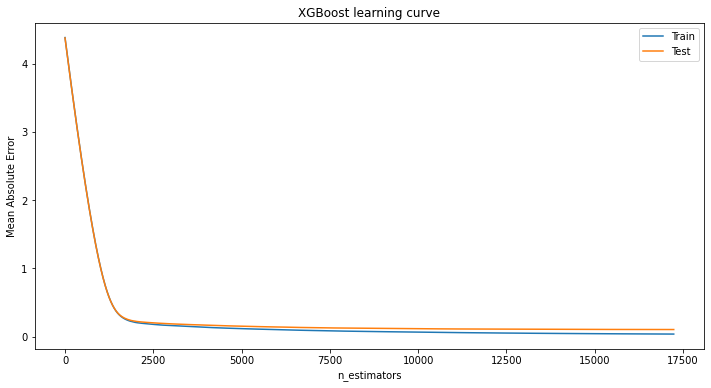

In [23]:
results = xgb.evals_result()

n_estimators = len(results["validation_0"]["rmsle"])
x_axis = range(0, n_estimators)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x_axis, results["validation_0"]["rmsle"], label="Train")
ax.plot(x_axis, results["validation_1"]["rmsle"], label="Test")
ax.legend()
plt.xlabel("n_estimators")
plt.ylabel("Mean Absolute Error")
plt.title("XGBoost learning curve")
plt.show()

In [32]:
xgb = XGBRegressor(n_estimators=15000, max_depth=7, min_child_weight=0, subsample=1., colsample_bytree=1., 
                     learning_rate=.005, gamma=0, reg_lambda=0, verbosity=1, random_state=42, n_jobs=-1, 
                     objective='reg:squaredlogerror')

xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-rmsle:4.38129	validation_1-rmsle:4.39093
[1]	validation_0-rmsle:4.37728	validation_1-rmsle:4.38691
[2]	validation_0-rmsle:4.37325	validation_1-rmsle:4.38289
[3]	validation_0-rmsle:4.36925	validation_1-rmsle:4.37887
[4]	validation_0-rmsle:4.36523	validation_1-rmsle:4.37486
[5]	validation_0-rmsle:4.36121	validation_1-rmsle:4.37084
[6]	validation_0-rmsle:4.35719	validation_1-rmsle:4.36683
[7]	validation_0-rmsle:4.35318	validation_1-rmsle:4.36281
[8]	validation_0-rmsle:4.34917	validation_1-rmsle:4.35880
[9]	validation_0-rmsle:4.34516	validation_1-rmsle:4.35478
[10]	validation_0-rmsle:4.34115	validation_1-rmsle:4.35077
[11]	validation_0-rmsle:4.33714	validation_1-rmsle:4.34676
[12]	validation_0-rmsle:4.33313	validation_1-rmsle:4.34275
[13]	validation_0-rmsle:4.32912	validation_1-rmsle:4.33874
[14]	validation_0-rmsle:4.32512	validation_1-rmsle:4.33473
[15]	validation_0-rmsle:4.32110	validation_1-rmsle:4.33072
[16]	validation_0-rmsle:4.31710	validation_1-rmsle:4.32672
[17]	va

[139]	validation_0-rmsle:3.83053	validation_1-rmsle:3.84000
[140]	validation_0-rmsle:3.82663	validation_1-rmsle:3.83610
[141]	validation_0-rmsle:3.82273	validation_1-rmsle:3.83220
[142]	validation_0-rmsle:3.81883	validation_1-rmsle:3.82830
[143]	validation_0-rmsle:3.81493	validation_1-rmsle:3.82440
[144]	validation_0-rmsle:3.81103	validation_1-rmsle:3.82050
[145]	validation_0-rmsle:3.80714	validation_1-rmsle:3.81660
[146]	validation_0-rmsle:3.80324	validation_1-rmsle:3.81270
[147]	validation_0-rmsle:3.79934	validation_1-rmsle:3.80880
[148]	validation_0-rmsle:3.79545	validation_1-rmsle:3.80491
[149]	validation_0-rmsle:3.79156	validation_1-rmsle:3.80101
[150]	validation_0-rmsle:3.78767	validation_1-rmsle:3.79712
[151]	validation_0-rmsle:3.78377	validation_1-rmsle:3.79323
[152]	validation_0-rmsle:3.77988	validation_1-rmsle:3.78933
[153]	validation_0-rmsle:3.77599	validation_1-rmsle:3.78544
[154]	validation_0-rmsle:3.77210	validation_1-rmsle:3.78155
[155]	validation_0-rmsle:3.76821	validat

[276]	validation_0-rmsle:3.30512	validation_1-rmsle:3.31440
[277]	validation_0-rmsle:3.30135	validation_1-rmsle:3.31064
[278]	validation_0-rmsle:3.29760	validation_1-rmsle:3.30687
[279]	validation_0-rmsle:3.29384	validation_1-rmsle:3.30311
[280]	validation_0-rmsle:3.29008	validation_1-rmsle:3.29935
[281]	validation_0-rmsle:3.28632	validation_1-rmsle:3.29559
[282]	validation_0-rmsle:3.28256	validation_1-rmsle:3.29183
[283]	validation_0-rmsle:3.27881	validation_1-rmsle:3.28808
[284]	validation_0-rmsle:3.27505	validation_1-rmsle:3.28432
[285]	validation_0-rmsle:3.27130	validation_1-rmsle:3.28056
[286]	validation_0-rmsle:3.26755	validation_1-rmsle:3.27681
[287]	validation_0-rmsle:3.26379	validation_1-rmsle:3.27306
[288]	validation_0-rmsle:3.26004	validation_1-rmsle:3.26931
[289]	validation_0-rmsle:3.25629	validation_1-rmsle:3.26556
[290]	validation_0-rmsle:3.25255	validation_1-rmsle:3.26181
[291]	validation_0-rmsle:3.24880	validation_1-rmsle:3.25806
[292]	validation_0-rmsle:3.24506	validat

[413]	validation_0-rmsle:2.80093	validation_1-rmsle:2.80999
[414]	validation_0-rmsle:2.79734	validation_1-rmsle:2.80639
[415]	validation_0-rmsle:2.79375	validation_1-rmsle:2.80280
[416]	validation_0-rmsle:2.79017	validation_1-rmsle:2.79921
[417]	validation_0-rmsle:2.78658	validation_1-rmsle:2.79562
[418]	validation_0-rmsle:2.78300	validation_1-rmsle:2.79204
[419]	validation_0-rmsle:2.77941	validation_1-rmsle:2.78845
[420]	validation_0-rmsle:2.77583	validation_1-rmsle:2.78487
[421]	validation_0-rmsle:2.77225	validation_1-rmsle:2.78129
[422]	validation_0-rmsle:2.76867	validation_1-rmsle:2.77771
[423]	validation_0-rmsle:2.76509	validation_1-rmsle:2.77413
[424]	validation_0-rmsle:2.76152	validation_1-rmsle:2.77055
[425]	validation_0-rmsle:2.75794	validation_1-rmsle:2.76697
[426]	validation_0-rmsle:2.75436	validation_1-rmsle:2.76339
[427]	validation_0-rmsle:2.75079	validation_1-rmsle:2.75982
[428]	validation_0-rmsle:2.74722	validation_1-rmsle:2.75625
[429]	validation_0-rmsle:2.74365	validat

[550]	validation_0-rmsle:2.32302	validation_1-rmsle:2.33180
[551]	validation_0-rmsle:2.31964	validation_1-rmsle:2.32842
[552]	validation_0-rmsle:2.31626	validation_1-rmsle:2.32504
[553]	validation_0-rmsle:2.31289	validation_1-rmsle:2.32167
[554]	validation_0-rmsle:2.30952	validation_1-rmsle:2.31829
[555]	validation_0-rmsle:2.30615	validation_1-rmsle:2.31492
[556]	validation_0-rmsle:2.30278	validation_1-rmsle:2.31155
[557]	validation_0-rmsle:2.29941	validation_1-rmsle:2.30818
[558]	validation_0-rmsle:2.29605	validation_1-rmsle:2.30482
[559]	validation_0-rmsle:2.29269	validation_1-rmsle:2.30145
[560]	validation_0-rmsle:2.28932	validation_1-rmsle:2.29809
[561]	validation_0-rmsle:2.28596	validation_1-rmsle:2.29473
[562]	validation_0-rmsle:2.28261	validation_1-rmsle:2.29137
[563]	validation_0-rmsle:2.27925	validation_1-rmsle:2.28801
[564]	validation_0-rmsle:2.27590	validation_1-rmsle:2.28465
[565]	validation_0-rmsle:2.27255	validation_1-rmsle:2.28130
[566]	validation_0-rmsle:2.26920	validat

[687]	validation_0-rmsle:1.87782	validation_1-rmsle:1.88630
[688]	validation_0-rmsle:1.87471	validation_1-rmsle:1.88318
[689]	validation_0-rmsle:1.87160	validation_1-rmsle:1.88007
[690]	validation_0-rmsle:1.86850	validation_1-rmsle:1.87697
[691]	validation_0-rmsle:1.86539	validation_1-rmsle:1.87386
[692]	validation_0-rmsle:1.86229	validation_1-rmsle:1.87075
[693]	validation_0-rmsle:1.85919	validation_1-rmsle:1.86765
[694]	validation_0-rmsle:1.85609	validation_1-rmsle:1.86455
[695]	validation_0-rmsle:1.85299	validation_1-rmsle:1.86146
[696]	validation_0-rmsle:1.84990	validation_1-rmsle:1.85836
[697]	validation_0-rmsle:1.84681	validation_1-rmsle:1.85527
[698]	validation_0-rmsle:1.84372	validation_1-rmsle:1.85218
[699]	validation_0-rmsle:1.84064	validation_1-rmsle:1.84909
[700]	validation_0-rmsle:1.83755	validation_1-rmsle:1.84600
[701]	validation_0-rmsle:1.83447	validation_1-rmsle:1.84292
[702]	validation_0-rmsle:1.83139	validation_1-rmsle:1.83983
[703]	validation_0-rmsle:1.82831	validat

[824]	validation_0-rmsle:1.47335	validation_1-rmsle:1.48151
[825]	validation_0-rmsle:1.47057	validation_1-rmsle:1.47873
[826]	validation_0-rmsle:1.46779	validation_1-rmsle:1.47595
[827]	validation_0-rmsle:1.46502	validation_1-rmsle:1.47317
[828]	validation_0-rmsle:1.46225	validation_1-rmsle:1.47039
[829]	validation_0-rmsle:1.45948	validation_1-rmsle:1.46762
[830]	validation_0-rmsle:1.45671	validation_1-rmsle:1.46485
[831]	validation_0-rmsle:1.45395	validation_1-rmsle:1.46209
[832]	validation_0-rmsle:1.45118	validation_1-rmsle:1.45932
[833]	validation_0-rmsle:1.44843	validation_1-rmsle:1.45656
[834]	validation_0-rmsle:1.44567	validation_1-rmsle:1.45380
[835]	validation_0-rmsle:1.44292	validation_1-rmsle:1.45105
[836]	validation_0-rmsle:1.44016	validation_1-rmsle:1.44830
[837]	validation_0-rmsle:1.43742	validation_1-rmsle:1.44555
[838]	validation_0-rmsle:1.43467	validation_1-rmsle:1.44280
[839]	validation_0-rmsle:1.43193	validation_1-rmsle:1.44006
[840]	validation_0-rmsle:1.42919	validat

[961]	validation_0-rmsle:1.11901	validation_1-rmsle:1.12690
[962]	validation_0-rmsle:1.11664	validation_1-rmsle:1.12452
[963]	validation_0-rmsle:1.11426	validation_1-rmsle:1.12214
[964]	validation_0-rmsle:1.11189	validation_1-rmsle:1.11977
[965]	validation_0-rmsle:1.10952	validation_1-rmsle:1.11740
[966]	validation_0-rmsle:1.10716	validation_1-rmsle:1.11503
[967]	validation_0-rmsle:1.10479	validation_1-rmsle:1.11267
[968]	validation_0-rmsle:1.10244	validation_1-rmsle:1.11031
[969]	validation_0-rmsle:1.10008	validation_1-rmsle:1.10795
[970]	validation_0-rmsle:1.09773	validation_1-rmsle:1.10560
[971]	validation_0-rmsle:1.09538	validation_1-rmsle:1.10325
[972]	validation_0-rmsle:1.09304	validation_1-rmsle:1.10090
[973]	validation_0-rmsle:1.09069	validation_1-rmsle:1.09856
[974]	validation_0-rmsle:1.08836	validation_1-rmsle:1.09622
[975]	validation_0-rmsle:1.08602	validation_1-rmsle:1.09388
[976]	validation_0-rmsle:1.08369	validation_1-rmsle:1.09155
[977]	validation_0-rmsle:1.08136	validat

[1096]	validation_0-rmsle:0.82835	validation_1-rmsle:0.83616
[1097]	validation_0-rmsle:0.82643	validation_1-rmsle:0.83425
[1098]	validation_0-rmsle:0.82452	validation_1-rmsle:0.83234
[1099]	validation_0-rmsle:0.82261	validation_1-rmsle:0.83043
[1100]	validation_0-rmsle:0.82070	validation_1-rmsle:0.82852
[1101]	validation_0-rmsle:0.81880	validation_1-rmsle:0.82662
[1102]	validation_0-rmsle:0.81690	validation_1-rmsle:0.82473
[1103]	validation_0-rmsle:0.81500	validation_1-rmsle:0.82283
[1104]	validation_0-rmsle:0.81311	validation_1-rmsle:0.82094
[1105]	validation_0-rmsle:0.81122	validation_1-rmsle:0.81906
[1106]	validation_0-rmsle:0.80934	validation_1-rmsle:0.81717
[1107]	validation_0-rmsle:0.80745	validation_1-rmsle:0.81529
[1108]	validation_0-rmsle:0.80557	validation_1-rmsle:0.81342
[1109]	validation_0-rmsle:0.80370	validation_1-rmsle:0.81155
[1110]	validation_0-rmsle:0.80183	validation_1-rmsle:0.80968
[1111]	validation_0-rmsle:0.79996	validation_1-rmsle:0.80781
[1112]	validation_0-rmsl

[1231]	validation_0-rmsle:0.60190	validation_1-rmsle:0.61039
[1232]	validation_0-rmsle:0.60047	validation_1-rmsle:0.60897
[1233]	validation_0-rmsle:0.59905	validation_1-rmsle:0.60755
[1234]	validation_0-rmsle:0.59762	validation_1-rmsle:0.60613
[1235]	validation_0-rmsle:0.59621	validation_1-rmsle:0.60472
[1236]	validation_0-rmsle:0.59479	validation_1-rmsle:0.60331
[1237]	validation_0-rmsle:0.59338	validation_1-rmsle:0.60191
[1238]	validation_0-rmsle:0.59198	validation_1-rmsle:0.60051
[1239]	validation_0-rmsle:0.59058	validation_1-rmsle:0.59911
[1240]	validation_0-rmsle:0.58918	validation_1-rmsle:0.59772
[1241]	validation_0-rmsle:0.58779	validation_1-rmsle:0.59633
[1242]	validation_0-rmsle:0.58639	validation_1-rmsle:0.59494
[1243]	validation_0-rmsle:0.58501	validation_1-rmsle:0.59356
[1244]	validation_0-rmsle:0.58362	validation_1-rmsle:0.59218
[1245]	validation_0-rmsle:0.58224	validation_1-rmsle:0.59081
[1246]	validation_0-rmsle:0.58087	validation_1-rmsle:0.58944
[1247]	validation_0-rmsl

[1366]	validation_0-rmsle:0.44209	validation_1-rmsle:0.45156
[1367]	validation_0-rmsle:0.44114	validation_1-rmsle:0.45062
[1368]	validation_0-rmsle:0.44019	validation_1-rmsle:0.44968
[1369]	validation_0-rmsle:0.43925	validation_1-rmsle:0.44875
[1370]	validation_0-rmsle:0.43831	validation_1-rmsle:0.44782
[1371]	validation_0-rmsle:0.43737	validation_1-rmsle:0.44689
[1372]	validation_0-rmsle:0.43644	validation_1-rmsle:0.44596
[1373]	validation_0-rmsle:0.43551	validation_1-rmsle:0.44504
[1374]	validation_0-rmsle:0.43458	validation_1-rmsle:0.44412
[1375]	validation_0-rmsle:0.43366	validation_1-rmsle:0.44321
[1376]	validation_0-rmsle:0.43274	validation_1-rmsle:0.44230
[1377]	validation_0-rmsle:0.43182	validation_1-rmsle:0.44139
[1378]	validation_0-rmsle:0.43090	validation_1-rmsle:0.44048
[1379]	validation_0-rmsle:0.42999	validation_1-rmsle:0.43958
[1380]	validation_0-rmsle:0.42908	validation_1-rmsle:0.43868
[1381]	validation_0-rmsle:0.42817	validation_1-rmsle:0.43778
[1382]	validation_0-rmsl

[1501]	validation_0-rmsle:0.34005	validation_1-rmsle:0.35103
[1502]	validation_0-rmsle:0.33948	validation_1-rmsle:0.35046
[1503]	validation_0-rmsle:0.33891	validation_1-rmsle:0.34990
[1504]	validation_0-rmsle:0.33834	validation_1-rmsle:0.34935
[1505]	validation_0-rmsle:0.33778	validation_1-rmsle:0.34881
[1506]	validation_0-rmsle:0.33721	validation_1-rmsle:0.34827
[1507]	validation_0-rmsle:0.33665	validation_1-rmsle:0.34772
[1508]	validation_0-rmsle:0.33609	validation_1-rmsle:0.34717
[1509]	validation_0-rmsle:0.33553	validation_1-rmsle:0.34663
[1510]	validation_0-rmsle:0.33498	validation_1-rmsle:0.34610
[1511]	validation_0-rmsle:0.33444	validation_1-rmsle:0.34557
[1512]	validation_0-rmsle:0.33388	validation_1-rmsle:0.34502
[1513]	validation_0-rmsle:0.33333	validation_1-rmsle:0.34450
[1514]	validation_0-rmsle:0.33279	validation_1-rmsle:0.34397
[1515]	validation_0-rmsle:0.33225	validation_1-rmsle:0.34345
[1516]	validation_0-rmsle:0.33171	validation_1-rmsle:0.34291
[1517]	validation_0-rmsl

[1636]	validation_0-rmsle:0.28033	validation_1-rmsle:0.29323
[1637]	validation_0-rmsle:0.27999	validation_1-rmsle:0.29290
[1638]	validation_0-rmsle:0.27967	validation_1-rmsle:0.29260
[1639]	validation_0-rmsle:0.27934	validation_1-rmsle:0.29228
[1640]	validation_0-rmsle:0.27901	validation_1-rmsle:0.29197
[1641]	validation_0-rmsle:0.27867	validation_1-rmsle:0.29162
[1642]	validation_0-rmsle:0.27837	validation_1-rmsle:0.29133
[1643]	validation_0-rmsle:0.27804	validation_1-rmsle:0.29101
[1644]	validation_0-rmsle:0.27773	validation_1-rmsle:0.29073
[1645]	validation_0-rmsle:0.27741	validation_1-rmsle:0.29043
[1646]	validation_0-rmsle:0.27710	validation_1-rmsle:0.29011
[1647]	validation_0-rmsle:0.27676	validation_1-rmsle:0.28979
[1648]	validation_0-rmsle:0.27646	validation_1-rmsle:0.28949
[1649]	validation_0-rmsle:0.27612	validation_1-rmsle:0.28916
[1650]	validation_0-rmsle:0.27582	validation_1-rmsle:0.28887
[1651]	validation_0-rmsle:0.27548	validation_1-rmsle:0.28854
[1652]	validation_0-rmsl

[1771]	validation_0-rmsle:0.24433	validation_1-rmsle:0.25795
[1772]	validation_0-rmsle:0.24411	validation_1-rmsle:0.25773
[1773]	validation_0-rmsle:0.24392	validation_1-rmsle:0.25755
[1774]	validation_0-rmsle:0.24372	validation_1-rmsle:0.25736
[1775]	validation_0-rmsle:0.24351	validation_1-rmsle:0.25715
[1776]	validation_0-rmsle:0.24332	validation_1-rmsle:0.25696
[1777]	validation_0-rmsle:0.24312	validation_1-rmsle:0.25676
[1778]	validation_0-rmsle:0.24293	validation_1-rmsle:0.25659
[1779]	validation_0-rmsle:0.24272	validation_1-rmsle:0.25638
[1780]	validation_0-rmsle:0.24252	validation_1-rmsle:0.25618
[1781]	validation_0-rmsle:0.24233	validation_1-rmsle:0.25600
[1782]	validation_0-rmsle:0.24214	validation_1-rmsle:0.25582
[1783]	validation_0-rmsle:0.24194	validation_1-rmsle:0.25562
[1784]	validation_0-rmsle:0.24175	validation_1-rmsle:0.25543
[1785]	validation_0-rmsle:0.24156	validation_1-rmsle:0.25525
[1786]	validation_0-rmsle:0.24136	validation_1-rmsle:0.25505
[1787]	validation_0-rmsl

[1906]	validation_0-rmsle:0.22182	validation_1-rmsle:0.23612
[1907]	validation_0-rmsle:0.22170	validation_1-rmsle:0.23601
[1908]	validation_0-rmsle:0.22156	validation_1-rmsle:0.23587
[1909]	validation_0-rmsle:0.22145	validation_1-rmsle:0.23577
[1910]	validation_0-rmsle:0.22133	validation_1-rmsle:0.23564
[1911]	validation_0-rmsle:0.22119	validation_1-rmsle:0.23552
[1912]	validation_0-rmsle:0.22107	validation_1-rmsle:0.23540
[1913]	validation_0-rmsle:0.22093	validation_1-rmsle:0.23528
[1914]	validation_0-rmsle:0.22081	validation_1-rmsle:0.23516
[1915]	validation_0-rmsle:0.22070	validation_1-rmsle:0.23504
[1916]	validation_0-rmsle:0.22058	validation_1-rmsle:0.23492
[1917]	validation_0-rmsle:0.22044	validation_1-rmsle:0.23478
[1918]	validation_0-rmsle:0.22032	validation_1-rmsle:0.23467
[1919]	validation_0-rmsle:0.22018	validation_1-rmsle:0.23454
[1920]	validation_0-rmsle:0.22006	validation_1-rmsle:0.23442
[1921]	validation_0-rmsle:0.21994	validation_1-rmsle:0.23431
[1922]	validation_0-rmsl

[2041]	validation_0-rmsle:0.20809	validation_1-rmsle:0.22296
[2042]	validation_0-rmsle:0.20800	validation_1-rmsle:0.22288
[2043]	validation_0-rmsle:0.20793	validation_1-rmsle:0.22281
[2044]	validation_0-rmsle:0.20785	validation_1-rmsle:0.22273
[2045]	validation_0-rmsle:0.20778	validation_1-rmsle:0.22267
[2046]	validation_0-rmsle:0.20771	validation_1-rmsle:0.22260
[2047]	validation_0-rmsle:0.20763	validation_1-rmsle:0.22254
[2048]	validation_0-rmsle:0.20757	validation_1-rmsle:0.22248
[2049]	validation_0-rmsle:0.20750	validation_1-rmsle:0.22242
[2050]	validation_0-rmsle:0.20742	validation_1-rmsle:0.22234
[2051]	validation_0-rmsle:0.20735	validation_1-rmsle:0.22227
[2052]	validation_0-rmsle:0.20727	validation_1-rmsle:0.22220
[2053]	validation_0-rmsle:0.20719	validation_1-rmsle:0.22212
[2054]	validation_0-rmsle:0.20711	validation_1-rmsle:0.22205
[2055]	validation_0-rmsle:0.20705	validation_1-rmsle:0.22199
[2056]	validation_0-rmsle:0.20698	validation_1-rmsle:0.22192
[2057]	validation_0-rmsl

[2176]	validation_0-rmsle:0.19878	validation_1-rmsle:0.21403
[2177]	validation_0-rmsle:0.19869	validation_1-rmsle:0.21395
[2178]	validation_0-rmsle:0.19863	validation_1-rmsle:0.21389
[2179]	validation_0-rmsle:0.19858	validation_1-rmsle:0.21384
[2180]	validation_0-rmsle:0.19852	validation_1-rmsle:0.21379
[2181]	validation_0-rmsle:0.19846	validation_1-rmsle:0.21374
[2182]	validation_0-rmsle:0.19840	validation_1-rmsle:0.21369
[2183]	validation_0-rmsle:0.19832	validation_1-rmsle:0.21361
[2184]	validation_0-rmsle:0.19828	validation_1-rmsle:0.21357
[2185]	validation_0-rmsle:0.19821	validation_1-rmsle:0.21350
[2186]	validation_0-rmsle:0.19813	validation_1-rmsle:0.21343
[2187]	validation_0-rmsle:0.19807	validation_1-rmsle:0.21338
[2188]	validation_0-rmsle:0.19801	validation_1-rmsle:0.21333
[2189]	validation_0-rmsle:0.19793	validation_1-rmsle:0.21326
[2190]	validation_0-rmsle:0.19785	validation_1-rmsle:0.21320
[2191]	validation_0-rmsle:0.19780	validation_1-rmsle:0.21315
[2192]	validation_0-rmsl

[2311]	validation_0-rmsle:0.19187	validation_1-rmsle:0.20778
[2312]	validation_0-rmsle:0.19180	validation_1-rmsle:0.20772
[2313]	validation_0-rmsle:0.19175	validation_1-rmsle:0.20766
[2314]	validation_0-rmsle:0.19170	validation_1-rmsle:0.20761
[2315]	validation_0-rmsle:0.19168	validation_1-rmsle:0.20759
[2316]	validation_0-rmsle:0.19162	validation_1-rmsle:0.20753
[2317]	validation_0-rmsle:0.19157	validation_1-rmsle:0.20748
[2318]	validation_0-rmsle:0.19155	validation_1-rmsle:0.20746
[2319]	validation_0-rmsle:0.19151	validation_1-rmsle:0.20743
[2320]	validation_0-rmsle:0.19145	validation_1-rmsle:0.20738
[2321]	validation_0-rmsle:0.19141	validation_1-rmsle:0.20733
[2322]	validation_0-rmsle:0.19138	validation_1-rmsle:0.20732
[2323]	validation_0-rmsle:0.19134	validation_1-rmsle:0.20727
[2324]	validation_0-rmsle:0.19128	validation_1-rmsle:0.20721
[2325]	validation_0-rmsle:0.19125	validation_1-rmsle:0.20719
[2326]	validation_0-rmsle:0.19123	validation_1-rmsle:0.20717
[2327]	validation_0-rmsl

[2446]	validation_0-rmsle:0.18653	validation_1-rmsle:0.20279
[2447]	validation_0-rmsle:0.18649	validation_1-rmsle:0.20277
[2448]	validation_0-rmsle:0.18646	validation_1-rmsle:0.20273
[2449]	validation_0-rmsle:0.18643	validation_1-rmsle:0.20271
[2450]	validation_0-rmsle:0.18640	validation_1-rmsle:0.20269
[2451]	validation_0-rmsle:0.18638	validation_1-rmsle:0.20267
[2452]	validation_0-rmsle:0.18635	validation_1-rmsle:0.20264
[2453]	validation_0-rmsle:0.18631	validation_1-rmsle:0.20260
[2454]	validation_0-rmsle:0.18628	validation_1-rmsle:0.20258
[2455]	validation_0-rmsle:0.18626	validation_1-rmsle:0.20257
[2456]	validation_0-rmsle:0.18623	validation_1-rmsle:0.20254
[2457]	validation_0-rmsle:0.18620	validation_1-rmsle:0.20252
[2458]	validation_0-rmsle:0.18617	validation_1-rmsle:0.20248
[2459]	validation_0-rmsle:0.18616	validation_1-rmsle:0.20247
[2460]	validation_0-rmsle:0.18612	validation_1-rmsle:0.20243
[2461]	validation_0-rmsle:0.18610	validation_1-rmsle:0.20242
[2462]	validation_0-rmsl

[2581]	validation_0-rmsle:0.18161	validation_1-rmsle:0.19828
[2582]	validation_0-rmsle:0.18159	validation_1-rmsle:0.19827
[2583]	validation_0-rmsle:0.18154	validation_1-rmsle:0.19822
[2584]	validation_0-rmsle:0.18152	validation_1-rmsle:0.19819
[2585]	validation_0-rmsle:0.18149	validation_1-rmsle:0.19818
[2586]	validation_0-rmsle:0.18145	validation_1-rmsle:0.19813
[2587]	validation_0-rmsle:0.18140	validation_1-rmsle:0.19809
[2588]	validation_0-rmsle:0.18137	validation_1-rmsle:0.19806
[2589]	validation_0-rmsle:0.18131	validation_1-rmsle:0.19802
[2590]	validation_0-rmsle:0.18129	validation_1-rmsle:0.19801
[2591]	validation_0-rmsle:0.18124	validation_1-rmsle:0.19796
[2592]	validation_0-rmsle:0.18121	validation_1-rmsle:0.19793
[2593]	validation_0-rmsle:0.18119	validation_1-rmsle:0.19791
[2594]	validation_0-rmsle:0.18115	validation_1-rmsle:0.19787
[2595]	validation_0-rmsle:0.18109	validation_1-rmsle:0.19782
[2596]	validation_0-rmsle:0.18104	validation_1-rmsle:0.19778
[2597]	validation_0-rmsl

[2716]	validation_0-rmsle:0.17726	validation_1-rmsle:0.19454
[2717]	validation_0-rmsle:0.17724	validation_1-rmsle:0.19452
[2718]	validation_0-rmsle:0.17722	validation_1-rmsle:0.19450
[2719]	validation_0-rmsle:0.17717	validation_1-rmsle:0.19445
[2720]	validation_0-rmsle:0.17714	validation_1-rmsle:0.19444
[2721]	validation_0-rmsle:0.17712	validation_1-rmsle:0.19442
[2722]	validation_0-rmsle:0.17710	validation_1-rmsle:0.19440
[2723]	validation_0-rmsle:0.17708	validation_1-rmsle:0.19437
[2724]	validation_0-rmsle:0.17706	validation_1-rmsle:0.19436
[2725]	validation_0-rmsle:0.17703	validation_1-rmsle:0.19434
[2726]	validation_0-rmsle:0.17700	validation_1-rmsle:0.19431
[2727]	validation_0-rmsle:0.17697	validation_1-rmsle:0.19428
[2728]	validation_0-rmsle:0.17694	validation_1-rmsle:0.19426
[2729]	validation_0-rmsle:0.17693	validation_1-rmsle:0.19424
[2730]	validation_0-rmsle:0.17691	validation_1-rmsle:0.19423
[2731]	validation_0-rmsle:0.17689	validation_1-rmsle:0.19421
[2732]	validation_0-rmsl

[2851]	validation_0-rmsle:0.17358	validation_1-rmsle:0.19131
[2852]	validation_0-rmsle:0.17356	validation_1-rmsle:0.19129
[2853]	validation_0-rmsle:0.17355	validation_1-rmsle:0.19127
[2854]	validation_0-rmsle:0.17352	validation_1-rmsle:0.19126
[2855]	validation_0-rmsle:0.17350	validation_1-rmsle:0.19124
[2856]	validation_0-rmsle:0.17344	validation_1-rmsle:0.19118
[2857]	validation_0-rmsle:0.17340	validation_1-rmsle:0.19115
[2858]	validation_0-rmsle:0.17338	validation_1-rmsle:0.19112
[2859]	validation_0-rmsle:0.17336	validation_1-rmsle:0.19110
[2860]	validation_0-rmsle:0.17333	validation_1-rmsle:0.19107
[2861]	validation_0-rmsle:0.17329	validation_1-rmsle:0.19104
[2862]	validation_0-rmsle:0.17327	validation_1-rmsle:0.19102
[2863]	validation_0-rmsle:0.17322	validation_1-rmsle:0.19099
[2864]	validation_0-rmsle:0.17319	validation_1-rmsle:0.19096
[2865]	validation_0-rmsle:0.17316	validation_1-rmsle:0.19093
[2866]	validation_0-rmsle:0.17313	validation_1-rmsle:0.19091
[2867]	validation_0-rmsl

[2986]	validation_0-rmsle:0.16980	validation_1-rmsle:0.18790
[2987]	validation_0-rmsle:0.16973	validation_1-rmsle:0.18783
[2988]	validation_0-rmsle:0.16966	validation_1-rmsle:0.18777
[2989]	validation_0-rmsle:0.16962	validation_1-rmsle:0.18774
[2990]	validation_0-rmsle:0.16961	validation_1-rmsle:0.18772
[2991]	validation_0-rmsle:0.16958	validation_1-rmsle:0.18770
[2992]	validation_0-rmsle:0.16956	validation_1-rmsle:0.18768
[2993]	validation_0-rmsle:0.16953	validation_1-rmsle:0.18766
[2994]	validation_0-rmsle:0.16951	validation_1-rmsle:0.18764
[2995]	validation_0-rmsle:0.16945	validation_1-rmsle:0.18758
[2996]	validation_0-rmsle:0.16937	validation_1-rmsle:0.18751
[2997]	validation_0-rmsle:0.16934	validation_1-rmsle:0.18748
[2998]	validation_0-rmsle:0.16928	validation_1-rmsle:0.18743
[2999]	validation_0-rmsle:0.16922	validation_1-rmsle:0.18737
[3000]	validation_0-rmsle:0.16920	validation_1-rmsle:0.18736
[3001]	validation_0-rmsle:0.16919	validation_1-rmsle:0.18735
[3002]	validation_0-rmsl

[3121]	validation_0-rmsle:0.16552	validation_1-rmsle:0.18406
[3122]	validation_0-rmsle:0.16547	validation_1-rmsle:0.18401
[3123]	validation_0-rmsle:0.16546	validation_1-rmsle:0.18400
[3124]	validation_0-rmsle:0.16543	validation_1-rmsle:0.18397
[3125]	validation_0-rmsle:0.16542	validation_1-rmsle:0.18396
[3126]	validation_0-rmsle:0.16539	validation_1-rmsle:0.18394
[3127]	validation_0-rmsle:0.16538	validation_1-rmsle:0.18393
[3128]	validation_0-rmsle:0.16534	validation_1-rmsle:0.18389
[3129]	validation_0-rmsle:0.16533	validation_1-rmsle:0.18388
[3130]	validation_0-rmsle:0.16531	validation_1-rmsle:0.18385
[3131]	validation_0-rmsle:0.16529	validation_1-rmsle:0.18384
[3132]	validation_0-rmsle:0.16524	validation_1-rmsle:0.18380
[3133]	validation_0-rmsle:0.16519	validation_1-rmsle:0.18375
[3134]	validation_0-rmsle:0.16517	validation_1-rmsle:0.18374
[3135]	validation_0-rmsle:0.16515	validation_1-rmsle:0.18372
[3136]	validation_0-rmsle:0.16511	validation_1-rmsle:0.18368
[3137]	validation_0-rmsl

[3256]	validation_0-rmsle:0.16189	validation_1-rmsle:0.18066
[3257]	validation_0-rmsle:0.16188	validation_1-rmsle:0.18065
[3258]	validation_0-rmsle:0.16187	validation_1-rmsle:0.18064
[3259]	validation_0-rmsle:0.16184	validation_1-rmsle:0.18062
[3260]	validation_0-rmsle:0.16180	validation_1-rmsle:0.18058
[3261]	validation_0-rmsle:0.16177	validation_1-rmsle:0.18054
[3262]	validation_0-rmsle:0.16176	validation_1-rmsle:0.18054
[3263]	validation_0-rmsle:0.16174	validation_1-rmsle:0.18052
[3264]	validation_0-rmsle:0.16173	validation_1-rmsle:0.18050
[3265]	validation_0-rmsle:0.16165	validation_1-rmsle:0.18044
[3266]	validation_0-rmsle:0.16160	validation_1-rmsle:0.18040
[3267]	validation_0-rmsle:0.16160	validation_1-rmsle:0.18039
[3268]	validation_0-rmsle:0.16158	validation_1-rmsle:0.18037
[3269]	validation_0-rmsle:0.16156	validation_1-rmsle:0.18034
[3270]	validation_0-rmsle:0.16151	validation_1-rmsle:0.18030
[3271]	validation_0-rmsle:0.16150	validation_1-rmsle:0.18029
[3272]	validation_0-rmsl

[3391]	validation_0-rmsle:0.15810	validation_1-rmsle:0.17709
[3392]	validation_0-rmsle:0.15805	validation_1-rmsle:0.17704
[3393]	validation_0-rmsle:0.15804	validation_1-rmsle:0.17704
[3394]	validation_0-rmsle:0.15800	validation_1-rmsle:0.17700
[3395]	validation_0-rmsle:0.15799	validation_1-rmsle:0.17699
[3396]	validation_0-rmsle:0.15797	validation_1-rmsle:0.17697
[3397]	validation_0-rmsle:0.15794	validation_1-rmsle:0.17694
[3398]	validation_0-rmsle:0.15790	validation_1-rmsle:0.17690
[3399]	validation_0-rmsle:0.15785	validation_1-rmsle:0.17685
[3400]	validation_0-rmsle:0.15785	validation_1-rmsle:0.17685
[3401]	validation_0-rmsle:0.15783	validation_1-rmsle:0.17683
[3402]	validation_0-rmsle:0.15782	validation_1-rmsle:0.17683
[3403]	validation_0-rmsle:0.15777	validation_1-rmsle:0.17678
[3404]	validation_0-rmsle:0.15776	validation_1-rmsle:0.17677
[3405]	validation_0-rmsle:0.15772	validation_1-rmsle:0.17674
[3406]	validation_0-rmsle:0.15769	validation_1-rmsle:0.17671
[3407]	validation_0-rmsl

[3526]	validation_0-rmsle:0.15493	validation_1-rmsle:0.17422
[3527]	validation_0-rmsle:0.15492	validation_1-rmsle:0.17421
[3528]	validation_0-rmsle:0.15489	validation_1-rmsle:0.17418
[3529]	validation_0-rmsle:0.15486	validation_1-rmsle:0.17416
[3530]	validation_0-rmsle:0.15485	validation_1-rmsle:0.17415
[3531]	validation_0-rmsle:0.15481	validation_1-rmsle:0.17411
[3532]	validation_0-rmsle:0.15480	validation_1-rmsle:0.17410
[3533]	validation_0-rmsle:0.15476	validation_1-rmsle:0.17408
[3534]	validation_0-rmsle:0.15474	validation_1-rmsle:0.17405
[3535]	validation_0-rmsle:0.15472	validation_1-rmsle:0.17404
[3536]	validation_0-rmsle:0.15471	validation_1-rmsle:0.17403
[3537]	validation_0-rmsle:0.15465	validation_1-rmsle:0.17398
[3538]	validation_0-rmsle:0.15462	validation_1-rmsle:0.17395
[3539]	validation_0-rmsle:0.15461	validation_1-rmsle:0.17394
[3540]	validation_0-rmsle:0.15458	validation_1-rmsle:0.17391
[3541]	validation_0-rmsle:0.15457	validation_1-rmsle:0.17390
[3542]	validation_0-rmsl

[3661]	validation_0-rmsle:0.15112	validation_1-rmsle:0.17071
[3662]	validation_0-rmsle:0.15109	validation_1-rmsle:0.17068
[3663]	validation_0-rmsle:0.15106	validation_1-rmsle:0.17066
[3664]	validation_0-rmsle:0.15105	validation_1-rmsle:0.17065
[3665]	validation_0-rmsle:0.15101	validation_1-rmsle:0.17061
[3666]	validation_0-rmsle:0.15099	validation_1-rmsle:0.17058
[3667]	validation_0-rmsle:0.15097	validation_1-rmsle:0.17057
[3668]	validation_0-rmsle:0.15095	validation_1-rmsle:0.17055
[3669]	validation_0-rmsle:0.15093	validation_1-rmsle:0.17053
[3670]	validation_0-rmsle:0.15090	validation_1-rmsle:0.17050
[3671]	validation_0-rmsle:0.15086	validation_1-rmsle:0.17046
[3672]	validation_0-rmsle:0.15083	validation_1-rmsle:0.17043
[3673]	validation_0-rmsle:0.15081	validation_1-rmsle:0.17042
[3674]	validation_0-rmsle:0.15078	validation_1-rmsle:0.17039
[3675]	validation_0-rmsle:0.15078	validation_1-rmsle:0.17039
[3676]	validation_0-rmsle:0.15077	validation_1-rmsle:0.17039
[3677]	validation_0-rmsl

[3796]	validation_0-rmsle:0.14750	validation_1-rmsle:0.16732
[3797]	validation_0-rmsle:0.14745	validation_1-rmsle:0.16729
[3798]	validation_0-rmsle:0.14741	validation_1-rmsle:0.16725
[3799]	validation_0-rmsle:0.14737	validation_1-rmsle:0.16722
[3800]	validation_0-rmsle:0.14735	validation_1-rmsle:0.16719
[3801]	validation_0-rmsle:0.14733	validation_1-rmsle:0.16718
[3802]	validation_0-rmsle:0.14733	validation_1-rmsle:0.16717
[3803]	validation_0-rmsle:0.14729	validation_1-rmsle:0.16714
[3804]	validation_0-rmsle:0.14727	validation_1-rmsle:0.16712
[3805]	validation_0-rmsle:0.14723	validation_1-rmsle:0.16708
[3806]	validation_0-rmsle:0.14721	validation_1-rmsle:0.16707
[3807]	validation_0-rmsle:0.14720	validation_1-rmsle:0.16706
[3808]	validation_0-rmsle:0.14720	validation_1-rmsle:0.16706
[3809]	validation_0-rmsle:0.14716	validation_1-rmsle:0.16702
[3810]	validation_0-rmsle:0.14713	validation_1-rmsle:0.16700
[3811]	validation_0-rmsle:0.14709	validation_1-rmsle:0.16697
[3812]	validation_0-rmsl

[3931]	validation_0-rmsle:0.14402	validation_1-rmsle:0.16421
[3932]	validation_0-rmsle:0.14400	validation_1-rmsle:0.16418
[3933]	validation_0-rmsle:0.14395	validation_1-rmsle:0.16415
[3934]	validation_0-rmsle:0.14393	validation_1-rmsle:0.16413
[3935]	validation_0-rmsle:0.14390	validation_1-rmsle:0.16411
[3936]	validation_0-rmsle:0.14387	validation_1-rmsle:0.16408
[3937]	validation_0-rmsle:0.14385	validation_1-rmsle:0.16406
[3938]	validation_0-rmsle:0.14384	validation_1-rmsle:0.16405
[3939]	validation_0-rmsle:0.14382	validation_1-rmsle:0.16404
[3940]	validation_0-rmsle:0.14379	validation_1-rmsle:0.16401
[3941]	validation_0-rmsle:0.14376	validation_1-rmsle:0.16399
[3942]	validation_0-rmsle:0.14374	validation_1-rmsle:0.16397
[3943]	validation_0-rmsle:0.14374	validation_1-rmsle:0.16397
[3944]	validation_0-rmsle:0.14371	validation_1-rmsle:0.16393
[3945]	validation_0-rmsle:0.14368	validation_1-rmsle:0.16391
[3946]	validation_0-rmsle:0.14366	validation_1-rmsle:0.16389
[3947]	validation_0-rmsl

[4066]	validation_0-rmsle:0.14094	validation_1-rmsle:0.16142
[4067]	validation_0-rmsle:0.14092	validation_1-rmsle:0.16140
[4068]	validation_0-rmsle:0.14091	validation_1-rmsle:0.16138
[4069]	validation_0-rmsle:0.14089	validation_1-rmsle:0.16137
[4070]	validation_0-rmsle:0.14088	validation_1-rmsle:0.16136
[4071]	validation_0-rmsle:0.14086	validation_1-rmsle:0.16134
[4072]	validation_0-rmsle:0.14083	validation_1-rmsle:0.16131
[4073]	validation_0-rmsle:0.14081	validation_1-rmsle:0.16129
[4074]	validation_0-rmsle:0.14078	validation_1-rmsle:0.16128
[4075]	validation_0-rmsle:0.14077	validation_1-rmsle:0.16126
[4076]	validation_0-rmsle:0.14072	validation_1-rmsle:0.16122
[4077]	validation_0-rmsle:0.14071	validation_1-rmsle:0.16120
[4078]	validation_0-rmsle:0.14068	validation_1-rmsle:0.16118
[4079]	validation_0-rmsle:0.14065	validation_1-rmsle:0.16115
[4080]	validation_0-rmsle:0.14063	validation_1-rmsle:0.16113
[4081]	validation_0-rmsle:0.14061	validation_1-rmsle:0.16111
[4082]	validation_0-rmsl

[4201]	validation_0-rmsle:0.13806	validation_1-rmsle:0.15879
[4202]	validation_0-rmsle:0.13805	validation_1-rmsle:0.15877
[4203]	validation_0-rmsle:0.13803	validation_1-rmsle:0.15876
[4204]	validation_0-rmsle:0.13801	validation_1-rmsle:0.15875
[4205]	validation_0-rmsle:0.13800	validation_1-rmsle:0.15873
[4206]	validation_0-rmsle:0.13797	validation_1-rmsle:0.15871
[4207]	validation_0-rmsle:0.13795	validation_1-rmsle:0.15868
[4208]	validation_0-rmsle:0.13792	validation_1-rmsle:0.15866
[4209]	validation_0-rmsle:0.13790	validation_1-rmsle:0.15864
[4210]	validation_0-rmsle:0.13789	validation_1-rmsle:0.15863
[4211]	validation_0-rmsle:0.13788	validation_1-rmsle:0.15862
[4212]	validation_0-rmsle:0.13786	validation_1-rmsle:0.15860
[4213]	validation_0-rmsle:0.13784	validation_1-rmsle:0.15858
[4214]	validation_0-rmsle:0.13783	validation_1-rmsle:0.15856
[4215]	validation_0-rmsle:0.13781	validation_1-rmsle:0.15855
[4216]	validation_0-rmsle:0.13780	validation_1-rmsle:0.15854
[4217]	validation_0-rmsl

[4336]	validation_0-rmsle:0.13525	validation_1-rmsle:0.15634
[4337]	validation_0-rmsle:0.13522	validation_1-rmsle:0.15631
[4338]	validation_0-rmsle:0.13519	validation_1-rmsle:0.15628
[4339]	validation_0-rmsle:0.13516	validation_1-rmsle:0.15625
[4340]	validation_0-rmsle:0.13513	validation_1-rmsle:0.15623
[4341]	validation_0-rmsle:0.13511	validation_1-rmsle:0.15621
[4342]	validation_0-rmsle:0.13509	validation_1-rmsle:0.15619
[4343]	validation_0-rmsle:0.13505	validation_1-rmsle:0.15615
[4344]	validation_0-rmsle:0.13504	validation_1-rmsle:0.15615
[4345]	validation_0-rmsle:0.13503	validation_1-rmsle:0.15614
[4346]	validation_0-rmsle:0.13500	validation_1-rmsle:0.15612
[4347]	validation_0-rmsle:0.13497	validation_1-rmsle:0.15609
[4348]	validation_0-rmsle:0.13495	validation_1-rmsle:0.15607
[4349]	validation_0-rmsle:0.13491	validation_1-rmsle:0.15603
[4350]	validation_0-rmsle:0.13490	validation_1-rmsle:0.15602
[4351]	validation_0-rmsle:0.13489	validation_1-rmsle:0.15601
[4352]	validation_0-rmsl

[4471]	validation_0-rmsle:0.13237	validation_1-rmsle:0.15381
[4472]	validation_0-rmsle:0.13236	validation_1-rmsle:0.15379
[4473]	validation_0-rmsle:0.13233	validation_1-rmsle:0.15377
[4474]	validation_0-rmsle:0.13229	validation_1-rmsle:0.15374
[4475]	validation_0-rmsle:0.13227	validation_1-rmsle:0.15371
[4476]	validation_0-rmsle:0.13225	validation_1-rmsle:0.15369
[4477]	validation_0-rmsle:0.13223	validation_1-rmsle:0.15368
[4478]	validation_0-rmsle:0.13221	validation_1-rmsle:0.15366
[4479]	validation_0-rmsle:0.13217	validation_1-rmsle:0.15362
[4480]	validation_0-rmsle:0.13215	validation_1-rmsle:0.15360
[4481]	validation_0-rmsle:0.13212	validation_1-rmsle:0.15357
[4482]	validation_0-rmsle:0.13208	validation_1-rmsle:0.15354
[4483]	validation_0-rmsle:0.13207	validation_1-rmsle:0.15353
[4484]	validation_0-rmsle:0.13204	validation_1-rmsle:0.15351
[4485]	validation_0-rmsle:0.13202	validation_1-rmsle:0.15349
[4486]	validation_0-rmsle:0.13199	validation_1-rmsle:0.15346
[4487]	validation_0-rmsl

[4606]	validation_0-rmsle:0.12886	validation_1-rmsle:0.15055
[4607]	validation_0-rmsle:0.12885	validation_1-rmsle:0.15054
[4608]	validation_0-rmsle:0.12883	validation_1-rmsle:0.15053
[4609]	validation_0-rmsle:0.12880	validation_1-rmsle:0.15050
[4610]	validation_0-rmsle:0.12877	validation_1-rmsle:0.15047
[4611]	validation_0-rmsle:0.12873	validation_1-rmsle:0.15044
[4612]	validation_0-rmsle:0.12870	validation_1-rmsle:0.15041
[4613]	validation_0-rmsle:0.12869	validation_1-rmsle:0.15040
[4614]	validation_0-rmsle:0.12868	validation_1-rmsle:0.15040
[4615]	validation_0-rmsle:0.12866	validation_1-rmsle:0.15038
[4616]	validation_0-rmsle:0.12864	validation_1-rmsle:0.15036
[4617]	validation_0-rmsle:0.12863	validation_1-rmsle:0.15035
[4618]	validation_0-rmsle:0.12859	validation_1-rmsle:0.15032
[4619]	validation_0-rmsle:0.12857	validation_1-rmsle:0.15030
[4620]	validation_0-rmsle:0.12855	validation_1-rmsle:0.15028
[4621]	validation_0-rmsle:0.12854	validation_1-rmsle:0.15028
[4622]	validation_0-rmsl

[4741]	validation_0-rmsle:0.12612	validation_1-rmsle:0.14813
[4742]	validation_0-rmsle:0.12611	validation_1-rmsle:0.14812
[4743]	validation_0-rmsle:0.12608	validation_1-rmsle:0.14810
[4744]	validation_0-rmsle:0.12606	validation_1-rmsle:0.14808
[4745]	validation_0-rmsle:0.12605	validation_1-rmsle:0.14808
[4746]	validation_0-rmsle:0.12603	validation_1-rmsle:0.14806
[4747]	validation_0-rmsle:0.12602	validation_1-rmsle:0.14805
[4748]	validation_0-rmsle:0.12599	validation_1-rmsle:0.14803
[4749]	validation_0-rmsle:0.12595	validation_1-rmsle:0.14799
[4750]	validation_0-rmsle:0.12593	validation_1-rmsle:0.14797
[4751]	validation_0-rmsle:0.12593	validation_1-rmsle:0.14797
[4752]	validation_0-rmsle:0.12591	validation_1-rmsle:0.14795
[4753]	validation_0-rmsle:0.12588	validation_1-rmsle:0.14793
[4754]	validation_0-rmsle:0.12585	validation_1-rmsle:0.14789
[4755]	validation_0-rmsle:0.12582	validation_1-rmsle:0.14787
[4756]	validation_0-rmsle:0.12582	validation_1-rmsle:0.14787
[4757]	validation_0-rmsl

[4876]	validation_0-rmsle:0.12337	validation_1-rmsle:0.14567
[4877]	validation_0-rmsle:0.12332	validation_1-rmsle:0.14563
[4878]	validation_0-rmsle:0.12331	validation_1-rmsle:0.14562
[4879]	validation_0-rmsle:0.12328	validation_1-rmsle:0.14559
[4880]	validation_0-rmsle:0.12327	validation_1-rmsle:0.14559
[4881]	validation_0-rmsle:0.12326	validation_1-rmsle:0.14557
[4882]	validation_0-rmsle:0.12324	validation_1-rmsle:0.14555
[4883]	validation_0-rmsle:0.12323	validation_1-rmsle:0.14555
[4884]	validation_0-rmsle:0.12322	validation_1-rmsle:0.14554
[4885]	validation_0-rmsle:0.12318	validation_1-rmsle:0.14550
[4886]	validation_0-rmsle:0.12316	validation_1-rmsle:0.14549
[4887]	validation_0-rmsle:0.12316	validation_1-rmsle:0.14548
[4888]	validation_0-rmsle:0.12314	validation_1-rmsle:0.14547
[4889]	validation_0-rmsle:0.12313	validation_1-rmsle:0.14546
[4890]	validation_0-rmsle:0.12312	validation_1-rmsle:0.14546
[4891]	validation_0-rmsle:0.12310	validation_1-rmsle:0.14544
[4892]	validation_0-rmsl

[5011]	validation_0-rmsle:0.12064	validation_1-rmsle:0.14325
[5012]	validation_0-rmsle:0.12064	validation_1-rmsle:0.14324
[5013]	validation_0-rmsle:0.12064	validation_1-rmsle:0.14324
[5014]	validation_0-rmsle:0.12062	validation_1-rmsle:0.14323
[5015]	validation_0-rmsle:0.12060	validation_1-rmsle:0.14321
[5016]	validation_0-rmsle:0.12059	validation_1-rmsle:0.14320
[5017]	validation_0-rmsle:0.12057	validation_1-rmsle:0.14318
[5018]	validation_0-rmsle:0.12054	validation_1-rmsle:0.14315
[5019]	validation_0-rmsle:0.12052	validation_1-rmsle:0.14314
[5020]	validation_0-rmsle:0.12050	validation_1-rmsle:0.14312
[5021]	validation_0-rmsle:0.12049	validation_1-rmsle:0.14312
[5022]	validation_0-rmsle:0.12046	validation_1-rmsle:0.14309
[5023]	validation_0-rmsle:0.12046	validation_1-rmsle:0.14308
[5024]	validation_0-rmsle:0.12045	validation_1-rmsle:0.14308
[5025]	validation_0-rmsle:0.12043	validation_1-rmsle:0.14305
[5026]	validation_0-rmsle:0.12039	validation_1-rmsle:0.14302
[5027]	validation_0-rmsl

[5146]	validation_0-rmsle:0.11821	validation_1-rmsle:0.14100
[5147]	validation_0-rmsle:0.11819	validation_1-rmsle:0.14098
[5148]	validation_0-rmsle:0.11818	validation_1-rmsle:0.14097
[5149]	validation_0-rmsle:0.11815	validation_1-rmsle:0.14095
[5150]	validation_0-rmsle:0.11815	validation_1-rmsle:0.14095
[5151]	validation_0-rmsle:0.11814	validation_1-rmsle:0.14094
[5152]	validation_0-rmsle:0.11813	validation_1-rmsle:0.14092
[5153]	validation_0-rmsle:0.11812	validation_1-rmsle:0.14092
[5154]	validation_0-rmsle:0.11809	validation_1-rmsle:0.14089
[5155]	validation_0-rmsle:0.11808	validation_1-rmsle:0.14088
[5156]	validation_0-rmsle:0.11807	validation_1-rmsle:0.14087
[5157]	validation_0-rmsle:0.11805	validation_1-rmsle:0.14085
[5158]	validation_0-rmsle:0.11803	validation_1-rmsle:0.14084
[5159]	validation_0-rmsle:0.11803	validation_1-rmsle:0.14083
[5160]	validation_0-rmsle:0.11802	validation_1-rmsle:0.14083
[5161]	validation_0-rmsle:0.11802	validation_1-rmsle:0.14083
[5162]	validation_0-rmsl

[5281]	validation_0-rmsle:0.11675	validation_1-rmsle:0.13970
[5282]	validation_0-rmsle:0.11674	validation_1-rmsle:0.13968
[5283]	validation_0-rmsle:0.11674	validation_1-rmsle:0.13968
[5284]	validation_0-rmsle:0.11671	validation_1-rmsle:0.13966
[5285]	validation_0-rmsle:0.11671	validation_1-rmsle:0.13966
[5286]	validation_0-rmsle:0.11669	validation_1-rmsle:0.13965
[5287]	validation_0-rmsle:0.11667	validation_1-rmsle:0.13964
[5288]	validation_0-rmsle:0.11666	validation_1-rmsle:0.13963
[5289]	validation_0-rmsle:0.11665	validation_1-rmsle:0.13961
[5290]	validation_0-rmsle:0.11664	validation_1-rmsle:0.13961
[5291]	validation_0-rmsle:0.11661	validation_1-rmsle:0.13959
[5292]	validation_0-rmsle:0.11661	validation_1-rmsle:0.13959
[5293]	validation_0-rmsle:0.11660	validation_1-rmsle:0.13958
[5294]	validation_0-rmsle:0.11658	validation_1-rmsle:0.13956
[5295]	validation_0-rmsle:0.11657	validation_1-rmsle:0.13955
[5296]	validation_0-rmsle:0.11656	validation_1-rmsle:0.13954
[5297]	validation_0-rmsl

[5416]	validation_0-rmsle:0.11484	validation_1-rmsle:0.13798
[5417]	validation_0-rmsle:0.11482	validation_1-rmsle:0.13797
[5418]	validation_0-rmsle:0.11480	validation_1-rmsle:0.13796
[5419]	validation_0-rmsle:0.11478	validation_1-rmsle:0.13795
[5420]	validation_0-rmsle:0.11478	validation_1-rmsle:0.13795
[5421]	validation_0-rmsle:0.11478	validation_1-rmsle:0.13795
[5422]	validation_0-rmsle:0.11473	validation_1-rmsle:0.13790
[5423]	validation_0-rmsle:0.11471	validation_1-rmsle:0.13789
[5424]	validation_0-rmsle:0.11469	validation_1-rmsle:0.13788
[5425]	validation_0-rmsle:0.11469	validation_1-rmsle:0.13788
[5426]	validation_0-rmsle:0.11468	validation_1-rmsle:0.13787
[5427]	validation_0-rmsle:0.11468	validation_1-rmsle:0.13787
[5428]	validation_0-rmsle:0.11466	validation_1-rmsle:0.13785
[5429]	validation_0-rmsle:0.11464	validation_1-rmsle:0.13783
[5430]	validation_0-rmsle:0.11462	validation_1-rmsle:0.13782
[5431]	validation_0-rmsle:0.11460	validation_1-rmsle:0.13780
[5432]	validation_0-rmsl

[5551]	validation_0-rmsle:0.11261	validation_1-rmsle:0.13633
[5552]	validation_0-rmsle:0.11260	validation_1-rmsle:0.13634
[5553]	validation_0-rmsle:0.11259	validation_1-rmsle:0.13633
[5554]	validation_0-rmsle:0.11257	validation_1-rmsle:0.13634
[5555]	validation_0-rmsle:0.11256	validation_1-rmsle:0.13632
[5556]	validation_0-rmsle:0.11255	validation_1-rmsle:0.13631
[5557]	validation_0-rmsle:0.11254	validation_1-rmsle:0.13631
[5558]	validation_0-rmsle:0.11254	validation_1-rmsle:0.13631
[5559]	validation_0-rmsle:0.11253	validation_1-rmsle:0.13630
[5560]	validation_0-rmsle:0.11252	validation_1-rmsle:0.13629
[5561]	validation_0-rmsle:0.11251	validation_1-rmsle:0.13628
[5562]	validation_0-rmsle:0.11250	validation_1-rmsle:0.13627
[5563]	validation_0-rmsle:0.11249	validation_1-rmsle:0.13626
[5564]	validation_0-rmsle:0.11247	validation_1-rmsle:0.13625
[5565]	validation_0-rmsle:0.11245	validation_1-rmsle:0.13623
[5566]	validation_0-rmsle:0.11245	validation_1-rmsle:0.13623
[5567]	validation_0-rmsl

[5686]	validation_0-rmsle:0.11088	validation_1-rmsle:0.13511
[5687]	validation_0-rmsle:0.11086	validation_1-rmsle:0.13510
[5688]	validation_0-rmsle:0.11085	validation_1-rmsle:0.13508
[5689]	validation_0-rmsle:0.11083	validation_1-rmsle:0.13506
[5690]	validation_0-rmsle:0.11082	validation_1-rmsle:0.13508
[5691]	validation_0-rmsle:0.11081	validation_1-rmsle:0.13508
[5692]	validation_0-rmsle:0.11080	validation_1-rmsle:0.13506
[5693]	validation_0-rmsle:0.11080	validation_1-rmsle:0.13506
[5694]	validation_0-rmsle:0.11079	validation_1-rmsle:0.13505
[5695]	validation_0-rmsle:0.11077	validation_1-rmsle:0.13503
[5696]	validation_0-rmsle:0.11076	validation_1-rmsle:0.13505
[5697]	validation_0-rmsle:0.11076	validation_1-rmsle:0.13504
[5698]	validation_0-rmsle:0.11074	validation_1-rmsle:0.13503
[5699]	validation_0-rmsle:0.11073	validation_1-rmsle:0.13501
[5700]	validation_0-rmsle:0.11071	validation_1-rmsle:0.13500
[5701]	validation_0-rmsle:0.11071	validation_1-rmsle:0.13500
[5702]	validation_0-rmsl

[5821]	validation_0-rmsle:0.10918	validation_1-rmsle:0.13402
[5822]	validation_0-rmsle:0.10917	validation_1-rmsle:0.13401
[5823]	validation_0-rmsle:0.10915	validation_1-rmsle:0.13399
[5824]	validation_0-rmsle:0.10913	validation_1-rmsle:0.13398
[5825]	validation_0-rmsle:0.10912	validation_1-rmsle:0.13401
[5826]	validation_0-rmsle:0.10910	validation_1-rmsle:0.13399
[5827]	validation_0-rmsle:0.10910	validation_1-rmsle:0.13399
[5828]	validation_0-rmsle:0.10909	validation_1-rmsle:0.13398
[5829]	validation_0-rmsle:0.10907	validation_1-rmsle:0.13396
[5830]	validation_0-rmsle:0.10907	validation_1-rmsle:0.13396
[5831]	validation_0-rmsle:0.10905	validation_1-rmsle:0.13394
[5832]	validation_0-rmsle:0.10903	validation_1-rmsle:0.13393
[5833]	validation_0-rmsle:0.10902	validation_1-rmsle:0.13392
[5834]	validation_0-rmsle:0.10900	validation_1-rmsle:0.13391
[5835]	validation_0-rmsle:0.10899	validation_1-rmsle:0.13394
[5836]	validation_0-rmsle:0.10899	validation_1-rmsle:0.13394
[5837]	validation_0-rmsl

[5956]	validation_0-rmsle:0.10775	validation_1-rmsle:0.13329
[5957]	validation_0-rmsle:0.10774	validation_1-rmsle:0.13328
[5958]	validation_0-rmsle:0.10773	validation_1-rmsle:0.13327
[5959]	validation_0-rmsle:0.10773	validation_1-rmsle:0.13327
[5960]	validation_0-rmsle:0.10772	validation_1-rmsle:0.13325
[5961]	validation_0-rmsle:0.10770	validation_1-rmsle:0.13324
[5962]	validation_0-rmsle:0.10769	validation_1-rmsle:0.13323
[5963]	validation_0-rmsle:0.10768	validation_1-rmsle:0.13322
[5964]	validation_0-rmsle:0.10767	validation_1-rmsle:0.13321
[5965]	validation_0-rmsle:0.10763	validation_1-rmsle:0.13318
[5966]	validation_0-rmsle:0.10763	validation_1-rmsle:0.13318
[5967]	validation_0-rmsle:0.10763	validation_1-rmsle:0.13317
[5968]	validation_0-rmsle:0.10761	validation_1-rmsle:0.13316
[5969]	validation_0-rmsle:0.10760	validation_1-rmsle:0.13320
[5970]	validation_0-rmsle:0.10756	validation_1-rmsle:0.13316
[5971]	validation_0-rmsle:0.10756	validation_1-rmsle:0.13315
[5972]	validation_0-rmsl

[6091]	validation_0-rmsle:0.10601	validation_1-rmsle:0.13231
[6092]	validation_0-rmsle:0.10601	validation_1-rmsle:0.13230
[6093]	validation_0-rmsle:0.10600	validation_1-rmsle:0.13230
[6094]	validation_0-rmsle:0.10599	validation_1-rmsle:0.13229
[6095]	validation_0-rmsle:0.10598	validation_1-rmsle:0.13228
[6096]	validation_0-rmsle:0.10598	validation_1-rmsle:0.13228
[6097]	validation_0-rmsle:0.10597	validation_1-rmsle:0.13227
[6098]	validation_0-rmsle:0.10595	validation_1-rmsle:0.13225
[6099]	validation_0-rmsle:0.10594	validation_1-rmsle:0.13225
[6100]	validation_0-rmsle:0.10594	validation_1-rmsle:0.13231
[6101]	validation_0-rmsle:0.10591	validation_1-rmsle:0.13229
[6102]	validation_0-rmsle:0.10589	validation_1-rmsle:0.13227
[6103]	validation_0-rmsle:0.10589	validation_1-rmsle:0.13227
[6104]	validation_0-rmsle:0.10589	validation_1-rmsle:0.13226
[6105]	validation_0-rmsle:0.10587	validation_1-rmsle:0.13225
[6106]	validation_0-rmsle:0.10584	validation_1-rmsle:0.13223
[6107]	validation_0-rmsl

[6226]	validation_0-rmsle:0.10442	validation_1-rmsle:0.13198
[6227]	validation_0-rmsle:0.10440	validation_1-rmsle:0.13196
[6228]	validation_0-rmsle:0.10438	validation_1-rmsle:0.13194
[6229]	validation_0-rmsle:0.10437	validation_1-rmsle:0.13205
[6230]	validation_0-rmsle:0.10436	validation_1-rmsle:0.13204
[6231]	validation_0-rmsle:0.10435	validation_1-rmsle:0.13204
[6232]	validation_0-rmsle:0.10433	validation_1-rmsle:0.13202
[6233]	validation_0-rmsle:0.10432	validation_1-rmsle:0.13201
[6234]	validation_0-rmsle:0.10431	validation_1-rmsle:0.13200
[6235]	validation_0-rmsle:0.10430	validation_1-rmsle:0.13200
[6236]	validation_0-rmsle:0.10430	validation_1-rmsle:0.13211
[6237]	validation_0-rmsle:0.10428	validation_1-rmsle:0.13211
[6238]	validation_0-rmsle:0.10428	validation_1-rmsle:0.13210
[6239]	validation_0-rmsle:0.10426	validation_1-rmsle:0.13208
[6240]	validation_0-rmsle:0.10425	validation_1-rmsle:0.13208
[6241]	validation_0-rmsle:0.10424	validation_1-rmsle:0.13206
[6242]	validation_0-rmsl

[6361]	validation_0-rmsle:0.10311	validation_1-rmsle:0.13627
[6362]	validation_0-rmsle:0.10311	validation_1-rmsle:0.13627
[6363]	validation_0-rmsle:0.10311	validation_1-rmsle:0.13627
[6364]	validation_0-rmsle:0.10310	validation_1-rmsle:0.13625
[6365]	validation_0-rmsle:0.10309	validation_1-rmsle:0.13624
[6366]	validation_0-rmsle:0.10306	validation_1-rmsle:0.13624
[6367]	validation_0-rmsle:0.10306	validation_1-rmsle:0.13624
[6368]	validation_0-rmsle:0.10304	validation_1-rmsle:0.13618
[6369]	validation_0-rmsle:0.10304	validation_1-rmsle:0.13618
[6370]	validation_0-rmsle:0.10303	validation_1-rmsle:0.13617
[6371]	validation_0-rmsle:0.10302	validation_1-rmsle:0.13616
[6372]	validation_0-rmsle:0.10302	validation_1-rmsle:0.13614
[6373]	validation_0-rmsle:0.10300	validation_1-rmsle:0.13612
[6374]	validation_0-rmsle:0.10299	validation_1-rmsle:0.13613
[6375]	validation_0-rmsle:0.10299	validation_1-rmsle:0.13613
[6376]	validation_0-rmsle:0.10298	validation_1-rmsle:0.13613
[6377]	validation_0-rmsl

[6502]	validation_0-rmsle:0.10117	validation_1-rmsle:nan
[6503]	validation_0-rmsle:0.10116	validation_1-rmsle:nan
[6504]	validation_0-rmsle:0.10115	validation_1-rmsle:nan
[6505]	validation_0-rmsle:0.10113	validation_1-rmsle:nan
[6506]	validation_0-rmsle:0.10110	validation_1-rmsle:nan
[6507]	validation_0-rmsle:0.10108	validation_1-rmsle:nan
[6508]	validation_0-rmsle:0.10108	validation_1-rmsle:nan
[6509]	validation_0-rmsle:0.10106	validation_1-rmsle:nan
[6510]	validation_0-rmsle:0.10104	validation_1-rmsle:nan
[6511]	validation_0-rmsle:0.10102	validation_1-rmsle:nan
[6512]	validation_0-rmsle:0.10101	validation_1-rmsle:nan
[6513]	validation_0-rmsle:0.10101	validation_1-rmsle:nan
[6514]	validation_0-rmsle:0.10099	validation_1-rmsle:nan
[6515]	validation_0-rmsle:0.10098	validation_1-rmsle:nan
[6516]	validation_0-rmsle:0.10097	validation_1-rmsle:nan
[6517]	validation_0-rmsle:0.10094	validation_1-rmsle:nan
[6518]	validation_0-rmsle:0.10094	validation_1-rmsle:nan
[6519]	validation_0-rmsle:0.100

[6646]	validation_0-rmsle:0.09936	validation_1-rmsle:nan
[6647]	validation_0-rmsle:0.09935	validation_1-rmsle:nan
[6648]	validation_0-rmsle:0.09935	validation_1-rmsle:nan
[6649]	validation_0-rmsle:0.09933	validation_1-rmsle:nan
[6650]	validation_0-rmsle:0.09930	validation_1-rmsle:nan
[6651]	validation_0-rmsle:0.09928	validation_1-rmsle:nan
[6652]	validation_0-rmsle:0.09928	validation_1-rmsle:nan
[6653]	validation_0-rmsle:0.09928	validation_1-rmsle:nan
[6654]	validation_0-rmsle:0.09926	validation_1-rmsle:nan
[6655]	validation_0-rmsle:0.09924	validation_1-rmsle:nan
[6656]	validation_0-rmsle:0.09923	validation_1-rmsle:nan
[6657]	validation_0-rmsle:0.09922	validation_1-rmsle:nan
[6658]	validation_0-rmsle:0.09920	validation_1-rmsle:nan
[6659]	validation_0-rmsle:0.09918	validation_1-rmsle:nan
[6660]	validation_0-rmsle:0.09917	validation_1-rmsle:nan
[6661]	validation_0-rmsle:0.09916	validation_1-rmsle:nan
[6662]	validation_0-rmsle:0.09914	validation_1-rmsle:nan
[6663]	validation_0-rmsle:0.099

[6790]	validation_0-rmsle:0.09759	validation_1-rmsle:nan
[6791]	validation_0-rmsle:0.09759	validation_1-rmsle:nan
[6792]	validation_0-rmsle:0.09757	validation_1-rmsle:nan
[6793]	validation_0-rmsle:0.09755	validation_1-rmsle:nan
[6794]	validation_0-rmsle:0.09753	validation_1-rmsle:nan
[6795]	validation_0-rmsle:0.09752	validation_1-rmsle:nan
[6796]	validation_0-rmsle:0.09751	validation_1-rmsle:nan
[6797]	validation_0-rmsle:0.09749	validation_1-rmsle:nan
[6798]	validation_0-rmsle:0.09749	validation_1-rmsle:nan
[6799]	validation_0-rmsle:0.09747	validation_1-rmsle:nan
[6800]	validation_0-rmsle:0.09747	validation_1-rmsle:nan
[6801]	validation_0-rmsle:0.09745	validation_1-rmsle:nan
[6802]	validation_0-rmsle:0.09744	validation_1-rmsle:nan
[6803]	validation_0-rmsle:0.09743	validation_1-rmsle:nan
[6804]	validation_0-rmsle:0.09743	validation_1-rmsle:nan
[6805]	validation_0-rmsle:0.09741	validation_1-rmsle:nan
[6806]	validation_0-rmsle:0.09741	validation_1-rmsle:nan
[6807]	validation_0-rmsle:0.097

[6934]	validation_0-rmsle:0.09563	validation_1-rmsle:nan
[6935]	validation_0-rmsle:0.09562	validation_1-rmsle:nan
[6936]	validation_0-rmsle:0.09561	validation_1-rmsle:nan
[6937]	validation_0-rmsle:0.09560	validation_1-rmsle:nan
[6938]	validation_0-rmsle:0.09560	validation_1-rmsle:nan
[6939]	validation_0-rmsle:0.09559	validation_1-rmsle:nan
[6940]	validation_0-rmsle:0.09556	validation_1-rmsle:nan
[6941]	validation_0-rmsle:0.09556	validation_1-rmsle:nan
[6942]	validation_0-rmsle:0.09553	validation_1-rmsle:nan
[6943]	validation_0-rmsle:0.09551	validation_1-rmsle:nan
[6944]	validation_0-rmsle:0.09548	validation_1-rmsle:nan
[6945]	validation_0-rmsle:0.09547	validation_1-rmsle:nan
[6946]	validation_0-rmsle:0.09545	validation_1-rmsle:nan
[6947]	validation_0-rmsle:0.09543	validation_1-rmsle:nan
[6948]	validation_0-rmsle:0.09542	validation_1-rmsle:nan
[6949]	validation_0-rmsle:0.09541	validation_1-rmsle:nan
[6950]	validation_0-rmsle:0.09541	validation_1-rmsle:nan
[6951]	validation_0-rmsle:0.095

[7078]	validation_0-rmsle:0.09398	validation_1-rmsle:nan
[7079]	validation_0-rmsle:0.09396	validation_1-rmsle:nan
[7080]	validation_0-rmsle:0.09394	validation_1-rmsle:nan
[7081]	validation_0-rmsle:0.09393	validation_1-rmsle:nan
[7082]	validation_0-rmsle:0.09391	validation_1-rmsle:nan
[7083]	validation_0-rmsle:0.09388	validation_1-rmsle:nan
[7084]	validation_0-rmsle:0.09387	validation_1-rmsle:nan
[7085]	validation_0-rmsle:0.09385	validation_1-rmsle:nan
[7086]	validation_0-rmsle:0.09384	validation_1-rmsle:nan
[7087]	validation_0-rmsle:0.09381	validation_1-rmsle:nan
[7088]	validation_0-rmsle:0.09379	validation_1-rmsle:nan
[7089]	validation_0-rmsle:0.09377	validation_1-rmsle:nan
[7090]	validation_0-rmsle:0.09375	validation_1-rmsle:nan
[7091]	validation_0-rmsle:0.09373	validation_1-rmsle:nan
[7092]	validation_0-rmsle:0.09373	validation_1-rmsle:nan
[7093]	validation_0-rmsle:0.09372	validation_1-rmsle:nan
[7094]	validation_0-rmsle:0.09370	validation_1-rmsle:nan
[7095]	validation_0-rmsle:0.093

[7222]	validation_0-rmsle:0.09221	validation_1-rmsle:nan
[7223]	validation_0-rmsle:0.09220	validation_1-rmsle:nan
[7224]	validation_0-rmsle:0.09220	validation_1-rmsle:nan
[7225]	validation_0-rmsle:0.09218	validation_1-rmsle:nan
[7226]	validation_0-rmsle:0.09217	validation_1-rmsle:nan
[7227]	validation_0-rmsle:0.09216	validation_1-rmsle:nan
[7228]	validation_0-rmsle:0.09216	validation_1-rmsle:nan
[7229]	validation_0-rmsle:0.09215	validation_1-rmsle:nan
[7230]	validation_0-rmsle:0.09214	validation_1-rmsle:nan
[7231]	validation_0-rmsle:0.09214	validation_1-rmsle:nan
[7232]	validation_0-rmsle:0.09214	validation_1-rmsle:nan
[7233]	validation_0-rmsle:0.09213	validation_1-rmsle:nan
[7234]	validation_0-rmsle:0.09213	validation_1-rmsle:nan
[7235]	validation_0-rmsle:0.09212	validation_1-rmsle:nan
[7236]	validation_0-rmsle:0.09211	validation_1-rmsle:nan
[7237]	validation_0-rmsle:0.09211	validation_1-rmsle:nan
[7238]	validation_0-rmsle:0.09210	validation_1-rmsle:nan
[7239]	validation_0-rmsle:0.092

[7366]	validation_0-rmsle:0.09081	validation_1-rmsle:nan
[7367]	validation_0-rmsle:0.09080	validation_1-rmsle:nan
[7368]	validation_0-rmsle:0.09078	validation_1-rmsle:nan
[7369]	validation_0-rmsle:0.09076	validation_1-rmsle:nan
[7370]	validation_0-rmsle:0.09075	validation_1-rmsle:nan
[7371]	validation_0-rmsle:0.09075	validation_1-rmsle:nan
[7372]	validation_0-rmsle:0.09073	validation_1-rmsle:nan
[7373]	validation_0-rmsle:0.09073	validation_1-rmsle:nan
[7374]	validation_0-rmsle:0.09072	validation_1-rmsle:nan
[7375]	validation_0-rmsle:0.09071	validation_1-rmsle:nan
[7376]	validation_0-rmsle:0.09070	validation_1-rmsle:nan
[7377]	validation_0-rmsle:0.09069	validation_1-rmsle:nan
[7378]	validation_0-rmsle:0.09068	validation_1-rmsle:nan
[7379]	validation_0-rmsle:0.09067	validation_1-rmsle:nan
[7380]	validation_0-rmsle:0.09065	validation_1-rmsle:nan
[7381]	validation_0-rmsle:0.09064	validation_1-rmsle:nan
[7382]	validation_0-rmsle:0.09063	validation_1-rmsle:nan
[7383]	validation_0-rmsle:0.090

[7510]	validation_0-rmsle:0.08940	validation_1-rmsle:nan
[7511]	validation_0-rmsle:0.08939	validation_1-rmsle:nan
[7512]	validation_0-rmsle:0.08938	validation_1-rmsle:nan
[7513]	validation_0-rmsle:0.08937	validation_1-rmsle:nan
[7514]	validation_0-rmsle:0.08937	validation_1-rmsle:nan
[7515]	validation_0-rmsle:0.08936	validation_1-rmsle:nan
[7516]	validation_0-rmsle:0.08935	validation_1-rmsle:nan
[7517]	validation_0-rmsle:0.08933	validation_1-rmsle:nan
[7518]	validation_0-rmsle:0.08932	validation_1-rmsle:nan
[7519]	validation_0-rmsle:0.08932	validation_1-rmsle:nan
[7520]	validation_0-rmsle:0.08930	validation_1-rmsle:nan
[7521]	validation_0-rmsle:0.08929	validation_1-rmsle:nan
[7522]	validation_0-rmsle:0.08929	validation_1-rmsle:nan
[7523]	validation_0-rmsle:0.08928	validation_1-rmsle:nan
[7524]	validation_0-rmsle:0.08927	validation_1-rmsle:nan
[7525]	validation_0-rmsle:0.08925	validation_1-rmsle:nan
[7526]	validation_0-rmsle:0.08924	validation_1-rmsle:nan
[7527]	validation_0-rmsle:0.089

[7654]	validation_0-rmsle:0.08810	validation_1-rmsle:nan
[7655]	validation_0-rmsle:0.08809	validation_1-rmsle:nan
[7656]	validation_0-rmsle:0.08808	validation_1-rmsle:nan
[7657]	validation_0-rmsle:0.08807	validation_1-rmsle:nan
[7658]	validation_0-rmsle:0.08805	validation_1-rmsle:nan
[7659]	validation_0-rmsle:0.08805	validation_1-rmsle:nan
[7660]	validation_0-rmsle:0.08805	validation_1-rmsle:nan
[7661]	validation_0-rmsle:0.08804	validation_1-rmsle:nan
[7662]	validation_0-rmsle:0.08803	validation_1-rmsle:nan
[7663]	validation_0-rmsle:0.08802	validation_1-rmsle:nan
[7664]	validation_0-rmsle:0.08801	validation_1-rmsle:nan
[7665]	validation_0-rmsle:0.08800	validation_1-rmsle:nan
[7666]	validation_0-rmsle:0.08799	validation_1-rmsle:nan
[7667]	validation_0-rmsle:0.08799	validation_1-rmsle:nan
[7668]	validation_0-rmsle:0.08798	validation_1-rmsle:nan
[7669]	validation_0-rmsle:0.08798	validation_1-rmsle:nan
[7670]	validation_0-rmsle:0.08797	validation_1-rmsle:nan
[7671]	validation_0-rmsle:0.087

[7798]	validation_0-rmsle:0.08697	validation_1-rmsle:nan
[7799]	validation_0-rmsle:0.08696	validation_1-rmsle:nan
[7800]	validation_0-rmsle:0.08694	validation_1-rmsle:nan
[7801]	validation_0-rmsle:0.08693	validation_1-rmsle:nan
[7802]	validation_0-rmsle:0.08692	validation_1-rmsle:nan
[7803]	validation_0-rmsle:0.08692	validation_1-rmsle:nan
[7804]	validation_0-rmsle:0.08691	validation_1-rmsle:nan
[7805]	validation_0-rmsle:0.08690	validation_1-rmsle:nan
[7806]	validation_0-rmsle:0.08689	validation_1-rmsle:nan
[7807]	validation_0-rmsle:0.08687	validation_1-rmsle:nan
[7808]	validation_0-rmsle:0.08686	validation_1-rmsle:nan
[7809]	validation_0-rmsle:0.08685	validation_1-rmsle:nan
[7810]	validation_0-rmsle:0.08684	validation_1-rmsle:nan
[7811]	validation_0-rmsle:0.08682	validation_1-rmsle:nan
[7812]	validation_0-rmsle:0.08681	validation_1-rmsle:nan
[7813]	validation_0-rmsle:0.08680	validation_1-rmsle:nan
[7814]	validation_0-rmsle:0.08680	validation_1-rmsle:nan
[7815]	validation_0-rmsle:0.086

[7942]	validation_0-rmsle:0.08591	validation_1-rmsle:nan
[7943]	validation_0-rmsle:0.08591	validation_1-rmsle:nan
[7944]	validation_0-rmsle:0.08590	validation_1-rmsle:nan
[7945]	validation_0-rmsle:0.08590	validation_1-rmsle:nan
[7946]	validation_0-rmsle:0.08589	validation_1-rmsle:nan
[7947]	validation_0-rmsle:0.08589	validation_1-rmsle:nan
[7948]	validation_0-rmsle:0.08588	validation_1-rmsle:nan
[7949]	validation_0-rmsle:0.08588	validation_1-rmsle:nan
[7950]	validation_0-rmsle:0.08588	validation_1-rmsle:nan
[7951]	validation_0-rmsle:0.08587	validation_1-rmsle:nan
[7952]	validation_0-rmsle:0.08586	validation_1-rmsle:nan
[7953]	validation_0-rmsle:0.08585	validation_1-rmsle:nan
[7954]	validation_0-rmsle:0.08584	validation_1-rmsle:nan
[7955]	validation_0-rmsle:0.08584	validation_1-rmsle:nan
[7956]	validation_0-rmsle:0.08584	validation_1-rmsle:nan
[7957]	validation_0-rmsle:0.08583	validation_1-rmsle:nan
[7958]	validation_0-rmsle:0.08583	validation_1-rmsle:nan
[7959]	validation_0-rmsle:0.085

[8086]	validation_0-rmsle:0.08465	validation_1-rmsle:nan
[8087]	validation_0-rmsle:0.08464	validation_1-rmsle:nan
[8088]	validation_0-rmsle:0.08463	validation_1-rmsle:nan
[8089]	validation_0-rmsle:0.08462	validation_1-rmsle:nan
[8090]	validation_0-rmsle:0.08460	validation_1-rmsle:nan
[8091]	validation_0-rmsle:0.08459	validation_1-rmsle:nan
[8092]	validation_0-rmsle:0.08458	validation_1-rmsle:nan
[8093]	validation_0-rmsle:0.08457	validation_1-rmsle:nan
[8094]	validation_0-rmsle:0.08456	validation_1-rmsle:nan
[8095]	validation_0-rmsle:0.08455	validation_1-rmsle:nan
[8096]	validation_0-rmsle:0.08454	validation_1-rmsle:nan
[8097]	validation_0-rmsle:0.08453	validation_1-rmsle:nan
[8098]	validation_0-rmsle:0.08452	validation_1-rmsle:nan
[8099]	validation_0-rmsle:0.08451	validation_1-rmsle:nan
[8100]	validation_0-rmsle:0.08450	validation_1-rmsle:nan
[8101]	validation_0-rmsle:0.08449	validation_1-rmsle:nan
[8102]	validation_0-rmsle:0.08449	validation_1-rmsle:nan
[8103]	validation_0-rmsle:0.084

[8230]	validation_0-rmsle:0.08342	validation_1-rmsle:nan
[8231]	validation_0-rmsle:0.08342	validation_1-rmsle:nan
[8232]	validation_0-rmsle:0.08340	validation_1-rmsle:nan
[8233]	validation_0-rmsle:0.08340	validation_1-rmsle:nan
[8234]	validation_0-rmsle:0.08338	validation_1-rmsle:nan
[8235]	validation_0-rmsle:0.08338	validation_1-rmsle:nan
[8236]	validation_0-rmsle:0.08337	validation_1-rmsle:nan
[8237]	validation_0-rmsle:0.08337	validation_1-rmsle:nan
[8238]	validation_0-rmsle:0.08335	validation_1-rmsle:nan
[8239]	validation_0-rmsle:0.08334	validation_1-rmsle:nan
[8240]	validation_0-rmsle:0.08333	validation_1-rmsle:nan
[8241]	validation_0-rmsle:0.08332	validation_1-rmsle:nan
[8242]	validation_0-rmsle:0.08331	validation_1-rmsle:nan
[8243]	validation_0-rmsle:0.08331	validation_1-rmsle:nan
[8244]	validation_0-rmsle:0.08330	validation_1-rmsle:nan
[8245]	validation_0-rmsle:0.08330	validation_1-rmsle:nan
[8246]	validation_0-rmsle:0.08329	validation_1-rmsle:nan
[8247]	validation_0-rmsle:0.083

[8374]	validation_0-rmsle:0.08254	validation_1-rmsle:nan
[8375]	validation_0-rmsle:0.08253	validation_1-rmsle:nan
[8376]	validation_0-rmsle:0.08253	validation_1-rmsle:nan
[8377]	validation_0-rmsle:0.08252	validation_1-rmsle:nan
[8378]	validation_0-rmsle:0.08251	validation_1-rmsle:nan
[8379]	validation_0-rmsle:0.08251	validation_1-rmsle:nan
[8380]	validation_0-rmsle:0.08251	validation_1-rmsle:nan
[8381]	validation_0-rmsle:0.08250	validation_1-rmsle:nan
[8382]	validation_0-rmsle:0.08249	validation_1-rmsle:nan
[8383]	validation_0-rmsle:0.08249	validation_1-rmsle:nan
[8384]	validation_0-rmsle:0.08247	validation_1-rmsle:nan
[8385]	validation_0-rmsle:0.08246	validation_1-rmsle:nan
[8386]	validation_0-rmsle:0.08246	validation_1-rmsle:nan
[8387]	validation_0-rmsle:0.08245	validation_1-rmsle:nan
[8388]	validation_0-rmsle:0.08244	validation_1-rmsle:nan
[8389]	validation_0-rmsle:0.08243	validation_1-rmsle:nan
[8390]	validation_0-rmsle:0.08242	validation_1-rmsle:nan
[8391]	validation_0-rmsle:0.082

[8518]	validation_0-rmsle:0.08149	validation_1-rmsle:nan
[8519]	validation_0-rmsle:0.08148	validation_1-rmsle:nan
[8520]	validation_0-rmsle:0.08147	validation_1-rmsle:nan
[8521]	validation_0-rmsle:0.08147	validation_1-rmsle:nan
[8522]	validation_0-rmsle:0.08146	validation_1-rmsle:nan
[8523]	validation_0-rmsle:0.08146	validation_1-rmsle:nan
[8524]	validation_0-rmsle:0.08145	validation_1-rmsle:nan
[8525]	validation_0-rmsle:0.08145	validation_1-rmsle:nan
[8526]	validation_0-rmsle:0.08144	validation_1-rmsle:nan
[8527]	validation_0-rmsle:0.08143	validation_1-rmsle:nan
[8528]	validation_0-rmsle:0.08142	validation_1-rmsle:nan
[8529]	validation_0-rmsle:0.08142	validation_1-rmsle:nan
[8530]	validation_0-rmsle:0.08141	validation_1-rmsle:nan
[8531]	validation_0-rmsle:0.08141	validation_1-rmsle:nan
[8532]	validation_0-rmsle:0.08140	validation_1-rmsle:nan
[8533]	validation_0-rmsle:0.08140	validation_1-rmsle:nan
[8534]	validation_0-rmsle:0.08139	validation_1-rmsle:nan
[8535]	validation_0-rmsle:0.081

[8662]	validation_0-rmsle:0.08066	validation_1-rmsle:nan
[8663]	validation_0-rmsle:0.08065	validation_1-rmsle:nan
[8664]	validation_0-rmsle:0.08065	validation_1-rmsle:nan
[8665]	validation_0-rmsle:0.08064	validation_1-rmsle:nan
[8666]	validation_0-rmsle:0.08064	validation_1-rmsle:nan
[8667]	validation_0-rmsle:0.08064	validation_1-rmsle:nan
[8668]	validation_0-rmsle:0.08063	validation_1-rmsle:nan
[8669]	validation_0-rmsle:0.08062	validation_1-rmsle:nan
[8670]	validation_0-rmsle:0.08062	validation_1-rmsle:nan
[8671]	validation_0-rmsle:0.08061	validation_1-rmsle:nan
[8672]	validation_0-rmsle:0.08060	validation_1-rmsle:nan
[8673]	validation_0-rmsle:0.08059	validation_1-rmsle:nan
[8674]	validation_0-rmsle:0.08058	validation_1-rmsle:nan
[8675]	validation_0-rmsle:0.08057	validation_1-rmsle:nan
[8676]	validation_0-rmsle:0.08056	validation_1-rmsle:nan
[8677]	validation_0-rmsle:0.08056	validation_1-rmsle:nan
[8678]	validation_0-rmsle:0.08055	validation_1-rmsle:nan
[8679]	validation_0-rmsle:0.080

[8806]	validation_0-rmsle:0.07973	validation_1-rmsle:nan
[8807]	validation_0-rmsle:0.07972	validation_1-rmsle:nan
[8808]	validation_0-rmsle:0.07972	validation_1-rmsle:nan
[8809]	validation_0-rmsle:0.07971	validation_1-rmsle:nan
[8810]	validation_0-rmsle:0.07970	validation_1-rmsle:nan
[8811]	validation_0-rmsle:0.07969	validation_1-rmsle:nan
[8812]	validation_0-rmsle:0.07967	validation_1-rmsle:nan
[8813]	validation_0-rmsle:0.07967	validation_1-rmsle:nan
[8814]	validation_0-rmsle:0.07966	validation_1-rmsle:nan
[8815]	validation_0-rmsle:0.07966	validation_1-rmsle:nan
[8816]	validation_0-rmsle:0.07965	validation_1-rmsle:nan
[8817]	validation_0-rmsle:0.07964	validation_1-rmsle:nan
[8818]	validation_0-rmsle:0.07963	validation_1-rmsle:nan
[8819]	validation_0-rmsle:0.07962	validation_1-rmsle:nan
[8820]	validation_0-rmsle:0.07961	validation_1-rmsle:nan
[8821]	validation_0-rmsle:0.07959	validation_1-rmsle:nan
[8822]	validation_0-rmsle:0.07958	validation_1-rmsle:nan
[8823]	validation_0-rmsle:0.079

[8950]	validation_0-rmsle:0.07859	validation_1-rmsle:nan
[8951]	validation_0-rmsle:0.07858	validation_1-rmsle:nan
[8952]	validation_0-rmsle:0.07857	validation_1-rmsle:nan
[8953]	validation_0-rmsle:0.07856	validation_1-rmsle:nan
[8954]	validation_0-rmsle:0.07855	validation_1-rmsle:nan
[8955]	validation_0-rmsle:0.07854	validation_1-rmsle:nan
[8956]	validation_0-rmsle:0.07854	validation_1-rmsle:nan
[8957]	validation_0-rmsle:0.07853	validation_1-rmsle:nan
[8958]	validation_0-rmsle:0.07851	validation_1-rmsle:nan
[8959]	validation_0-rmsle:0.07851	validation_1-rmsle:nan
[8960]	validation_0-rmsle:0.07850	validation_1-rmsle:nan
[8961]	validation_0-rmsle:0.07850	validation_1-rmsle:nan
[8962]	validation_0-rmsle:0.07849	validation_1-rmsle:nan
[8963]	validation_0-rmsle:0.07849	validation_1-rmsle:nan
[8964]	validation_0-rmsle:0.07848	validation_1-rmsle:nan
[8965]	validation_0-rmsle:0.07848	validation_1-rmsle:nan
[8966]	validation_0-rmsle:0.07848	validation_1-rmsle:nan
[8967]	validation_0-rmsle:0.078

[9094]	validation_0-rmsle:0.07767	validation_1-rmsle:nan
[9095]	validation_0-rmsle:0.07766	validation_1-rmsle:nan
[9096]	validation_0-rmsle:0.07766	validation_1-rmsle:nan
[9097]	validation_0-rmsle:0.07765	validation_1-rmsle:nan
[9098]	validation_0-rmsle:0.07765	validation_1-rmsle:nan
[9099]	validation_0-rmsle:0.07764	validation_1-rmsle:nan
[9100]	validation_0-rmsle:0.07764	validation_1-rmsle:nan
[9101]	validation_0-rmsle:0.07763	validation_1-rmsle:nan
[9102]	validation_0-rmsle:0.07762	validation_1-rmsle:nan
[9103]	validation_0-rmsle:0.07762	validation_1-rmsle:nan
[9104]	validation_0-rmsle:0.07761	validation_1-rmsle:nan
[9105]	validation_0-rmsle:0.07760	validation_1-rmsle:nan
[9106]	validation_0-rmsle:0.07760	validation_1-rmsle:nan
[9107]	validation_0-rmsle:0.07759	validation_1-rmsle:nan
[9108]	validation_0-rmsle:0.07758	validation_1-rmsle:nan
[9109]	validation_0-rmsle:0.07758	validation_1-rmsle:nan
[9110]	validation_0-rmsle:0.07757	validation_1-rmsle:nan
[9111]	validation_0-rmsle:0.077

[9238]	validation_0-rmsle:0.07663	validation_1-rmsle:nan
[9239]	validation_0-rmsle:0.07662	validation_1-rmsle:nan
[9240]	validation_0-rmsle:0.07662	validation_1-rmsle:nan
[9241]	validation_0-rmsle:0.07662	validation_1-rmsle:nan
[9242]	validation_0-rmsle:0.07661	validation_1-rmsle:nan
[9243]	validation_0-rmsle:0.07660	validation_1-rmsle:nan
[9244]	validation_0-rmsle:0.07660	validation_1-rmsle:nan
[9245]	validation_0-rmsle:0.07659	validation_1-rmsle:nan
[9246]	validation_0-rmsle:0.07658	validation_1-rmsle:nan
[9247]	validation_0-rmsle:0.07657	validation_1-rmsle:nan
[9248]	validation_0-rmsle:0.07657	validation_1-rmsle:nan
[9249]	validation_0-rmsle:0.07656	validation_1-rmsle:nan
[9250]	validation_0-rmsle:0.07656	validation_1-rmsle:nan
[9251]	validation_0-rmsle:0.07655	validation_1-rmsle:nan
[9252]	validation_0-rmsle:0.07654	validation_1-rmsle:nan
[9253]	validation_0-rmsle:0.07653	validation_1-rmsle:nan
[9254]	validation_0-rmsle:0.07652	validation_1-rmsle:nan
[9255]	validation_0-rmsle:0.076

[9382]	validation_0-rmsle:0.07580	validation_1-rmsle:nan
[9383]	validation_0-rmsle:0.07580	validation_1-rmsle:nan
[9384]	validation_0-rmsle:0.07579	validation_1-rmsle:nan
[9385]	validation_0-rmsle:0.07579	validation_1-rmsle:nan
[9386]	validation_0-rmsle:0.07579	validation_1-rmsle:nan
[9387]	validation_0-rmsle:0.07579	validation_1-rmsle:nan
[9388]	validation_0-rmsle:0.07578	validation_1-rmsle:nan
[9389]	validation_0-rmsle:0.07578	validation_1-rmsle:nan
[9390]	validation_0-rmsle:0.07577	validation_1-rmsle:nan
[9391]	validation_0-rmsle:0.07577	validation_1-rmsle:nan
[9392]	validation_0-rmsle:0.07576	validation_1-rmsle:nan
[9393]	validation_0-rmsle:0.07576	validation_1-rmsle:nan
[9394]	validation_0-rmsle:0.07575	validation_1-rmsle:nan
[9395]	validation_0-rmsle:0.07575	validation_1-rmsle:nan
[9396]	validation_0-rmsle:0.07574	validation_1-rmsle:nan
[9397]	validation_0-rmsle:0.07574	validation_1-rmsle:nan
[9398]	validation_0-rmsle:0.07573	validation_1-rmsle:nan
[9399]	validation_0-rmsle:0.075

[9526]	validation_0-rmsle:0.07501	validation_1-rmsle:nan
[9527]	validation_0-rmsle:0.07500	validation_1-rmsle:nan
[9528]	validation_0-rmsle:0.07499	validation_1-rmsle:nan
[9529]	validation_0-rmsle:0.07499	validation_1-rmsle:nan
[9530]	validation_0-rmsle:0.07499	validation_1-rmsle:nan
[9531]	validation_0-rmsle:0.07498	validation_1-rmsle:nan
[9532]	validation_0-rmsle:0.07497	validation_1-rmsle:nan
[9533]	validation_0-rmsle:0.07497	validation_1-rmsle:nan
[9534]	validation_0-rmsle:0.07496	validation_1-rmsle:nan
[9535]	validation_0-rmsle:0.07495	validation_1-rmsle:nan
[9536]	validation_0-rmsle:0.07494	validation_1-rmsle:nan
[9537]	validation_0-rmsle:0.07494	validation_1-rmsle:nan
[9538]	validation_0-rmsle:0.07493	validation_1-rmsle:nan
[9539]	validation_0-rmsle:0.07492	validation_1-rmsle:nan
[9540]	validation_0-rmsle:0.07492	validation_1-rmsle:nan
[9541]	validation_0-rmsle:0.07492	validation_1-rmsle:nan
[9542]	validation_0-rmsle:0.07491	validation_1-rmsle:nan
[9543]	validation_0-rmsle:0.074

[9670]	validation_0-rmsle:0.07404	validation_1-rmsle:nan
[9671]	validation_0-rmsle:0.07403	validation_1-rmsle:nan
[9672]	validation_0-rmsle:0.07402	validation_1-rmsle:nan
[9673]	validation_0-rmsle:0.07402	validation_1-rmsle:nan
[9674]	validation_0-rmsle:0.07402	validation_1-rmsle:nan
[9675]	validation_0-rmsle:0.07402	validation_1-rmsle:nan
[9676]	validation_0-rmsle:0.07402	validation_1-rmsle:nan
[9677]	validation_0-rmsle:0.07401	validation_1-rmsle:nan
[9678]	validation_0-rmsle:0.07401	validation_1-rmsle:nan
[9679]	validation_0-rmsle:0.07400	validation_1-rmsle:nan
[9680]	validation_0-rmsle:0.07400	validation_1-rmsle:nan
[9681]	validation_0-rmsle:0.07400	validation_1-rmsle:nan
[9682]	validation_0-rmsle:0.07399	validation_1-rmsle:nan
[9683]	validation_0-rmsle:0.07398	validation_1-rmsle:nan
[9684]	validation_0-rmsle:0.07397	validation_1-rmsle:nan
[9685]	validation_0-rmsle:0.07397	validation_1-rmsle:nan
[9686]	validation_0-rmsle:0.07397	validation_1-rmsle:nan
[9687]	validation_0-rmsle:0.073

[9814]	validation_0-rmsle:0.07325	validation_1-rmsle:nan
[9815]	validation_0-rmsle:0.07325	validation_1-rmsle:nan
[9816]	validation_0-rmsle:0.07324	validation_1-rmsle:nan
[9817]	validation_0-rmsle:0.07324	validation_1-rmsle:nan
[9818]	validation_0-rmsle:0.07324	validation_1-rmsle:nan
[9819]	validation_0-rmsle:0.07323	validation_1-rmsle:nan
[9820]	validation_0-rmsle:0.07323	validation_1-rmsle:nan
[9821]	validation_0-rmsle:0.07323	validation_1-rmsle:nan
[9822]	validation_0-rmsle:0.07322	validation_1-rmsle:nan
[9823]	validation_0-rmsle:0.07322	validation_1-rmsle:nan
[9824]	validation_0-rmsle:0.07322	validation_1-rmsle:nan
[9825]	validation_0-rmsle:0.07321	validation_1-rmsle:nan
[9826]	validation_0-rmsle:0.07320	validation_1-rmsle:nan
[9827]	validation_0-rmsle:0.07319	validation_1-rmsle:nan
[9828]	validation_0-rmsle:0.07318	validation_1-rmsle:nan
[9829]	validation_0-rmsle:0.07318	validation_1-rmsle:nan
[9830]	validation_0-rmsle:0.07316	validation_1-rmsle:nan
[9831]	validation_0-rmsle:0.073

[9958]	validation_0-rmsle:0.07254	validation_1-rmsle:nan
[9959]	validation_0-rmsle:0.07253	validation_1-rmsle:nan
[9960]	validation_0-rmsle:0.07253	validation_1-rmsle:nan
[9961]	validation_0-rmsle:0.07253	validation_1-rmsle:nan
[9962]	validation_0-rmsle:0.07252	validation_1-rmsle:nan
[9963]	validation_0-rmsle:0.07252	validation_1-rmsle:nan
[9964]	validation_0-rmsle:0.07252	validation_1-rmsle:nan
[9965]	validation_0-rmsle:0.07251	validation_1-rmsle:nan
[9966]	validation_0-rmsle:0.07251	validation_1-rmsle:nan
[9967]	validation_0-rmsle:0.07251	validation_1-rmsle:nan
[9968]	validation_0-rmsle:0.07249	validation_1-rmsle:nan
[9969]	validation_0-rmsle:0.07249	validation_1-rmsle:nan
[9970]	validation_0-rmsle:0.07248	validation_1-rmsle:nan
[9971]	validation_0-rmsle:0.07247	validation_1-rmsle:nan
[9972]	validation_0-rmsle:0.07247	validation_1-rmsle:nan
[9973]	validation_0-rmsle:0.07246	validation_1-rmsle:nan
[9974]	validation_0-rmsle:0.07246	validation_1-rmsle:nan
[9975]	validation_0-rmsle:0.072

[10100]	validation_0-rmsle:0.07172	validation_1-rmsle:nan
[10101]	validation_0-rmsle:0.07171	validation_1-rmsle:nan
[10102]	validation_0-rmsle:0.07170	validation_1-rmsle:nan
[10103]	validation_0-rmsle:0.07169	validation_1-rmsle:nan
[10104]	validation_0-rmsle:0.07168	validation_1-rmsle:nan
[10105]	validation_0-rmsle:0.07168	validation_1-rmsle:nan
[10106]	validation_0-rmsle:0.07167	validation_1-rmsle:nan
[10107]	validation_0-rmsle:0.07167	validation_1-rmsle:nan
[10108]	validation_0-rmsle:0.07167	validation_1-rmsle:nan
[10109]	validation_0-rmsle:0.07166	validation_1-rmsle:nan
[10110]	validation_0-rmsle:0.07165	validation_1-rmsle:nan
[10111]	validation_0-rmsle:0.07164	validation_1-rmsle:nan
[10112]	validation_0-rmsle:0.07164	validation_1-rmsle:nan
[10113]	validation_0-rmsle:0.07163	validation_1-rmsle:nan
[10114]	validation_0-rmsle:0.07163	validation_1-rmsle:nan
[10115]	validation_0-rmsle:0.07162	validation_1-rmsle:nan
[10116]	validation_0-rmsle:0.07161	validation_1-rmsle:nan
[10117]	valida

[10242]	validation_0-rmsle:0.07093	validation_1-rmsle:nan
[10243]	validation_0-rmsle:0.07092	validation_1-rmsle:nan
[10244]	validation_0-rmsle:0.07092	validation_1-rmsle:nan
[10245]	validation_0-rmsle:0.07091	validation_1-rmsle:nan
[10246]	validation_0-rmsle:0.07091	validation_1-rmsle:nan
[10247]	validation_0-rmsle:0.07090	validation_1-rmsle:nan
[10248]	validation_0-rmsle:0.07090	validation_1-rmsle:nan
[10249]	validation_0-rmsle:0.07090	validation_1-rmsle:nan
[10250]	validation_0-rmsle:0.07089	validation_1-rmsle:nan
[10251]	validation_0-rmsle:0.07089	validation_1-rmsle:nan
[10252]	validation_0-rmsle:0.07089	validation_1-rmsle:nan
[10253]	validation_0-rmsle:0.07088	validation_1-rmsle:nan
[10254]	validation_0-rmsle:0.07088	validation_1-rmsle:nan
[10255]	validation_0-rmsle:0.07087	validation_1-rmsle:nan
[10256]	validation_0-rmsle:0.07086	validation_1-rmsle:nan
[10257]	validation_0-rmsle:0.07086	validation_1-rmsle:nan
[10258]	validation_0-rmsle:0.07086	validation_1-rmsle:nan
[10259]	valida

[10384]	validation_0-rmsle:0.07021	validation_1-rmsle:nan
[10385]	validation_0-rmsle:0.07021	validation_1-rmsle:nan
[10386]	validation_0-rmsle:0.07020	validation_1-rmsle:nan
[10387]	validation_0-rmsle:0.07020	validation_1-rmsle:nan
[10388]	validation_0-rmsle:0.07019	validation_1-rmsle:nan
[10389]	validation_0-rmsle:0.07019	validation_1-rmsle:nan
[10390]	validation_0-rmsle:0.07018	validation_1-rmsle:nan
[10391]	validation_0-rmsle:0.07018	validation_1-rmsle:nan
[10392]	validation_0-rmsle:0.07018	validation_1-rmsle:nan
[10393]	validation_0-rmsle:0.07017	validation_1-rmsle:nan
[10394]	validation_0-rmsle:0.07017	validation_1-rmsle:nan
[10395]	validation_0-rmsle:0.07015	validation_1-rmsle:nan
[10396]	validation_0-rmsle:0.07015	validation_1-rmsle:nan
[10397]	validation_0-rmsle:0.07015	validation_1-rmsle:nan
[10398]	validation_0-rmsle:0.07015	validation_1-rmsle:nan
[10399]	validation_0-rmsle:0.07014	validation_1-rmsle:nan
[10400]	validation_0-rmsle:0.07014	validation_1-rmsle:nan
[10401]	valida

[10526]	validation_0-rmsle:0.06936	validation_1-rmsle:nan
[10527]	validation_0-rmsle:0.06935	validation_1-rmsle:nan
[10528]	validation_0-rmsle:0.06935	validation_1-rmsle:nan
[10529]	validation_0-rmsle:0.06935	validation_1-rmsle:nan
[10530]	validation_0-rmsle:0.06934	validation_1-rmsle:nan
[10531]	validation_0-rmsle:0.06934	validation_1-rmsle:nan
[10532]	validation_0-rmsle:0.06933	validation_1-rmsle:nan
[10533]	validation_0-rmsle:0.06933	validation_1-rmsle:nan
[10534]	validation_0-rmsle:0.06933	validation_1-rmsle:nan
[10535]	validation_0-rmsle:0.06932	validation_1-rmsle:nan
[10536]	validation_0-rmsle:0.06931	validation_1-rmsle:nan
[10537]	validation_0-rmsle:0.06929	validation_1-rmsle:nan
[10538]	validation_0-rmsle:0.06929	validation_1-rmsle:nan
[10539]	validation_0-rmsle:0.06929	validation_1-rmsle:nan
[10540]	validation_0-rmsle:0.06929	validation_1-rmsle:nan
[10541]	validation_0-rmsle:0.06929	validation_1-rmsle:nan
[10542]	validation_0-rmsle:0.06927	validation_1-rmsle:nan
[10543]	valida

[10668]	validation_0-rmsle:0.06861	validation_1-rmsle:nan
[10669]	validation_0-rmsle:0.06861	validation_1-rmsle:nan
[10670]	validation_0-rmsle:0.06861	validation_1-rmsle:nan
[10671]	validation_0-rmsle:0.06861	validation_1-rmsle:nan
[10672]	validation_0-rmsle:0.06861	validation_1-rmsle:nan
[10673]	validation_0-rmsle:0.06861	validation_1-rmsle:nan
[10674]	validation_0-rmsle:0.06860	validation_1-rmsle:nan
[10675]	validation_0-rmsle:0.06859	validation_1-rmsle:nan
[10676]	validation_0-rmsle:0.06859	validation_1-rmsle:nan
[10677]	validation_0-rmsle:0.06858	validation_1-rmsle:nan
[10678]	validation_0-rmsle:0.06857	validation_1-rmsle:nan
[10679]	validation_0-rmsle:0.06856	validation_1-rmsle:nan
[10680]	validation_0-rmsle:0.06856	validation_1-rmsle:nan
[10681]	validation_0-rmsle:0.06855	validation_1-rmsle:nan
[10682]	validation_0-rmsle:0.06855	validation_1-rmsle:nan
[10683]	validation_0-rmsle:0.06854	validation_1-rmsle:nan
[10684]	validation_0-rmsle:0.06854	validation_1-rmsle:nan
[10685]	valida

[10810]	validation_0-rmsle:0.06800	validation_1-rmsle:nan
[10811]	validation_0-rmsle:0.06799	validation_1-rmsle:nan
[10812]	validation_0-rmsle:0.06799	validation_1-rmsle:nan
[10813]	validation_0-rmsle:0.06799	validation_1-rmsle:nan
[10814]	validation_0-rmsle:0.06798	validation_1-rmsle:nan
[10815]	validation_0-rmsle:0.06797	validation_1-rmsle:nan
[10816]	validation_0-rmsle:0.06797	validation_1-rmsle:nan
[10817]	validation_0-rmsle:0.06797	validation_1-rmsle:nan
[10818]	validation_0-rmsle:0.06796	validation_1-rmsle:nan
[10819]	validation_0-rmsle:0.06796	validation_1-rmsle:nan
[10820]	validation_0-rmsle:0.06795	validation_1-rmsle:nan
[10821]	validation_0-rmsle:0.06795	validation_1-rmsle:nan
[10822]	validation_0-rmsle:0.06795	validation_1-rmsle:nan
[10823]	validation_0-rmsle:0.06795	validation_1-rmsle:nan
[10824]	validation_0-rmsle:0.06794	validation_1-rmsle:nan
[10825]	validation_0-rmsle:0.06794	validation_1-rmsle:nan
[10826]	validation_0-rmsle:0.06793	validation_1-rmsle:nan
[10827]	valida

[10952]	validation_0-rmsle:0.06728	validation_1-rmsle:nan
[10953]	validation_0-rmsle:0.06728	validation_1-rmsle:nan
[10954]	validation_0-rmsle:0.06727	validation_1-rmsle:nan
[10955]	validation_0-rmsle:0.06726	validation_1-rmsle:nan
[10956]	validation_0-rmsle:0.06725	validation_1-rmsle:nan
[10957]	validation_0-rmsle:0.06725	validation_1-rmsle:nan
[10958]	validation_0-rmsle:0.06724	validation_1-rmsle:nan
[10959]	validation_0-rmsle:0.06724	validation_1-rmsle:nan
[10960]	validation_0-rmsle:0.06723	validation_1-rmsle:nan
[10961]	validation_0-rmsle:0.06723	validation_1-rmsle:nan
[10962]	validation_0-rmsle:0.06721	validation_1-rmsle:nan
[10963]	validation_0-rmsle:0.06721	validation_1-rmsle:nan
[10964]	validation_0-rmsle:0.06720	validation_1-rmsle:nan
[10965]	validation_0-rmsle:0.06719	validation_1-rmsle:nan
[10966]	validation_0-rmsle:0.06718	validation_1-rmsle:nan
[10967]	validation_0-rmsle:0.06717	validation_1-rmsle:nan
[10968]	validation_0-rmsle:0.06717	validation_1-rmsle:nan
[10969]	valida

[11094]	validation_0-rmsle:0.06629	validation_1-rmsle:nan
[11095]	validation_0-rmsle:0.06628	validation_1-rmsle:nan
[11096]	validation_0-rmsle:0.06627	validation_1-rmsle:nan
[11097]	validation_0-rmsle:0.06627	validation_1-rmsle:nan
[11098]	validation_0-rmsle:0.06626	validation_1-rmsle:nan
[11099]	validation_0-rmsle:0.06626	validation_1-rmsle:nan
[11100]	validation_0-rmsle:0.06625	validation_1-rmsle:nan
[11101]	validation_0-rmsle:0.06624	validation_1-rmsle:nan
[11102]	validation_0-rmsle:0.06623	validation_1-rmsle:nan
[11103]	validation_0-rmsle:0.06622	validation_1-rmsle:nan
[11104]	validation_0-rmsle:0.06622	validation_1-rmsle:nan
[11105]	validation_0-rmsle:0.06621	validation_1-rmsle:nan
[11106]	validation_0-rmsle:0.06620	validation_1-rmsle:nan
[11107]	validation_0-rmsle:0.06620	validation_1-rmsle:nan
[11108]	validation_0-rmsle:0.06619	validation_1-rmsle:nan
[11109]	validation_0-rmsle:0.06619	validation_1-rmsle:nan
[11110]	validation_0-rmsle:0.06618	validation_1-rmsle:nan
[11111]	valida

[11236]	validation_0-rmsle:0.06545	validation_1-rmsle:nan
[11237]	validation_0-rmsle:0.06544	validation_1-rmsle:nan
[11238]	validation_0-rmsle:0.06544	validation_1-rmsle:nan
[11239]	validation_0-rmsle:0.06543	validation_1-rmsle:nan
[11240]	validation_0-rmsle:0.06542	validation_1-rmsle:nan
[11241]	validation_0-rmsle:0.06542	validation_1-rmsle:nan
[11242]	validation_0-rmsle:0.06541	validation_1-rmsle:nan
[11243]	validation_0-rmsle:0.06540	validation_1-rmsle:nan
[11244]	validation_0-rmsle:0.06539	validation_1-rmsle:nan
[11245]	validation_0-rmsle:0.06539	validation_1-rmsle:nan
[11246]	validation_0-rmsle:0.06538	validation_1-rmsle:nan
[11247]	validation_0-rmsle:0.06538	validation_1-rmsle:nan
[11248]	validation_0-rmsle:0.06537	validation_1-rmsle:nan
[11249]	validation_0-rmsle:0.06536	validation_1-rmsle:nan
[11250]	validation_0-rmsle:0.06535	validation_1-rmsle:nan
[11251]	validation_0-rmsle:0.06534	validation_1-rmsle:nan
[11252]	validation_0-rmsle:0.06533	validation_1-rmsle:nan
[11253]	valida

[11378]	validation_0-rmsle:0.06458	validation_1-rmsle:nan
[11379]	validation_0-rmsle:0.06458	validation_1-rmsle:nan
[11380]	validation_0-rmsle:0.06457	validation_1-rmsle:nan
[11381]	validation_0-rmsle:0.06457	validation_1-rmsle:nan
[11382]	validation_0-rmsle:0.06456	validation_1-rmsle:nan
[11383]	validation_0-rmsle:0.06456	validation_1-rmsle:nan
[11384]	validation_0-rmsle:0.06455	validation_1-rmsle:nan
[11385]	validation_0-rmsle:0.06454	validation_1-rmsle:nan
[11386]	validation_0-rmsle:0.06453	validation_1-rmsle:nan
[11387]	validation_0-rmsle:0.06453	validation_1-rmsle:nan
[11388]	validation_0-rmsle:0.06452	validation_1-rmsle:nan
[11389]	validation_0-rmsle:0.06452	validation_1-rmsle:nan
[11390]	validation_0-rmsle:0.06451	validation_1-rmsle:nan
[11391]	validation_0-rmsle:0.06451	validation_1-rmsle:nan
[11392]	validation_0-rmsle:0.06451	validation_1-rmsle:nan
[11393]	validation_0-rmsle:0.06450	validation_1-rmsle:nan
[11394]	validation_0-rmsle:0.06449	validation_1-rmsle:nan
[11395]	valida

[11520]	validation_0-rmsle:0.06393	validation_1-rmsle:nan
[11521]	validation_0-rmsle:0.06392	validation_1-rmsle:nan
[11522]	validation_0-rmsle:0.06392	validation_1-rmsle:nan
[11523]	validation_0-rmsle:0.06391	validation_1-rmsle:nan
[11524]	validation_0-rmsle:0.06391	validation_1-rmsle:nan
[11525]	validation_0-rmsle:0.06391	validation_1-rmsle:nan
[11526]	validation_0-rmsle:0.06389	validation_1-rmsle:nan
[11527]	validation_0-rmsle:0.06389	validation_1-rmsle:nan
[11528]	validation_0-rmsle:0.06389	validation_1-rmsle:nan
[11529]	validation_0-rmsle:0.06388	validation_1-rmsle:nan
[11530]	validation_0-rmsle:0.06388	validation_1-rmsle:nan
[11531]	validation_0-rmsle:0.06388	validation_1-rmsle:nan
[11532]	validation_0-rmsle:0.06388	validation_1-rmsle:nan
[11533]	validation_0-rmsle:0.06388	validation_1-rmsle:nan
[11534]	validation_0-rmsle:0.06387	validation_1-rmsle:nan
[11535]	validation_0-rmsle:0.06386	validation_1-rmsle:nan
[11536]	validation_0-rmsle:0.06385	validation_1-rmsle:nan
[11537]	valida

[11662]	validation_0-rmsle:0.06331	validation_1-rmsle:nan
[11663]	validation_0-rmsle:0.06331	validation_1-rmsle:nan
[11664]	validation_0-rmsle:0.06331	validation_1-rmsle:nan
[11665]	validation_0-rmsle:0.06330	validation_1-rmsle:nan
[11666]	validation_0-rmsle:0.06330	validation_1-rmsle:nan
[11667]	validation_0-rmsle:0.06329	validation_1-rmsle:nan
[11668]	validation_0-rmsle:0.06328	validation_1-rmsle:nan
[11669]	validation_0-rmsle:0.06328	validation_1-rmsle:nan
[11670]	validation_0-rmsle:0.06327	validation_1-rmsle:nan
[11671]	validation_0-rmsle:0.06327	validation_1-rmsle:nan
[11672]	validation_0-rmsle:0.06327	validation_1-rmsle:nan
[11673]	validation_0-rmsle:0.06327	validation_1-rmsle:nan
[11674]	validation_0-rmsle:0.06326	validation_1-rmsle:nan
[11675]	validation_0-rmsle:0.06326	validation_1-rmsle:nan
[11676]	validation_0-rmsle:0.06326	validation_1-rmsle:nan
[11677]	validation_0-rmsle:0.06325	validation_1-rmsle:nan
[11678]	validation_0-rmsle:0.06324	validation_1-rmsle:nan
[11679]	valida

[11804]	validation_0-rmsle:0.06266	validation_1-rmsle:nan
[11805]	validation_0-rmsle:0.06265	validation_1-rmsle:nan
[11806]	validation_0-rmsle:0.06265	validation_1-rmsle:nan
[11807]	validation_0-rmsle:0.06265	validation_1-rmsle:nan
[11808]	validation_0-rmsle:0.06265	validation_1-rmsle:nan
[11809]	validation_0-rmsle:0.06265	validation_1-rmsle:nan
[11810]	validation_0-rmsle:0.06264	validation_1-rmsle:nan
[11811]	validation_0-rmsle:0.06264	validation_1-rmsle:nan
[11812]	validation_0-rmsle:0.06264	validation_1-rmsle:nan
[11813]	validation_0-rmsle:0.06263	validation_1-rmsle:nan
[11814]	validation_0-rmsle:0.06262	validation_1-rmsle:nan
[11815]	validation_0-rmsle:0.06262	validation_1-rmsle:nan
[11816]	validation_0-rmsle:0.06262	validation_1-rmsle:nan
[11817]	validation_0-rmsle:0.06262	validation_1-rmsle:nan
[11818]	validation_0-rmsle:0.06261	validation_1-rmsle:nan
[11819]	validation_0-rmsle:0.06261	validation_1-rmsle:nan
[11820]	validation_0-rmsle:0.06260	validation_1-rmsle:nan
[11821]	valida

[11946]	validation_0-rmsle:0.06205	validation_1-rmsle:nan
[11947]	validation_0-rmsle:0.06204	validation_1-rmsle:nan
[11948]	validation_0-rmsle:0.06204	validation_1-rmsle:nan
[11949]	validation_0-rmsle:0.06204	validation_1-rmsle:nan
[11950]	validation_0-rmsle:0.06203	validation_1-rmsle:nan
[11951]	validation_0-rmsle:0.06203	validation_1-rmsle:nan
[11952]	validation_0-rmsle:0.06203	validation_1-rmsle:nan
[11953]	validation_0-rmsle:0.06202	validation_1-rmsle:nan
[11954]	validation_0-rmsle:0.06202	validation_1-rmsle:nan
[11955]	validation_0-rmsle:0.06202	validation_1-rmsle:nan
[11956]	validation_0-rmsle:0.06202	validation_1-rmsle:nan
[11957]	validation_0-rmsle:0.06201	validation_1-rmsle:nan
[11958]	validation_0-rmsle:0.06201	validation_1-rmsle:nan
[11959]	validation_0-rmsle:0.06200	validation_1-rmsle:nan
[11960]	validation_0-rmsle:0.06200	validation_1-rmsle:nan
[11961]	validation_0-rmsle:0.06199	validation_1-rmsle:nan
[11962]	validation_0-rmsle:0.06198	validation_1-rmsle:nan
[11963]	valida

[12088]	validation_0-rmsle:0.06151	validation_1-rmsle:nan
[12089]	validation_0-rmsle:0.06151	validation_1-rmsle:nan
[12090]	validation_0-rmsle:0.06150	validation_1-rmsle:nan
[12091]	validation_0-rmsle:0.06149	validation_1-rmsle:nan
[12092]	validation_0-rmsle:0.06149	validation_1-rmsle:nan
[12093]	validation_0-rmsle:0.06148	validation_1-rmsle:nan
[12094]	validation_0-rmsle:0.06148	validation_1-rmsle:nan
[12095]	validation_0-rmsle:0.06148	validation_1-rmsle:nan
[12096]	validation_0-rmsle:0.06148	validation_1-rmsle:nan
[12097]	validation_0-rmsle:0.06148	validation_1-rmsle:nan
[12098]	validation_0-rmsle:0.06147	validation_1-rmsle:nan
[12099]	validation_0-rmsle:0.06146	validation_1-rmsle:nan
[12100]	validation_0-rmsle:0.06146	validation_1-rmsle:nan
[12101]	validation_0-rmsle:0.06146	validation_1-rmsle:nan
[12102]	validation_0-rmsle:0.06145	validation_1-rmsle:nan
[12103]	validation_0-rmsle:0.06144	validation_1-rmsle:nan
[12104]	validation_0-rmsle:0.06144	validation_1-rmsle:nan
[12105]	valida

[12230]	validation_0-rmsle:0.06089	validation_1-rmsle:nan
[12231]	validation_0-rmsle:0.06088	validation_1-rmsle:nan
[12232]	validation_0-rmsle:0.06088	validation_1-rmsle:nan
[12233]	validation_0-rmsle:0.06087	validation_1-rmsle:nan
[12234]	validation_0-rmsle:0.06087	validation_1-rmsle:nan
[12235]	validation_0-rmsle:0.06087	validation_1-rmsle:nan
[12236]	validation_0-rmsle:0.06087	validation_1-rmsle:nan
[12237]	validation_0-rmsle:0.06086	validation_1-rmsle:nan
[12238]	validation_0-rmsle:0.06086	validation_1-rmsle:nan
[12239]	validation_0-rmsle:0.06086	validation_1-rmsle:nan
[12240]	validation_0-rmsle:0.06085	validation_1-rmsle:nan
[12241]	validation_0-rmsle:0.06084	validation_1-rmsle:nan
[12242]	validation_0-rmsle:0.06084	validation_1-rmsle:nan
[12243]	validation_0-rmsle:0.06083	validation_1-rmsle:nan
[12244]	validation_0-rmsle:0.06083	validation_1-rmsle:nan
[12245]	validation_0-rmsle:0.06083	validation_1-rmsle:nan
[12246]	validation_0-rmsle:0.06082	validation_1-rmsle:nan
[12247]	valida

[12372]	validation_0-rmsle:0.06026	validation_1-rmsle:nan
[12373]	validation_0-rmsle:0.06026	validation_1-rmsle:nan
[12374]	validation_0-rmsle:0.06025	validation_1-rmsle:nan
[12375]	validation_0-rmsle:0.06025	validation_1-rmsle:nan
[12376]	validation_0-rmsle:0.06024	validation_1-rmsle:nan
[12377]	validation_0-rmsle:0.06024	validation_1-rmsle:nan
[12378]	validation_0-rmsle:0.06023	validation_1-rmsle:nan
[12379]	validation_0-rmsle:0.06022	validation_1-rmsle:nan
[12380]	validation_0-rmsle:0.06022	validation_1-rmsle:nan
[12381]	validation_0-rmsle:0.06021	validation_1-rmsle:nan
[12382]	validation_0-rmsle:0.06021	validation_1-rmsle:nan
[12383]	validation_0-rmsle:0.06020	validation_1-rmsle:nan
[12384]	validation_0-rmsle:0.06020	validation_1-rmsle:nan
[12385]	validation_0-rmsle:0.06019	validation_1-rmsle:nan
[12386]	validation_0-rmsle:0.06019	validation_1-rmsle:nan
[12387]	validation_0-rmsle:0.06018	validation_1-rmsle:nan
[12388]	validation_0-rmsle:0.06018	validation_1-rmsle:nan
[12389]	valida

[12514]	validation_0-rmsle:0.05961	validation_1-rmsle:nan
[12515]	validation_0-rmsle:0.05961	validation_1-rmsle:nan
[12516]	validation_0-rmsle:0.05960	validation_1-rmsle:nan
[12517]	validation_0-rmsle:0.05960	validation_1-rmsle:nan
[12518]	validation_0-rmsle:0.05959	validation_1-rmsle:nan
[12519]	validation_0-rmsle:0.05959	validation_1-rmsle:nan
[12520]	validation_0-rmsle:0.05959	validation_1-rmsle:nan
[12521]	validation_0-rmsle:0.05958	validation_1-rmsle:nan
[12522]	validation_0-rmsle:0.05958	validation_1-rmsle:nan
[12523]	validation_0-rmsle:0.05957	validation_1-rmsle:nan
[12524]	validation_0-rmsle:0.05957	validation_1-rmsle:nan
[12525]	validation_0-rmsle:0.05956	validation_1-rmsle:nan
[12526]	validation_0-rmsle:0.05955	validation_1-rmsle:nan
[12527]	validation_0-rmsle:0.05955	validation_1-rmsle:nan
[12528]	validation_0-rmsle:0.05955	validation_1-rmsle:nan
[12529]	validation_0-rmsle:0.05955	validation_1-rmsle:nan
[12530]	validation_0-rmsle:0.05954	validation_1-rmsle:nan
[12531]	valida

[12656]	validation_0-rmsle:0.05900	validation_1-rmsle:nan
[12657]	validation_0-rmsle:0.05900	validation_1-rmsle:nan
[12658]	validation_0-rmsle:0.05899	validation_1-rmsle:nan
[12659]	validation_0-rmsle:0.05899	validation_1-rmsle:nan
[12660]	validation_0-rmsle:0.05899	validation_1-rmsle:nan
[12661]	validation_0-rmsle:0.05899	validation_1-rmsle:nan
[12662]	validation_0-rmsle:0.05899	validation_1-rmsle:nan
[12663]	validation_0-rmsle:0.05898	validation_1-rmsle:nan
[12664]	validation_0-rmsle:0.05898	validation_1-rmsle:nan
[12665]	validation_0-rmsle:0.05897	validation_1-rmsle:nan
[12666]	validation_0-rmsle:0.05897	validation_1-rmsle:nan
[12667]	validation_0-rmsle:0.05897	validation_1-rmsle:nan
[12668]	validation_0-rmsle:0.05897	validation_1-rmsle:nan
[12669]	validation_0-rmsle:0.05896	validation_1-rmsle:nan
[12670]	validation_0-rmsle:0.05896	validation_1-rmsle:nan
[12671]	validation_0-rmsle:0.05895	validation_1-rmsle:nan
[12672]	validation_0-rmsle:0.05895	validation_1-rmsle:nan
[12673]	valida

[12798]	validation_0-rmsle:0.05845	validation_1-rmsle:nan
[12799]	validation_0-rmsle:0.05844	validation_1-rmsle:nan
[12800]	validation_0-rmsle:0.05844	validation_1-rmsle:nan
[12801]	validation_0-rmsle:0.05844	validation_1-rmsle:nan
[12802]	validation_0-rmsle:0.05843	validation_1-rmsle:nan
[12803]	validation_0-rmsle:0.05842	validation_1-rmsle:nan
[12804]	validation_0-rmsle:0.05842	validation_1-rmsle:nan
[12805]	validation_0-rmsle:0.05842	validation_1-rmsle:nan
[12806]	validation_0-rmsle:0.05841	validation_1-rmsle:nan
[12807]	validation_0-rmsle:0.05841	validation_1-rmsle:nan
[12808]	validation_0-rmsle:0.05840	validation_1-rmsle:nan
[12809]	validation_0-rmsle:0.05840	validation_1-rmsle:nan
[12810]	validation_0-rmsle:0.05840	validation_1-rmsle:nan
[12811]	validation_0-rmsle:0.05840	validation_1-rmsle:nan
[12812]	validation_0-rmsle:0.05839	validation_1-rmsle:nan
[12813]	validation_0-rmsle:0.05838	validation_1-rmsle:nan
[12814]	validation_0-rmsle:0.05838	validation_1-rmsle:nan
[12815]	valida

[12940]	validation_0-rmsle:0.05788	validation_1-rmsle:nan
[12941]	validation_0-rmsle:0.05788	validation_1-rmsle:nan
[12942]	validation_0-rmsle:0.05788	validation_1-rmsle:nan
[12943]	validation_0-rmsle:0.05787	validation_1-rmsle:nan
[12944]	validation_0-rmsle:0.05787	validation_1-rmsle:nan
[12945]	validation_0-rmsle:0.05787	validation_1-rmsle:nan
[12946]	validation_0-rmsle:0.05786	validation_1-rmsle:nan
[12947]	validation_0-rmsle:0.05786	validation_1-rmsle:nan
[12948]	validation_0-rmsle:0.05786	validation_1-rmsle:nan
[12949]	validation_0-rmsle:0.05786	validation_1-rmsle:nan
[12950]	validation_0-rmsle:0.05785	validation_1-rmsle:nan
[12951]	validation_0-rmsle:0.05785	validation_1-rmsle:nan
[12952]	validation_0-rmsle:0.05784	validation_1-rmsle:nan
[12953]	validation_0-rmsle:0.05784	validation_1-rmsle:nan
[12954]	validation_0-rmsle:0.05784	validation_1-rmsle:nan
[12955]	validation_0-rmsle:0.05783	validation_1-rmsle:nan
[12956]	validation_0-rmsle:0.05783	validation_1-rmsle:nan
[12957]	valida

[13082]	validation_0-rmsle:0.05741	validation_1-rmsle:nan
[13083]	validation_0-rmsle:0.05741	validation_1-rmsle:nan
[13084]	validation_0-rmsle:0.05740	validation_1-rmsle:nan
[13085]	validation_0-rmsle:0.05740	validation_1-rmsle:nan
[13086]	validation_0-rmsle:0.05740	validation_1-rmsle:nan
[13087]	validation_0-rmsle:0.05740	validation_1-rmsle:nan
[13088]	validation_0-rmsle:0.05739	validation_1-rmsle:nan
[13089]	validation_0-rmsle:0.05739	validation_1-rmsle:nan
[13090]	validation_0-rmsle:0.05739	validation_1-rmsle:nan
[13091]	validation_0-rmsle:0.05738	validation_1-rmsle:nan
[13092]	validation_0-rmsle:0.05738	validation_1-rmsle:nan
[13093]	validation_0-rmsle:0.05738	validation_1-rmsle:nan
[13094]	validation_0-rmsle:0.05738	validation_1-rmsle:nan
[13095]	validation_0-rmsle:0.05738	validation_1-rmsle:nan
[13096]	validation_0-rmsle:0.05738	validation_1-rmsle:nan
[13097]	validation_0-rmsle:0.05737	validation_1-rmsle:nan
[13098]	validation_0-rmsle:0.05736	validation_1-rmsle:nan
[13099]	valida

[13224]	validation_0-rmsle:0.05690	validation_1-rmsle:nan
[13225]	validation_0-rmsle:0.05690	validation_1-rmsle:nan
[13226]	validation_0-rmsle:0.05689	validation_1-rmsle:nan
[13227]	validation_0-rmsle:0.05689	validation_1-rmsle:nan
[13228]	validation_0-rmsle:0.05689	validation_1-rmsle:nan
[13229]	validation_0-rmsle:0.05688	validation_1-rmsle:nan
[13230]	validation_0-rmsle:0.05688	validation_1-rmsle:nan
[13231]	validation_0-rmsle:0.05688	validation_1-rmsle:nan
[13232]	validation_0-rmsle:0.05686	validation_1-rmsle:nan
[13233]	validation_0-rmsle:0.05686	validation_1-rmsle:nan
[13234]	validation_0-rmsle:0.05685	validation_1-rmsle:nan
[13235]	validation_0-rmsle:0.05685	validation_1-rmsle:nan
[13236]	validation_0-rmsle:0.05685	validation_1-rmsle:nan
[13237]	validation_0-rmsle:0.05685	validation_1-rmsle:nan
[13238]	validation_0-rmsle:0.05685	validation_1-rmsle:nan
[13239]	validation_0-rmsle:0.05684	validation_1-rmsle:nan
[13240]	validation_0-rmsle:0.05683	validation_1-rmsle:nan
[13241]	valida

[13366]	validation_0-rmsle:0.05640	validation_1-rmsle:nan
[13367]	validation_0-rmsle:0.05640	validation_1-rmsle:nan
[13368]	validation_0-rmsle:0.05639	validation_1-rmsle:nan
[13369]	validation_0-rmsle:0.05639	validation_1-rmsle:nan
[13370]	validation_0-rmsle:0.05638	validation_1-rmsle:nan
[13371]	validation_0-rmsle:0.05638	validation_1-rmsle:nan
[13372]	validation_0-rmsle:0.05638	validation_1-rmsle:nan
[13373]	validation_0-rmsle:0.05637	validation_1-rmsle:nan
[13374]	validation_0-rmsle:0.05637	validation_1-rmsle:nan
[13375]	validation_0-rmsle:0.05637	validation_1-rmsle:nan
[13376]	validation_0-rmsle:0.05637	validation_1-rmsle:nan
[13377]	validation_0-rmsle:0.05636	validation_1-rmsle:nan
[13378]	validation_0-rmsle:0.05636	validation_1-rmsle:nan
[13379]	validation_0-rmsle:0.05635	validation_1-rmsle:nan
[13380]	validation_0-rmsle:0.05635	validation_1-rmsle:nan
[13381]	validation_0-rmsle:0.05635	validation_1-rmsle:nan
[13382]	validation_0-rmsle:0.05635	validation_1-rmsle:nan
[13383]	valida

[13508]	validation_0-rmsle:0.05573	validation_1-rmsle:nan
[13509]	validation_0-rmsle:0.05572	validation_1-rmsle:nan
[13510]	validation_0-rmsle:0.05572	validation_1-rmsle:nan
[13511]	validation_0-rmsle:0.05572	validation_1-rmsle:nan
[13512]	validation_0-rmsle:0.05571	validation_1-rmsle:nan
[13513]	validation_0-rmsle:0.05571	validation_1-rmsle:nan
[13514]	validation_0-rmsle:0.05571	validation_1-rmsle:nan
[13515]	validation_0-rmsle:0.05570	validation_1-rmsle:nan
[13516]	validation_0-rmsle:0.05570	validation_1-rmsle:nan
[13517]	validation_0-rmsle:0.05570	validation_1-rmsle:nan
[13518]	validation_0-rmsle:0.05569	validation_1-rmsle:nan
[13519]	validation_0-rmsle:0.05568	validation_1-rmsle:nan
[13520]	validation_0-rmsle:0.05568	validation_1-rmsle:nan
[13521]	validation_0-rmsle:0.05567	validation_1-rmsle:nan
[13522]	validation_0-rmsle:0.05567	validation_1-rmsle:nan
[13523]	validation_0-rmsle:0.05567	validation_1-rmsle:nan
[13524]	validation_0-rmsle:0.05566	validation_1-rmsle:nan
[13525]	valida

[13650]	validation_0-rmsle:0.05514	validation_1-rmsle:nan
[13651]	validation_0-rmsle:0.05514	validation_1-rmsle:nan
[13652]	validation_0-rmsle:0.05513	validation_1-rmsle:nan
[13653]	validation_0-rmsle:0.05513	validation_1-rmsle:nan
[13654]	validation_0-rmsle:0.05513	validation_1-rmsle:nan
[13655]	validation_0-rmsle:0.05513	validation_1-rmsle:nan
[13656]	validation_0-rmsle:0.05512	validation_1-rmsle:nan
[13657]	validation_0-rmsle:0.05512	validation_1-rmsle:nan
[13658]	validation_0-rmsle:0.05512	validation_1-rmsle:nan
[13659]	validation_0-rmsle:0.05512	validation_1-rmsle:nan
[13660]	validation_0-rmsle:0.05511	validation_1-rmsle:nan
[13661]	validation_0-rmsle:0.05511	validation_1-rmsle:nan
[13662]	validation_0-rmsle:0.05510	validation_1-rmsle:nan
[13663]	validation_0-rmsle:0.05510	validation_1-rmsle:nan
[13664]	validation_0-rmsle:0.05509	validation_1-rmsle:nan
[13665]	validation_0-rmsle:0.05509	validation_1-rmsle:nan
[13666]	validation_0-rmsle:0.05508	validation_1-rmsle:nan
[13667]	valida

[13792]	validation_0-rmsle:0.05459	validation_1-rmsle:nan
[13793]	validation_0-rmsle:0.05459	validation_1-rmsle:nan
[13794]	validation_0-rmsle:0.05459	validation_1-rmsle:nan
[13795]	validation_0-rmsle:0.05459	validation_1-rmsle:nan
[13796]	validation_0-rmsle:0.05459	validation_1-rmsle:nan
[13797]	validation_0-rmsle:0.05459	validation_1-rmsle:nan
[13798]	validation_0-rmsle:0.05458	validation_1-rmsle:nan
[13799]	validation_0-rmsle:0.05458	validation_1-rmsle:nan
[13800]	validation_0-rmsle:0.05458	validation_1-rmsle:nan
[13801]	validation_0-rmsle:0.05457	validation_1-rmsle:nan
[13802]	validation_0-rmsle:0.05457	validation_1-rmsle:nan
[13803]	validation_0-rmsle:0.05457	validation_1-rmsle:nan
[13804]	validation_0-rmsle:0.05457	validation_1-rmsle:nan
[13805]	validation_0-rmsle:0.05457	validation_1-rmsle:nan
[13806]	validation_0-rmsle:0.05457	validation_1-rmsle:nan
[13807]	validation_0-rmsle:0.05456	validation_1-rmsle:nan
[13808]	validation_0-rmsle:0.05456	validation_1-rmsle:nan
[13809]	valida

[13934]	validation_0-rmsle:0.05415	validation_1-rmsle:nan
[13935]	validation_0-rmsle:0.05415	validation_1-rmsle:nan
[13936]	validation_0-rmsle:0.05415	validation_1-rmsle:nan
[13937]	validation_0-rmsle:0.05414	validation_1-rmsle:nan
[13938]	validation_0-rmsle:0.05414	validation_1-rmsle:nan
[13939]	validation_0-rmsle:0.05414	validation_1-rmsle:nan
[13940]	validation_0-rmsle:0.05414	validation_1-rmsle:nan
[13941]	validation_0-rmsle:0.05414	validation_1-rmsle:nan
[13942]	validation_0-rmsle:0.05414	validation_1-rmsle:nan
[13943]	validation_0-rmsle:0.05413	validation_1-rmsle:nan
[13944]	validation_0-rmsle:0.05413	validation_1-rmsle:nan
[13945]	validation_0-rmsle:0.05413	validation_1-rmsle:nan
[13946]	validation_0-rmsle:0.05412	validation_1-rmsle:nan
[13947]	validation_0-rmsle:0.05411	validation_1-rmsle:nan
[13948]	validation_0-rmsle:0.05411	validation_1-rmsle:nan
[13949]	validation_0-rmsle:0.05411	validation_1-rmsle:nan
[13950]	validation_0-rmsle:0.05411	validation_1-rmsle:nan
[13951]	valida

[14076]	validation_0-rmsle:0.05362	validation_1-rmsle:nan
[14077]	validation_0-rmsle:0.05362	validation_1-rmsle:nan
[14078]	validation_0-rmsle:0.05361	validation_1-rmsle:nan
[14079]	validation_0-rmsle:0.05361	validation_1-rmsle:nan
[14080]	validation_0-rmsle:0.05361	validation_1-rmsle:nan
[14081]	validation_0-rmsle:0.05361	validation_1-rmsle:nan
[14082]	validation_0-rmsle:0.05360	validation_1-rmsle:nan
[14083]	validation_0-rmsle:0.05360	validation_1-rmsle:nan
[14084]	validation_0-rmsle:0.05359	validation_1-rmsle:nan
[14085]	validation_0-rmsle:0.05359	validation_1-rmsle:nan
[14086]	validation_0-rmsle:0.05359	validation_1-rmsle:nan
[14087]	validation_0-rmsle:0.05359	validation_1-rmsle:nan
[14088]	validation_0-rmsle:0.05359	validation_1-rmsle:nan
[14089]	validation_0-rmsle:0.05359	validation_1-rmsle:nan
[14090]	validation_0-rmsle:0.05357	validation_1-rmsle:nan
[14091]	validation_0-rmsle:0.05357	validation_1-rmsle:nan
[14092]	validation_0-rmsle:0.05357	validation_1-rmsle:nan
[14093]	valida

[14218]	validation_0-rmsle:0.05321	validation_1-rmsle:nan
[14219]	validation_0-rmsle:0.05321	validation_1-rmsle:nan
[14220]	validation_0-rmsle:0.05321	validation_1-rmsle:nan
[14221]	validation_0-rmsle:0.05321	validation_1-rmsle:nan
[14222]	validation_0-rmsle:0.05321	validation_1-rmsle:nan
[14223]	validation_0-rmsle:0.05321	validation_1-rmsle:nan
[14224]	validation_0-rmsle:0.05321	validation_1-rmsle:nan
[14225]	validation_0-rmsle:0.05320	validation_1-rmsle:nan
[14226]	validation_0-rmsle:0.05319	validation_1-rmsle:nan
[14227]	validation_0-rmsle:0.05319	validation_1-rmsle:nan
[14228]	validation_0-rmsle:0.05319	validation_1-rmsle:nan
[14229]	validation_0-rmsle:0.05319	validation_1-rmsle:nan
[14230]	validation_0-rmsle:0.05319	validation_1-rmsle:nan
[14231]	validation_0-rmsle:0.05318	validation_1-rmsle:nan
[14232]	validation_0-rmsle:0.05318	validation_1-rmsle:nan
[14233]	validation_0-rmsle:0.05317	validation_1-rmsle:nan
[14234]	validation_0-rmsle:0.05317	validation_1-rmsle:nan
[14235]	valida

[14360]	validation_0-rmsle:0.05269	validation_1-rmsle:nan
[14361]	validation_0-rmsle:0.05268	validation_1-rmsle:nan
[14362]	validation_0-rmsle:0.05268	validation_1-rmsle:nan
[14363]	validation_0-rmsle:0.05268	validation_1-rmsle:nan
[14364]	validation_0-rmsle:0.05267	validation_1-rmsle:nan
[14365]	validation_0-rmsle:0.05266	validation_1-rmsle:nan
[14366]	validation_0-rmsle:0.05266	validation_1-rmsle:nan
[14367]	validation_0-rmsle:0.05265	validation_1-rmsle:nan
[14368]	validation_0-rmsle:0.05265	validation_1-rmsle:nan
[14369]	validation_0-rmsle:0.05264	validation_1-rmsle:nan
[14370]	validation_0-rmsle:0.05264	validation_1-rmsle:nan
[14371]	validation_0-rmsle:0.05264	validation_1-rmsle:nan
[14372]	validation_0-rmsle:0.05263	validation_1-rmsle:nan
[14373]	validation_0-rmsle:0.05263	validation_1-rmsle:nan
[14374]	validation_0-rmsle:0.05263	validation_1-rmsle:nan
[14375]	validation_0-rmsle:0.05263	validation_1-rmsle:nan
[14376]	validation_0-rmsle:0.05262	validation_1-rmsle:nan
[14377]	valida

[14502]	validation_0-rmsle:0.05226	validation_1-rmsle:nan
[14503]	validation_0-rmsle:0.05226	validation_1-rmsle:nan
[14504]	validation_0-rmsle:0.05226	validation_1-rmsle:nan
[14505]	validation_0-rmsle:0.05226	validation_1-rmsle:nan
[14506]	validation_0-rmsle:0.05226	validation_1-rmsle:nan
[14507]	validation_0-rmsle:0.05226	validation_1-rmsle:nan
[14508]	validation_0-rmsle:0.05225	validation_1-rmsle:nan
[14509]	validation_0-rmsle:0.05225	validation_1-rmsle:nan
[14510]	validation_0-rmsle:0.05225	validation_1-rmsle:nan
[14511]	validation_0-rmsle:0.05225	validation_1-rmsle:nan
[14512]	validation_0-rmsle:0.05224	validation_1-rmsle:nan
[14513]	validation_0-rmsle:0.05224	validation_1-rmsle:nan
[14514]	validation_0-rmsle:0.05224	validation_1-rmsle:nan
[14515]	validation_0-rmsle:0.05223	validation_1-rmsle:nan
[14516]	validation_0-rmsle:0.05223	validation_1-rmsle:nan
[14517]	validation_0-rmsle:0.05223	validation_1-rmsle:nan
[14518]	validation_0-rmsle:0.05222	validation_1-rmsle:nan
[14519]	valida

[14644]	validation_0-rmsle:0.05178	validation_1-rmsle:nan
[14645]	validation_0-rmsle:0.05178	validation_1-rmsle:nan
[14646]	validation_0-rmsle:0.05178	validation_1-rmsle:nan
[14647]	validation_0-rmsle:0.05178	validation_1-rmsle:nan
[14648]	validation_0-rmsle:0.05177	validation_1-rmsle:nan
[14649]	validation_0-rmsle:0.05177	validation_1-rmsle:nan
[14650]	validation_0-rmsle:0.05177	validation_1-rmsle:nan
[14651]	validation_0-rmsle:0.05176	validation_1-rmsle:nan
[14652]	validation_0-rmsle:0.05176	validation_1-rmsle:nan
[14653]	validation_0-rmsle:0.05176	validation_1-rmsle:nan
[14654]	validation_0-rmsle:0.05176	validation_1-rmsle:nan
[14655]	validation_0-rmsle:0.05176	validation_1-rmsle:nan
[14656]	validation_0-rmsle:0.05176	validation_1-rmsle:nan
[14657]	validation_0-rmsle:0.05175	validation_1-rmsle:nan
[14658]	validation_0-rmsle:0.05175	validation_1-rmsle:nan
[14659]	validation_0-rmsle:0.05175	validation_1-rmsle:nan
[14660]	validation_0-rmsle:0.05175	validation_1-rmsle:nan
[14661]	valida

[14786]	validation_0-rmsle:0.05137	validation_1-rmsle:nan
[14787]	validation_0-rmsle:0.05137	validation_1-rmsle:nan
[14788]	validation_0-rmsle:0.05137	validation_1-rmsle:nan
[14789]	validation_0-rmsle:0.05137	validation_1-rmsle:nan
[14790]	validation_0-rmsle:0.05136	validation_1-rmsle:nan
[14791]	validation_0-rmsle:0.05136	validation_1-rmsle:nan
[14792]	validation_0-rmsle:0.05136	validation_1-rmsle:nan
[14793]	validation_0-rmsle:0.05135	validation_1-rmsle:nan
[14794]	validation_0-rmsle:0.05135	validation_1-rmsle:nan
[14795]	validation_0-rmsle:0.05135	validation_1-rmsle:nan
[14796]	validation_0-rmsle:0.05134	validation_1-rmsle:nan
[14797]	validation_0-rmsle:0.05134	validation_1-rmsle:nan
[14798]	validation_0-rmsle:0.05133	validation_1-rmsle:nan
[14799]	validation_0-rmsle:0.05133	validation_1-rmsle:nan
[14800]	validation_0-rmsle:0.05133	validation_1-rmsle:nan
[14801]	validation_0-rmsle:0.05133	validation_1-rmsle:nan
[14802]	validation_0-rmsle:0.05132	validation_1-rmsle:nan
[14803]	valida

[14928]	validation_0-rmsle:0.05081	validation_1-rmsle:nan
[14929]	validation_0-rmsle:0.05081	validation_1-rmsle:nan
[14930]	validation_0-rmsle:0.05081	validation_1-rmsle:nan
[14931]	validation_0-rmsle:0.05081	validation_1-rmsle:nan
[14932]	validation_0-rmsle:0.05080	validation_1-rmsle:nan
[14933]	validation_0-rmsle:0.05080	validation_1-rmsle:nan
[14934]	validation_0-rmsle:0.05080	validation_1-rmsle:nan
[14935]	validation_0-rmsle:0.05079	validation_1-rmsle:nan
[14936]	validation_0-rmsle:0.05079	validation_1-rmsle:nan
[14937]	validation_0-rmsle:0.05079	validation_1-rmsle:nan
[14938]	validation_0-rmsle:0.05078	validation_1-rmsle:nan
[14939]	validation_0-rmsle:0.05078	validation_1-rmsle:nan
[14940]	validation_0-rmsle:0.05078	validation_1-rmsle:nan
[14941]	validation_0-rmsle:0.05077	validation_1-rmsle:nan
[14942]	validation_0-rmsle:0.05077	validation_1-rmsle:nan
[14943]	validation_0-rmsle:0.05077	validation_1-rmsle:nan
[14944]	validation_0-rmsle:0.05076	validation_1-rmsle:nan
[14945]	valida

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.005, max_delta_step=0, max_depth=7,
             min_child_weight=0, missing=nan, monotone_constraints='()',
             n_estimators=15000, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squaredlogerror', random_state=42, reg_alpha=0,
             reg_lambda=0, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [82]:
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)
#y_pred_test = np.where(y_pred_test<0, 0, y_pred_test)

In [83]:
mae_train = np.sqrt(mean_absolute_error(y_train, y_pred_train))
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_test = np.sqrt(mean_absolute_error(y_test, y_pred_test))
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print("Performance\n--------------------------")
print("on training data:\n-------------------------")
print(f"MAE: {mae_train: .2f}")
print(f"MAPE: {mape_train: .3f}")
print(f"R2: {r2_train: .3f}")
print("--------------------------")
print("on test data:\n-------------------------")
print(f"MAE: {mae_test: .2f}")
print(f"MAPE: {mape_test: .3f}")
print(f"R2: {r2_test: .3f}")

Performance
--------------------------
on training data:
-------------------------
MAE:  2.28
MAPE:  0.032
R2:  0.990
--------------------------
on test data:
-------------------------
MAE:  2.90
MAPE:  0.054
R2:  0.973


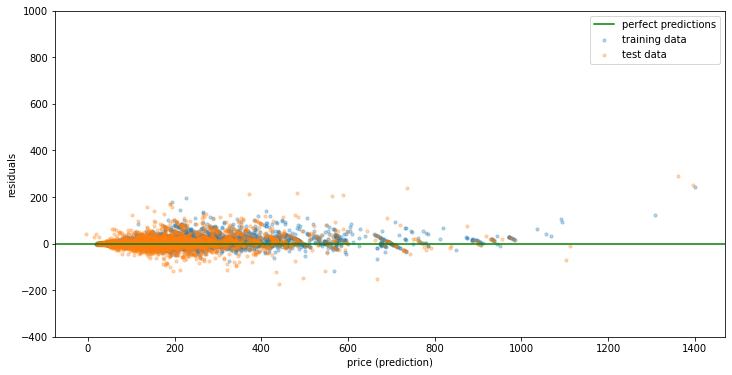

In [37]:
plt.figure(figsize=(12,6))
plt.scatter(y_pred_train, y_train.reshape(len(y_train),)-y_pred_train, s=10, alpha=0.3, label='training data')
plt.scatter(y_pred_test, y_test.reshape(len(y_test),)-y_pred_test, s=10, alpha=0.3, label='test data')
plt.axhline(c='g', label='perfect predictions')
plt.xlabel("price (prediction)")
plt.ylabel("residuals")
plt.ylim(-400, 1000)
plt.legend()

Performance in terms of metrics are slightly worse than that of random forest regression. Because of log squared error underestimating errors of outliers, predictions in higher price range are not as good as random forest trained with MSE. However overfitting in lower price range looks reduced.

The biggest downside of this model might be that there are a prediction of negative price.

#### Feature importance by XGBoost

XGBoost can also estimate feature importance

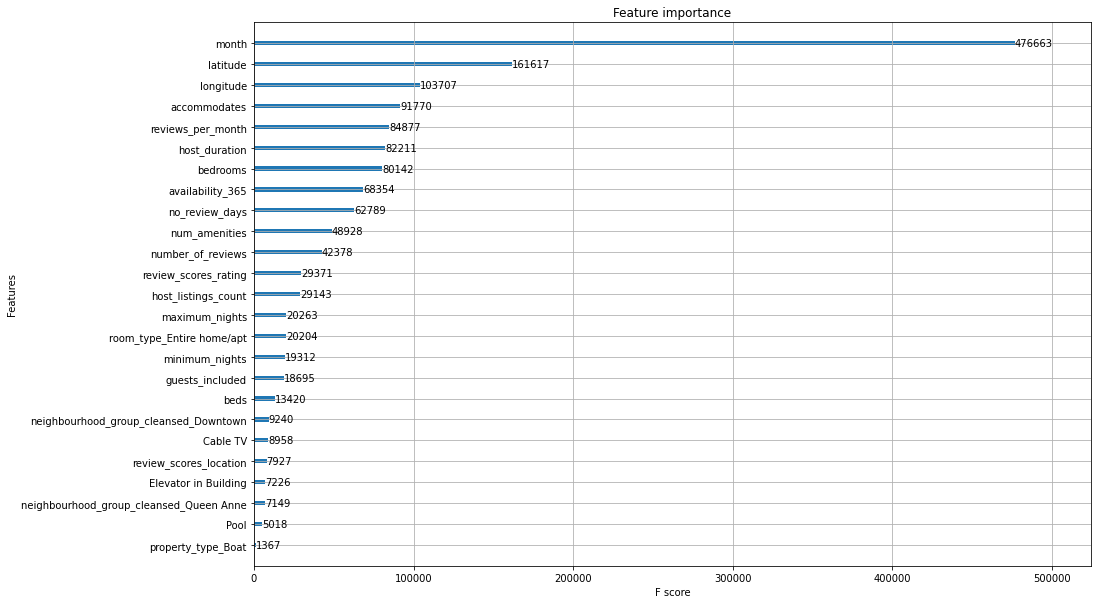

In [38]:
fig, ax = plt.subplots(figsize=(15,10))
plot_importance(xgb, ax=ax)
None

### Neural Network

In [43]:
from tensorflow import keras
from tensorflow.keras import layers

Lastly I used Multilayer Perceptron. I startred with a small number of layers and units and increased them gradually.

Keras offers mean absolute percentage error as loss function, so I trained the model so that it minimizes this metric, expecting it gives more accurate prediction in lower price range.

In [44]:
def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='relu')
    ])
    
    #lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-1, decay_steps=1, decay_rate=0.9)
    #optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(loss='mape', optimizer=optimizer, metrics=['mape'])
    
    return model

#### Standard Scaler

Until now I didn't scale independent variables since tree-based models do not depend on the scale of variables. However neural networks converges more efficiently with scaled inputs.

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Cross validation

Cross validation with 3-folds

In [58]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=500)

In [ ]:
kfold = KFold(n_splits=3).split(X_train_scaled, y_train) 
mae = []
mape = []
r2 = []
for i, (train, valid) in enumerate(kfold):
    mlp = build_model()
    mlp.fit(X_train_scaled[train], y_train[train], 
                epochs=10000, 
                validation_data=(X_train_scaled[valid], y_train[valid]), 
                callbacks=[early_stop],
                batch_size=1000)
    
    y_pred_valid = mlp.predict(X_train_scaled[valid])
    
    mae_valid = np.sqrt(mean_absolute_error(y_train[valid], y_pred_valid))
    mape_valid = mean_absolute_percentage_error(y_train[valid], y_pred_valid)
    r2_valid = r2_score(y_train[valid], y_pred_valid)
    
    mae.append(mae_valid)
    mape.append(mape_valid)
    r2.append(r2_valid)
    print(f"Fold {i} - MAPE: {mape_valid: .3f}")

Epoch 1/10000
15/15 [==============================] - 1s 44ms/step - loss: 96.6589 - mape: 96.6589 - val_loss: 82.8445 - val_mape: 82.8445
Epoch 2/10000
15/15 [==============================] - 0s 16ms/step - loss: 59.5711 - mape: 59.5711 - val_loss: 43.7220 - val_mape: 43.7220
Epoch 3/10000
15/15 [==============================] - 0s 18ms/step - loss: 38.8637 - mape: 38.8637 - val_loss: 33.6836 - val_mape: 33.6836
Epoch 4/10000
15/15 [==============================] - 0s 19ms/step - loss: 31.5887 - mape: 31.5887 - val_loss: 29.6307 - val_mape: 29.6307
Epoch 5/10000
15/15 [==============================] - 0s 19ms/step - loss: 28.6625 - mape: 28.6625 - val_loss: 27.9514 - val_mape: 27.9514
Epoch 6/10000
15/15 [==============================] - 0s 19ms/step - loss: 27.2789 - mape: 27.2789 - val_loss: 26.8947 - val_mape: 26.8947
Epoch 7/10000
15/15 [==============================] - 0s 19ms/step - loss: 26.4137 - mape: 26.4137 - val_loss: 26.0910 - val_mape: 26.0910
Epoch 8/10000
15/15 

Epoch 59/10000
15/15 [==============================] - 0s 29ms/step - loss: 11.6695 - mape: 11.6695 - val_loss: 14.2423 - val_mape: 14.2423
Epoch 60/10000
15/15 [==============================] - 0s 17ms/step - loss: 11.8210 - mape: 11.8210 - val_loss: 13.9906 - val_mape: 13.9906
Epoch 61/10000
15/15 [==============================] - 0s 17ms/step - loss: 11.7672 - mape: 11.7672 - val_loss: 14.3598 - val_mape: 14.3598
Epoch 62/10000
15/15 [==============================] - 0s 20ms/step - loss: 11.6502 - mape: 11.6502 - val_loss: 14.2439 - val_mape: 14.2439
Epoch 63/10000
15/15 [==============================] - 0s 25ms/step - loss: 11.6038 - mape: 11.6038 - val_loss: 13.6284 - val_mape: 13.6284
Epoch 64/10000
15/15 [==============================] - 0s 16ms/step - loss: 11.3555 - mape: 11.3555 - val_loss: 13.5133 - val_mape: 13.5133
Epoch 65/10000
15/15 [==============================] - 0s 16ms/step - loss: 11.1154 - mape: 11.1154 - val_loss: 13.2563 - val_mape: 13.2563
Epoch 66/1000

Epoch 176/10000
15/15 [==============================] - 0s 16ms/step - loss: 7.1838 - mape: 7.1838 - val_loss: 9.6850 - val_mape: 9.6850
Epoch 177/10000
15/15 [==============================] - 0s 16ms/step - loss: 6.8135 - mape: 6.8135 - val_loss: 9.4544 - val_mape: 9.4544
Epoch 178/10000
15/15 [==============================] - 0s 17ms/step - loss: 6.9400 - mape: 6.9400 - val_loss: 9.3996 - val_mape: 9.3996
Epoch 179/10000
15/15 [==============================] - 0s 17ms/step - loss: 6.6547 - mape: 6.6547 - val_loss: 9.4062 - val_mape: 9.4062
Epoch 180/10000
15/15 [==============================] - 0s 16ms/step - loss: 6.6811 - mape: 6.6811 - val_loss: 9.3265 - val_mape: 9.3265
Epoch 181/10000
15/15 [==============================] - 0s 17ms/step - loss: 6.8086 - mape: 6.8086 - val_loss: 9.5722 - val_mape: 9.5722
Epoch 182/10000
15/15 [==============================] - 0s 17ms/step - loss: 6.9848 - mape: 6.9848 - val_loss: 9.6770 - val_mape: 9.6770
Epoch 183/10000
15/15 [===========

15/15 [==============================] - 0s 19ms/step - loss: 5.5801 - mape: 5.5801 - val_loss: 8.4747 - val_mape: 8.4747
Epoch 295/10000
15/15 [==============================] - 0s 19ms/step - loss: 6.0703 - mape: 6.0703 - val_loss: 8.4431 - val_mape: 8.4431
Epoch 296/10000
15/15 [==============================] - 0s 19ms/step - loss: 5.8236 - mape: 5.8236 - val_loss: 8.6041 - val_mape: 8.6041
Epoch 297/10000
15/15 [==============================] - 0s 17ms/step - loss: 5.5571 - mape: 5.5571 - val_loss: 8.4670 - val_mape: 8.4670
Epoch 298/10000
15/15 [==============================] - 0s 17ms/step - loss: 5.6986 - mape: 5.6986 - val_loss: 8.8073 - val_mape: 8.8073
Epoch 299/10000
15/15 [==============================] - 0s 19ms/step - loss: 5.7550 - mape: 5.7550 - val_loss: 8.9887 - val_mape: 8.9887
Epoch 300/10000
15/15 [==============================] - 0s 18ms/step - loss: 5.6276 - mape: 5.6276 - val_loss: 8.6398 - val_mape: 8.6398
Epoch 301/10000
15/15 [===========================

15/15 [==============================] - 0s 17ms/step - loss: 4.8835 - mape: 4.8835 - val_loss: 8.3375 - val_mape: 8.3375
Epoch 413/10000
15/15 [==============================] - 0s 18ms/step - loss: 5.4035 - mape: 5.4035 - val_loss: 8.0954 - val_mape: 8.0954
Epoch 414/10000
15/15 [==============================] - 0s 17ms/step - loss: 5.5171 - mape: 5.5171 - val_loss: 8.1648 - val_mape: 8.1648
Epoch 415/10000
15/15 [==============================] - 0s 18ms/step - loss: 5.1757 - mape: 5.1757 - val_loss: 8.4637 - val_mape: 8.4637
Epoch 416/10000
15/15 [==============================] - 0s 18ms/step - loss: 5.5284 - mape: 5.5284 - val_loss: 8.1693 - val_mape: 8.1693
Epoch 417/10000
15/15 [==============================] - 0s 16ms/step - loss: 5.2047 - mape: 5.2047 - val_loss: 8.4143 - val_mape: 8.4143
Epoch 418/10000
15/15 [==============================] - 0s 18ms/step - loss: 5.0143 - mape: 5.0143 - val_loss: 7.8236 - val_mape: 7.8236
Epoch 419/10000
15/15 [===========================

15/15 [==============================] - 0s 18ms/step - loss: 4.6389 - mape: 4.6389 - val_loss: 7.6421 - val_mape: 7.6421
Epoch 531/10000
15/15 [==============================] - 0s 16ms/step - loss: 4.4476 - mape: 4.4476 - val_loss: 7.6192 - val_mape: 7.6192
Epoch 532/10000
15/15 [==============================] - 0s 16ms/step - loss: 4.5749 - mape: 4.5749 - val_loss: 7.5941 - val_mape: 7.5941
Epoch 533/10000
15/15 [==============================] - 0s 18ms/step - loss: 4.4959 - mape: 4.4959 - val_loss: 7.9396 - val_mape: 7.9396
Epoch 534/10000
15/15 [==============================] - 0s 18ms/step - loss: 4.8161 - mape: 4.8161 - val_loss: 8.0333 - val_mape: 8.0333
Epoch 535/10000
15/15 [==============================] - 0s 17ms/step - loss: 4.8668 - mape: 4.8668 - val_loss: 7.6958 - val_mape: 7.6958
Epoch 536/10000
15/15 [==============================] - 0s 16ms/step - loss: 4.6409 - mape: 4.6409 - val_loss: 7.7179 - val_mape: 7.7179
Epoch 537/10000
15/15 [===========================

15/15 [==============================] - 0s 17ms/step - loss: 4.1892 - mape: 4.1892 - val_loss: 7.2754 - val_mape: 7.2754
Epoch 649/10000
15/15 [==============================] - 0s 15ms/step - loss: 4.6252 - mape: 4.6252 - val_loss: 7.9937 - val_mape: 7.9937
Epoch 650/10000
15/15 [==============================] - 0s 16ms/step - loss: 4.8752 - mape: 4.8752 - val_loss: 7.7188 - val_mape: 7.7188
Epoch 651/10000
15/15 [==============================] - 0s 18ms/step - loss: 4.3891 - mape: 4.3891 - val_loss: 7.3518 - val_mape: 7.3518
Epoch 652/10000
15/15 [==============================] - 0s 17ms/step - loss: 4.5960 - mape: 4.5960 - val_loss: 7.4095 - val_mape: 7.4095
Epoch 653/10000
15/15 [==============================] - 0s 16ms/step - loss: 4.4858 - mape: 4.4858 - val_loss: 7.6905 - val_mape: 7.6905
Epoch 654/10000
15/15 [==============================] - 0s 18ms/step - loss: 4.4320 - mape: 4.4320 - val_loss: 7.6011 - val_mape: 7.6011
Epoch 655/10000
15/15 [===========================

15/15 [==============================] - 0s 17ms/step - loss: 4.1251 - mape: 4.1251 - val_loss: 7.3230 - val_mape: 7.3230
Epoch 767/10000
15/15 [==============================] - 0s 16ms/step - loss: 4.0767 - mape: 4.0767 - val_loss: 7.1959 - val_mape: 7.1959
Epoch 768/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.7878 - mape: 3.7878 - val_loss: 7.1047 - val_mape: 7.1047
Epoch 769/10000
15/15 [==============================] - 0s 15ms/step - loss: 4.1031 - mape: 4.1031 - val_loss: 7.3759 - val_mape: 7.3759
Epoch 770/10000
15/15 [==============================] - 0s 16ms/step - loss: 4.2048 - mape: 4.2048 - val_loss: 7.3197 - val_mape: 7.3197
Epoch 771/10000
15/15 [==============================] - 0s 16ms/step - loss: 4.1970 - mape: 4.1970 - val_loss: 7.1315 - val_mape: 7.1315
Epoch 772/10000
15/15 [==============================] - 0s 15ms/step - loss: 4.4568 - mape: 4.4568 - val_loss: 7.7131 - val_mape: 7.7131
Epoch 773/10000
15/15 [===========================

15/15 [==============================] - 0s 17ms/step - loss: 3.8912 - mape: 3.8912 - val_loss: 6.9978 - val_mape: 6.9978
Epoch 885/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.9569 - mape: 3.9569 - val_loss: 7.7222 - val_mape: 7.7222
Epoch 886/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.9328 - mape: 3.9328 - val_loss: 7.0234 - val_mape: 7.0234
Epoch 887/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.6727 - mape: 3.6727 - val_loss: 6.9709 - val_mape: 6.9709
Epoch 888/10000
15/15 [==============================] - 0s 23ms/step - loss: 3.5402 - mape: 3.5402 - val_loss: 6.9616 - val_mape: 6.9616
Epoch 889/10000
15/15 [==============================] - 0s 15ms/step - loss: 4.0459 - mape: 4.0459 - val_loss: 7.1372 - val_mape: 7.1372
Epoch 890/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.8693 - mape: 3.8693 - val_loss: 6.9847 - val_mape: 6.9847
Epoch 891/10000
15/15 [===========================

15/15 [==============================] - 0s 17ms/step - loss: 3.5401 - mape: 3.5401 - val_loss: 7.0287 - val_mape: 7.0287
Epoch 1003/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.7979 - mape: 3.7979 - val_loss: 6.9192 - val_mape: 6.9192
Epoch 1004/10000
15/15 [==============================] - 0s 15ms/step - loss: 3.8371 - mape: 3.8371 - val_loss: 7.0689 - val_mape: 7.0689
Epoch 1005/10000
15/15 [==============================] - 0s 15ms/step - loss: 3.5063 - mape: 3.5063 - val_loss: 7.2600 - val_mape: 7.2600
Epoch 1006/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.7965 - mape: 3.7965 - val_loss: 7.6644 - val_mape: 7.6644
Epoch 1007/10000
15/15 [==============================] - 0s 19ms/step - loss: 4.1160 - mape: 4.1160 - val_loss: 7.1789 - val_mape: 7.1789
Epoch 1008/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.6993 - mape: 3.6993 - val_loss: 6.9716 - val_mape: 6.9716
Epoch 1009/10000
15/15 [====================

15/15 [==============================] - 0s 17ms/step - loss: 3.5237 - mape: 3.5237 - val_loss: 7.2451 - val_mape: 7.2451
Epoch 1062/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.6272 - mape: 3.6272 - val_loss: 6.8663 - val_mape: 6.8663
Epoch 1063/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.3661 - mape: 3.3661 - val_loss: 6.8638 - val_mape: 6.8638
Epoch 1064/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.3306 - mape: 3.3306 - val_loss: 6.7902 - val_mape: 6.7902
Epoch 1065/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.5266 - mape: 3.5266 - val_loss: 6.8076 - val_mape: 6.8076
Epoch 1066/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.6659 - mape: 3.6659 - val_loss: 6.8983 - val_mape: 6.8983
Epoch 1067/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.5277 - mape: 3.5277 - val_loss: 6.8608 - val_mape: 6.8608
Epoch 1068/10000
15/15 [====================

15/15 [==============================] - 0s 17ms/step - loss: 4.0460 - mape: 4.0460 - val_loss: 6.8609 - val_mape: 6.8609
Epoch 1121/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.4978 - mape: 3.4978 - val_loss: 7.0874 - val_mape: 7.0874
Epoch 1122/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.8739 - mape: 3.8739 - val_loss: 7.4157 - val_mape: 7.4157
Epoch 1123/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.9243 - mape: 3.9243 - val_loss: 7.2222 - val_mape: 7.2222
Epoch 1124/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.7325 - mape: 3.7325 - val_loss: 6.9923 - val_mape: 6.9923
Epoch 1125/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.6900 - mape: 3.6900 - val_loss: 6.7566 - val_mape: 6.7566
Epoch 1126/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.4800 - mape: 3.4800 - val_loss: 6.8274 - val_mape: 6.8274
Epoch 1127/10000
15/15 [====================

15/15 [==============================] - 0s 17ms/step - loss: 3.3226 - mape: 3.3226 - val_loss: 6.8941 - val_mape: 6.8941
Epoch 1180/10000
15/15 [==============================] - 0s 15ms/step - loss: 3.3026 - mape: 3.3026 - val_loss: 6.8888 - val_mape: 6.8888
Epoch 1181/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.4699 - mape: 3.4699 - val_loss: 6.8234 - val_mape: 6.8234
Epoch 1182/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.4073 - mape: 3.4073 - val_loss: 6.7739 - val_mape: 6.7739
Epoch 1183/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.5907 - mape: 3.5907 - val_loss: 7.1080 - val_mape: 7.1080
Epoch 1184/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.6918 - mape: 3.6918 - val_loss: 7.1242 - val_mape: 7.1242
Epoch 1185/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.5638 - mape: 3.5638 - val_loss: 7.4404 - val_mape: 7.4404
Epoch 1186/10000
15/15 [====================

15/15 [==============================] - 0s 17ms/step - loss: 3.2686 - mape: 3.2686 - val_loss: 6.7110 - val_mape: 6.7110
Epoch 1239/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.2824 - mape: 3.2824 - val_loss: 6.6999 - val_mape: 6.6999
Epoch 1240/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.2141 - mape: 3.2141 - val_loss: 6.8443 - val_mape: 6.8443
Epoch 1241/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.3094 - mape: 3.3094 - val_loss: 6.8850 - val_mape: 6.8850
Epoch 1242/10000
15/15 [==============================] - 0s 19ms/step - loss: 3.3496 - mape: 3.3496 - val_loss: 7.3989 - val_mape: 7.3989
Epoch 1243/10000
15/15 [==============================] - 0s 15ms/step - loss: 3.7483 - mape: 3.7483 - val_loss: 7.0135 - val_mape: 7.0135
Epoch 1244/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.4200 - mape: 3.4200 - val_loss: 7.0315 - val_mape: 7.0315
Epoch 1245/10000
15/15 [====================

15/15 [==============================] - 0s 17ms/step - loss: 3.2316 - mape: 3.2316 - val_loss: 6.7585 - val_mape: 6.7585
Epoch 1298/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.2156 - mape: 3.2156 - val_loss: 6.7529 - val_mape: 6.7529
Epoch 1299/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.5015 - mape: 3.5015 - val_loss: 7.1957 - val_mape: 7.1957
Epoch 1300/10000
15/15 [==============================] - 0s 19ms/step - loss: 3.4253 - mape: 3.4253 - val_loss: 6.8468 - val_mape: 6.8468
Epoch 1301/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.1802 - mape: 3.1802 - val_loss: 6.9606 - val_mape: 6.9606
Epoch 1302/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.2960 - mape: 3.2960 - val_loss: 7.2095 - val_mape: 7.2095
Epoch 1303/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.3959 - mape: 3.3959 - val_loss: 6.9603 - val_mape: 6.9603
Epoch 1304/10000
15/15 [====================

15/15 [==============================] - 0s 16ms/step - loss: 3.1547 - mape: 3.1547 - val_loss: 7.3806 - val_mape: 7.3806
Epoch 1357/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.6552 - mape: 3.6552 - val_loss: 7.1356 - val_mape: 7.1356
Epoch 1358/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.6920 - mape: 3.6920 - val_loss: 7.2548 - val_mape: 7.2548
Epoch 1359/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.2765 - mape: 3.2765 - val_loss: 6.9059 - val_mape: 6.9059
Epoch 1360/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.4806 - mape: 3.4806 - val_loss: 7.1669 - val_mape: 7.1669
Epoch 1361/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.2895 - mape: 3.2895 - val_loss: 7.1211 - val_mape: 7.1211
Epoch 1362/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.2667 - mape: 3.2667 - val_loss: 6.9613 - val_mape: 6.9613
Epoch 1363/10000
15/15 [====================

Epoch 1474/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.2938 - mape: 3.2938 - val_loss: 7.0969 - val_mape: 7.0969
Epoch 1475/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.6596 - mape: 3.6596 - val_loss: 7.3656 - val_mape: 7.3656
Epoch 1476/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.3334 - mape: 3.3334 - val_loss: 7.1677 - val_mape: 7.1677
Epoch 1477/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.1152 - mape: 3.1152 - val_loss: 6.8517 - val_mape: 6.8517
Epoch 1478/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.1561 - mape: 3.1561 - val_loss: 6.7370 - val_mape: 6.7370
Epoch 1479/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.9581 - mape: 2.9581 - val_loss: 6.7191 - val_mape: 6.7191
Epoch 1480/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.2747 - mape: 3.2747 - val_loss: 7.6726 - val_mape: 7.6726
Epoch 1481/10000
15/15 [===

15/15 [==============================] - 0s 17ms/step - loss: 3.0040 - mape: 3.0040 - val_loss: 6.7218 - val_mape: 6.7218
Epoch 1592/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.0088 - mape: 3.0088 - val_loss: 6.7882 - val_mape: 6.7882
Epoch 1593/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.3421 - mape: 3.3421 - val_loss: 6.9837 - val_mape: 6.9837
Epoch 1594/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.3186 - mape: 3.3186 - val_loss: 6.8988 - val_mape: 6.8988
Epoch 1595/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.2975 - mape: 3.2975 - val_loss: 6.9614 - val_mape: 6.9614
Epoch 1596/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.1705 - mape: 3.1705 - val_loss: 6.8501 - val_mape: 6.8501
Epoch 1597/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.0430 - mape: 3.0430 - val_loss: 7.0112 - val_mape: 7.0112
Epoch 1598/10000
15/15 [====================

15/15 [==============================] - 0s 16ms/step - loss: 3.0488 - mape: 3.0488 - val_loss: 6.7022 - val_mape: 6.7022
Epoch 1651/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.1492 - mape: 3.1492 - val_loss: 7.4114 - val_mape: 7.4114
Epoch 1652/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.6356 - mape: 3.6356 - val_loss: 6.9803 - val_mape: 6.9803
Epoch 1653/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.3230 - mape: 3.3230 - val_loss: 6.8621 - val_mape: 6.8621
Epoch 1654/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.2211 - mape: 3.2211 - val_loss: 6.7681 - val_mape: 6.7681
Epoch 1655/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.2600 - mape: 3.2600 - val_loss: 6.9003 - val_mape: 6.9003
Epoch 1656/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.0931 - mape: 3.0931 - val_loss: 6.9973 - val_mape: 6.9973
Epoch 1657/10000
15/15 [====================

15/15 [==============================] - 0s 18ms/step - loss: 3.6325 - mape: 3.6325 - val_loss: 6.8229 - val_mape: 6.8229
Epoch 1710/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.2760 - mape: 3.2760 - val_loss: 6.9647 - val_mape: 6.9647
Epoch 1711/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.0053 - mape: 3.0053 - val_loss: 6.8396 - val_mape: 6.8396
Epoch 1712/10000
15/15 [==============================] - 0s 15ms/step - loss: 2.8584 - mape: 2.8584 - val_loss: 6.7875 - val_mape: 6.7875
Epoch 1713/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.9443 - mape: 2.9443 - val_loss: 6.7616 - val_mape: 6.7616
Epoch 1714/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.8966 - mape: 2.8966 - val_loss: 7.0672 - val_mape: 7.0672
Epoch 1715/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.3334 - mape: 3.3334 - val_loss: 7.1802 - val_mape: 7.1802
Epoch 1716/10000
15/15 [====================

15/15 [==============================] - 0s 16ms/step - loss: 3.0765 - mape: 3.0765 - val_loss: 6.7754 - val_mape: 6.7754
Epoch 1769/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.9445 - mape: 2.9445 - val_loss: 6.7469 - val_mape: 6.7469
Epoch 1770/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.0063 - mape: 3.0063 - val_loss: 7.5597 - val_mape: 7.5597
Epoch 1771/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.2688 - mape: 3.2688 - val_loss: 6.7921 - val_mape: 6.7921
Epoch 1772/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.9891 - mape: 2.9891 - val_loss: 6.7323 - val_mape: 6.7323
Epoch 1773/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.8135 - mape: 2.8135 - val_loss: 6.7783 - val_mape: 6.7783
Epoch 1774/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.8392 - mape: 2.8392 - val_loss: 6.7148 - val_mape: 6.7148
Epoch 1775/10000
15/15 [====================

15/15 [==============================] - 0s 17ms/step - loss: 2.8666 - mape: 2.8666 - val_loss: 6.7032 - val_mape: 6.7032
Epoch 1828/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.2261 - mape: 3.2261 - val_loss: 6.7876 - val_mape: 6.7876
Epoch 1829/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.9005 - mape: 2.9005 - val_loss: 6.9446 - val_mape: 6.9446
Epoch 1830/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.3401 - mape: 3.3401 - val_loss: 6.8264 - val_mape: 6.8264
Epoch 1831/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.8631 - mape: 2.8631 - val_loss: 6.8561 - val_mape: 6.8561
Epoch 1832/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.9985 - mape: 2.9985 - val_loss: 6.6321 - val_mape: 6.6321
Epoch 1833/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.7882 - mape: 2.7882 - val_loss: 6.9894 - val_mape: 6.9894
Epoch 1834/10000
15/15 [====================

Epoch 1886/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.8205 - mape: 2.8205 - val_loss: 6.7839 - val_mape: 6.7839
Epoch 1887/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.7667 - mape: 2.7667 - val_loss: 6.7257 - val_mape: 6.7257
Epoch 1888/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.7833 - mape: 2.7833 - val_loss: 6.8132 - val_mape: 6.8132
Epoch 1889/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.9133 - mape: 2.9133 - val_loss: 6.6598 - val_mape: 6.6598
Epoch 1890/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.8126 - mape: 2.8126 - val_loss: 6.7007 - val_mape: 6.7007
Epoch 1891/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.8461 - mape: 2.8461 - val_loss: 6.9193 - val_mape: 6.9193
Epoch 1892/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.9655 - mape: 2.9655 - val_loss: 6.9484 - val_mape: 6.9484
Epoch 1893/10000
15/15 [===

Epoch 1945/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.7043 - mape: 2.7043 - val_loss: 6.6006 - val_mape: 6.6006
Epoch 1946/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.6912 - mape: 2.6912 - val_loss: 7.4127 - val_mape: 7.4127
Epoch 1947/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.2315 - mape: 3.2315 - val_loss: 7.0085 - val_mape: 7.0085
Epoch 1948/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.2996 - mape: 3.2996 - val_loss: 6.8786 - val_mape: 6.8786
Epoch 1949/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.8031 - mape: 2.8031 - val_loss: 6.7104 - val_mape: 6.7104
Epoch 1950/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.8452 - mape: 2.8452 - val_loss: 7.0041 - val_mape: 7.0041
Epoch 1951/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.8966 - mape: 2.8966 - val_loss: 6.6690 - val_mape: 6.6690
Epoch 1952/10000
15/15 [===

Epoch 2004/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.6413 - mape: 2.6413 - val_loss: 6.6743 - val_mape: 6.6743
Epoch 2005/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.5316 - mape: 2.5316 - val_loss: 6.6346 - val_mape: 6.6346
Epoch 2006/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.5251 - mape: 2.5251 - val_loss: 6.7261 - val_mape: 6.7261
Epoch 2007/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.7394 - mape: 2.7394 - val_loss: 6.6610 - val_mape: 6.6610
Epoch 2008/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.6424 - mape: 2.6424 - val_loss: 6.6726 - val_mape: 6.6726
Epoch 2009/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.8009 - mape: 2.8009 - val_loss: 6.9369 - val_mape: 6.9369
Epoch 2010/10000
15/15 [==============================] - 0s 19ms/step - loss: 3.1882 - mape: 3.1882 - val_loss: 7.1403 - val_mape: 7.1403
Epoch 2011/10000
15/15 [===

Epoch 2063/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.6502 - mape: 2.6502 - val_loss: 6.7398 - val_mape: 6.7398
Epoch 2064/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.7893 - mape: 2.7893 - val_loss: 6.7368 - val_mape: 6.7368
Epoch 2065/10000
15/15 [==============================] - 0s 15ms/step - loss: 2.7699 - mape: 2.7699 - val_loss: 6.7802 - val_mape: 6.7802
Epoch 2066/10000
15/15 [==============================] - 0s 14ms/step - loss: 2.6416 - mape: 2.6416 - val_loss: 6.7808 - val_mape: 6.7808
Epoch 2067/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.7952 - mape: 2.7952 - val_loss: 6.7474 - val_mape: 6.7474
Epoch 2068/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.6078 - mape: 2.6078 - val_loss: 6.9865 - val_mape: 6.9865
Epoch 2069/10000
15/15 [==============================] - 0s 15ms/step - loss: 2.6925 - mape: 2.6925 - val_loss: 6.6008 - val_mape: 6.6008
Epoch 2070/10000
15/15 [===

Epoch 2122/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.6376 - mape: 2.6376 - val_loss: 7.0488 - val_mape: 7.0488
Epoch 2123/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.6599 - mape: 2.6599 - val_loss: 6.6769 - val_mape: 6.6769
Epoch 2124/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.5522 - mape: 2.5522 - val_loss: 6.6984 - val_mape: 6.6984
Epoch 2125/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.5883 - mape: 2.5883 - val_loss: 6.6616 - val_mape: 6.6616
Epoch 2126/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.7803 - mape: 2.7803 - val_loss: 6.6286 - val_mape: 6.6286
Epoch 2127/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.4907 - mape: 2.4907 - val_loss: 6.5811 - val_mape: 6.5811
Epoch 2128/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.6168 - mape: 2.6168 - val_loss: 6.8743 - val_mape: 6.8743
Epoch 2129/10000
15/15 [===

Epoch 2181/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.7707 - mape: 2.7707 - val_loss: 6.6668 - val_mape: 6.6668
Epoch 2182/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.6163 - mape: 2.6163 - val_loss: 6.6048 - val_mape: 6.6048
Epoch 2183/10000
15/15 [==============================] - 0s 14ms/step - loss: 2.5461 - mape: 2.5461 - val_loss: 6.7430 - val_mape: 6.7430
Epoch 2184/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.5724 - mape: 2.5724 - val_loss: 6.7306 - val_mape: 6.7306
Epoch 2185/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.5735 - mape: 2.5735 - val_loss: 6.6887 - val_mape: 6.6887
Epoch 2186/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.5155 - mape: 2.5155 - val_loss: 6.5958 - val_mape: 6.5958
Epoch 2187/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.6752 - mape: 2.6752 - val_loss: 6.7869 - val_mape: 6.7869
Epoch 2188/10000
15/15 [===

Epoch 2240/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.6860 - mape: 2.6860 - val_loss: 6.6185 - val_mape: 6.6185
Epoch 2241/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.5495 - mape: 2.5495 - val_loss: 6.7650 - val_mape: 6.7650
Epoch 2242/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.7669 - mape: 2.7669 - val_loss: 6.6889 - val_mape: 6.6889
Epoch 2243/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.7115 - mape: 2.7115 - val_loss: 6.7589 - val_mape: 6.7589
Epoch 2244/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.8018 - mape: 2.8018 - val_loss: 6.8447 - val_mape: 6.8447
Epoch 2245/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.5973 - mape: 2.5973 - val_loss: 6.6985 - val_mape: 6.6985
Epoch 2246/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.5527 - mape: 2.5527 - val_loss: 6.7421 - val_mape: 6.7421
Epoch 2247/10000
15/15 [===

Epoch 2299/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.8032 - mape: 2.8032 - val_loss: 6.8344 - val_mape: 6.8344
Epoch 2300/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.5718 - mape: 2.5718 - val_loss: 6.6474 - val_mape: 6.6474
Epoch 2301/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.4687 - mape: 2.4687 - val_loss: 6.7060 - val_mape: 6.7060
Epoch 2302/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.5730 - mape: 2.5730 - val_loss: 6.6417 - val_mape: 6.6417
Epoch 2303/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.5672 - mape: 2.5672 - val_loss: 6.6294 - val_mape: 6.6294
Epoch 2304/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.5390 - mape: 2.5390 - val_loss: 6.6241 - val_mape: 6.6241
Epoch 2305/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.5713 - mape: 2.5713 - val_loss: 6.7065 - val_mape: 6.7065
Epoch 2306/10000
15/15 [===

Epoch 2358/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.6724 - mape: 2.6724 - val_loss: 6.9124 - val_mape: 6.9124
Epoch 2359/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.6606 - mape: 2.6606 - val_loss: 6.7858 - val_mape: 6.7858
Epoch 2360/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.5214 - mape: 2.5214 - val_loss: 6.6961 - val_mape: 6.6961
Epoch 2361/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.3660 - mape: 2.3660 - val_loss: 6.6518 - val_mape: 6.6518
Epoch 2362/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.4593 - mape: 2.4593 - val_loss: 7.1480 - val_mape: 7.1480
Epoch 2363/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.7595 - mape: 2.7595 - val_loss: 6.8339 - val_mape: 6.8339
Epoch 2364/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.6993 - mape: 2.6993 - val_loss: 6.7619 - val_mape: 6.7619
Epoch 2365/10000
15/15 [===

Epoch 2417/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.5928 - mape: 2.5928 - val_loss: 6.8653 - val_mape: 6.8653
Epoch 2418/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.6220 - mape: 2.6220 - val_loss: 6.7346 - val_mape: 6.7346
Epoch 2419/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.6023 - mape: 2.6023 - val_loss: 6.8042 - val_mape: 6.8042
Epoch 2420/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.6967 - mape: 2.6967 - val_loss: 6.8659 - val_mape: 6.8659
Epoch 2421/10000
15/15 [==============================] - 0s 22ms/step - loss: 2.9433 - mape: 2.9433 - val_loss: 6.8270 - val_mape: 6.8270
Epoch 2422/10000
15/15 [==============================] - 0s 13ms/step - loss: 2.6660 - mape: 2.6660 - val_loss: 6.6754 - val_mape: 6.6754
Epoch 2423/10000
15/15 [==============================] - 0s 12ms/step - loss: 2.9267 - mape: 2.9267 - val_loss: 6.9697 - val_mape: 6.9697
Epoch 2424/10000
15/15 [===

Epoch 2476/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.7014 - mape: 2.7014 - val_loss: 6.7700 - val_mape: 6.7700
Epoch 2477/10000
15/15 [==============================] - 0s 21ms/step - loss: 2.4544 - mape: 2.4544 - val_loss: 6.7205 - val_mape: 6.7205
Epoch 2478/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.3321 - mape: 2.3321 - val_loss: 6.7106 - val_mape: 6.7106
Epoch 2479/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.3858 - mape: 2.3858 - val_loss: 6.6212 - val_mape: 6.6212
Epoch 2480/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.8086 - mape: 2.8086 - val_loss: 6.7261 - val_mape: 6.7261
Epoch 2481/10000
15/15 [==============================] - 0s 20ms/step - loss: 2.6639 - mape: 2.6639 - val_loss: 6.6743 - val_mape: 6.6743
Epoch 2482/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.4790 - mape: 2.4790 - val_loss: 6.8371 - val_mape: 6.8371
Epoch 2483/10000
15/15 [===

Epoch 2535/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.5842 - mape: 2.5842 - val_loss: 6.6775 - val_mape: 6.6775
Epoch 2536/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.5172 - mape: 2.5172 - val_loss: 6.6462 - val_mape: 6.6462
Epoch 2537/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.4612 - mape: 2.4612 - val_loss: 6.6650 - val_mape: 6.6650
Epoch 2538/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.3949 - mape: 2.3949 - val_loss: 6.6524 - val_mape: 6.6524
Epoch 2539/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.8684 - mape: 2.8684 - val_loss: 6.7141 - val_mape: 6.7141
Epoch 2540/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.7486 - mape: 2.7486 - val_loss: 6.7927 - val_mape: 6.7927
Epoch 2541/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.6256 - mape: 2.6256 - val_loss: 6.6442 - val_mape: 6.6442
Epoch 2542/10000
15/15 [===

Epoch 2594/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.5958 - mape: 2.5958 - val_loss: 6.6963 - val_mape: 6.6963
Epoch 2595/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.5465 - mape: 2.5465 - val_loss: 6.6828 - val_mape: 6.6828
Epoch 2596/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.6156 - mape: 2.6156 - val_loss: 6.8070 - val_mape: 6.8070
Epoch 2597/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.6204 - mape: 2.6204 - val_loss: 6.7280 - val_mape: 6.7280
Epoch 2598/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.5286 - mape: 2.5286 - val_loss: 6.6752 - val_mape: 6.6752
Epoch 2599/10000
15/15 [==============================] - 0s 15ms/step - loss: 2.3772 - mape: 2.3772 - val_loss: 6.7372 - val_mape: 6.7372
Epoch 2600/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.3800 - mape: 2.3800 - val_loss: 6.6959 - val_mape: 6.6959
Epoch 2601/10000
15/15 [===

Epoch 2653/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.6317 - mape: 2.6317 - val_loss: 6.9253 - val_mape: 6.9253
Epoch 2654/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.6927 - mape: 2.6927 - val_loss: 6.9382 - val_mape: 6.9382
Epoch 2655/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.5464 - mape: 2.5464 - val_loss: 6.7811 - val_mape: 6.7811
Epoch 2656/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.3991 - mape: 2.3991 - val_loss: 6.8299 - val_mape: 6.8299
Epoch 2657/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.6149 - mape: 2.6149 - val_loss: 6.9451 - val_mape: 6.9451
Epoch 2658/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.4103 - mape: 2.4103 - val_loss: 6.7727 - val_mape: 6.7727
Epoch 2659/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.5500 - mape: 2.5500 - val_loss: 6.7007 - val_mape: 6.7007
Epoch 2660/10000
15/15 [===

Epoch 2712/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.9076 - mape: 2.9076 - val_loss: 6.7092 - val_mape: 6.7092
Epoch 2713/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.9959 - mape: 2.9959 - val_loss: 6.7795 - val_mape: 6.7795
Epoch 2714/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.8040 - mape: 2.8040 - val_loss: 6.8298 - val_mape: 6.8298
Epoch 2715/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.5083 - mape: 2.5083 - val_loss: 6.5808 - val_mape: 6.5808
Epoch 2716/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.2753 - mape: 2.2753 - val_loss: 6.5343 - val_mape: 6.5343
Epoch 2717/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.2976 - mape: 2.2976 - val_loss: 6.5644 - val_mape: 6.5644
Epoch 2718/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.2751 - mape: 2.2751 - val_loss: 6.7938 - val_mape: 6.7938
Epoch 2719/10000
15/15 [===

Epoch 2771/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.2367 - mape: 2.2367 - val_loss: 7.0802 - val_mape: 7.0802
Epoch 2772/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.3789 - mape: 2.3789 - val_loss: 6.5857 - val_mape: 6.5857
Epoch 2773/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.2814 - mape: 2.2814 - val_loss: 6.6928 - val_mape: 6.6928
Epoch 2774/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.4644 - mape: 2.4644 - val_loss: 6.6378 - val_mape: 6.6378
Epoch 2775/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.3922 - mape: 2.3922 - val_loss: 6.6709 - val_mape: 6.6709
Epoch 2776/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.5372 - mape: 2.5372 - val_loss: 7.0849 - val_mape: 7.0849
Epoch 2777/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.7746 - mape: 2.7746 - val_loss: 6.6626 - val_mape: 6.6626
Epoch 2778/10000
15/15 [===

Epoch 2830/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.4032 - mape: 2.4032 - val_loss: 6.7083 - val_mape: 6.7083
Epoch 2831/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.3282 - mape: 2.3282 - val_loss: 7.0019 - val_mape: 7.0019
Epoch 2832/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.4600 - mape: 2.4600 - val_loss: 6.5785 - val_mape: 6.5785
Epoch 2833/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.2676 - mape: 2.2676 - val_loss: 6.7037 - val_mape: 6.7037
Epoch 2834/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.2995 - mape: 2.2995 - val_loss: 6.7321 - val_mape: 6.7321
Epoch 2835/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.2907 - mape: 2.2907 - val_loss: 6.6198 - val_mape: 6.6198
Epoch 2836/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.2472 - mape: 2.2472 - val_loss: 6.6564 - val_mape: 6.6564
Epoch 2837/10000
15/15 [===

Epoch 2889/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.2662 - mape: 2.2662 - val_loss: 6.5017 - val_mape: 6.5017
Epoch 2890/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.1947 - mape: 2.1947 - val_loss: 6.6306 - val_mape: 6.6306
Epoch 2891/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.3501 - mape: 2.3501 - val_loss: 6.7347 - val_mape: 6.7347
Epoch 2892/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.1896 - mape: 2.1896 - val_loss: 6.5344 - val_mape: 6.5344
Epoch 2893/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.1863 - mape: 2.1863 - val_loss: 6.5349 - val_mape: 6.5349
Epoch 2894/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.3833 - mape: 2.3833 - val_loss: 6.7163 - val_mape: 6.7163
Epoch 2895/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.5334 - mape: 2.5334 - val_loss: 6.6449 - val_mape: 6.6449
Epoch 2896/10000
15/15 [===

Epoch 2948/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.3241 - mape: 2.3241 - val_loss: 6.7116 - val_mape: 6.7116
Epoch 2949/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.2498 - mape: 2.2498 - val_loss: 6.5363 - val_mape: 6.5363
Epoch 2950/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.4590 - mape: 2.4590 - val_loss: 6.6232 - val_mape: 6.6232
Epoch 2951/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.4831 - mape: 2.4831 - val_loss: 6.6523 - val_mape: 6.6523
Epoch 2952/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.2053 - mape: 2.2053 - val_loss: 6.6519 - val_mape: 6.6519
Epoch 2953/10000
15/15 [==============================] - 0s 15ms/step - loss: 2.3971 - mape: 2.3971 - val_loss: 6.5389 - val_mape: 6.5389
Epoch 2954/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.6144 - mape: 2.6144 - val_loss: 6.8884 - val_mape: 6.8884
Epoch 2955/10000
15/15 [===

Epoch 3007/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.2068 - mape: 2.2068 - val_loss: 6.5957 - val_mape: 6.5957
Epoch 3008/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.4748 - mape: 2.4748 - val_loss: 6.6117 - val_mape: 6.6117
Epoch 3009/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.2556 - mape: 2.2556 - val_loss: 6.6062 - val_mape: 6.6062
Epoch 3010/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.5148 - mape: 2.5148 - val_loss: 6.6149 - val_mape: 6.6149
Epoch 3011/10000
15/15 [==============================] - 0s 15ms/step - loss: 2.3174 - mape: 2.3174 - val_loss: 6.7317 - val_mape: 6.7317
Epoch 3012/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.2478 - mape: 2.2478 - val_loss: 6.5837 - val_mape: 6.5837
Epoch 3013/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.2881 - mape: 2.2881 - val_loss: 6.7517 - val_mape: 6.7517
Epoch 3014/10000
15/15 [===

Epoch 3066/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.3685 - mape: 2.3685 - val_loss: 6.6501 - val_mape: 6.6501
Epoch 3067/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.3057 - mape: 2.3057 - val_loss: 6.6339 - val_mape: 6.6339
Epoch 3068/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.3301 - mape: 2.3301 - val_loss: 6.7002 - val_mape: 6.7002
Epoch 3069/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.2169 - mape: 2.2169 - val_loss: 6.6008 - val_mape: 6.6008
Epoch 3070/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.2317 - mape: 2.2317 - val_loss: 6.6179 - val_mape: 6.6179
Epoch 3071/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.2138 - mape: 2.2138 - val_loss: 6.7949 - val_mape: 6.7949
Epoch 3072/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.2440 - mape: 2.2440 - val_loss: 6.5881 - val_mape: 6.5881
Epoch 3073/10000
15/15 [===

Epoch 3125/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.4732 - mape: 2.4732 - val_loss: 6.7014 - val_mape: 6.7014
Epoch 3126/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.8777 - mape: 2.8777 - val_loss: 6.8557 - val_mape: 6.8557
Epoch 3127/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.5104 - mape: 2.5104 - val_loss: 6.9180 - val_mape: 6.9180
Epoch 3128/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.5261 - mape: 2.5261 - val_loss: 6.6124 - val_mape: 6.6124
Epoch 3129/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.1544 - mape: 2.1544 - val_loss: 6.6188 - val_mape: 6.6188
Epoch 3130/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.1222 - mape: 2.1222 - val_loss: 6.7292 - val_mape: 6.7292
Epoch 3131/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.2770 - mape: 2.2770 - val_loss: 6.6417 - val_mape: 6.6417
Epoch 3132/10000
15/15 [===

Epoch 3184/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.0679 - mape: 2.0679 - val_loss: 6.7936 - val_mape: 6.7936
Epoch 3185/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.2826 - mape: 2.2826 - val_loss: 6.7419 - val_mape: 6.7419
Epoch 3186/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.3245 - mape: 2.3245 - val_loss: 6.5624 - val_mape: 6.5624
Epoch 3187/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.3850 - mape: 2.3850 - val_loss: 6.8631 - val_mape: 6.8631
Epoch 3188/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.1410 - mape: 2.1410 - val_loss: 6.5988 - val_mape: 6.5988
Epoch 3189/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.2104 - mape: 2.2104 - val_loss: 6.6124 - val_mape: 6.6124
Epoch 3190/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.1070 - mape: 2.1070 - val_loss: 6.7499 - val_mape: 6.7499
Epoch 3191/10000
15/15 [===

Epoch 3243/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.1787 - mape: 2.1787 - val_loss: 6.7261 - val_mape: 6.7261
Epoch 3244/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.1486 - mape: 2.1486 - val_loss: 6.6164 - val_mape: 6.6164
Epoch 3245/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.0512 - mape: 2.0512 - val_loss: 6.5867 - val_mape: 6.5867
Epoch 3246/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.1968 - mape: 2.1968 - val_loss: 6.5971 - val_mape: 6.5971
Epoch 3247/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.2014 - mape: 2.2014 - val_loss: 6.5960 - val_mape: 6.5960
Epoch 3248/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.0576 - mape: 2.0576 - val_loss: 6.6100 - val_mape: 6.6100
Epoch 3249/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.2179 - mape: 2.2179 - val_loss: 6.6962 - val_mape: 6.6962
Epoch 3250/10000
15/15 [===

Epoch 3302/10000
15/15 [==============================] - 0s 20ms/step - loss: 2.2020 - mape: 2.2020 - val_loss: 6.6147 - val_mape: 6.6147
Epoch 3303/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.1422 - mape: 2.1422 - val_loss: 6.8406 - val_mape: 6.8406
Epoch 3304/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.3937 - mape: 2.3937 - val_loss: 6.7984 - val_mape: 6.7984
Epoch 3305/10000
15/15 [==============================] - 0s 20ms/step - loss: 2.1271 - mape: 2.1271 - val_loss: 6.6442 - val_mape: 6.6442
Epoch 3306/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.2494 - mape: 2.2494 - val_loss: 6.5660 - val_mape: 6.5660
Epoch 3307/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.2261 - mape: 2.2261 - val_loss: 6.6249 - val_mape: 6.6249
Epoch 3308/10000
15/15 [==============================] - 0s 21ms/step - loss: 2.0720 - mape: 2.0720 - val_loss: 6.7290 - val_mape: 6.7290
Epoch 3309/10000
15/15 [===

Epoch 3361/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.3151 - mape: 2.3151 - val_loss: 6.5893 - val_mape: 6.5893
Epoch 3362/10000
15/15 [==============================] - 0s 15ms/step - loss: 2.0855 - mape: 2.0855 - val_loss: 6.5614 - val_mape: 6.5614
Epoch 3363/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.1827 - mape: 2.1827 - val_loss: 7.0233 - val_mape: 7.0233
Epoch 3364/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.5764 - mape: 2.5764 - val_loss: 6.6657 - val_mape: 6.6657
Epoch 3365/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.3005 - mape: 2.3005 - val_loss: 6.8187 - val_mape: 6.8187
Epoch 3366/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.4836 - mape: 2.4836 - val_loss: 7.4164 - val_mape: 7.4164
Epoch 3367/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.5715 - mape: 2.5715 - val_loss: 6.6407 - val_mape: 6.6407
Epoch 3368/10000
15/15 [===

Epoch 12/10000
15/15 [==============================] - 0s 17ms/step - loss: 23.4593 - mape: 23.4593 - val_loss: 23.7348 - val_mape: 23.7348
Epoch 13/10000
15/15 [==============================] - 0s 17ms/step - loss: 22.9413 - mape: 22.9413 - val_loss: 23.7383 - val_mape: 23.7383
Epoch 14/10000
15/15 [==============================] - 0s 15ms/step - loss: 22.5216 - mape: 22.5216 - val_loss: 22.8346 - val_mape: 22.8346
Epoch 15/10000
15/15 [==============================] - 0s 16ms/step - loss: 21.9683 - mape: 21.9683 - val_loss: 22.2781 - val_mape: 22.2781
Epoch 16/10000
15/15 [==============================] - 0s 19ms/step - loss: 21.5324 - mape: 21.5324 - val_loss: 22.0073 - val_mape: 22.0073
Epoch 17/10000
15/15 [==============================] - 0s 17ms/step - loss: 21.0762 - mape: 21.0762 - val_loss: 21.5139 - val_mape: 21.5139
Epoch 18/10000
15/15 [==============================] - 0s 20ms/step - loss: 20.6191 - mape: 20.6191 - val_loss: 21.3070 - val_mape: 21.3070
Epoch 19/1000

15/15 [==============================] - 0s 19ms/step - loss: 10.5323 - mape: 10.5323 - val_loss: 12.6422 - val_mape: 12.6422
Epoch 71/10000
15/15 [==============================] - 0s 18ms/step - loss: 10.2472 - mape: 10.2472 - val_loss: 12.6425 - val_mape: 12.6425
Epoch 72/10000
15/15 [==============================] - 0s 20ms/step - loss: 10.1627 - mape: 10.1627 - val_loss: 12.6211 - val_mape: 12.6211
Epoch 73/10000
15/15 [==============================] - 0s 18ms/step - loss: 10.0223 - mape: 10.0223 - val_loss: 12.8278 - val_mape: 12.8278
Epoch 74/10000
15/15 [==============================] - 0s 18ms/step - loss: 10.4133 - mape: 10.4133 - val_loss: 12.9433 - val_mape: 12.9433
Epoch 75/10000
15/15 [==============================] - 0s 17ms/step - loss: 10.0838 - mape: 10.0838 - val_loss: 12.9431 - val_mape: 12.9431
Epoch 76/10000
15/15 [==============================] - 0s 17ms/step - loss: 10.2357 - mape: 10.2357 - val_loss: 12.5927 - val_mape: 12.5927
Epoch 77/10000
15/15 [======

Epoch 129/10000
15/15 [==============================] - 0s 16ms/step - loss: 7.6262 - mape: 7.6262 - val_loss: 10.6576 - val_mape: 10.6576
Epoch 130/10000
15/15 [==============================] - 0s 17ms/step - loss: 7.5256 - mape: 7.5256 - val_loss: 9.8809 - val_mape: 9.8809
Epoch 131/10000
15/15 [==============================] - 0s 18ms/step - loss: 7.5958 - mape: 7.5958 - val_loss: 10.2392 - val_mape: 10.2392
Epoch 132/10000
15/15 [==============================] - 0s 19ms/step - loss: 7.4037 - mape: 7.4037 - val_loss: 9.7638 - val_mape: 9.7638
Epoch 133/10000
15/15 [==============================] - 0s 17ms/step - loss: 7.2764 - mape: 7.2764 - val_loss: 9.7965 - val_mape: 9.7965
Epoch 134/10000
15/15 [==============================] - 0s 18ms/step - loss: 7.3773 - mape: 7.3773 - val_loss: 9.7886 - val_mape: 9.7886
Epoch 135/10000
15/15 [==============================] - 0s 16ms/step - loss: 7.2126 - mape: 7.2126 - val_loss: 9.9282 - val_mape: 9.9282
Epoch 136/10000
15/15 [=======

15/15 [==============================] - 0s 19ms/step - loss: 5.7302 - mape: 5.7302 - val_loss: 8.2079 - val_mape: 8.2079
Epoch 248/10000
15/15 [==============================] - 0s 17ms/step - loss: 5.7492 - mape: 5.7492 - val_loss: 8.3278 - val_mape: 8.3278
Epoch 249/10000
15/15 [==============================] - 0s 20ms/step - loss: 5.5681 - mape: 5.5681 - val_loss: 8.1187 - val_mape: 8.1187
Epoch 250/10000
15/15 [==============================] - 0s 17ms/step - loss: 5.4020 - mape: 5.4020 - val_loss: 8.1223 - val_mape: 8.1223
Epoch 251/10000
15/15 [==============================] - 0s 17ms/step - loss: 5.5681 - mape: 5.5681 - val_loss: 9.0165 - val_mape: 9.0165
Epoch 252/10000
15/15 [==============================] - 0s 19ms/step - loss: 6.2489 - mape: 6.2489 - val_loss: 8.2927 - val_mape: 8.2927
Epoch 253/10000
15/15 [==============================] - 0s 20ms/step - loss: 5.8706 - mape: 5.8706 - val_loss: 8.7490 - val_mape: 8.7490
Epoch 254/10000
15/15 [===========================

15/15 [==============================] - 0s 16ms/step - loss: 5.0600 - mape: 5.0600 - val_loss: 8.3221 - val_mape: 8.3221
Epoch 366/10000
15/15 [==============================] - 0s 17ms/step - loss: 5.1912 - mape: 5.1912 - val_loss: 7.4929 - val_mape: 7.4929
Epoch 367/10000
15/15 [==============================] - 0s 18ms/step - loss: 5.4466 - mape: 5.4466 - val_loss: 8.1736 - val_mape: 8.1736
Epoch 368/10000
15/15 [==============================] - 0s 17ms/step - loss: 5.2360 - mape: 5.2360 - val_loss: 7.5981 - val_mape: 7.5981
Epoch 369/10000
15/15 [==============================] - 0s 19ms/step - loss: 4.9678 - mape: 4.9678 - val_loss: 7.7087 - val_mape: 7.7087
Epoch 370/10000
15/15 [==============================] - 0s 17ms/step - loss: 5.1788 - mape: 5.1788 - val_loss: 7.9724 - val_mape: 7.9724
Epoch 371/10000
15/15 [==============================] - 0s 18ms/step - loss: 4.9376 - mape: 4.9376 - val_loss: 7.4242 - val_mape: 7.4242
Epoch 372/10000
15/15 [===========================

15/15 [==============================] - 0s 17ms/step - loss: 4.3889 - mape: 4.3889 - val_loss: 7.2083 - val_mape: 7.2083
Epoch 484/10000
15/15 [==============================] - 0s 17ms/step - loss: 4.3807 - mape: 4.3807 - val_loss: 7.5938 - val_mape: 7.5938
Epoch 485/10000
15/15 [==============================] - 0s 16ms/step - loss: 5.0202 - mape: 5.0202 - val_loss: 7.4957 - val_mape: 7.4957
Epoch 486/10000
15/15 [==============================] - 0s 15ms/step - loss: 4.6954 - mape: 4.6954 - val_loss: 7.3112 - val_mape: 7.3112
Epoch 487/10000
15/15 [==============================] - 0s 17ms/step - loss: 4.5774 - mape: 4.5774 - val_loss: 7.3260 - val_mape: 7.3260
Epoch 488/10000
15/15 [==============================] - 0s 16ms/step - loss: 4.4655 - mape: 4.4655 - val_loss: 7.3132 - val_mape: 7.3132
Epoch 489/10000
15/15 [==============================] - 0s 16ms/step - loss: 4.9416 - mape: 4.9416 - val_loss: 7.6392 - val_mape: 7.6392
Epoch 490/10000
15/15 [===========================

15/15 [==============================] - 0s 17ms/step - loss: 4.1880 - mape: 4.1880 - val_loss: 7.0244 - val_mape: 7.0244
Epoch 602/10000
15/15 [==============================] - 0s 17ms/step - loss: 4.3295 - mape: 4.3295 - val_loss: 7.0796 - val_mape: 7.0796
Epoch 603/10000
15/15 [==============================] - 0s 17ms/step - loss: 4.3722 - mape: 4.3722 - val_loss: 7.0636 - val_mape: 7.0636
Epoch 604/10000
15/15 [==============================] - 0s 17ms/step - loss: 4.0199 - mape: 4.0199 - val_loss: 6.9913 - val_mape: 6.9913
Epoch 605/10000
15/15 [==============================] - 0s 15ms/step - loss: 4.1461 - mape: 4.1461 - val_loss: 7.2203 - val_mape: 7.2203
Epoch 606/10000
15/15 [==============================] - 0s 17ms/step - loss: 4.3415 - mape: 4.3415 - val_loss: 7.1269 - val_mape: 7.1269
Epoch 607/10000
15/15 [==============================] - 0s 17ms/step - loss: 4.0800 - mape: 4.0800 - val_loss: 7.0674 - val_mape: 7.0674
Epoch 608/10000
15/15 [===========================

15/15 [==============================] - 0s 18ms/step - loss: 3.7459 - mape: 3.7459 - val_loss: 6.9396 - val_mape: 6.9396
Epoch 720/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.8482 - mape: 3.8482 - val_loss: 6.9114 - val_mape: 6.9114
Epoch 721/10000
15/15 [==============================] - 0s 19ms/step - loss: 3.9829 - mape: 3.9829 - val_loss: 6.9096 - val_mape: 6.9096
Epoch 722/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.9813 - mape: 3.9813 - val_loss: 7.0305 - val_mape: 7.0305
Epoch 723/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.8623 - mape: 3.8623 - val_loss: 6.9776 - val_mape: 6.9776
Epoch 724/10000
15/15 [==============================] - 0s 17ms/step - loss: 4.0078 - mape: 4.0078 - val_loss: 7.0924 - val_mape: 7.0924
Epoch 725/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.9212 - mape: 3.9212 - val_loss: 6.8258 - val_mape: 6.8258
Epoch 726/10000
15/15 [===========================

15/15 [==============================] - 0s 19ms/step - loss: 3.9086 - mape: 3.9086 - val_loss: 7.2533 - val_mape: 7.2533
Epoch 838/10000
15/15 [==============================] - 0s 19ms/step - loss: 3.6009 - mape: 3.6009 - val_loss: 6.9574 - val_mape: 6.9574
Epoch 839/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.6192 - mape: 3.6192 - val_loss: 6.7272 - val_mape: 6.7272
Epoch 840/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.5748 - mape: 3.5748 - val_loss: 7.2680 - val_mape: 7.2680
Epoch 841/10000
15/15 [==============================] - 0s 18ms/step - loss: 4.0230 - mape: 4.0230 - val_loss: 7.0886 - val_mape: 7.0886
Epoch 842/10000
15/15 [==============================] - 0s 20ms/step - loss: 4.0365 - mape: 4.0365 - val_loss: 6.9623 - val_mape: 6.9623
Epoch 843/10000
15/15 [==============================] - 0s 20ms/step - loss: 4.0853 - mape: 4.0853 - val_loss: 6.8997 - val_mape: 6.8997
Epoch 844/10000
15/15 [===========================

15/15 [==============================] - 0s 19ms/step - loss: 3.7586 - mape: 3.7586 - val_loss: 6.9107 - val_mape: 6.9107
Epoch 956/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.6015 - mape: 3.6015 - val_loss: 6.7690 - val_mape: 6.7690
Epoch 957/10000
15/15 [==============================] - 0s 19ms/step - loss: 3.4046 - mape: 3.4046 - val_loss: 6.8367 - val_mape: 6.8367
Epoch 958/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.5170 - mape: 3.5170 - val_loss: 7.1026 - val_mape: 7.1026
Epoch 959/10000
15/15 [==============================] - 0s 19ms/step - loss: 3.7236 - mape: 3.7236 - val_loss: 6.8828 - val_mape: 6.8828
Epoch 960/10000
15/15 [==============================] - 0s 19ms/step - loss: 3.5600 - mape: 3.5600 - val_loss: 6.8224 - val_mape: 6.8224
Epoch 961/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.5680 - mape: 3.5680 - val_loss: 6.7696 - val_mape: 6.7696
Epoch 962/10000
15/15 [===========================

Epoch 1073/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.4578 - mape: 3.4578 - val_loss: 6.5956 - val_mape: 6.5956
Epoch 1074/10000
15/15 [==============================] - 0s 20ms/step - loss: 3.3232 - mape: 3.3232 - val_loss: 6.6550 - val_mape: 6.6550
Epoch 1075/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.2523 - mape: 3.2523 - val_loss: 6.8624 - val_mape: 6.8624
Epoch 1076/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.3129 - mape: 3.3129 - val_loss: 6.7620 - val_mape: 6.7620
Epoch 1077/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.8367 - mape: 3.8367 - val_loss: 7.2963 - val_mape: 7.2963
Epoch 1078/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.9188 - mape: 3.9188 - val_loss: 7.1802 - val_mape: 7.1802
Epoch 1079/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.5514 - mape: 3.5514 - val_loss: 6.8640 - val_mape: 6.8640
Epoch 1080/10000
15/15 [===

Epoch 1132/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.2246 - mape: 3.2246 - val_loss: 7.1631 - val_mape: 7.1631
Epoch 1133/10000
15/15 [==============================] - 0s 19ms/step - loss: 3.4290 - mape: 3.4290 - val_loss: 7.1692 - val_mape: 7.1692
Epoch 1134/10000
15/15 [==============================] - 0s 20ms/step - loss: 3.2451 - mape: 3.2451 - val_loss: 6.6475 - val_mape: 6.6475
Epoch 1135/10000
15/15 [==============================] - 0s 19ms/step - loss: 3.3051 - mape: 3.3051 - val_loss: 6.6121 - val_mape: 6.6121
Epoch 1136/10000
15/15 [==============================] - 0s 21ms/step - loss: 3.2865 - mape: 3.2865 - val_loss: 6.5951 - val_mape: 6.5951
Epoch 1137/10000
15/15 [==============================] - 0s 19ms/step - loss: 3.4880 - mape: 3.4880 - val_loss: 7.2403 - val_mape: 7.2403
Epoch 1138/10000
15/15 [==============================] - 0s 19ms/step - loss: 3.7177 - mape: 3.7177 - val_loss: 6.9327 - val_mape: 6.9327
Epoch 1139/10000
15/15 [===

Epoch 1191/10000
15/15 [==============================] - 0s 19ms/step - loss: 3.2154 - mape: 3.2154 - val_loss: 6.5296 - val_mape: 6.5296
Epoch 1192/10000
15/15 [==============================] - 0s 20ms/step - loss: 3.1835 - mape: 3.1835 - val_loss: 6.9385 - val_mape: 6.9385
Epoch 1193/10000
15/15 [==============================] - 0s 20ms/step - loss: 3.3241 - mape: 3.3241 - val_loss: 6.6538 - val_mape: 6.6538
Epoch 1194/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.4990 - mape: 3.4990 - val_loss: 7.0822 - val_mape: 7.0822
Epoch 1195/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.5383 - mape: 3.5383 - val_loss: 6.7053 - val_mape: 6.7053
Epoch 1196/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.3998 - mape: 3.3998 - val_loss: 6.8566 - val_mape: 6.8566
Epoch 1197/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.6303 - mape: 3.6303 - val_loss: 6.6482 - val_mape: 6.6482
Epoch 1198/10000
15/15 [===

Epoch 1250/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.3392 - mape: 3.3392 - val_loss: 6.7722 - val_mape: 6.7722
Epoch 1251/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.1249 - mape: 3.1249 - val_loss: 6.9974 - val_mape: 6.9974
Epoch 1252/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.4323 - mape: 3.4323 - val_loss: 6.6233 - val_mape: 6.6233
Epoch 1253/10000
15/15 [==============================] - 0s 19ms/step - loss: 3.2153 - mape: 3.2153 - val_loss: 6.6679 - val_mape: 6.6679
Epoch 1254/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.0431 - mape: 3.0431 - val_loss: 6.7088 - val_mape: 6.7088
Epoch 1255/10000
15/15 [==============================] - 0s 19ms/step - loss: 3.1546 - mape: 3.1546 - val_loss: 6.6274 - val_mape: 6.6274
Epoch 1256/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.1689 - mape: 3.1689 - val_loss: 6.6676 - val_mape: 6.6676
Epoch 1257/10000
15/15 [===

Epoch 1309/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.1388 - mape: 3.1388 - val_loss: 6.7998 - val_mape: 6.7998
Epoch 1310/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.3648 - mape: 3.3648 - val_loss: 6.6674 - val_mape: 6.6674
Epoch 1311/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.1898 - mape: 3.1898 - val_loss: 6.5198 - val_mape: 6.5198
Epoch 1312/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.9676 - mape: 2.9676 - val_loss: 6.6904 - val_mape: 6.6904
Epoch 1313/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.1806 - mape: 3.1806 - val_loss: 6.6493 - val_mape: 6.6493
Epoch 1314/10000
15/15 [==============================] - 0s 20ms/step - loss: 3.0290 - mape: 3.0290 - val_loss: 6.5082 - val_mape: 6.5082
Epoch 1315/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.1279 - mape: 3.1279 - val_loss: 6.5799 - val_mape: 6.5799
Epoch 1316/10000
15/15 [===

Epoch 1368/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.0459 - mape: 3.0459 - val_loss: 7.2189 - val_mape: 7.2189
Epoch 1369/10000
15/15 [==============================] - 0s 19ms/step - loss: 3.3096 - mape: 3.3096 - val_loss: 7.1348 - val_mape: 7.1348
Epoch 1370/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.4165 - mape: 3.4165 - val_loss: 6.7821 - val_mape: 6.7821
Epoch 1371/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.9283 - mape: 2.9283 - val_loss: 6.4558 - val_mape: 6.4558
Epoch 1372/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.8314 - mape: 2.8314 - val_loss: 6.4696 - val_mape: 6.4696
Epoch 1373/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.0850 - mape: 3.0850 - val_loss: 6.5164 - val_mape: 6.5164
Epoch 1374/10000
15/15 [==============================] - 0s 19ms/step - loss: 3.6568 - mape: 3.6568 - val_loss: 6.5961 - val_mape: 6.5961
Epoch 1375/10000
15/15 [===

Epoch 1427/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.0165 - mape: 3.0165 - val_loss: 6.4175 - val_mape: 6.4175
Epoch 1428/10000
15/15 [==============================] - 0s 20ms/step - loss: 2.8403 - mape: 2.8403 - val_loss: 6.3838 - val_mape: 6.3838
Epoch 1429/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.0680 - mape: 3.0680 - val_loss: 6.4994 - val_mape: 6.4994
Epoch 1430/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.0909 - mape: 3.0909 - val_loss: 6.4036 - val_mape: 6.4036
Epoch 1431/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.0714 - mape: 3.0714 - val_loss: 6.6458 - val_mape: 6.6458
Epoch 1432/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.1737 - mape: 3.1737 - val_loss: 6.7893 - val_mape: 6.7893
Epoch 1433/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.1249 - mape: 3.1249 - val_loss: 6.5367 - val_mape: 6.5367
Epoch 1434/10000
15/15 [===

Epoch 1486/10000
15/15 [==============================] - 0s 20ms/step - loss: 3.0511 - mape: 3.0511 - val_loss: 6.6015 - val_mape: 6.6015
Epoch 1487/10000
15/15 [==============================] - 0s 21ms/step - loss: 3.0602 - mape: 3.0602 - val_loss: 6.4134 - val_mape: 6.4134
Epoch 1488/10000
15/15 [==============================] - 0s 21ms/step - loss: 2.7946 - mape: 2.7946 - val_loss: 6.4793 - val_mape: 6.4793
Epoch 1489/10000
15/15 [==============================] - 0s 20ms/step - loss: 2.9483 - mape: 2.9483 - val_loss: 6.5114 - val_mape: 6.5114
Epoch 1490/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.0048 - mape: 3.0048 - val_loss: 6.4813 - val_mape: 6.4813
Epoch 1491/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.7881 - mape: 2.7881 - val_loss: 6.5949 - val_mape: 6.5949
Epoch 1492/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.9100 - mape: 2.9100 - val_loss: 6.3857 - val_mape: 6.3857
Epoch 1493/10000
15/15 [===

Epoch 1545/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.9173 - mape: 2.9173 - val_loss: 6.5615 - val_mape: 6.5615
Epoch 1546/10000
15/15 [==============================] - 0s 20ms/step - loss: 3.0258 - mape: 3.0258 - val_loss: 6.3951 - val_mape: 6.3951
Epoch 1547/10000
15/15 [==============================] - 0s 21ms/step - loss: 2.7884 - mape: 2.7884 - val_loss: 6.6878 - val_mape: 6.6878
Epoch 1548/10000
15/15 [==============================] - 0s 19ms/step - loss: 3.0857 - mape: 3.0857 - val_loss: 7.1309 - val_mape: 7.1309
Epoch 1549/10000
15/15 [==============================] - 0s 18ms/step - loss: 3.1241 - mape: 3.1241 - val_loss: 6.5209 - val_mape: 6.5209
Epoch 1550/10000
15/15 [==============================] - 0s 20ms/step - loss: 2.9913 - mape: 2.9913 - val_loss: 6.7707 - val_mape: 6.7707
Epoch 1551/10000
15/15 [==============================] - 0s 21ms/step - loss: 3.0649 - mape: 3.0649 - val_loss: 6.8845 - val_mape: 6.8845
Epoch 1552/10000
15/15 [===

15/15 [==============================] - 0s 16ms/step - loss: 2.7801 - mape: 2.7801 - val_loss: 6.4773 - val_mape: 6.4773
Epoch 1663/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.7066 - mape: 2.7066 - val_loss: 6.3602 - val_mape: 6.3602
Epoch 1664/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.7503 - mape: 2.7503 - val_loss: 6.4881 - val_mape: 6.4881
Epoch 1665/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.7721 - mape: 2.7721 - val_loss: 6.5280 - val_mape: 6.5280
Epoch 1666/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.6273 - mape: 2.6273 - val_loss: 6.4347 - val_mape: 6.4347
Epoch 1667/10000
15/15 [==============================] - 0s 20ms/step - loss: 2.7876 - mape: 2.7876 - val_loss: 6.4154 - val_mape: 6.4154
Epoch 1668/10000
15/15 [==============================] - 0s 20ms/step - loss: 2.7380 - mape: 2.7380 - val_loss: 6.5052 - val_mape: 6.5052
Epoch 1669/10000
15/15 [====================

15/15 [==============================] - 0s 20ms/step - loss: 2.7879 - mape: 2.7879 - val_loss: 6.4312 - val_mape: 6.4312
Epoch 1722/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.6454 - mape: 2.6454 - val_loss: 6.2942 - val_mape: 6.2942
Epoch 1723/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.8382 - mape: 2.8382 - val_loss: 6.3803 - val_mape: 6.3803
Epoch 1724/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.9522 - mape: 2.9522 - val_loss: 6.7692 - val_mape: 6.7692
Epoch 1725/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.8573 - mape: 2.8573 - val_loss: 6.5541 - val_mape: 6.5541
Epoch 1726/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.9588 - mape: 2.9588 - val_loss: 6.7119 - val_mape: 6.7119
Epoch 1727/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.9579 - mape: 2.9579 - val_loss: 6.6641 - val_mape: 6.6641
Epoch 1728/10000
15/15 [====================

15/15 [==============================] - 0s 19ms/step - loss: 3.2430 - mape: 3.2430 - val_loss: 6.7777 - val_mape: 6.7777
Epoch 1781/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.8788 - mape: 2.8788 - val_loss: 6.5827 - val_mape: 6.5827
Epoch 1782/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.8329 - mape: 2.8329 - val_loss: 6.6101 - val_mape: 6.6101
Epoch 1783/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.9376 - mape: 2.9376 - val_loss: 6.9269 - val_mape: 6.9269
Epoch 1784/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.1042 - mape: 3.1042 - val_loss: 6.5691 - val_mape: 6.5691
Epoch 1785/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.8624 - mape: 2.8624 - val_loss: 6.4080 - val_mape: 6.4080
Epoch 1786/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.6698 - mape: 2.6698 - val_loss: 6.4533 - val_mape: 6.4533
Epoch 1787/10000
15/15 [====================

15/15 [==============================] - 0s 19ms/step - loss: 3.0279 - mape: 3.0279 - val_loss: 6.6335 - val_mape: 6.6335
Epoch 1840/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.0127 - mape: 3.0127 - val_loss: 6.6013 - val_mape: 6.6013
Epoch 1841/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.8141 - mape: 2.8141 - val_loss: 6.5133 - val_mape: 6.5133
Epoch 1842/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.6984 - mape: 2.6984 - val_loss: 6.4527 - val_mape: 6.4527
Epoch 1843/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.6177 - mape: 2.6177 - val_loss: 6.4256 - val_mape: 6.4256
Epoch 1844/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.6528 - mape: 2.6528 - val_loss: 6.5129 - val_mape: 6.5129
Epoch 1845/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.8249 - mape: 2.8249 - val_loss: 6.4748 - val_mape: 6.4748
Epoch 1846/10000
15/15 [====================

15/15 [==============================] - 0s 17ms/step - loss: 3.0173 - mape: 3.0173 - val_loss: 7.1532 - val_mape: 7.1532
Epoch 1899/10000
15/15 [==============================] - 0s 17ms/step - loss: 3.2612 - mape: 3.2612 - val_loss: 6.6506 - val_mape: 6.6506
Epoch 1900/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.7938 - mape: 2.7938 - val_loss: 6.3650 - val_mape: 6.3650
Epoch 1901/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.8098 - mape: 2.8098 - val_loss: 6.7128 - val_mape: 6.7128
Epoch 1902/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.8189 - mape: 2.8189 - val_loss: 6.6056 - val_mape: 6.6056
Epoch 1903/10000
15/15 [==============================] - 0s 21ms/step - loss: 2.6818 - mape: 2.6818 - val_loss: 6.3959 - val_mape: 6.3959
Epoch 1904/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.9781 - mape: 2.9781 - val_loss: 7.1683 - val_mape: 7.1683
Epoch 1905/10000
15/15 [====================

15/15 [==============================] - 0s 17ms/step - loss: 2.6114 - mape: 2.6114 - val_loss: 6.3597 - val_mape: 6.3597
Epoch 1958/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.8389 - mape: 2.8389 - val_loss: 6.5342 - val_mape: 6.5342
Epoch 1959/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.7386 - mape: 2.7386 - val_loss: 6.6126 - val_mape: 6.6126
Epoch 1960/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.9185 - mape: 2.9185 - val_loss: 6.6193 - val_mape: 6.6193
Epoch 1961/10000
15/15 [==============================] - 0s 20ms/step - loss: 2.7144 - mape: 2.7144 - val_loss: 6.3594 - val_mape: 6.3594
Epoch 1962/10000
15/15 [==============================] - 0s 15ms/step - loss: 2.6381 - mape: 2.6381 - val_loss: 6.3514 - val_mape: 6.3514
Epoch 1963/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.6477 - mape: 2.6477 - val_loss: 6.4248 - val_mape: 6.4248
Epoch 1964/10000
15/15 [====================

15/15 [==============================] - 0s 17ms/step - loss: 2.7653 - mape: 2.7653 - val_loss: 6.9438 - val_mape: 6.9438
Epoch 2017/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.9498 - mape: 2.9498 - val_loss: 6.5649 - val_mape: 6.5649
Epoch 2018/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.7146 - mape: 2.7146 - val_loss: 6.3859 - val_mape: 6.3859
Epoch 2019/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.4975 - mape: 2.4975 - val_loss: 6.5003 - val_mape: 6.5003
Epoch 2020/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.8375 - mape: 2.8375 - val_loss: 6.6184 - val_mape: 6.6184
Epoch 2021/10000
15/15 [==============================] - 0s 16ms/step - loss: 3.1193 - mape: 3.1193 - val_loss: 6.4442 - val_mape: 6.4442
Epoch 2022/10000
15/15 [==============================] - 0s 20ms/step - loss: 2.7387 - mape: 2.7387 - val_loss: 6.4141 - val_mape: 6.4141
Epoch 2023/10000
15/15 [====================

15/15 [==============================] - 0s 18ms/step - loss: 2.9271 - mape: 2.9271 - val_loss: 6.4804 - val_mape: 6.4804
Epoch 2076/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.8912 - mape: 2.8912 - val_loss: 6.4813 - val_mape: 6.4813
Epoch 2077/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.6345 - mape: 2.6345 - val_loss: 6.3325 - val_mape: 6.3325
Epoch 2078/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.6940 - mape: 2.6940 - val_loss: 6.6741 - val_mape: 6.6741
Epoch 2079/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.7338 - mape: 2.7338 - val_loss: 6.3248 - val_mape: 6.3248
Epoch 2080/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.6618 - mape: 2.6618 - val_loss: 6.9448 - val_mape: 6.9448
Epoch 2081/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.7217 - mape: 2.7217 - val_loss: 6.3590 - val_mape: 6.3590
Epoch 2082/10000
15/15 [====================

15/15 [==============================] - 0s 20ms/step - loss: 2.8340 - mape: 2.8340 - val_loss: 6.3431 - val_mape: 6.3431
Epoch 2135/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.8741 - mape: 2.8741 - val_loss: 6.7844 - val_mape: 6.7844
Epoch 2136/10000
15/15 [==============================] - 0s 20ms/step - loss: 2.8207 - mape: 2.8207 - val_loss: 6.4238 - val_mape: 6.4238
Epoch 2137/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.4971 - mape: 2.4971 - val_loss: 6.2777 - val_mape: 6.2777
Epoch 2138/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.5303 - mape: 2.5303 - val_loss: 6.4482 - val_mape: 6.4482
Epoch 2139/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.6832 - mape: 2.6832 - val_loss: 6.6247 - val_mape: 6.6247
Epoch 2140/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.7418 - mape: 2.7418 - val_loss: 6.3581 - val_mape: 6.3581
Epoch 2141/10000
15/15 [====================

15/15 [==============================] - 0s 17ms/step - loss: 2.5487 - mape: 2.5487 - val_loss: 6.4075 - val_mape: 6.4075
Epoch 2194/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.5379 - mape: 2.5379 - val_loss: 6.3903 - val_mape: 6.3903
Epoch 2195/10000
15/15 [==============================] - 0s 20ms/step - loss: 2.7017 - mape: 2.7017 - val_loss: 6.2490 - val_mape: 6.2490
Epoch 2196/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.5624 - mape: 2.5624 - val_loss: 6.3264 - val_mape: 6.3264
Epoch 2197/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.7434 - mape: 2.7434 - val_loss: 6.3666 - val_mape: 6.3666
Epoch 2198/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.6537 - mape: 2.6537 - val_loss: 6.7723 - val_mape: 6.7723
Epoch 2199/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.8004 - mape: 2.8004 - val_loss: 7.2632 - val_mape: 7.2632
Epoch 2200/10000
15/15 [====================

15/15 [==============================] - 0s 18ms/step - loss: 2.5291 - mape: 2.5291 - val_loss: 6.2872 - val_mape: 6.2872
Epoch 2253/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.3498 - mape: 2.3498 - val_loss: 6.3232 - val_mape: 6.3232
Epoch 2254/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.8449 - mape: 2.8449 - val_loss: 6.8209 - val_mape: 6.8209
Epoch 2255/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.7192 - mape: 2.7192 - val_loss: 6.5976 - val_mape: 6.5976
Epoch 2256/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.5540 - mape: 2.5540 - val_loss: 6.4051 - val_mape: 6.4051
Epoch 2257/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.4833 - mape: 2.4833 - val_loss: 6.2994 - val_mape: 6.2994
Epoch 2258/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.5086 - mape: 2.5086 - val_loss: 6.2939 - val_mape: 6.2939
Epoch 2259/10000
15/15 [====================

15/15 [==============================] - 0s 20ms/step - loss: 2.6159 - mape: 2.6159 - val_loss: 6.4499 - val_mape: 6.4499
Epoch 2312/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.9038 - mape: 2.9038 - val_loss: 6.5645 - val_mape: 6.5645
Epoch 2313/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.7973 - mape: 2.7973 - val_loss: 6.5310 - val_mape: 6.5310
Epoch 2314/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.6937 - mape: 2.6937 - val_loss: 6.6027 - val_mape: 6.6027
Epoch 2315/10000
15/15 [==============================] - 0s 18ms/step - loss: 2.7450 - mape: 2.7450 - val_loss: 6.4259 - val_mape: 6.4259
Epoch 2316/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.6245 - mape: 2.6245 - val_loss: 6.4665 - val_mape: 6.4665
Epoch 2317/10000
15/15 [==============================] - 0s 20ms/step - loss: 2.5763 - mape: 2.5763 - val_loss: 6.4679 - val_mape: 6.4679
Epoch 2318/10000
15/15 [====================

Epoch 2370/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.4181 - mape: 2.4181 - val_loss: 6.3073 - val_mape: 6.3073
Epoch 2371/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.4194 - mape: 2.4194 - val_loss: 6.3449 - val_mape: 6.3449
Epoch 2372/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.6474 - mape: 2.6474 - val_loss: 6.4241 - val_mape: 6.4241
Epoch 2373/10000
15/15 [==============================] - 0s 16ms/step - loss: 2.4556 - mape: 2.4556 - val_loss: 6.9442 - val_mape: 6.9442
Epoch 2374/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.9484 - mape: 2.9484 - val_loss: 6.3243 - val_mape: 6.3243
Epoch 2375/10000
15/15 [==============================] - 0s 17ms/step - loss: 2.6226 - mape: 2.6226 - val_loss: 6.6361 - val_mape: 6.6361
Epoch 2376/10000
15/15 [==============================] - 0s 19ms/step - loss: 2.8252 - mape: 2.8252 - val_loss: 6.3772 - val_mape: 6.3772
Epoch 2377/10000
15/15 [===

In [55]:
mape

[0.06630261755145127, 0.06259986437370067, 0.06211747682974921]

In [59]:
model = build_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 128)               3328      
_________________________________________________________________
dense_57 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_58 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_59 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_60 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_61 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_62 (Dense)             (None, 32)               

In [60]:
history = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=5000,
                   batch_size=1000)

Epoch 1/5000
22/22 [==============================] - 1s 24ms/step - loss: 98.6788 - mape: 98.6788 - val_loss: 90.7738 - val_mape: 90.7738
Epoch 2/5000
22/22 [==============================] - 0s 17ms/step - loss: 56.8287 - mape: 56.8287 - val_loss: 38.3363 - val_mape: 38.3363
Epoch 3/5000
22/22 [==============================] - 0s 18ms/step - loss: 32.0060 - mape: 32.0060 - val_loss: 29.9943 - val_mape: 29.9943
Epoch 4/5000
22/22 [==============================] - 0s 18ms/step - loss: 28.4081 - mape: 28.4081 - val_loss: 27.8865 - val_mape: 27.8865
Epoch 5/5000
22/22 [==============================] - 0s 16ms/step - loss: 26.9090 - mape: 26.9090 - val_loss: 26.7986 - val_mape: 26.7986
Epoch 6/5000
22/22 [==============================] - 0s 17ms/step - loss: 25.8327 - mape: 25.8327 - val_loss: 26.0252 - val_mape: 26.0252
Epoch 7/5000
22/22 [==============================] - 0s 17ms/step - loss: 24.9844 - mape: 24.9844 - val_loss: 25.0605 - val_mape: 25.0605
Epoch 8/5000
22/22 [=======

22/22 [==============================] - 0s 16ms/step - loss: 10.1594 - mape: 10.1594 - val_loss: 11.4809 - val_mape: 11.4809
Epoch 60/5000
22/22 [==============================] - 0s 14ms/step - loss: 10.1391 - mape: 10.1391 - val_loss: 11.3798 - val_mape: 11.3798
Epoch 61/5000
22/22 [==============================] - 0s 15ms/step - loss: 10.0017 - mape: 10.0017 - val_loss: 11.4835 - val_mape: 11.4835
Epoch 62/5000
22/22 [==============================] - 0s 14ms/step - loss: 9.9460 - mape: 9.9460 - val_loss: 11.8618 - val_mape: 11.8618
Epoch 63/5000
22/22 [==============================] - 0s 14ms/step - loss: 9.8391 - mape: 9.8391 - val_loss: 11.1392 - val_mape: 11.1392
Epoch 64/5000
22/22 [==============================] - 0s 14ms/step - loss: 9.7297 - mape: 9.7297 - val_loss: 11.6324 - val_mape: 11.6324
Epoch 65/5000
22/22 [==============================] - 0s 15ms/step - loss: 9.6435 - mape: 9.6435 - val_loss: 11.6667 - val_mape: 11.6667
Epoch 66/5000
22/22 [=====================

Epoch 119/5000
22/22 [==============================] - 0s 19ms/step - loss: 7.4426 - mape: 7.4426 - val_loss: 8.8297 - val_mape: 8.8297
Epoch 120/5000
22/22 [==============================] - 0s 17ms/step - loss: 7.3332 - mape: 7.3332 - val_loss: 9.6724 - val_mape: 9.6724
Epoch 121/5000
22/22 [==============================] - 0s 17ms/step - loss: 7.9527 - mape: 7.9527 - val_loss: 9.0155 - val_mape: 9.0155
Epoch 122/5000
22/22 [==============================] - 0s 17ms/step - loss: 7.7451 - mape: 7.7451 - val_loss: 9.2404 - val_mape: 9.2404
Epoch 123/5000
22/22 [==============================] - 0s 15ms/step - loss: 7.2172 - mape: 7.2172 - val_loss: 8.4876 - val_mape: 8.4876
Epoch 124/5000
22/22 [==============================] - 0s 15ms/step - loss: 7.1114 - mape: 7.1114 - val_loss: 8.5527 - val_mape: 8.5527
Epoch 125/5000
22/22 [==============================] - 0s 16ms/step - loss: 7.2217 - mape: 7.2217 - val_loss: 8.8671 - val_mape: 8.8671
Epoch 126/5000
22/22 [===================

Epoch 179/5000
22/22 [==============================] - 0s 16ms/step - loss: 6.3197 - mape: 6.3197 - val_loss: 7.7050 - val_mape: 7.7050
Epoch 180/5000
22/22 [==============================] - 0s 16ms/step - loss: 6.4143 - mape: 6.4143 - val_loss: 8.4167 - val_mape: 8.4167
Epoch 181/5000
22/22 [==============================] - 0s 16ms/step - loss: 6.4980 - mape: 6.4980 - val_loss: 7.6176 - val_mape: 7.6176
Epoch 182/5000
22/22 [==============================] - 0s 16ms/step - loss: 6.2197 - mape: 6.2197 - val_loss: 8.2066 - val_mape: 8.2066
Epoch 183/5000
22/22 [==============================] - 0s 16ms/step - loss: 6.4389 - mape: 6.4389 - val_loss: 8.0738 - val_mape: 8.0738
Epoch 184/5000
22/22 [==============================] - 0s 16ms/step - loss: 6.2269 - mape: 6.2269 - val_loss: 7.4273 - val_mape: 7.4273
Epoch 185/5000
22/22 [==============================] - 0s 16ms/step - loss: 6.3641 - mape: 6.3641 - val_loss: 8.1960 - val_mape: 8.1960
Epoch 186/5000
22/22 [===================

Epoch 239/5000
22/22 [==============================] - 0s 17ms/step - loss: 5.8069 - mape: 5.8069 - val_loss: 7.2139 - val_mape: 7.2139
Epoch 240/5000
22/22 [==============================] - 0s 15ms/step - loss: 5.7597 - mape: 5.7597 - val_loss: 7.1144 - val_mape: 7.1144
Epoch 241/5000
22/22 [==============================] - 0s 16ms/step - loss: 5.9337 - mape: 5.9337 - val_loss: 8.0256 - val_mape: 8.0256
Epoch 242/5000
22/22 [==============================] - 0s 15ms/step - loss: 6.2203 - mape: 6.2203 - val_loss: 7.3000 - val_mape: 7.3000
Epoch 243/5000
22/22 [==============================] - 0s 16ms/step - loss: 5.7564 - mape: 5.7564 - val_loss: 7.1009 - val_mape: 7.1009
Epoch 244/5000
22/22 [==============================] - 0s 16ms/step - loss: 5.6746 - mape: 5.6746 - val_loss: 6.9272 - val_mape: 6.9272
Epoch 245/5000
22/22 [==============================] - 0s 16ms/step - loss: 6.0063 - mape: 6.0063 - val_loss: 7.6210 - val_mape: 7.6210
Epoch 246/5000
22/22 [===================

Epoch 299/5000
22/22 [==============================] - 0s 17ms/step - loss: 5.2942 - mape: 5.2942 - val_loss: 6.9103 - val_mape: 6.9103
Epoch 300/5000
22/22 [==============================] - 0s 18ms/step - loss: 5.5624 - mape: 5.5624 - val_loss: 6.6861 - val_mape: 6.6861
Epoch 301/5000
22/22 [==============================] - 0s 17ms/step - loss: 5.7527 - mape: 5.7527 - val_loss: 7.4525 - val_mape: 7.4525
Epoch 302/5000
22/22 [==============================] - 0s 16ms/step - loss: 6.7795 - mape: 6.7795 - val_loss: 9.5214 - val_mape: 9.5214
Epoch 303/5000
22/22 [==============================] - 0s 17ms/step - loss: 6.5643 - mape: 6.5643 - val_loss: 6.9211 - val_mape: 6.9211
Epoch 304/5000
22/22 [==============================] - 0s 17ms/step - loss: 6.4984 - mape: 6.4984 - val_loss: 9.2821 - val_mape: 9.2821
Epoch 305/5000
22/22 [==============================] - 0s 17ms/step - loss: 6.5706 - mape: 6.5706 - val_loss: 6.8875 - val_mape: 6.8875
Epoch 306/5000
22/22 [===================

Epoch 359/5000
22/22 [==============================] - 0s 17ms/step - loss: 5.2750 - mape: 5.2750 - val_loss: 6.7916 - val_mape: 6.7916
Epoch 360/5000
22/22 [==============================] - 0s 16ms/step - loss: 5.4266 - mape: 5.4266 - val_loss: 7.0240 - val_mape: 7.0240
Epoch 361/5000
22/22 [==============================] - 0s 16ms/step - loss: 5.3557 - mape: 5.3557 - val_loss: 6.9321 - val_mape: 6.9321
Epoch 362/5000
22/22 [==============================] - 0s 15ms/step - loss: 5.2172 - mape: 5.2172 - val_loss: 6.3948 - val_mape: 6.3948
Epoch 363/5000
22/22 [==============================] - 0s 16ms/step - loss: 4.9134 - mape: 4.9134 - val_loss: 6.7002 - val_mape: 6.7002
Epoch 364/5000
22/22 [==============================] - 0s 16ms/step - loss: 4.9944 - mape: 4.9944 - val_loss: 6.4271 - val_mape: 6.4271
Epoch 365/5000
22/22 [==============================] - 0s 17ms/step - loss: 5.3927 - mape: 5.3927 - val_loss: 6.5763 - val_mape: 6.5763
Epoch 366/5000
22/22 [===================

Epoch 419/5000
22/22 [==============================] - 0s 18ms/step - loss: 4.9178 - mape: 4.9178 - val_loss: 6.2147 - val_mape: 6.2147
Epoch 420/5000
22/22 [==============================] - 0s 18ms/step - loss: 4.8803 - mape: 4.8803 - val_loss: 6.6055 - val_mape: 6.6055
Epoch 421/5000
22/22 [==============================] - 0s 19ms/step - loss: 5.4530 - mape: 5.4530 - val_loss: 7.4787 - val_mape: 7.4787
Epoch 422/5000
22/22 [==============================] - 0s 18ms/step - loss: 5.3580 - mape: 5.3580 - val_loss: 6.6380 - val_mape: 6.6380
Epoch 423/5000
22/22 [==============================] - 0s 20ms/step - loss: 4.8889 - mape: 4.8889 - val_loss: 6.2311 - val_mape: 6.2311
Epoch 424/5000
22/22 [==============================] - 0s 19ms/step - loss: 4.8597 - mape: 4.8597 - val_loss: 6.7547 - val_mape: 6.7547
Epoch 425/5000
22/22 [==============================] - 0s 16ms/step - loss: 5.1227 - mape: 5.1227 - val_loss: 7.2605 - val_mape: 7.2605
Epoch 426/5000
22/22 [===================

Epoch 479/5000
22/22 [==============================] - 0s 16ms/step - loss: 4.9228 - mape: 4.9228 - val_loss: 6.6425 - val_mape: 6.6425
Epoch 480/5000
22/22 [==============================] - 0s 16ms/step - loss: 4.7678 - mape: 4.7678 - val_loss: 6.4424 - val_mape: 6.4424
Epoch 481/5000
22/22 [==============================] - 0s 16ms/step - loss: 4.6354 - mape: 4.6354 - val_loss: 6.1854 - val_mape: 6.1854
Epoch 482/5000
22/22 [==============================] - 0s 16ms/step - loss: 4.6452 - mape: 4.6452 - val_loss: 6.1475 - val_mape: 6.1475
Epoch 483/5000
22/22 [==============================] - 0s 16ms/step - loss: 4.8064 - mape: 4.8064 - val_loss: 6.0008 - val_mape: 6.0008
Epoch 484/5000
22/22 [==============================] - 0s 16ms/step - loss: 4.6811 - mape: 4.6811 - val_loss: 6.3367 - val_mape: 6.3367
Epoch 485/5000
22/22 [==============================] - 0s 16ms/step - loss: 4.9180 - mape: 4.9180 - val_loss: 6.3510 - val_mape: 6.3510
Epoch 486/5000
22/22 [===================

Epoch 539/5000
22/22 [==============================] - 0s 16ms/step - loss: 4.5857 - mape: 4.5857 - val_loss: 6.5859 - val_mape: 6.5859
Epoch 540/5000
22/22 [==============================] - 0s 17ms/step - loss: 4.6273 - mape: 4.6273 - val_loss: 6.4887 - val_mape: 6.4887
Epoch 541/5000
22/22 [==============================] - 0s 17ms/step - loss: 4.8399 - mape: 4.8399 - val_loss: 6.2042 - val_mape: 6.2042
Epoch 542/5000
22/22 [==============================] - 0s 16ms/step - loss: 4.5504 - mape: 4.5504 - val_loss: 6.0664 - val_mape: 6.0664
Epoch 543/5000
22/22 [==============================] - 0s 17ms/step - loss: 4.5716 - mape: 4.5716 - val_loss: 5.8760 - val_mape: 5.8760
Epoch 544/5000
22/22 [==============================] - 0s 16ms/step - loss: 4.9879 - mape: 4.9879 - val_loss: 6.2484 - val_mape: 6.2484
Epoch 545/5000
22/22 [==============================] - 0s 15ms/step - loss: 4.6417 - mape: 4.6417 - val_loss: 5.9386 - val_mape: 5.9386
Epoch 546/5000
22/22 [===================

Epoch 599/5000
22/22 [==============================] - 0s 21ms/step - loss: 4.3107 - mape: 4.3107 - val_loss: 6.1160 - val_mape: 6.1160
Epoch 600/5000
22/22 [==============================] - 0s 17ms/step - loss: 4.7557 - mape: 4.7557 - val_loss: 5.9097 - val_mape: 5.9097
Epoch 601/5000
22/22 [==============================] - 0s 19ms/step - loss: 4.5368 - mape: 4.5368 - val_loss: 6.0464 - val_mape: 6.0464
Epoch 602/5000
22/22 [==============================] - 0s 19ms/step - loss: 4.4673 - mape: 4.4673 - val_loss: 5.9376 - val_mape: 5.9376
Epoch 603/5000
22/22 [==============================] - 0s 17ms/step - loss: 4.3897 - mape: 4.3897 - val_loss: 5.8469 - val_mape: 5.8469
Epoch 604/5000
22/22 [==============================] - 0s 16ms/step - loss: 4.6130 - mape: 4.6130 - val_loss: 5.9159 - val_mape: 5.9159
Epoch 605/5000
22/22 [==============================] - 0s 20ms/step - loss: 4.7124 - mape: 4.7124 - val_loss: 6.7150 - val_mape: 6.7150
Epoch 606/5000
22/22 [===================

Epoch 659/5000
22/22 [==============================] - 0s 16ms/step - loss: 4.5953 - mape: 4.5953 - val_loss: 5.8932 - val_mape: 5.8932
Epoch 660/5000
22/22 [==============================] - 0s 16ms/step - loss: 4.4130 - mape: 4.4130 - val_loss: 5.8773 - val_mape: 5.8773
Epoch 661/5000
22/22 [==============================] - 0s 14ms/step - loss: 4.3220 - mape: 4.3220 - val_loss: 5.7370 - val_mape: 5.7370
Epoch 662/5000
22/22 [==============================] - 0s 15ms/step - loss: 4.4727 - mape: 4.4727 - val_loss: 5.9537 - val_mape: 5.9537
Epoch 663/5000
22/22 [==============================] - 0s 15ms/step - loss: 4.3365 - mape: 4.3365 - val_loss: 6.0460 - val_mape: 6.0460
Epoch 664/5000
22/22 [==============================] - 0s 15ms/step - loss: 4.2165 - mape: 4.2165 - val_loss: 5.9063 - val_mape: 5.9063
Epoch 665/5000
22/22 [==============================] - 0s 14ms/step - loss: 4.1884 - mape: 4.1884 - val_loss: 6.0234 - val_mape: 6.0234
Epoch 666/5000
22/22 [===================

Epoch 719/5000
22/22 [==============================] - 0s 18ms/step - loss: 4.5280 - mape: 4.5280 - val_loss: 6.0297 - val_mape: 6.0297
Epoch 720/5000
22/22 [==============================] - 0s 14ms/step - loss: 4.2190 - mape: 4.2190 - val_loss: 5.9776 - val_mape: 5.9776
Epoch 721/5000
22/22 [==============================] - 0s 14ms/step - loss: 4.2670 - mape: 4.2670 - val_loss: 6.0188 - val_mape: 6.0188
Epoch 722/5000
22/22 [==============================] - 0s 15ms/step - loss: 4.4467 - mape: 4.4467 - val_loss: 5.7882 - val_mape: 5.7882
Epoch 723/5000
22/22 [==============================] - 0s 15ms/step - loss: 4.4668 - mape: 4.4668 - val_loss: 6.6223 - val_mape: 6.6223
Epoch 724/5000
22/22 [==============================] - 0s 16ms/step - loss: 4.6898 - mape: 4.6898 - val_loss: 6.8952 - val_mape: 6.8952
Epoch 725/5000
22/22 [==============================] - 0s 16ms/step - loss: 4.6793 - mape: 4.6793 - val_loss: 6.3075 - val_mape: 6.3075
Epoch 726/5000
22/22 [===================

22/22 [==============================] - 0s 14ms/step - loss: 4.1712 - mape: 4.1712 - val_loss: 5.7733 - val_mape: 5.7733
Epoch 779/5000
22/22 [==============================] - 0s 14ms/step - loss: 4.0253 - mape: 4.0253 - val_loss: 5.7470 - val_mape: 5.7470
Epoch 780/5000
22/22 [==============================] - 0s 15ms/step - loss: 4.2012 - mape: 4.2012 - val_loss: 6.1070 - val_mape: 6.1070
Epoch 781/5000
22/22 [==============================] - 0s 17ms/step - loss: 4.3733 - mape: 4.3733 - val_loss: 6.0720 - val_mape: 6.0720
Epoch 782/5000
22/22 [==============================] - 0s 21ms/step - loss: 4.7760 - mape: 4.7760 - val_loss: 5.9087 - val_mape: 5.9087
Epoch 783/5000
22/22 [==============================] - 0s 14ms/step - loss: 4.0874 - mape: 4.0874 - val_loss: 5.6879 - val_mape: 5.6879
Epoch 784/5000
22/22 [==============================] - 0s 13ms/step - loss: 4.0362 - mape: 4.0362 - val_loss: 5.7871 - val_mape: 5.7871
Epoch 785/5000
22/22 [==============================] - 

Epoch 838/5000
22/22 [==============================] - 0s 16ms/step - loss: 4.0890 - mape: 4.0890 - val_loss: 5.7409 - val_mape: 5.7409
Epoch 839/5000
22/22 [==============================] - 0s 13ms/step - loss: 4.4059 - mape: 4.4059 - val_loss: 5.8173 - val_mape: 5.8173
Epoch 840/5000
22/22 [==============================] - 0s 14ms/step - loss: 4.1652 - mape: 4.1652 - val_loss: 6.2540 - val_mape: 6.2540
Epoch 841/5000
22/22 [==============================] - 0s 14ms/step - loss: 4.2866 - mape: 4.2866 - val_loss: 5.7391 - val_mape: 5.7391
Epoch 842/5000
22/22 [==============================] - 0s 13ms/step - loss: 3.9478 - mape: 3.9478 - val_loss: 5.5537 - val_mape: 5.5537
Epoch 843/5000
22/22 [==============================] - 0s 17ms/step - loss: 3.9953 - mape: 3.9953 - val_loss: 5.9075 - val_mape: 5.9075
Epoch 844/5000
22/22 [==============================] - 0s 16ms/step - loss: 3.9947 - mape: 3.9947 - val_loss: 6.1223 - val_mape: 6.1223
Epoch 845/5000
22/22 [===================

Epoch 898/5000
22/22 [==============================] - 1s 23ms/step - loss: 3.8174 - mape: 3.8174 - val_loss: 5.6902 - val_mape: 5.6902
Epoch 899/5000
22/22 [==============================] - 0s 20ms/step - loss: 4.1456 - mape: 4.1456 - val_loss: 6.0790 - val_mape: 6.0790
Epoch 900/5000
22/22 [==============================] - 0s 22ms/step - loss: 4.5324 - mape: 4.5324 - val_loss: 5.9333 - val_mape: 5.9333
Epoch 901/5000
22/22 [==============================] - 0s 16ms/step - loss: 3.9492 - mape: 3.9492 - val_loss: 5.6027 - val_mape: 5.6027
Epoch 902/5000
22/22 [==============================] - 0s 17ms/step - loss: 3.9144 - mape: 3.9144 - val_loss: 6.3983 - val_mape: 6.3983
Epoch 903/5000
22/22 [==============================] - 0s 19ms/step - loss: 4.3973 - mape: 4.3973 - val_loss: 6.1144 - val_mape: 6.1144
Epoch 904/5000
22/22 [==============================] - 0s 14ms/step - loss: 4.1431 - mape: 4.1431 - val_loss: 5.6290 - val_mape: 5.6290
Epoch 905/5000
22/22 [===================

Epoch 958/5000
22/22 [==============================] - 1s 25ms/step - loss: 3.9429 - mape: 3.9429 - val_loss: 5.5393 - val_mape: 5.5393
Epoch 959/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.8900 - mape: 3.8900 - val_loss: 5.7278 - val_mape: 5.7278
Epoch 960/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.9024 - mape: 3.9024 - val_loss: 5.7120 - val_mape: 5.7120
Epoch 961/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.9133 - mape: 3.9133 - val_loss: 5.6488 - val_mape: 5.6488
Epoch 962/5000
22/22 [==============================] - 0s 16ms/step - loss: 3.7356 - mape: 3.7356 - val_loss: 5.5625 - val_mape: 5.5625
Epoch 963/5000
22/22 [==============================] - 0s 14ms/step - loss: 4.0745 - mape: 4.0745 - val_loss: 5.7680 - val_mape: 5.7680
Epoch 964/5000
22/22 [==============================] - 0s 16ms/step - loss: 4.6269 - mape: 4.6269 - val_loss: 7.2508 - val_mape: 7.2508
Epoch 965/5000
22/22 [===================

22/22 [==============================] - 0s 15ms/step - loss: 3.7207 - mape: 3.7207 - val_loss: 5.4944 - val_mape: 5.4944
Epoch 1018/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.7437 - mape: 3.7437 - val_loss: 5.5734 - val_mape: 5.5734
Epoch 1019/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.7216 - mape: 3.7216 - val_loss: 5.9869 - val_mape: 5.9869
Epoch 1020/5000
22/22 [==============================] - 0s 16ms/step - loss: 4.0710 - mape: 4.0710 - val_loss: 5.8169 - val_mape: 5.8169
Epoch 1021/5000
22/22 [==============================] - 0s 14ms/step - loss: 4.1093 - mape: 4.1093 - val_loss: 5.8322 - val_mape: 5.8322
Epoch 1022/5000
22/22 [==============================] - ETA: 0s - loss: 4.1820 - mape: 4.18 - 0s 14ms/step - loss: 4.1696 - mape: 4.1696 - val_loss: 5.5647 - val_mape: 5.5647
Epoch 1023/5000
22/22 [==============================] - 0s 14ms/step - loss: 4.0076 - mape: 4.0076 - val_loss: 5.7863 - val_mape: 5.7863
Epoch 1024/5

22/22 [==============================] - 0s 14ms/step - loss: 3.8312 - mape: 3.8312 - val_loss: 5.5133 - val_mape: 5.5133
Epoch 1077/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.7006 - mape: 3.7006 - val_loss: 5.5462 - val_mape: 5.5462
Epoch 1078/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.8280 - mape: 3.8280 - val_loss: 5.8057 - val_mape: 5.8057
Epoch 1079/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.6782 - mape: 3.6782 - val_loss: 5.3712 - val_mape: 5.3712
Epoch 1080/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.6629 - mape: 3.6629 - val_loss: 5.7447 - val_mape: 5.7447
Epoch 1081/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.6075 - mape: 3.6075 - val_loss: 5.5423 - val_mape: 5.5423
Epoch 1082/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.7277 - mape: 3.7277 - val_loss: 5.5226 - val_mape: 5.5226
Epoch 1083/5000
22/22 [===========================

22/22 [==============================] - 0s 15ms/step - loss: 3.7710 - mape: 3.7710 - val_loss: 5.6841 - val_mape: 5.6841
Epoch 1136/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.5977 - mape: 3.5977 - val_loss: 5.4582 - val_mape: 5.4582
Epoch 1137/5000
22/22 [==============================] - 0s 13ms/step - loss: 3.6387 - mape: 3.6387 - val_loss: 5.3298 - val_mape: 5.3298
Epoch 1138/5000
22/22 [==============================] - 0s 13ms/step - loss: 3.8454 - mape: 3.8454 - val_loss: 5.5257 - val_mape: 5.5257
Epoch 1139/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.6216 - mape: 3.6216 - val_loss: 5.5201 - val_mape: 5.5201
Epoch 1140/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.6851 - mape: 3.6851 - val_loss: 5.3388 - val_mape: 5.3388
Epoch 1141/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.4905 - mape: 3.4905 - val_loss: 5.4143 - val_mape: 5.4143
Epoch 1142/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 3.5739 - mape: 3.5739 - val_loss: 5.4853 - val_mape: 5.4853
Epoch 1195/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.7628 - mape: 3.7628 - val_loss: 5.6481 - val_mape: 5.6481
Epoch 1196/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.6783 - mape: 3.6783 - val_loss: 5.5304 - val_mape: 5.5304
Epoch 1197/5000
22/22 [==============================] - 0s 13ms/step - loss: 3.6644 - mape: 3.6644 - val_loss: 5.6937 - val_mape: 5.6937
Epoch 1198/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.8649 - mape: 3.8649 - val_loss: 5.7573 - val_mape: 5.7573
Epoch 1199/5000
22/22 [==============================] - 0s 15ms/step - loss: 4.0711 - mape: 4.0711 - val_loss: 6.2151 - val_mape: 6.2151
Epoch 1200/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.7188 - mape: 3.7188 - val_loss: 5.5045 - val_mape: 5.5045
Epoch 1201/5000
22/22 [===========================

22/22 [==============================] - 0s 14ms/step - loss: 3.5691 - mape: 3.5691 - val_loss: 6.0084 - val_mape: 6.0084
Epoch 1254/5000
22/22 [==============================] - 0s 13ms/step - loss: 3.8958 - mape: 3.8958 - val_loss: 5.4922 - val_mape: 5.4922
Epoch 1255/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.5609 - mape: 3.5609 - val_loss: 5.8505 - val_mape: 5.8505
Epoch 1256/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.6950 - mape: 3.6950 - val_loss: 5.5071 - val_mape: 5.5071
Epoch 1257/5000
22/22 [==============================] - 0s 18ms/step - loss: 3.6669 - mape: 3.6669 - val_loss: 5.6144 - val_mape: 5.6144
Epoch 1258/5000
22/22 [==============================] - 0s 21ms/step - loss: 3.6081 - mape: 3.6081 - val_loss: 5.3228 - val_mape: 5.3228
Epoch 1259/5000
22/22 [==============================] - 0s 17ms/step - loss: 3.4634 - mape: 3.4634 - val_loss: 5.5354 - val_mape: 5.5354
Epoch 1260/5000
22/22 [===========================

22/22 [==============================] - 0s 14ms/step - loss: 3.6055 - mape: 3.6055 - val_loss: 5.5731 - val_mape: 5.5731
Epoch 1313/5000
22/22 [==============================] - 0s 16ms/step - loss: 3.6056 - mape: 3.6056 - val_loss: 5.8012 - val_mape: 5.8012
Epoch 1314/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.6730 - mape: 3.6730 - val_loss: 5.5102 - val_mape: 5.5102
Epoch 1315/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.5702 - mape: 3.5702 - val_loss: 5.3897 - val_mape: 5.3897
Epoch 1316/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.5853 - mape: 3.5853 - val_loss: 5.6859 - val_mape: 5.6859
Epoch 1317/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.5546 - mape: 3.5546 - val_loss: 5.3849 - val_mape: 5.3849
Epoch 1318/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.4897 - mape: 3.4897 - val_loss: 5.8476 - val_mape: 5.8476
Epoch 1319/5000
22/22 [===========================

22/22 [==============================] - 0s 14ms/step - loss: 3.6777 - mape: 3.6777 - val_loss: 5.6365 - val_mape: 5.6365
Epoch 1372/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.5696 - mape: 3.5696 - val_loss: 5.3700 - val_mape: 5.3700
Epoch 1373/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.4385 - mape: 3.4385 - val_loss: 5.3204 - val_mape: 5.3204
Epoch 1374/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.5115 - mape: 3.5115 - val_loss: 5.3661 - val_mape: 5.3661
Epoch 1375/5000
22/22 [==============================] - 0s 13ms/step - loss: 3.5309 - mape: 3.5309 - val_loss: 5.6701 - val_mape: 5.6701
Epoch 1376/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.5849 - mape: 3.5849 - val_loss: 5.4009 - val_mape: 5.4009
Epoch 1377/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.6243 - mape: 3.6243 - val_loss: 5.6561 - val_mape: 5.6561
Epoch 1378/5000
22/22 [===========================

22/22 [==============================] - 0s 14ms/step - loss: 3.5377 - mape: 3.5377 - val_loss: 5.5200 - val_mape: 5.5200
Epoch 1431/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.4378 - mape: 3.4378 - val_loss: 5.2977 - val_mape: 5.2977
Epoch 1432/5000
22/22 [==============================] - 1s 25ms/step - loss: 3.8400 - mape: 3.8400 - val_loss: 5.9958 - val_mape: 5.9958
Epoch 1433/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.6800 - mape: 3.6800 - val_loss: 5.4090 - val_mape: 5.4090
Epoch 1434/5000
22/22 [==============================] - 0s 13ms/step - loss: 3.2890 - mape: 3.2890 - val_loss: 5.2876 - val_mape: 5.2876
Epoch 1435/5000
22/22 [==============================] - 0s 12ms/step - loss: 3.2612 - mape: 3.2612 - val_loss: 5.2357 - val_mape: 5.2357
Epoch 1436/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.2432 - mape: 3.2432 - val_loss: 5.6050 - val_mape: 5.6050
Epoch 1437/5000
22/22 [===========================

22/22 [==============================] - 0s 14ms/step - loss: 3.3952 - mape: 3.3952 - val_loss: 5.9132 - val_mape: 5.9132
Epoch 1490/5000
22/22 [==============================] - 0s 16ms/step - loss: 3.3113 - mape: 3.3113 - val_loss: 5.3481 - val_mape: 5.3481
Epoch 1491/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.4583 - mape: 3.4583 - val_loss: 5.8436 - val_mape: 5.8436
Epoch 1492/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.5095 - mape: 3.5095 - val_loss: 5.9845 - val_mape: 5.9845
Epoch 1493/5000
22/22 [==============================] - 0s 16ms/step - loss: 3.2685 - mape: 3.2685 - val_loss: 5.1930 - val_mape: 5.1930
Epoch 1494/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.2029 - mape: 3.2029 - val_loss: 5.4413 - val_mape: 5.4413
Epoch 1495/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.5095 - mape: 3.5095 - val_loss: 5.6572 - val_mape: 5.6572
Epoch 1496/5000
22/22 [===========================

22/22 [==============================] - 0s 14ms/step - loss: 3.3022 - mape: 3.3022 - val_loss: 5.7168 - val_mape: 5.7168
Epoch 1549/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.4275 - mape: 3.4275 - val_loss: 5.4116 - val_mape: 5.4116
Epoch 1550/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.2857 - mape: 3.2857 - val_loss: 5.2463 - val_mape: 5.2463
Epoch 1551/5000
22/22 [==============================] - 0s 13ms/step - loss: 3.2765 - mape: 3.2765 - val_loss: 5.3085 - val_mape: 5.3085
Epoch 1552/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.5057 - mape: 3.5057 - val_loss: 5.3632 - val_mape: 5.3632
Epoch 1553/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.2585 - mape: 3.2585 - val_loss: 5.1972 - val_mape: 5.1972
Epoch 1554/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.2393 - mape: 3.2393 - val_loss: 5.4264 - val_mape: 5.4264
Epoch 1555/5000
22/22 [===========================

22/22 [==============================] - 0s 14ms/step - loss: 3.0507 - mape: 3.0507 - val_loss: 5.1998 - val_mape: 5.1998
Epoch 1608/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.0485 - mape: 3.0485 - val_loss: 5.3918 - val_mape: 5.3918
Epoch 1609/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.2302 - mape: 3.2302 - val_loss: 5.3955 - val_mape: 5.3955
Epoch 1610/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.3297 - mape: 3.3297 - val_loss: 5.4935 - val_mape: 5.4935
Epoch 1611/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.5040 - mape: 3.5040 - val_loss: 5.5535 - val_mape: 5.5535
Epoch 1612/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.2055 - mape: 3.2055 - val_loss: 5.5516 - val_mape: 5.5516
Epoch 1613/5000
22/22 [==============================] - 0s 19ms/step - loss: 3.0845 - mape: 3.0845 - val_loss: 5.3960 - val_mape: 5.3960
Epoch 1614/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 3.2941 - mape: 3.2941 - val_loss: 5.3578 - val_mape: 5.3578
Epoch 1667/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.3820 - mape: 3.3820 - val_loss: 5.4289 - val_mape: 5.4289
Epoch 1668/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.2420 - mape: 3.2420 - val_loss: 5.3938 - val_mape: 5.3938
Epoch 1669/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.3131 - mape: 3.3131 - val_loss: 5.9019 - val_mape: 5.9019
Epoch 1670/5000
22/22 [==============================] - 0s 13ms/step - loss: 3.4886 - mape: 3.4886 - val_loss: 5.4120 - val_mape: 5.4120
Epoch 1671/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.2178 - mape: 3.2178 - val_loss: 6.1212 - val_mape: 6.1212
Epoch 1672/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.7432 - mape: 3.7432 - val_loss: 5.6299 - val_mape: 5.6299
Epoch 1673/5000
22/22 [===========================

22/22 [==============================] - 0s 15ms/step - loss: 3.1395 - mape: 3.1395 - val_loss: 5.2543 - val_mape: 5.2543
Epoch 1726/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.0414 - mape: 3.0414 - val_loss: 5.4431 - val_mape: 5.4431
Epoch 1727/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.0688 - mape: 3.0688 - val_loss: 5.2422 - val_mape: 5.2422
Epoch 1728/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.1232 - mape: 3.1232 - val_loss: 5.1809 - val_mape: 5.1809
Epoch 1729/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.2074 - mape: 3.2074 - val_loss: 5.2061 - val_mape: 5.2061
Epoch 1730/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.9684 - mape: 2.9684 - val_loss: 5.1374 - val_mape: 5.1374
Epoch 1731/5000
22/22 [==============================] - 0s 15ms/step - loss: 2.9915 - mape: 2.9915 - val_loss: 5.1901 - val_mape: 5.1901
Epoch 1732/5000
22/22 [===========================

22/22 [==============================] - 0s 15ms/step - loss: 2.9077 - mape: 2.9077 - val_loss: 5.3523 - val_mape: 5.3523
Epoch 1785/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.0110 - mape: 3.0110 - val_loss: 5.0967 - val_mape: 5.0967
Epoch 1786/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.3073 - mape: 3.3073 - val_loss: 5.6312 - val_mape: 5.6312
Epoch 1787/5000
22/22 [==============================] - 0s 16ms/step - loss: 3.1272 - mape: 3.1272 - val_loss: 5.2263 - val_mape: 5.2263
Epoch 1788/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.0646 - mape: 3.0646 - val_loss: 5.2831 - val_mape: 5.2831
Epoch 1789/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.1548 - mape: 3.1548 - val_loss: 5.2604 - val_mape: 5.2604
Epoch 1790/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.0542 - mape: 3.0542 - val_loss: 5.2481 - val_mape: 5.2481
Epoch 1791/5000
22/22 [===========================

22/22 [==============================] - 0s 14ms/step - loss: 3.1147 - mape: 3.1147 - val_loss: 5.2677 - val_mape: 5.2677
Epoch 1844/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.2239 - mape: 3.2239 - val_loss: 5.5974 - val_mape: 5.5974
Epoch 1845/5000
22/22 [==============================] - 0s 15ms/step - loss: 2.9708 - mape: 2.9708 - val_loss: 5.2043 - val_mape: 5.2043
Epoch 1846/5000
22/22 [==============================] - 0s 15ms/step - loss: 2.9959 - mape: 2.9959 - val_loss: 5.1421 - val_mape: 5.1421
Epoch 1847/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.9909 - mape: 2.9909 - val_loss: 5.1245 - val_mape: 5.1245
Epoch 1848/5000
22/22 [==============================] - 0s 13ms/step - loss: 3.0075 - mape: 3.0075 - val_loss: 5.2553 - val_mape: 5.2553
Epoch 1849/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.9107 - mape: 2.9107 - val_loss: 5.1806 - val_mape: 5.1806
Epoch 1850/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 2.9556 - mape: 2.9556 - val_loss: 5.1797 - val_mape: 5.1797
Epoch 1903/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.9796 - mape: 2.9796 - val_loss: 5.4674 - val_mape: 5.4674
Epoch 1904/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.9727 - mape: 2.9727 - val_loss: 5.1947 - val_mape: 5.1947
Epoch 1905/5000
22/22 [==============================] - 0s 15ms/step - loss: 2.8811 - mape: 2.8811 - val_loss: 5.2665 - val_mape: 5.2665
Epoch 1906/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.9522 - mape: 2.9522 - val_loss: 5.3640 - val_mape: 5.3640
Epoch 1907/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.8973 - mape: 2.8973 - val_loss: 5.1891 - val_mape: 5.1891
Epoch 1908/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.9550 - mape: 2.9550 - val_loss: 5.2509 - val_mape: 5.2509
Epoch 1909/5000
22/22 [===========================

22/22 [==============================] - 0s 15ms/step - loss: 3.1315 - mape: 3.1315 - val_loss: 5.1157 - val_mape: 5.1157
Epoch 1962/5000
22/22 [==============================] - 0s 13ms/step - loss: 3.0413 - mape: 3.0413 - val_loss: 5.1399 - val_mape: 5.1399
Epoch 1963/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.8995 - mape: 2.8995 - val_loss: 5.3253 - val_mape: 5.3253
Epoch 1964/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.1596 - mape: 3.1596 - val_loss: 5.3696 - val_mape: 5.3696
Epoch 1965/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.0220 - mape: 3.0220 - val_loss: 5.2177 - val_mape: 5.2177
Epoch 1966/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.9588 - mape: 2.9588 - val_loss: 5.1514 - val_mape: 5.1514
Epoch 1967/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.9195 - mape: 2.9195 - val_loss: 5.1324 - val_mape: 5.1324
Epoch 1968/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 3.0223 - mape: 3.0223 - val_loss: 5.1632 - val_mape: 5.1632
Epoch 2021/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.9088 - mape: 2.9088 - val_loss: 5.6841 - val_mape: 5.6841
Epoch 2022/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.8750 - mape: 2.8750 - val_loss: 5.0491 - val_mape: 5.0491
Epoch 2023/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.8178 - mape: 2.8178 - val_loss: 5.1977 - val_mape: 5.1977
Epoch 2024/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.7340 - mape: 2.7340 - val_loss: 5.0836 - val_mape: 5.0836
Epoch 2025/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.8220 - mape: 2.8220 - val_loss: 5.7124 - val_mape: 5.7124
Epoch 2026/5000
22/22 [==============================] - 0s 15ms/step - loss: 3.0937 - mape: 3.0937 - val_loss: 5.3784 - val_mape: 5.3784
Epoch 2027/5000
22/22 [===========================

22/22 [==============================] - 0s 20ms/step - loss: 2.9735 - mape: 2.9735 - val_loss: 5.1505 - val_mape: 5.1505
Epoch 2080/5000
22/22 [==============================] - 0s 16ms/step - loss: 2.7916 - mape: 2.7916 - val_loss: 5.1040 - val_mape: 5.1040
Epoch 2081/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.8286 - mape: 2.8286 - val_loss: 5.1912 - val_mape: 5.1912
Epoch 2082/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.8866 - mape: 2.8866 - val_loss: 5.4461 - val_mape: 5.4461
Epoch 2083/5000
22/22 [==============================] - 0s 13ms/step - loss: 3.0042 - mape: 3.0042 - val_loss: 5.2963 - val_mape: 5.2963
Epoch 2084/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.8859 - mape: 2.8859 - val_loss: 5.2149 - val_mape: 5.2149
Epoch 2085/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.7448 - mape: 2.7448 - val_loss: 5.0486 - val_mape: 5.0486
Epoch 2086/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 2.8720 - mape: 2.8720 - val_loss: 5.2611 - val_mape: 5.2611
Epoch 2139/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.9740 - mape: 2.9740 - val_loss: 5.2214 - val_mape: 5.2214
Epoch 2140/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.9598 - mape: 2.9598 - val_loss: 5.5051 - val_mape: 5.5051
Epoch 2141/5000
22/22 [==============================] - 0s 13ms/step - loss: 3.1739 - mape: 3.1739 - val_loss: 5.7338 - val_mape: 5.7338
Epoch 2142/5000
22/22 [==============================] - 0s 13ms/step - loss: 3.1411 - mape: 3.1411 - val_loss: 5.1728 - val_mape: 5.1728
Epoch 2143/5000
22/22 [==============================] - 0s 15ms/step - loss: 2.8336 - mape: 2.8336 - val_loss: 5.1725 - val_mape: 5.1725
Epoch 2144/5000
22/22 [==============================] - 0s 19ms/step - loss: 2.7447 - mape: 2.7447 - val_loss: 5.0533 - val_mape: 5.0533
Epoch 2145/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 2.7630 - mape: 2.7630 - val_loss: 5.0582 - val_mape: 5.0582
Epoch 2198/5000
22/22 [==============================] - 0s 12ms/step - loss: 2.8608 - mape: 2.8608 - val_loss: 5.1004 - val_mape: 5.1004
Epoch 2199/5000
22/22 [==============================] - 0s 12ms/step - loss: 3.1640 - mape: 3.1640 - val_loss: 5.2344 - val_mape: 5.2344
Epoch 2200/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.7671 - mape: 2.7671 - val_loss: 5.2521 - val_mape: 5.2521
Epoch 2201/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.0544 - mape: 3.0544 - val_loss: 5.3971 - val_mape: 5.3971
Epoch 2202/5000
22/22 [==============================] - 0s 20ms/step - loss: 2.9025 - mape: 2.9025 - val_loss: 5.2037 - val_mape: 5.2037
Epoch 2203/5000
22/22 [==============================] - 0s 17ms/step - loss: 2.8174 - mape: 2.8174 - val_loss: 5.1302 - val_mape: 5.1302
Epoch 2204/5000
22/22 [===========================

22/22 [==============================] - 0s 14ms/step - loss: 2.6792 - mape: 2.6792 - val_loss: 5.0775 - val_mape: 5.0775
Epoch 2257/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.7939 - mape: 2.7939 - val_loss: 4.9979 - val_mape: 4.9979
Epoch 2258/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.8212 - mape: 2.8212 - val_loss: 5.1400 - val_mape: 5.1400
Epoch 2259/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.8528 - mape: 2.8528 - val_loss: 5.4538 - val_mape: 5.4538
Epoch 2260/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.8862 - mape: 2.8862 - val_loss: 5.3305 - val_mape: 5.3305
Epoch 2261/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.9530 - mape: 2.9530 - val_loss: 5.0872 - val_mape: 5.0872
Epoch 2262/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.7701 - mape: 2.7701 - val_loss: 5.1935 - val_mape: 5.1935
Epoch 2263/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 2.8066 - mape: 2.8066 - val_loss: 4.9819 - val_mape: 4.9819
Epoch 2316/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.7329 - mape: 2.7329 - val_loss: 5.0367 - val_mape: 5.0367
Epoch 2317/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.7228 - mape: 2.7228 - val_loss: 5.4770 - val_mape: 5.4770
Epoch 2318/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.7186 - mape: 2.7186 - val_loss: 5.1677 - val_mape: 5.1677
Epoch 2319/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.7654 - mape: 2.7654 - val_loss: 5.1502 - val_mape: 5.1502
Epoch 2320/5000
22/22 [==============================] - 0s 15ms/step - loss: 2.9285 - mape: 2.9285 - val_loss: 5.2968 - val_mape: 5.2968
Epoch 2321/5000
22/22 [==============================] - 0s 14ms/step - loss: 3.0647 - mape: 3.0647 - val_loss: 5.1346 - val_mape: 5.1346
Epoch 2322/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 2.7521 - mape: 2.7521 - val_loss: 5.1145 - val_mape: 5.1145
Epoch 2375/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.8783 - mape: 2.8783 - val_loss: 5.1367 - val_mape: 5.1367
Epoch 2376/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.8237 - mape: 2.8237 - val_loss: 5.1962 - val_mape: 5.1962
Epoch 2377/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.6067 - mape: 2.6067 - val_loss: 5.2233 - val_mape: 5.2233
Epoch 2378/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.6853 - mape: 2.6853 - val_loss: 5.3066 - val_mape: 5.3066
Epoch 2379/5000
22/22 [==============================] - 0s 12ms/step - loss: 2.6244 - mape: 2.6244 - val_loss: 4.9843 - val_mape: 4.9843
Epoch 2380/5000
22/22 [==============================] - 0s 20ms/step - loss: 2.5983 - mape: 2.5983 - val_loss: 5.0803 - val_mape: 5.0803
Epoch 2381/5000
22/22 [===========================

22/22 [==============================] - 0s 15ms/step - loss: 2.5155 - mape: 2.5155 - val_loss: 5.1784 - val_mape: 5.1784
Epoch 2434/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.7180 - mape: 2.7180 - val_loss: 5.1213 - val_mape: 5.1213
Epoch 2435/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.6960 - mape: 2.6960 - val_loss: 5.0453 - val_mape: 5.0453
Epoch 2436/5000
22/22 [==============================] - 0s 18ms/step - loss: 2.7444 - mape: 2.7444 - val_loss: 5.0797 - val_mape: 5.0797
Epoch 2437/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.6309 - mape: 2.6309 - val_loss: 5.0279 - val_mape: 5.0279
Epoch 2438/5000
22/22 [==============================] - 0s 15ms/step - loss: 2.5786 - mape: 2.5786 - val_loss: 5.1722 - val_mape: 5.1722
Epoch 2439/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.8555 - mape: 2.8555 - val_loss: 5.1832 - val_mape: 5.1832
Epoch 2440/5000
22/22 [===========================

22/22 [==============================] - 0s 14ms/step - loss: 2.8918 - mape: 2.8918 - val_loss: 5.3071 - val_mape: 5.3071
Epoch 2493/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.8344 - mape: 2.8344 - val_loss: 5.2864 - val_mape: 5.2864
Epoch 2494/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.6737 - mape: 2.6737 - val_loss: 4.9893 - val_mape: 4.9893
Epoch 2495/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.5339 - mape: 2.5339 - val_loss: 5.0356 - val_mape: 5.0356
Epoch 2496/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.6149 - mape: 2.6149 - val_loss: 5.0608 - val_mape: 5.0608
Epoch 2497/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.6554 - mape: 2.6554 - val_loss: 5.0322 - val_mape: 5.0322
Epoch 2498/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.6397 - mape: 2.6397 - val_loss: 5.2750 - val_mape: 5.2750
Epoch 2499/5000
22/22 [===========================

22/22 [==============================] - 0s 18ms/step - loss: 2.7489 - mape: 2.7489 - val_loss: 5.4249 - val_mape: 5.4249
Epoch 2552/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.8493 - mape: 2.8493 - val_loss: 5.2514 - val_mape: 5.2514
Epoch 2553/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.7654 - mape: 2.7654 - val_loss: 5.4105 - val_mape: 5.4105
Epoch 2554/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.7395 - mape: 2.7395 - val_loss: 5.0009 - val_mape: 5.0009
Epoch 2555/5000
22/22 [==============================] - 0s 15ms/step - loss: 2.4972 - mape: 2.4972 - val_loss: 4.9951 - val_mape: 4.9951
Epoch 2556/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.7427 - mape: 2.7427 - val_loss: 5.2510 - val_mape: 5.2510
Epoch 2557/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.6337 - mape: 2.6337 - val_loss: 5.2379 - val_mape: 5.2379
Epoch 2558/5000
22/22 [===========================

22/22 [==============================] - 1s 37ms/step - loss: 2.5843 - mape: 2.5843 - val_loss: 5.0335 - val_mape: 5.0335
Epoch 2611/5000
22/22 [==============================] - 0s 17ms/step - loss: 2.6656 - mape: 2.6656 - val_loss: 5.7546 - val_mape: 5.7546
Epoch 2612/5000
22/22 [==============================] - 1s 23ms/step - loss: 3.0179 - mape: 3.0179 - val_loss: 5.3534 - val_mape: 5.3534
Epoch 2613/5000
22/22 [==============================] - 0s 18ms/step - loss: 2.9828 - mape: 2.9828 - val_loss: 5.2969 - val_mape: 5.2969
Epoch 2614/5000
22/22 [==============================] - 0s 18ms/step - loss: 2.5505 - mape: 2.5505 - val_loss: 5.0844 - val_mape: 5.0844
Epoch 2615/5000
22/22 [==============================] - 0s 22ms/step - loss: 2.5187 - mape: 2.5187 - val_loss: 4.9774 - val_mape: 4.9774
Epoch 2616/5000
22/22 [==============================] - 1s 27ms/step - loss: 2.5239 - mape: 2.5239 - val_loss: 5.0563 - val_mape: 5.0563
Epoch 2617/5000
22/22 [===========================

22/22 [==============================] - 0s 17ms/step - loss: 2.9577 - mape: 2.9577 - val_loss: 5.0544 - val_mape: 5.0544
Epoch 2670/5000
22/22 [==============================] - 0s 17ms/step - loss: 2.5350 - mape: 2.5350 - val_loss: 4.9436 - val_mape: 4.9436
Epoch 2671/5000
22/22 [==============================] - 0s 16ms/step - loss: 2.4519 - mape: 2.4519 - val_loss: 5.1043 - val_mape: 5.1043
Epoch 2672/5000
22/22 [==============================] - 0s 16ms/step - loss: 2.4906 - mape: 2.4906 - val_loss: 4.9584 - val_mape: 4.9584
Epoch 2673/5000
22/22 [==============================] - 0s 17ms/step - loss: 2.3907 - mape: 2.3907 - val_loss: 4.9067 - val_mape: 4.9067
Epoch 2674/5000
22/22 [==============================] - 0s 16ms/step - loss: 2.4725 - mape: 2.4725 - val_loss: 5.1682 - val_mape: 5.1682
Epoch 2675/5000
22/22 [==============================] - 0s 16ms/step - loss: 2.7926 - mape: 2.7926 - val_loss: 5.1200 - val_mape: 5.1200
Epoch 2676/5000
22/22 [===========================

22/22 [==============================] - 0s 17ms/step - loss: 2.4413 - mape: 2.4413 - val_loss: 5.1315 - val_mape: 5.1315
Epoch 2729/5000
22/22 [==============================] - 0s 19ms/step - loss: 2.5451 - mape: 2.5451 - val_loss: 4.9118 - val_mape: 4.9118
Epoch 2730/5000
22/22 [==============================] - 1s 24ms/step - loss: 2.5806 - mape: 2.5806 - val_loss: 4.9643 - val_mape: 4.9643
Epoch 2731/5000
22/22 [==============================] - 0s 15ms/step - loss: 2.5608 - mape: 2.5608 - val_loss: 5.0493 - val_mape: 5.0493
Epoch 2732/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.4537 - mape: 2.4537 - val_loss: 4.9878 - val_mape: 4.9878
Epoch 2733/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.5049 - mape: 2.5049 - val_loss: 5.5004 - val_mape: 5.5004
Epoch 2734/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.7255 - mape: 2.7255 - val_loss: 5.0301 - val_mape: 5.0301
Epoch 2735/5000
22/22 [===========================

22/22 [==============================] - 0s 17ms/step - loss: 2.5902 - mape: 2.5902 - val_loss: 5.0902 - val_mape: 5.0902
Epoch 2788/5000
22/22 [==============================] - 0s 15ms/step - loss: 2.4914 - mape: 2.4914 - val_loss: 4.9300 - val_mape: 4.9300
Epoch 2789/5000
22/22 [==============================] - 0s 15ms/step - loss: 2.4223 - mape: 2.4223 - val_loss: 4.9189 - val_mape: 4.9189
Epoch 2790/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.5979 - mape: 2.5979 - val_loss: 4.9811 - val_mape: 4.9811
Epoch 2791/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.6018 - mape: 2.6018 - val_loss: 5.0726 - val_mape: 5.0726
Epoch 2792/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.4655 - mape: 2.4655 - val_loss: 4.9684 - val_mape: 4.9684
Epoch 2793/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.5030 - mape: 2.5030 - val_loss: 5.0366 - val_mape: 5.0366
Epoch 2794/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 2.4166 - mape: 2.4166 - val_loss: 4.9698 - val_mape: 4.9698
Epoch 2847/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.5413 - mape: 2.5413 - val_loss: 4.8962 - val_mape: 4.8962
Epoch 2848/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.4490 - mape: 2.4490 - val_loss: 5.2600 - val_mape: 5.2600
Epoch 2849/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.7371 - mape: 2.7371 - val_loss: 5.2888 - val_mape: 5.2888
Epoch 2850/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.7302 - mape: 2.7302 - val_loss: 4.9404 - val_mape: 4.9404
Epoch 2851/5000
22/22 [==============================] - 0s 12ms/step - loss: 2.4137 - mape: 2.4137 - val_loss: 5.0900 - val_mape: 5.0900
Epoch 2852/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.5237 - mape: 2.5237 - val_loss: 4.9081 - val_mape: 4.9081
Epoch 2853/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 2.2770 - mape: 2.2770 - val_loss: 4.9706 - val_mape: 4.9706
Epoch 2906/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.3182 - mape: 2.3182 - val_loss: 4.8309 - val_mape: 4.8309
Epoch 2907/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.3175 - mape: 2.3175 - val_loss: 4.9102 - val_mape: 4.9102
Epoch 2908/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.3078 - mape: 2.3078 - val_loss: 4.8479 - val_mape: 4.8479
Epoch 2909/5000
22/22 [==============================] - 0s 12ms/step - loss: 2.4142 - mape: 2.4142 - val_loss: 5.0184 - val_mape: 5.0184
Epoch 2910/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.3080 - mape: 2.3080 - val_loss: 4.8925 - val_mape: 4.8925
Epoch 2911/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.4477 - mape: 2.4477 - val_loss: 5.4993 - val_mape: 5.4993
Epoch 2912/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 2.4589 - mape: 2.4589 - val_loss: 4.9780 - val_mape: 4.9780
Epoch 2965/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.5202 - mape: 2.5202 - val_loss: 5.1085 - val_mape: 5.1085
Epoch 2966/5000
22/22 [==============================] - 0s 12ms/step - loss: 2.4409 - mape: 2.4409 - val_loss: 4.9943 - val_mape: 4.9943
Epoch 2967/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.4346 - mape: 2.4346 - val_loss: 4.9336 - val_mape: 4.9336
Epoch 2968/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.2481 - mape: 2.2481 - val_loss: 5.0910 - val_mape: 5.0910
Epoch 2969/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.3601 - mape: 2.3601 - val_loss: 5.2765 - val_mape: 5.2765
Epoch 2970/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.3646 - mape: 2.3646 - val_loss: 4.9062 - val_mape: 4.9062
Epoch 2971/5000
22/22 [===========================

22/22 [==============================] - 0s 16ms/step - loss: 2.4476 - mape: 2.4476 - val_loss: 4.9625 - val_mape: 4.9625
Epoch 3024/5000
22/22 [==============================] - 0s 15ms/step - loss: 2.3676 - mape: 2.3676 - val_loss: 4.8943 - val_mape: 4.8943
Epoch 3025/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.2716 - mape: 2.2716 - val_loss: 4.9353 - val_mape: 4.9353
Epoch 3026/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.3135 - mape: 2.3135 - val_loss: 5.1182 - val_mape: 5.1182
Epoch 3027/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.3201 - mape: 2.3201 - val_loss: 5.0155 - val_mape: 5.0155
Epoch 3028/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.5030 - mape: 2.5030 - val_loss: 5.0213 - val_mape: 5.0213
Epoch 3029/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.4058 - mape: 2.4058 - val_loss: 4.9907 - val_mape: 4.9907
Epoch 3030/5000
22/22 [===========================

22/22 [==============================] - 0s 15ms/step - loss: 2.7086 - mape: 2.7086 - val_loss: 5.5355 - val_mape: 5.5355
Epoch 3083/5000
22/22 [==============================] - 0s 17ms/step - loss: 2.6726 - mape: 2.6726 - val_loss: 5.1702 - val_mape: 5.1702
Epoch 3084/5000
22/22 [==============================] - 0s 22ms/step - loss: 2.4690 - mape: 2.4690 - val_loss: 4.9581 - val_mape: 4.9581
Epoch 3085/5000
22/22 [==============================] - 0s 15ms/step - loss: 2.3500 - mape: 2.3500 - val_loss: 4.8891 - val_mape: 4.8891
Epoch 3086/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.2377 - mape: 2.2377 - val_loss: 4.9833 - val_mape: 4.9833
Epoch 3087/5000
22/22 [==============================] - 0s 15ms/step - loss: 2.2046 - mape: 2.2046 - val_loss: 4.9776 - val_mape: 4.9776
Epoch 3088/5000
22/22 [==============================] - 0s 17ms/step - loss: 2.3374 - mape: 2.3374 - val_loss: 4.8040 - val_mape: 4.8040
Epoch 3089/5000
22/22 [===========================

22/22 [==============================] - 0s 14ms/step - loss: 2.4002 - mape: 2.4002 - val_loss: 4.9818 - val_mape: 4.9818
Epoch 3142/5000
22/22 [==============================] - 0s 15ms/step - loss: 2.2407 - mape: 2.2407 - val_loss: 4.8659 - val_mape: 4.8659
Epoch 3143/5000
22/22 [==============================] - 0s 15ms/step - loss: 2.2084 - mape: 2.2084 - val_loss: 5.0567 - val_mape: 5.0567
Epoch 3144/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.4132 - mape: 2.4132 - val_loss: 4.9106 - val_mape: 4.9106
Epoch 3145/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.4202 - mape: 2.4202 - val_loss: 4.9176 - val_mape: 4.9176
Epoch 3146/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.3827 - mape: 2.3827 - val_loss: 5.0160 - val_mape: 5.0160
Epoch 3147/5000
22/22 [==============================] - 0s 15ms/step - loss: 2.4344 - mape: 2.4344 - val_loss: 4.9697 - val_mape: 4.9697
Epoch 3148/5000
22/22 [===========================

22/22 [==============================] - 1s 30ms/step - loss: 2.4512 - mape: 2.4512 - val_loss: 5.2418 - val_mape: 5.2418
Epoch 3201/5000
22/22 [==============================] - 1s 23ms/step - loss: 2.4340 - mape: 2.4340 - val_loss: 4.8836 - val_mape: 4.8836
Epoch 3202/5000
22/22 [==============================] - 1s 28ms/step - loss: 2.1999 - mape: 2.1999 - val_loss: 4.8278 - val_mape: 4.8278
Epoch 3203/5000
22/22 [==============================] - 1s 25ms/step - loss: 2.2885 - mape: 2.2885 - val_loss: 4.8389 - val_mape: 4.8389
Epoch 3204/5000
22/22 [==============================] - 0s 21ms/step - loss: 2.1552 - mape: 2.1552 - val_loss: 4.7529 - val_mape: 4.7529
Epoch 3205/5000
22/22 [==============================] - 0s 21ms/step - loss: 2.3317 - mape: 2.3317 - val_loss: 5.0808 - val_mape: 5.0808
Epoch 3206/5000
22/22 [==============================] - 0s 20ms/step - loss: 2.4189 - mape: 2.4189 - val_loss: 5.0380 - val_mape: 5.0380
Epoch 3207/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 2.8292 - mape: 2.8292 - val_loss: 4.9202 - val_mape: 4.9202
Epoch 3260/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.2874 - mape: 2.2874 - val_loss: 4.8833 - val_mape: 4.8833
Epoch 3261/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.3097 - mape: 2.3097 - val_loss: 4.8440 - val_mape: 4.8440
Epoch 3262/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.1349 - mape: 2.1349 - val_loss: 4.8472 - val_mape: 4.8472
Epoch 3263/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.1662 - mape: 2.1662 - val_loss: 4.8062 - val_mape: 4.8062
Epoch 3264/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.3409 - mape: 2.3409 - val_loss: 5.0033 - val_mape: 5.0033
Epoch 3265/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.2787 - mape: 2.2787 - val_loss: 4.8879 - val_mape: 4.8879
Epoch 3266/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 2.5951 - mape: 2.5951 - val_loss: 4.8526 - val_mape: 4.8526
Epoch 3319/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.2295 - mape: 2.2295 - val_loss: 5.3659 - val_mape: 5.3659
Epoch 3320/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.4238 - mape: 2.4238 - val_loss: 5.0328 - val_mape: 5.0328
Epoch 3321/5000
22/22 [==============================] - 1s 25ms/step - loss: 2.4521 - mape: 2.4521 - val_loss: 4.7680 - val_mape: 4.7680
Epoch 3322/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.2553 - mape: 2.2553 - val_loss: 4.9744 - val_mape: 4.9744
Epoch 3323/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.2918 - mape: 2.2918 - val_loss: 4.9795 - val_mape: 4.9795
Epoch 3324/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.1970 - mape: 2.1970 - val_loss: 4.8385 - val_mape: 4.8385
Epoch 3325/5000
22/22 [===========================

22/22 [==============================] - 0s 15ms/step - loss: 2.5634 - mape: 2.5634 - val_loss: 4.9720 - val_mape: 4.9720
Epoch 3378/5000
22/22 [==============================] - 0s 17ms/step - loss: 2.3159 - mape: 2.3159 - val_loss: 4.7931 - val_mape: 4.7931
Epoch 3379/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.3331 - mape: 2.3331 - val_loss: 4.9860 - val_mape: 4.9860
Epoch 3380/5000
22/22 [==============================] - 0s 12ms/step - loss: 2.2297 - mape: 2.2297 - val_loss: 4.8287 - val_mape: 4.8287
Epoch 3381/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.2426 - mape: 2.2426 - val_loss: 4.9352 - val_mape: 4.9352
Epoch 3382/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.3844 - mape: 2.3844 - val_loss: 4.8792 - val_mape: 4.8792
Epoch 3383/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.3330 - mape: 2.3330 - val_loss: 4.8910 - val_mape: 4.8910
Epoch 3384/5000
22/22 [===========================

22/22 [==============================] - 0s 12ms/step - loss: 2.5628 - mape: 2.5628 - val_loss: 5.3926 - val_mape: 5.3926
Epoch 3437/5000
22/22 [==============================] - 0s 12ms/step - loss: 2.4626 - mape: 2.4626 - val_loss: 4.9751 - val_mape: 4.9751
Epoch 3438/5000
22/22 [==============================] - 0s 12ms/step - loss: 2.3082 - mape: 2.3082 - val_loss: 4.8380 - val_mape: 4.8380
Epoch 3439/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.1303 - mape: 2.1303 - val_loss: 4.8488 - val_mape: 4.8488
Epoch 3440/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.2602 - mape: 2.2602 - val_loss: 5.1115 - val_mape: 5.1115
Epoch 3441/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.2346 - mape: 2.2346 - val_loss: 4.9556 - val_mape: 4.9556
Epoch 3442/5000
22/22 [==============================] - 0s 12ms/step - loss: 2.1333 - mape: 2.1333 - val_loss: 4.9390 - val_mape: 4.9390
Epoch 3443/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 2.1985 - mape: 2.1985 - val_loss: 4.8916 - val_mape: 4.8916
Epoch 3496/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.1812 - mape: 2.1812 - val_loss: 4.7923 - val_mape: 4.7923
Epoch 3497/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.0682 - mape: 2.0682 - val_loss: 4.7501 - val_mape: 4.7501
Epoch 3498/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.3247 - mape: 2.3247 - val_loss: 5.2902 - val_mape: 5.2902
Epoch 3499/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.2174 - mape: 2.2174 - val_loss: 4.7709 - val_mape: 4.7709
Epoch 3500/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.3714 - mape: 2.3714 - val_loss: 5.3580 - val_mape: 5.3580
Epoch 3501/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.2477 - mape: 2.2477 - val_loss: 5.0612 - val_mape: 5.0612
Epoch 3502/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 2.1863 - mape: 2.1863 - val_loss: 4.7435 - val_mape: 4.7435
Epoch 3555/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.2022 - mape: 2.2022 - val_loss: 5.0127 - val_mape: 5.0127
Epoch 3556/5000
22/22 [==============================] - 0s 12ms/step - loss: 2.2404 - mape: 2.2404 - val_loss: 4.8091 - val_mape: 4.8091
Epoch 3557/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.2869 - mape: 2.2869 - val_loss: 4.9239 - val_mape: 4.9239
Epoch 3558/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.4779 - mape: 2.4779 - val_loss: 5.0732 - val_mape: 5.0732
Epoch 3559/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.5460 - mape: 2.5460 - val_loss: 4.8889 - val_mape: 4.8889
Epoch 3560/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.3045 - mape: 2.3045 - val_loss: 4.8362 - val_mape: 4.8362
Epoch 3561/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 2.0469 - mape: 2.0469 - val_loss: 4.6883 - val_mape: 4.6883
Epoch 3614/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.1445 - mape: 2.1445 - val_loss: 4.9014 - val_mape: 4.9014
Epoch 3615/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.4760 - mape: 2.4760 - val_loss: 5.1846 - val_mape: 5.1846
Epoch 3616/5000
22/22 [==============================] - 0s 15ms/step - loss: 2.2836 - mape: 2.2836 - val_loss: 4.9032 - val_mape: 4.9032
Epoch 3617/5000
22/22 [==============================] - 0s 17ms/step - loss: 2.1071 - mape: 2.1071 - val_loss: 4.7156 - val_mape: 4.7156
Epoch 3618/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.2984 - mape: 2.2984 - val_loss: 4.9011 - val_mape: 4.9011
Epoch 3619/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.2972 - mape: 2.2972 - val_loss: 4.7450 - val_mape: 4.7450
Epoch 3620/5000
22/22 [===========================

22/22 [==============================] - 0s 14ms/step - loss: 2.1779 - mape: 2.1779 - val_loss: 4.9165 - val_mape: 4.9165
Epoch 3673/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.1112 - mape: 2.1112 - val_loss: 4.8316 - val_mape: 4.8316
Epoch 3674/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.1484 - mape: 2.1484 - val_loss: 4.8988 - val_mape: 4.8988
Epoch 3675/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.2399 - mape: 2.2399 - val_loss: 4.9187 - val_mape: 4.9187
Epoch 3676/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.2009 - mape: 2.2009 - val_loss: 4.6823 - val_mape: 4.6823
Epoch 3677/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.0146 - mape: 2.0146 - val_loss: 4.7430 - val_mape: 4.7430
Epoch 3678/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.0535 - mape: 2.0535 - val_loss: 4.7725 - val_mape: 4.7725
Epoch 3679/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 2.1008 - mape: 2.1008 - val_loss: 4.8998 - val_mape: 4.8998
Epoch 3732/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.2859 - mape: 2.2859 - val_loss: 4.9405 - val_mape: 4.9405
Epoch 3733/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.1318 - mape: 2.1318 - val_loss: 4.6911 - val_mape: 4.6911
Epoch 3734/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.9559 - mape: 1.9559 - val_loss: 4.7766 - val_mape: 4.7766
Epoch 3735/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.9636 - mape: 1.9636 - val_loss: 5.0625 - val_mape: 5.0625
Epoch 3736/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.0735 - mape: 2.0735 - val_loss: 4.6728 - val_mape: 4.6728
Epoch 3737/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.1748 - mape: 2.1748 - val_loss: 4.8838 - val_mape: 4.8838
Epoch 3738/5000
22/22 [===========================

22/22 [==============================] - 0s 14ms/step - loss: 2.1935 - mape: 2.1935 - val_loss: 4.8330 - val_mape: 4.8330
Epoch 3791/5000
22/22 [==============================] - 0s 18ms/step - loss: 2.1110 - mape: 2.1110 - val_loss: 4.8329 - val_mape: 4.8329
Epoch 3792/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.0839 - mape: 2.0839 - val_loss: 4.8804 - val_mape: 4.8804
Epoch 3793/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.1901 - mape: 2.1901 - val_loss: 5.0415 - val_mape: 5.0415
Epoch 3794/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.1022 - mape: 2.1022 - val_loss: 4.7582 - val_mape: 4.7582
Epoch 3795/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.0437 - mape: 2.0437 - val_loss: 4.8355 - val_mape: 4.8355
Epoch 3796/5000
22/22 [==============================] - 0s 16ms/step - loss: 2.0629 - mape: 2.0629 - val_loss: 4.8729 - val_mape: 4.8729
Epoch 3797/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 2.0733 - mape: 2.0733 - val_loss: 4.8752 - val_mape: 4.8752
Epoch 3850/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.0140 - mape: 2.0140 - val_loss: 4.7703 - val_mape: 4.7703
Epoch 3851/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.0561 - mape: 2.0561 - val_loss: 4.9259 - val_mape: 4.9259
Epoch 3852/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.0648 - mape: 2.0648 - val_loss: 4.7467 - val_mape: 4.7467
Epoch 3853/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.9943 - mape: 1.9943 - val_loss: 4.7901 - val_mape: 4.7901
Epoch 3854/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.3335 - mape: 2.3335 - val_loss: 4.9216 - val_mape: 4.9216
Epoch 3855/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.2235 - mape: 2.2235 - val_loss: 4.8192 - val_mape: 4.8192
Epoch 3856/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 1.9685 - mape: 1.9685 - val_loss: 4.7221 - val_mape: 4.7221
Epoch 3909/5000
22/22 [==============================] - 0s 22ms/step - loss: 1.9843 - mape: 1.9843 - val_loss: 4.7674 - val_mape: 4.7674
Epoch 3910/5000
22/22 [==============================] - 0s 17ms/step - loss: 2.1261 - mape: 2.1261 - val_loss: 4.7018 - val_mape: 4.7018
Epoch 3911/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.1047 - mape: 2.1047 - val_loss: 4.7150 - val_mape: 4.7150
Epoch 3912/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.0015 - mape: 2.0015 - val_loss: 4.8448 - val_mape: 4.8448
Epoch 3913/5000
22/22 [==============================] - 0s 20ms/step - loss: 2.1833 - mape: 2.1833 - val_loss: 4.6392 - val_mape: 4.6392
Epoch 3914/5000
22/22 [==============================] - 0s 19ms/step - loss: 1.9883 - mape: 1.9883 - val_loss: 4.7339 - val_mape: 4.7339
Epoch 3915/5000
22/22 [===========================

22/22 [==============================] - 0s 12ms/step - loss: 2.0485 - mape: 2.0485 - val_loss: 4.8004 - val_mape: 4.8004
Epoch 3968/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.0419 - mape: 2.0419 - val_loss: 4.8679 - val_mape: 4.8679
Epoch 3969/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.0413 - mape: 2.0413 - val_loss: 4.7098 - val_mape: 4.7098
Epoch 3970/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.0559 - mape: 2.0559 - val_loss: 4.8192 - val_mape: 4.8192
Epoch 3971/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.0335 - mape: 2.0335 - val_loss: 4.7305 - val_mape: 4.7305
Epoch 3972/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.3683 - mape: 2.3683 - val_loss: 4.8675 - val_mape: 4.8675
Epoch 3973/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.1034 - mape: 2.1034 - val_loss: 4.8425 - val_mape: 4.8425
Epoch 3974/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 1.9574 - mape: 1.9574 - val_loss: 4.6814 - val_mape: 4.6814
Epoch 4027/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.9929 - mape: 1.9929 - val_loss: 4.7120 - val_mape: 4.7120
Epoch 4028/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.9836 - mape: 1.9836 - val_loss: 4.6703 - val_mape: 4.6703
Epoch 4029/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.1385 - mape: 2.1385 - val_loss: 4.8455 - val_mape: 4.8455
Epoch 4030/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.9284 - mape: 1.9284 - val_loss: 4.7483 - val_mape: 4.7483
Epoch 4031/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.1435 - mape: 2.1435 - val_loss: 4.7254 - val_mape: 4.7254
Epoch 4032/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.1145 - mape: 2.1145 - val_loss: 4.7738 - val_mape: 4.7738
Epoch 4033/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 2.0279 - mape: 2.0279 - val_loss: 4.8117 - val_mape: 4.8117
Epoch 4086/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.0507 - mape: 2.0507 - val_loss: 4.8529 - val_mape: 4.8529
Epoch 4087/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.1026 - mape: 2.1026 - val_loss: 4.8503 - val_mape: 4.8503
Epoch 4088/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.9462 - mape: 1.9462 - val_loss: 4.7465 - val_mape: 4.7465
Epoch 4089/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.9708 - mape: 1.9708 - val_loss: 5.1163 - val_mape: 5.1163
Epoch 4090/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.1378 - mape: 2.1378 - val_loss: 4.8210 - val_mape: 4.8210
Epoch 4091/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.9978 - mape: 1.9978 - val_loss: 4.7983 - val_mape: 4.7983
Epoch 4092/5000
22/22 [===========================

22/22 [==============================] - 0s 12ms/step - loss: 2.2972 - mape: 2.2972 - val_loss: 4.9123 - val_mape: 4.9123
Epoch 4145/5000
22/22 [==============================] - 0s 12ms/step - loss: 2.0140 - mape: 2.0140 - val_loss: 4.8116 - val_mape: 4.8116
Epoch 4146/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.0332 - mape: 2.0332 - val_loss: 4.6628 - val_mape: 4.6628
Epoch 4147/5000
22/22 [==============================] - 0s 23ms/step - loss: 1.9202 - mape: 1.9202 - val_loss: 4.6889 - val_mape: 4.6889
Epoch 4148/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.9025 - mape: 1.9025 - val_loss: 4.7798 - val_mape: 4.7798
Epoch 4149/5000
22/22 [==============================] - 0s 18ms/step - loss: 2.0849 - mape: 2.0849 - val_loss: 4.7673 - val_mape: 4.7673
Epoch 4150/5000
22/22 [==============================] - 0s 16ms/step - loss: 2.1318 - mape: 2.1318 - val_loss: 4.9118 - val_mape: 4.9118
Epoch 4151/5000
22/22 [===========================

22/22 [==============================] - 0s 14ms/step - loss: 1.8755 - mape: 1.8755 - val_loss: 4.6780 - val_mape: 4.6780
Epoch 4204/5000
22/22 [==============================] - 0s 12ms/step - loss: 1.8791 - mape: 1.8791 - val_loss: 4.7256 - val_mape: 4.7256
Epoch 4205/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.8746 - mape: 1.8746 - val_loss: 4.6646 - val_mape: 4.6646
Epoch 4206/5000
22/22 [==============================] - 0s 12ms/step - loss: 2.0817 - mape: 2.0817 - val_loss: 4.8654 - val_mape: 4.8654
Epoch 4207/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.0623 - mape: 2.0623 - val_loss: 4.6824 - val_mape: 4.6824
Epoch 4208/5000
22/22 [==============================] - 0s 12ms/step - loss: 2.0129 - mape: 2.0129 - val_loss: 4.7248 - val_mape: 4.7248
Epoch 4209/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.0334 - mape: 2.0334 - val_loss: 4.8278 - val_mape: 4.8278
Epoch 4210/5000
22/22 [===========================

22/22 [==============================] - 0s 15ms/step - loss: 2.1004 - mape: 2.1004 - val_loss: 4.8404 - val_mape: 4.8404
Epoch 4263/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.9997 - mape: 1.9997 - val_loss: 4.5991 - val_mape: 4.5991
Epoch 4264/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.9716 - mape: 1.9716 - val_loss: 4.9077 - val_mape: 4.9077
Epoch 4265/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.0509 - mape: 2.0509 - val_loss: 4.6820 - val_mape: 4.6820
Epoch 4266/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.9393 - mape: 1.9393 - val_loss: 4.8181 - val_mape: 4.8181
Epoch 4267/5000
22/22 [==============================] - 0s 15ms/step - loss: 1.9701 - mape: 1.9701 - val_loss: 4.6712 - val_mape: 4.6712
Epoch 4268/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.8762 - mape: 1.8762 - val_loss: 4.6750 - val_mape: 4.6750
Epoch 4269/5000
22/22 [===========================

22/22 [==============================] - 0s 14ms/step - loss: 2.2216 - mape: 2.2216 - val_loss: 4.7817 - val_mape: 4.7817
Epoch 4322/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.8672 - mape: 1.8672 - val_loss: 4.8325 - val_mape: 4.8325
Epoch 4323/5000
22/22 [==============================] - 0s 15ms/step - loss: 2.1577 - mape: 2.1577 - val_loss: 4.8956 - val_mape: 4.8956
Epoch 4324/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.9300 - mape: 1.9300 - val_loss: 4.7211 - val_mape: 4.7211
Epoch 4325/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.8076 - mape: 1.8076 - val_loss: 4.8188 - val_mape: 4.8188
Epoch 4326/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.8859 - mape: 1.8859 - val_loss: 4.9326 - val_mape: 4.9326
Epoch 4327/5000
22/22 [==============================] - 0s 12ms/step - loss: 1.9869 - mape: 1.9869 - val_loss: 4.8439 - val_mape: 4.8439
Epoch 4328/5000
22/22 [===========================

22/22 [==============================] - 0s 16ms/step - loss: 2.0008 - mape: 2.0008 - val_loss: 4.7260 - val_mape: 4.7260
Epoch 4381/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.8843 - mape: 1.8843 - val_loss: 4.8696 - val_mape: 4.8696
Epoch 4382/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.9430 - mape: 1.9430 - val_loss: 4.7600 - val_mape: 4.7600
Epoch 4383/5000
22/22 [==============================] - 0s 13ms/step - loss: 2.1474 - mape: 2.1474 - val_loss: 4.8600 - val_mape: 4.8600
Epoch 4384/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.0524 - mape: 2.0524 - val_loss: 4.7559 - val_mape: 4.7559
Epoch 4385/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.8551 - mape: 1.8551 - val_loss: 4.6713 - val_mape: 4.6713
Epoch 4386/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.9615 - mape: 1.9615 - val_loss: 4.7091 - val_mape: 4.7091
Epoch 4387/5000
22/22 [===========================

22/22 [==============================] - 1s 32ms/step - loss: 1.9724 - mape: 1.9724 - val_loss: 4.7353 - val_mape: 4.7353
Epoch 4440/5000
22/22 [==============================] - 0s 21ms/step - loss: 1.9878 - mape: 1.9878 - val_loss: 4.7761 - val_mape: 4.7761
Epoch 4441/5000
22/22 [==============================] - 1s 27ms/step - loss: 2.1545 - mape: 2.1545 - val_loss: 4.7480 - val_mape: 4.7480
Epoch 4442/5000
22/22 [==============================] - 1s 25ms/step - loss: 1.9128 - mape: 1.9128 - val_loss: 4.7054 - val_mape: 4.7054
Epoch 4443/5000
22/22 [==============================] - 0s 22ms/step - loss: 2.2368 - mape: 2.2368 - val_loss: 4.8868 - val_mape: 4.8868
Epoch 4444/5000
22/22 [==============================] - 1s 25ms/step - loss: 1.9238 - mape: 1.9238 - val_loss: 4.6732 - val_mape: 4.6732
Epoch 4445/5000
22/22 [==============================] - 1s 26ms/step - loss: 1.8838 - mape: 1.8838 - val_loss: 4.6948 - val_mape: 4.6948
Epoch 4446/5000
22/22 [===========================

22/22 [==============================] - 0s 13ms/step - loss: 1.8125 - mape: 1.8125 - val_loss: 4.7083 - val_mape: 4.7083
Epoch 4499/5000
22/22 [==============================] - 0s 16ms/step - loss: 1.8798 - mape: 1.8798 - val_loss: 4.8763 - val_mape: 4.8763
Epoch 4500/5000
22/22 [==============================] - 0s 16ms/step - loss: 1.9133 - mape: 1.9133 - val_loss: 4.6454 - val_mape: 4.6454
Epoch 4501/5000
22/22 [==============================] - 0s 16ms/step - loss: 1.9825 - mape: 1.9825 - val_loss: 4.7217 - val_mape: 4.7217
Epoch 4502/5000
22/22 [==============================] - 0s 18ms/step - loss: 1.9883 - mape: 1.9883 - val_loss: 5.0513 - val_mape: 5.0513
Epoch 4503/5000
22/22 [==============================] - 0s 21ms/step - loss: 2.0977 - mape: 2.0977 - val_loss: 4.9732 - val_mape: 4.9732
Epoch 4504/5000
22/22 [==============================] - 0s 22ms/step - loss: 1.9923 - mape: 1.9923 - val_loss: 4.7650 - val_mape: 4.7650
Epoch 4505/5000
22/22 [===========================

22/22 [==============================] - 0s 14ms/step - loss: 2.0934 - mape: 2.0934 - val_loss: 4.7253 - val_mape: 4.7253
Epoch 4558/5000
22/22 [==============================] - 0s 18ms/step - loss: 1.9551 - mape: 1.9551 - val_loss: 4.6792 - val_mape: 4.6792
Epoch 4559/5000
22/22 [==============================] - 0s 19ms/step - loss: 1.8932 - mape: 1.8932 - val_loss: 4.6411 - val_mape: 4.6411
Epoch 4560/5000
22/22 [==============================] - 0s 15ms/step - loss: 1.7600 - mape: 1.7600 - val_loss: 4.6668 - val_mape: 4.6668
Epoch 4561/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.9080 - mape: 1.9080 - val_loss: 5.0270 - val_mape: 5.0270
Epoch 4562/5000
22/22 [==============================] - 0s 16ms/step - loss: 2.4617 - mape: 2.4617 - val_loss: 5.0330 - val_mape: 5.0330
Epoch 4563/5000
22/22 [==============================] - 0s 15ms/step - loss: 2.2089 - mape: 2.2089 - val_loss: 5.0411 - val_mape: 5.0411
Epoch 4564/5000
22/22 [===========================

22/22 [==============================] - 0s 18ms/step - loss: 1.9675 - mape: 1.9675 - val_loss: 4.9540 - val_mape: 4.9540
Epoch 4617/5000
22/22 [==============================] - 0s 20ms/step - loss: 1.8783 - mape: 1.8783 - val_loss: 4.6344 - val_mape: 4.6344
Epoch 4618/5000
22/22 [==============================] - 0s 19ms/step - loss: 1.8389 - mape: 1.8389 - val_loss: 4.6841 - val_mape: 4.6841
Epoch 4619/5000
22/22 [==============================] - 0s 20ms/step - loss: 1.8119 - mape: 1.8119 - val_loss: 4.6706 - val_mape: 4.6706
Epoch 4620/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.9389 - mape: 1.9389 - val_loss: 5.1245 - val_mape: 5.1245
Epoch 4621/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.9140 - mape: 1.9140 - val_loss: 4.7410 - val_mape: 4.7410
Epoch 4622/5000
22/22 [==============================] - 0s 15ms/step - loss: 1.7952 - mape: 1.7952 - val_loss: 4.6753 - val_mape: 4.6753
Epoch 4623/5000
22/22 [===========================

22/22 [==============================] - 0s 14ms/step - loss: 1.7509 - mape: 1.7509 - val_loss: 4.8154 - val_mape: 4.8154
Epoch 4676/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.8796 - mape: 1.8796 - val_loss: 4.7278 - val_mape: 4.7278
Epoch 4677/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.9499 - mape: 1.9499 - val_loss: 4.7242 - val_mape: 4.7242
Epoch 4678/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.8292 - mape: 1.8292 - val_loss: 4.6944 - val_mape: 4.6944
Epoch 4679/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.8964 - mape: 1.8964 - val_loss: 4.6592 - val_mape: 4.6592
Epoch 4680/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.8162 - mape: 1.8162 - val_loss: 4.6376 - val_mape: 4.6376
Epoch 4681/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.9142 - mape: 1.9142 - val_loss: 4.6567 - val_mape: 4.6567
Epoch 4682/5000
22/22 [===========================

22/22 [==============================] - 0s 14ms/step - loss: 1.8964 - mape: 1.8964 - val_loss: 4.6993 - val_mape: 4.6993
Epoch 4735/5000
22/22 [==============================] - 0s 12ms/step - loss: 1.8186 - mape: 1.8186 - val_loss: 4.9125 - val_mape: 4.9125
Epoch 4736/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.7348 - mape: 1.7348 - val_loss: 4.8053 - val_mape: 4.8053
Epoch 4737/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.8266 - mape: 1.8266 - val_loss: 4.6726 - val_mape: 4.6726
Epoch 4738/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.9224 - mape: 1.9224 - val_loss: 4.7022 - val_mape: 4.7022
Epoch 4739/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.8781 - mape: 1.8781 - val_loss: 4.9297 - val_mape: 4.9297
Epoch 4740/5000
22/22 [==============================] - 0s 14ms/step - loss: 2.3176 - mape: 2.3176 - val_loss: 5.3966 - val_mape: 5.3966
Epoch 4741/5000
22/22 [===========================

22/22 [==============================] - 0s 15ms/step - loss: 2.0427 - mape: 2.0427 - val_loss: 4.7436 - val_mape: 4.7436
Epoch 4794/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.9130 - mape: 1.9130 - val_loss: 4.8414 - val_mape: 4.8414
Epoch 4795/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.8732 - mape: 1.8732 - val_loss: 4.6191 - val_mape: 4.6191
Epoch 4796/5000
22/22 [==============================] - 0s 15ms/step - loss: 1.8199 - mape: 1.8199 - val_loss: 4.8132 - val_mape: 4.8132
Epoch 4797/5000
22/22 [==============================] - 0s 15ms/step - loss: 1.8292 - mape: 1.8292 - val_loss: 4.6836 - val_mape: 4.6836
Epoch 4798/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.8783 - mape: 1.8783 - val_loss: 4.6187 - val_mape: 4.6187
Epoch 4799/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.8755 - mape: 1.8755 - val_loss: 4.6425 - val_mape: 4.6425
Epoch 4800/5000
22/22 [===========================

22/22 [==============================] - 0s 16ms/step - loss: 1.7891 - mape: 1.7891 - val_loss: 4.7599 - val_mape: 4.7599
Epoch 4853/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.9193 - mape: 1.9193 - val_loss: 5.0319 - val_mape: 5.0319
Epoch 4854/5000
22/22 [==============================] - 0s 15ms/step - loss: 1.9472 - mape: 1.9472 - val_loss: 4.7515 - val_mape: 4.7515
Epoch 4855/5000
22/22 [==============================] - 0s 15ms/step - loss: 2.0722 - mape: 2.0722 - val_loss: 4.9873 - val_mape: 4.9873
Epoch 4856/5000
22/22 [==============================] - 0s 17ms/step - loss: 1.8753 - mape: 1.8753 - val_loss: 4.7804 - val_mape: 4.7804
Epoch 4857/5000
22/22 [==============================] - 0s 18ms/step - loss: 1.8605 - mape: 1.8605 - val_loss: 4.6787 - val_mape: 4.6787
Epoch 4858/5000
22/22 [==============================] - 0s 17ms/step - loss: 1.8099 - mape: 1.8099 - val_loss: 4.6465 - val_mape: 4.6465
Epoch 4859/5000
22/22 [===========================

22/22 [==============================] - 0s 14ms/step - loss: 2.1141 - mape: 2.1141 - val_loss: 4.7093 - val_mape: 4.7093
Epoch 4912/5000
22/22 [==============================] - 0s 16ms/step - loss: 1.9158 - mape: 1.9158 - val_loss: 4.7124 - val_mape: 4.7124
Epoch 4913/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.8171 - mape: 1.8171 - val_loss: 4.8445 - val_mape: 4.8445
Epoch 4914/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.8800 - mape: 1.8800 - val_loss: 4.8441 - val_mape: 4.8441
Epoch 4915/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.9185 - mape: 1.9185 - val_loss: 4.6876 - val_mape: 4.6876
Epoch 4916/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.7116 - mape: 1.7116 - val_loss: 4.6394 - val_mape: 4.6394
Epoch 4917/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.6802 - mape: 1.6802 - val_loss: 4.6284 - val_mape: 4.6284
Epoch 4918/5000
22/22 [===========================

22/22 [==============================] - 0s 15ms/step - loss: 2.0379 - mape: 2.0379 - val_loss: 4.7698 - val_mape: 4.7698
Epoch 4971/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.8335 - mape: 1.8335 - val_loss: 4.7078 - val_mape: 4.7078
Epoch 4972/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.7600 - mape: 1.7600 - val_loss: 4.6578 - val_mape: 4.6578
Epoch 4973/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.7986 - mape: 1.7986 - val_loss: 4.8724 - val_mape: 4.8724
Epoch 4974/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.9049 - mape: 1.9049 - val_loss: 4.6918 - val_mape: 4.6918
Epoch 4975/5000
22/22 [==============================] - 0s 13ms/step - loss: 1.8340 - mape: 1.8340 - val_loss: 4.6127 - val_mape: 4.6127
Epoch 4976/5000
22/22 [==============================] - 0s 14ms/step - loss: 1.7150 - mape: 1.7150 - val_loss: 4.6198 - val_mape: 4.6198
Epoch 4977/5000
22/22 [===========================

In [61]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss      mape  val_loss  val_mape  epoch
4995  2.052851  2.052851  4.829736  4.829736   4995
4996  1.985401  1.985401  4.734684  4.734684   4996
4997  2.084422  2.084422  4.748090  4.748090   4997
4998  1.984402  1.984402  4.987037  4.987037   4998
4999  1.765639  1.765639  4.595992  4.595992   4999

In [62]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mape'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mape'], label = 'Val Error')
    #plt.ylim([0,5])
    plt.legend()
    plt.show()

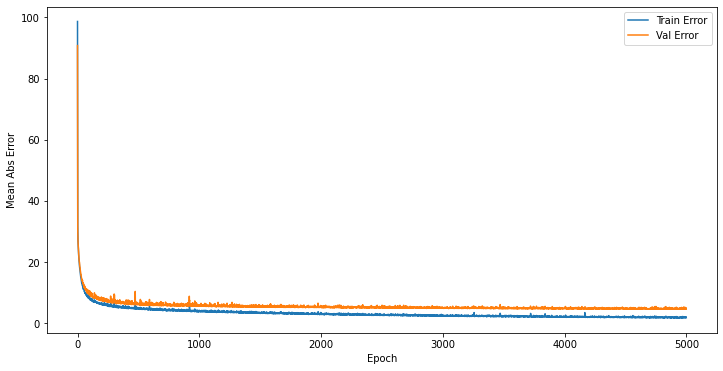

In [63]:
plt.figure(figsize=(12, 6))
plot_history(history)

In [84]:
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

In [85]:
mae_train = np.sqrt(mean_absolute_error(y_train, y_pred_train))
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_test = np.sqrt(mean_absolute_error(y_test, y_pred_test))
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print("Performance\n--------------------------")
print("on training data:\n-------------------------")
print(f"MAE: {mae_train: .2f}")
print(f"MAPE: {mape_train: .3f}")
print(f"R2: {r2_train: .3f}")
print("--------------------------")
print("on test data:\n-------------------------")
print(f"MAE: {mae_test: .2f}")
print(f"MAPE: {mape_test: .3f}")
print(f"R2: {r2_test: .3f}")

Performance
--------------------------
on training data:
-------------------------
MAE:  1.73
MAPE:  0.017
R2:  0.991
--------------------------
on test data:
-------------------------
MAE:  2.71
MAPE:  0.046
R2:  0.971


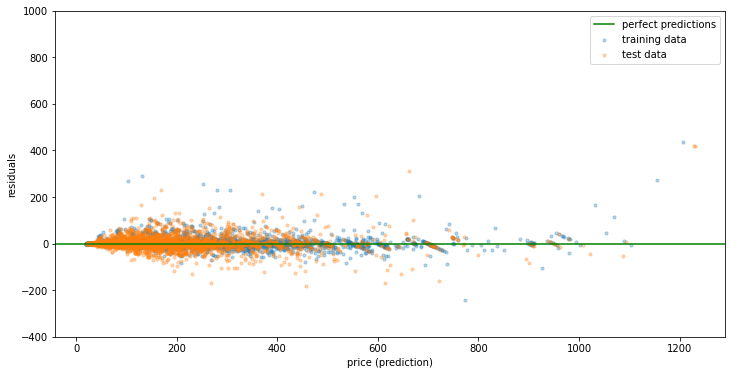

In [66]:
plt.figure(figsize=(12,6))
plt.scatter(y_pred_train, y_train-y_pred_train, s=10, alpha=0.3, label='training data')
plt.scatter(y_pred_test, y_test-y_pred_test, s=10, alpha=0.3, label='test data')
plt.axhline(c='g', label='perfect predictions')
plt.xlabel("price (prediction)")
plt.ylabel("residuals")
plt.ylim(-400, 1000)
plt.legend()

Similarly to XGBoost regression with log squared error as loss function, the precision of the model's predictions at the extremely high price range is not great, probably because MAPE is used as loss function. Also less overfitting is seen just as XGBoost compared to random forest, and it does not suffer from negative price prediction that XGBoost showed.

However compared to the former 2 models, some predictions with noticably big errors can be seen in a broad range.

### Blending

Lastly I also tried the blending technique in which I combined all 3 models with simple average.

In [86]:
y_pred_train_forest = best_rf.predict(X_train).reshape(X_train.shape[0], 1)
y_pred_test_forest = best_rf.predict(X_test).reshape(X_test.shape[0], 1)
y_pred_train_xgb = xgb.predict(X_train).reshape(X_train.shape[0], 1)
y_pred_test_xgb = xgb.predict(X_test).reshape(X_test.shape[0], 1)
y_pred_train_mlp = mlp.predict(X_train_scaled)
y_pred_test_mlp = mlp.predict(X_test_scaled)

In [87]:
y_pred_train_all = (y_pred_train_forest + y_pred_train_xgb + y_pred_train_mlp)/3
y_pred_test_all = (y_pred_test_forest + y_pred_test_xgb + y_pred_test_mlp)/3

In [88]:
mae_train = np.sqrt(mean_absolute_error(y_train, y_pred_train_all))
mape_train = mean_absolute_percentage_error(y_train, y_pred_train_all)
r2_train = r2_score(y_train, y_pred_train_all)
mae_test = np.sqrt(mean_absolute_error(y_test, y_pred_test_all))
mape_test = mean_absolute_percentage_error(y_test, y_pred_test_all)
r2_test = r2_score(y_test, y_pred_test_all)
print("Performance\n--------------------------")
print("on training data:\n-------------------------")
print(f"MAE: {mae_train: .2f}")
print(f"MAPE: {mape_train: .3f}")
print(f"R2: {r2_train: .3f}")
print("--------------------------")
print("on test data:\n-------------------------")
print(f"MAE: {mae_test: .2f}")
print(f"MAPE: {mape_test: .3f}")
print(f"R2: {r2_test: .3f}")

Performance
--------------------------
on training data:
-------------------------
MAE:  1.97
MAPE:  0.023
R2:  0.991
--------------------------
on test data:
-------------------------
MAE:  2.72
MAPE:  0.047
R2:  0.974


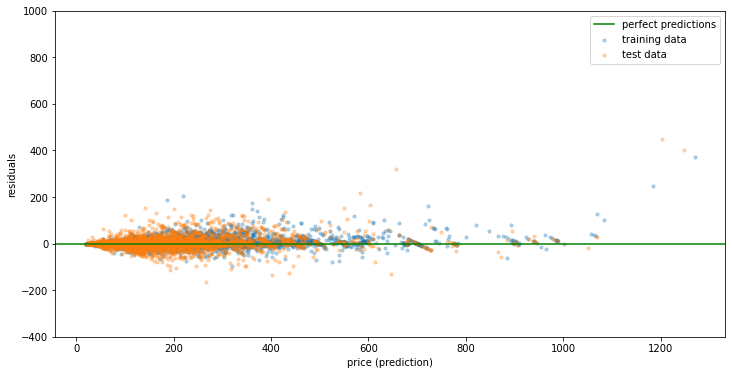

In [79]:
plt.figure(figsize=(12,6))
plt.scatter(y_pred_train_all, y_train-y_pred_train_all, s=10, alpha=0.3, label='training data')
plt.scatter(y_pred_test_all, y_test-y_pred_test_all, s=10, alpha=0.3, label='test data')
plt.axhline(c='g', label='perfect predictions')
plt.xlabel("price (prediction)")
plt.ylabel("residuals")
plt.ylim(-400, 1000)
plt.legend()

This residual plot shows

1. less overfitting in lower price range compared to random forest
2. no negeative price prediction that XGBoost had
3. less predictions very off the actual values that MLP had.

In this sense, this blending model can be said to mitigate weakness of each 3 models. However in terms of metrics there is no distinct improvement from each model.

## Conclusion

In this project, I analyzed Airbnb's open data in Seattle by exploratory methods and subsequently machine learning models. I started with combining listings' detail data and yearly price data. I only used the average monthly price. Threfore the dataset contains at most 12 different entries for the same listing. I took a lot of care when engineering categorical data. I even generated some new features from datetime information. During and after data cleaning & engineering, I discussed about various relations among important features using visualization and correation analysis. The plot of the monthly price shows seasonal tendency that in the summer (June~August) listings are priced higher. Analysis about amenities could be especially informative. According to correlation analysis and feature importance by random forest and XGBoost, items like elevator, pool, cable TV influences price most among various kind of amenities. Only luxurious houses/apartment have elevators or pools so this makes a lot of sense. Also I found that hosts are putting higher price when they offer many amenities. One of the most important categorical features was room type, which is either entire offer, private room, or a bed in shared room. This definitely helped my models to perform well in the highest price range. Downtown and Queen Anne were 2 most expensive areas in Seattle.

I trained random forest regression, XGBoost regression, and multilayer perceptron to predict monthly average prices. Random forest was trained with mean squared error, XGBoost was trained with log squared error, and multilayer perceptron was trained with mean absolute percentage error as loss function. Random forest shows significantly good performance obviously because of MSE penalizing error of big values more. On the other hand other 2 models seemingly work more consistently in lower price range. Although random forest performs very well in general in terms of metrics, the difference of its performance for training data and test data is relatively big. In this regard, XGBoost was the best to perform similarly to training and test data. However its downside is that it predicts some listings' price as 0 or negative. In this sense multilayer perceptron do not have these defects, but it looks slightly underfitting compared to the other 2. Lastly I also used blending technique by siply taking the average of all 3 models' predictions. It compromises all 3 models' downsides but the improvement was not significant enough to say we should take all these computational costs. Overall considering both the performance and computational cost, I would conclude that random forest was the best model for this dataset.

Although the performance in terms of metrics was quite good, one should take extra care to interpret them. Since there are at maximum 12 samples with the same identity with only month data being different, there is no surprise good predictive performance is achieved. It should be suspected that as a result the test set contains very similar data as the training set. Also since there are a lot of extremely high price and the inital MSE is very high, by its definition R2 could easily be very high. Another thing I was not satisfied with was the dataset itself. For price of accommodations, room size should be a very important factor but this dataset does not contain these information. If this is available as a predictive feature, even better performance will be achieved. 